In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "orig"
enable_aug = False
enable_aug3 = True
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = False
lstm_hidden_size = 256
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-orig-enable_aug-False-enable_aug3-True-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-False-lstm_hidden_size-256-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

194419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

194419
194419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


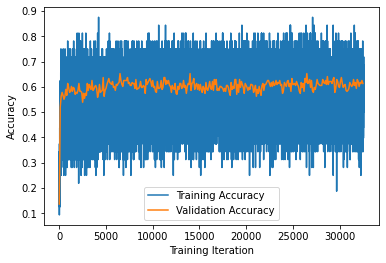

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.191 Validation Loss: 2.195 Accuracy: 0.062 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.191 Validation Loss: 2.195 Accuracy: 0.082 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.194 Validation Loss: 2.195 Accuracy: 0.065 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.195 Validation Loss: 2.195 Accuracy: 0.059 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.193 Validation Loss: 2.195 Accuracy: 0.058 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.192 Validation Loss: 2.195 Accuracy: 0.057 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.192 Validation Loss: 2.195 Accuracy: 0.059 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.192 Validation Loss: 2.195 Accuracy: 0.058 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.192 Validation Loss: 2.195 Accuracy: 0.056 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.191 Validation Loss: 2.195 Accuracy: 0.058 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.190 Validation Loss: 2.195 Accuracy: 0.058 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.190 Validation Loss: 2.195 Accuracy: 0.051 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.190 Validation Loss: 2.195 Accuracy: 0.052 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.189 Validation Loss: 2.195 Accuracy: 0.058 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.188 Validation Loss: 2.195 Accuracy: 0.059 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.188 Validation Loss: 2.195 Accuracy: 0.059 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.187 Validation Loss: 2.195 Accuracy: 0.058 Validation Accuracy: 0.053:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.187 Validation Loss: 2.195 Accuracy: 0.058 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 17 Loss: 2.186 Validation Loss: 2.195 Accuracy: 0.062 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 18 Loss: 2.185 Validation Loss: 2.195 Accuracy: 0.062 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 19 Loss: 2.185 Validation Loss: 2.195 Accuracy: 0.066 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 20 Loss: 2.184 Validation Loss: 2.195 Accuracy: 0.067 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 21 Loss: 2.183 Validation Loss: 2.195 Accuracy: 0.069 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 22 Loss: 2.182 Validation Loss: 2.195 Accuracy: 0.071 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 23 Loss: 2.181 Validation Loss: 2.195 Accuracy: 0.071 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 24 Loss: 2.179 Validation Loss: 2.195 Accuracy: 0.079 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 25 Loss: 2.178 Validation Loss: 2.195 Accuracy: 0.086 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 26 Loss: 2.177 Validation Loss: 2.195 Accuracy: 0.091 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 27 Loss: 2.175 Validation Loss: 2.195 Accuracy: 0.093 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 28 Loss: 2.174 Validation Loss: 2.195 Accuracy: 0.107 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 29 Loss: 2.173 Validation Loss: 2.195 Accuracy: 0.109 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 30 Loss: 2.171 Validation Loss: 2.195 Accuracy: 0.117 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 31 Loss: 2.169 Validation Loss: 2.195 Accuracy: 0.128 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 32 Loss: 2.168 Validation Loss: 2.195 Accuracy: 0.138 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 33 Loss: 2.167 Validation Loss: 2.195 Accuracy: 0.142 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 34 Loss: 2.165 Validation Loss: 2.195 Accuracy: 0.145 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 35 Loss: 2.164 Validation Loss: 2.195 Accuracy: 0.152 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 36 Loss: 2.162 Validation Loss: 2.195 Accuracy: 0.158 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 37 Loss: 2.161 Validation Loss: 2.195 Accuracy: 0.165 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 38 Loss: 2.160 Validation Loss: 2.195 Accuracy: 0.166 Validation Accuracy: 0.053:   1%|          | 17/1519 [00:00<00:08, 169.87it/s]

Epoch: 0 Iteration: 38 Loss: 2.160 Validation Loss: 2.195 Accuracy: 0.166 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 39 Loss: 2.160 Validation Loss: 2.195 Accuracy: 0.175 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 40 Loss: 2.159 Validation Loss: 2.195 Accuracy: 0.177 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 41 Loss: 2.158 Validation Loss: 2.195 Accuracy: 0.176 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 42 Loss: 2.156 Validation Loss: 2.195 Accuracy: 0.182 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 43 Loss: 2.154 Validation Loss: 2.195 Accuracy: 0.193 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 44 Loss: 2.153 Validation Loss: 2.195 Accuracy: 0.198 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 45 Loss: 2.152 Validation Loss: 2.195 Accuracy: 0.203 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 46 Loss: 2.151 Validation Loss: 2.195 Accuracy: 0.205 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 47 Loss: 2.151 Validation Loss: 2.195 Accuracy: 0.203 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 48 Loss: 2.151 Validation Loss: 2.195 Accuracy: 0.200 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 49 Loss: 2.150 Validation Loss: 2.195 Accuracy: 0.202 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 50 Loss: 2.149 Validation Loss: 2.195 Accuracy: 0.209 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 51 Loss: 2.149 Validation Loss: 2.195 Accuracy: 0.217 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 52 Loss: 2.147 Validation Loss: 2.195 Accuracy: 0.218 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 53 Loss: 2.146 Validation Loss: 2.195 Accuracy: 0.222 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 54 Loss: 2.145 Validation Loss: 2.195 Accuracy: 0.230 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 55 Loss: 2.143 Validation Loss: 2.195 Accuracy: 0.237 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 56 Loss: 2.143 Validation Loss: 2.195 Accuracy: 0.248 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 57 Loss: 2.142 Validation Loss: 2.195 Accuracy: 0.255 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 58 Loss: 2.140 Validation Loss: 2.195 Accuracy: 0.265 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 59 Loss: 2.138 Validation Loss: 2.195 Accuracy: 0.266 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 60 Loss: 2.136 Validation Loss: 2.195 Accuracy: 0.265 Validation Accuracy: 0.053:   3%|▎         | 39/1519 [00:00<00:07, 195.19it/s]

Epoch: 0 Iteration: 60 Loss: 2.136 Validation Loss: 2.195 Accuracy: 0.265 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 61 Loss: 2.134 Validation Loss: 2.195 Accuracy: 0.271 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 62 Loss: 2.133 Validation Loss: 2.195 Accuracy: 0.282 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 63 Loss: 2.132 Validation Loss: 2.195 Accuracy: 0.277 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 64 Loss: 2.130 Validation Loss: 2.195 Accuracy: 0.273 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 65 Loss: 2.130 Validation Loss: 2.195 Accuracy: 0.270 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 66 Loss: 2.128 Validation Loss: 2.195 Accuracy: 0.267 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 67 Loss: 2.127 Validation Loss: 2.195 Accuracy: 0.276 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 68 Loss: 2.124 Validation Loss: 2.195 Accuracy: 0.282 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 69 Loss: 2.123 Validation Loss: 2.195 Accuracy: 0.292 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 70 Loss: 2.121 Validation Loss: 2.195 Accuracy: 0.302 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 71 Loss: 2.120 Validation Loss: 2.195 Accuracy: 0.295 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 72 Loss: 2.118 Validation Loss: 2.195 Accuracy: 0.291 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 73 Loss: 2.118 Validation Loss: 2.195 Accuracy: 0.300 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 74 Loss: 2.117 Validation Loss: 2.195 Accuracy: 0.309 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 75 Loss: 2.116 Validation Loss: 2.195 Accuracy: 0.312 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 76 Loss: 2.114 Validation Loss: 2.195 Accuracy: 0.320 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 77 Loss: 2.113 Validation Loss: 2.195 Accuracy: 0.316 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 78 Loss: 2.112 Validation Loss: 2.195 Accuracy: 0.312 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 79 Loss: 2.110 Validation Loss: 2.195 Accuracy: 0.310 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 80 Loss: 2.110 Validation Loss: 2.195 Accuracy: 0.309 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 81 Loss: 2.109 Validation Loss: 2.195 Accuracy: 0.324 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 82 Loss: 2.108 Validation Loss: 2.195 Accuracy: 0.334 Validation Accuracy: 0.053:   4%|▍         | 61/1519 [00:00<00:07, 203.15it/s]

Epoch: 0 Iteration: 82 Loss: 2.108 Validation Loss: 2.195 Accuracy: 0.334 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 83 Loss: 2.108 Validation Loss: 2.195 Accuracy: 0.327 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 84 Loss: 2.106 Validation Loss: 2.195 Accuracy: 0.327 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 85 Loss: 2.104 Validation Loss: 2.195 Accuracy: 0.334 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 86 Loss: 2.103 Validation Loss: 2.195 Accuracy: 0.336 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 87 Loss: 2.101 Validation Loss: 2.195 Accuracy: 0.341 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 88 Loss: 2.101 Validation Loss: 2.195 Accuracy: 0.346 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 89 Loss: 2.100 Validation Loss: 2.195 Accuracy: 0.350 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 90 Loss: 2.099 Validation Loss: 2.195 Accuracy: 0.357 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 91 Loss: 2.097 Validation Loss: 2.195 Accuracy: 0.358 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 92 Loss: 2.096 Validation Loss: 2.195 Accuracy: 0.350 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 93 Loss: 2.094 Validation Loss: 2.195 Accuracy: 0.368 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 94 Loss: 2.093 Validation Loss: 2.195 Accuracy: 0.362 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 95 Loss: 2.092 Validation Loss: 2.195 Accuracy: 0.362 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 96 Loss: 2.091 Validation Loss: 2.195 Accuracy: 0.365 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 97 Loss: 2.089 Validation Loss: 2.195 Accuracy: 0.377 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 98 Loss: 2.088 Validation Loss: 2.195 Accuracy: 0.375 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 99 Loss: 2.086 Validation Loss: 2.195 Accuracy: 0.372 Validation Accuracy: 0.053:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 100 Loss: 2.085 Validation Loss: 2.062 Accuracy: 0.371 Validation Accuracy: 0.243:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 101 Loss: 2.083 Validation Loss: 2.062 Accuracy: 0.367 Validation Accuracy: 0.243:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 102 Loss: 2.082 Validation Loss: 2.062 Accuracy: 0.373 Validation Accuracy: 0.243:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 103 Loss: 2.080 Validation Loss: 2.062 Accuracy: 0.368 Validation Accuracy: 0.243:   5%|▌         | 83/1519 [00:00<00:06, 207.94it/s]

Epoch: 0 Iteration: 103 Loss: 2.080 Validation Loss: 2.062 Accuracy: 0.368 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 104 Loss: 2.081 Validation Loss: 2.062 Accuracy: 0.377 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 105 Loss: 2.079 Validation Loss: 2.062 Accuracy: 0.380 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 106 Loss: 2.079 Validation Loss: 2.062 Accuracy: 0.381 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 107 Loss: 2.078 Validation Loss: 2.062 Accuracy: 0.368 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 108 Loss: 2.075 Validation Loss: 2.062 Accuracy: 0.384 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 109 Loss: 2.074 Validation Loss: 2.062 Accuracy: 0.394 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 110 Loss: 2.072 Validation Loss: 2.062 Accuracy: 0.400 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 111 Loss: 2.072 Validation Loss: 2.062 Accuracy: 0.402 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 112 Loss: 2.072 Validation Loss: 2.062 Accuracy: 0.405 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 113 Loss: 2.068 Validation Loss: 2.062 Accuracy: 0.403 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 114 Loss: 2.065 Validation Loss: 2.062 Accuracy: 0.412 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 115 Loss: 2.063 Validation Loss: 2.062 Accuracy: 0.409 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 116 Loss: 2.063 Validation Loss: 2.062 Accuracy: 0.409 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 117 Loss: 2.061 Validation Loss: 2.062 Accuracy: 0.419 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 118 Loss: 2.060 Validation Loss: 2.062 Accuracy: 0.403 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 119 Loss: 2.061 Validation Loss: 2.062 Accuracy: 0.403 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 120 Loss: 2.059 Validation Loss: 2.062 Accuracy: 0.396 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 121 Loss: 2.058 Validation Loss: 2.062 Accuracy: 0.402 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 122 Loss: 2.058 Validation Loss: 2.062 Accuracy: 0.403 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 123 Loss: 2.056 Validation Loss: 2.062 Accuracy: 0.407 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 124 Loss: 2.054 Validation Loss: 2.062 Accuracy: 0.397 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 125 Loss: 2.052 Validation Loss: 2.062 Accuracy: 0.401 Validation Accuracy: 0.243:   7%|▋         | 104/1519 [00:00<00:06, 204.75it/s]

Epoch: 0 Iteration: 125 Loss: 2.052 Validation Loss: 2.062 Accuracy: 0.401 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 126 Loss: 2.050 Validation Loss: 2.062 Accuracy: 0.406 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 127 Loss: 2.050 Validation Loss: 2.062 Accuracy: 0.402 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 128 Loss: 2.050 Validation Loss: 2.062 Accuracy: 0.406 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 129 Loss: 2.047 Validation Loss: 2.062 Accuracy: 0.402 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 130 Loss: 2.045 Validation Loss: 2.062 Accuracy: 0.405 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 131 Loss: 2.044 Validation Loss: 2.062 Accuracy: 0.416 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 132 Loss: 2.042 Validation Loss: 2.062 Accuracy: 0.416 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 133 Loss: 2.042 Validation Loss: 2.062 Accuracy: 0.418 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 134 Loss: 2.043 Validation Loss: 2.062 Accuracy: 0.422 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 135 Loss: 2.042 Validation Loss: 2.062 Accuracy: 0.430 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 136 Loss: 2.041 Validation Loss: 2.062 Accuracy: 0.432 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 137 Loss: 2.040 Validation Loss: 2.062 Accuracy: 0.438 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 138 Loss: 2.038 Validation Loss: 2.062 Accuracy: 0.441 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 139 Loss: 2.035 Validation Loss: 2.062 Accuracy: 0.452 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 140 Loss: 2.032 Validation Loss: 2.062 Accuracy: 0.464 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 141 Loss: 2.031 Validation Loss: 2.062 Accuracy: 0.458 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 142 Loss: 2.027 Validation Loss: 2.062 Accuracy: 0.466 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 143 Loss: 2.027 Validation Loss: 2.062 Accuracy: 0.466 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 144 Loss: 2.025 Validation Loss: 2.062 Accuracy: 0.470 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 145 Loss: 2.025 Validation Loss: 2.062 Accuracy: 0.468 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 146 Loss: 2.023 Validation Loss: 2.062 Accuracy: 0.459 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 147 Loss: 2.022 Validation Loss: 2.062 Accuracy: 0.455 Validation Accuracy: 0.243:   8%|▊         | 126/1519 [00:00<00:06, 208.25it/s]

Epoch: 0 Iteration: 147 Loss: 2.022 Validation Loss: 2.062 Accuracy: 0.455 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 148 Loss: 2.022 Validation Loss: 2.062 Accuracy: 0.462 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 149 Loss: 2.019 Validation Loss: 2.062 Accuracy: 0.455 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 150 Loss: 2.017 Validation Loss: 2.062 Accuracy: 0.451 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 151 Loss: 2.014 Validation Loss: 2.062 Accuracy: 0.453 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 152 Loss: 2.012 Validation Loss: 2.062 Accuracy: 0.441 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 153 Loss: 2.007 Validation Loss: 2.062 Accuracy: 0.448 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 154 Loss: 2.006 Validation Loss: 2.062 Accuracy: 0.445 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 155 Loss: 2.002 Validation Loss: 2.062 Accuracy: 0.444 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 156 Loss: 2.000 Validation Loss: 2.062 Accuracy: 0.455 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 157 Loss: 1.999 Validation Loss: 2.062 Accuracy: 0.466 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 158 Loss: 1.997 Validation Loss: 2.062 Accuracy: 0.459 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 159 Loss: 1.996 Validation Loss: 2.062 Accuracy: 0.468 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 160 Loss: 1.999 Validation Loss: 2.062 Accuracy: 0.464 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 161 Loss: 1.993 Validation Loss: 2.062 Accuracy: 0.466 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 162 Loss: 1.993 Validation Loss: 2.062 Accuracy: 0.470 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 163 Loss: 1.992 Validation Loss: 2.062 Accuracy: 0.462 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 164 Loss: 1.990 Validation Loss: 2.062 Accuracy: 0.462 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 165 Loss: 1.988 Validation Loss: 2.062 Accuracy: 0.456 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 166 Loss: 1.986 Validation Loss: 2.062 Accuracy: 0.452 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 167 Loss: 1.984 Validation Loss: 2.062 Accuracy: 0.445 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 168 Loss: 1.980 Validation Loss: 2.062 Accuracy: 0.449 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 169 Loss: 1.981 Validation Loss: 2.062 Accuracy: 0.449 Validation Accuracy: 0.243:  10%|▉         | 148/1519 [00:00<00:06, 210.54it/s]

Epoch: 0 Iteration: 169 Loss: 1.981 Validation Loss: 2.062 Accuracy: 0.449 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 170 Loss: 1.979 Validation Loss: 2.062 Accuracy: 0.445 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 171 Loss: 1.979 Validation Loss: 2.062 Accuracy: 0.442 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 172 Loss: 1.977 Validation Loss: 2.062 Accuracy: 0.452 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 173 Loss: 1.981 Validation Loss: 2.062 Accuracy: 0.451 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 174 Loss: 1.983 Validation Loss: 2.062 Accuracy: 0.441 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 175 Loss: 1.983 Validation Loss: 2.062 Accuracy: 0.446 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 176 Loss: 1.983 Validation Loss: 2.062 Accuracy: 0.450 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 177 Loss: 1.978 Validation Loss: 2.062 Accuracy: 0.458 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 178 Loss: 1.976 Validation Loss: 2.062 Accuracy: 0.457 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 179 Loss: 1.970 Validation Loss: 2.062 Accuracy: 0.448 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 180 Loss: 1.965 Validation Loss: 2.062 Accuracy: 0.465 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 181 Loss: 1.967 Validation Loss: 2.062 Accuracy: 0.455 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 182 Loss: 1.963 Validation Loss: 2.062 Accuracy: 0.452 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 183 Loss: 1.961 Validation Loss: 2.062 Accuracy: 0.457 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 184 Loss: 1.960 Validation Loss: 2.062 Accuracy: 0.463 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 185 Loss: 1.957 Validation Loss: 2.062 Accuracy: 0.469 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 186 Loss: 1.954 Validation Loss: 2.062 Accuracy: 0.474 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 187 Loss: 1.952 Validation Loss: 2.062 Accuracy: 0.471 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 188 Loss: 1.952 Validation Loss: 2.062 Accuracy: 0.471 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 189 Loss: 1.947 Validation Loss: 2.062 Accuracy: 0.475 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 190 Loss: 1.946 Validation Loss: 2.062 Accuracy: 0.471 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 191 Loss: 1.945 Validation Loss: 2.062 Accuracy: 0.473 Validation Accuracy: 0.243:  11%|█         | 170/1519 [00:00<00:06, 212.20it/s]

Epoch: 0 Iteration: 191 Loss: 1.945 Validation Loss: 2.062 Accuracy: 0.473 Validation Accuracy: 0.243:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 192 Loss: 1.943 Validation Loss: 2.062 Accuracy: 0.473 Validation Accuracy: 0.243:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 193 Loss: 1.936 Validation Loss: 2.062 Accuracy: 0.471 Validation Accuracy: 0.243:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 194 Loss: 1.929 Validation Loss: 2.062 Accuracy: 0.481 Validation Accuracy: 0.243:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 195 Loss: 1.926 Validation Loss: 2.062 Accuracy: 0.477 Validation Accuracy: 0.243:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 196 Loss: 1.925 Validation Loss: 2.062 Accuracy: 0.464 Validation Accuracy: 0.243:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 197 Loss: 1.926 Validation Loss: 2.062 Accuracy: 0.454 Validation Accuracy: 0.243:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 198 Loss: 1.926 Validation Loss: 2.062 Accuracy: 0.457 Validation Accuracy: 0.243:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 199 Loss: 1.930 Validation Loss: 2.062 Accuracy: 0.457 Validation Accuracy: 0.243:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 200 Loss: 1.930 Validation Loss: 1.893 Accuracy: 0.455 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 201 Loss: 1.927 Validation Loss: 1.893 Accuracy: 0.463 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 202 Loss: 1.928 Validation Loss: 1.893 Accuracy: 0.463 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 203 Loss: 1.927 Validation Loss: 1.893 Accuracy: 0.463 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 204 Loss: 1.926 Validation Loss: 1.893 Accuracy: 0.448 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 205 Loss: 1.923 Validation Loss: 1.893 Accuracy: 0.455 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 206 Loss: 1.922 Validation Loss: 1.893 Accuracy: 0.459 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 207 Loss: 1.919 Validation Loss: 1.893 Accuracy: 0.467 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:01<00:06, 213.17it/s]

Epoch: 0 Iteration: 208 Loss: 1.918 Validation Loss: 1.893 Accuracy: 0.463 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:01<00:06, 213.17it/s]

Epoch: 0 Iteration: 209 Loss: 1.919 Validation Loss: 1.893 Accuracy: 0.466 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:01<00:06, 213.17it/s]

Epoch: 0 Iteration: 210 Loss: 1.917 Validation Loss: 1.893 Accuracy: 0.465 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:01<00:06, 213.17it/s]

Epoch: 0 Iteration: 211 Loss: 1.916 Validation Loss: 1.893 Accuracy: 0.465 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:01<00:06, 213.17it/s]

Epoch: 0 Iteration: 212 Loss: 1.914 Validation Loss: 1.893 Accuracy: 0.464 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:01<00:06, 213.17it/s]

Epoch: 0 Iteration: 213 Loss: 1.913 Validation Loss: 1.893 Accuracy: 0.472 Validation Accuracy: 0.338:  13%|█▎        | 192/1519 [00:01<00:06, 213.17it/s]

Epoch: 0 Iteration: 213 Loss: 1.913 Validation Loss: 1.893 Accuracy: 0.472 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 214 Loss: 1.916 Validation Loss: 1.893 Accuracy: 0.477 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 215 Loss: 1.918 Validation Loss: 1.893 Accuracy: 0.476 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 216 Loss: 1.917 Validation Loss: 1.893 Accuracy: 0.484 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 217 Loss: 1.914 Validation Loss: 1.893 Accuracy: 0.481 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 218 Loss: 1.910 Validation Loss: 1.893 Accuracy: 0.484 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 219 Loss: 1.907 Validation Loss: 1.893 Accuracy: 0.479 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 220 Loss: 1.903 Validation Loss: 1.893 Accuracy: 0.487 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 221 Loss: 1.903 Validation Loss: 1.893 Accuracy: 0.481 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 222 Loss: 1.901 Validation Loss: 1.893 Accuracy: 0.476 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 223 Loss: 1.898 Validation Loss: 1.893 Accuracy: 0.466 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 224 Loss: 1.898 Validation Loss: 1.893 Accuracy: 0.473 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 225 Loss: 1.897 Validation Loss: 1.893 Accuracy: 0.476 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 226 Loss: 1.896 Validation Loss: 1.893 Accuracy: 0.475 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 227 Loss: 1.894 Validation Loss: 1.893 Accuracy: 0.478 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 228 Loss: 1.890 Validation Loss: 1.893 Accuracy: 0.475 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 229 Loss: 1.887 Validation Loss: 1.893 Accuracy: 0.479 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 230 Loss: 1.886 Validation Loss: 1.893 Accuracy: 0.461 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 231 Loss: 1.883 Validation Loss: 1.893 Accuracy: 0.470 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 232 Loss: 1.884 Validation Loss: 1.893 Accuracy: 0.475 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 233 Loss: 1.882 Validation Loss: 1.893 Accuracy: 0.482 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 234 Loss: 1.878 Validation Loss: 1.893 Accuracy: 0.481 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 235 Loss: 1.873 Validation Loss: 1.893 Accuracy: 0.475 Validation Accuracy: 0.338:  14%|█▍        | 214/1519 [00:01<00:06, 209.60it/s]

Epoch: 0 Iteration: 235 Loss: 1.873 Validation Loss: 1.893 Accuracy: 0.475 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 236 Loss: 1.866 Validation Loss: 1.893 Accuracy: 0.476 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 237 Loss: 1.865 Validation Loss: 1.893 Accuracy: 0.480 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 238 Loss: 1.863 Validation Loss: 1.893 Accuracy: 0.488 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 239 Loss: 1.859 Validation Loss: 1.893 Accuracy: 0.486 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 240 Loss: 1.857 Validation Loss: 1.893 Accuracy: 0.498 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 241 Loss: 1.856 Validation Loss: 1.893 Accuracy: 0.487 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 242 Loss: 1.852 Validation Loss: 1.893 Accuracy: 0.497 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 243 Loss: 1.848 Validation Loss: 1.893 Accuracy: 0.498 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 244 Loss: 1.845 Validation Loss: 1.893 Accuracy: 0.500 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 245 Loss: 1.841 Validation Loss: 1.893 Accuracy: 0.505 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 246 Loss: 1.838 Validation Loss: 1.893 Accuracy: 0.496 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 247 Loss: 1.836 Validation Loss: 1.893 Accuracy: 0.491 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 248 Loss: 1.835 Validation Loss: 1.893 Accuracy: 0.491 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 249 Loss: 1.837 Validation Loss: 1.893 Accuracy: 0.495 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 250 Loss: 1.834 Validation Loss: 1.893 Accuracy: 0.494 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 251 Loss: 1.829 Validation Loss: 1.893 Accuracy: 0.506 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 252 Loss: 1.825 Validation Loss: 1.893 Accuracy: 0.496 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 253 Loss: 1.827 Validation Loss: 1.893 Accuracy: 0.495 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 254 Loss: 1.824 Validation Loss: 1.893 Accuracy: 0.498 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 255 Loss: 1.822 Validation Loss: 1.893 Accuracy: 0.491 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 256 Loss: 1.822 Validation Loss: 1.893 Accuracy: 0.491 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 257 Loss: 1.819 Validation Loss: 1.893 Accuracy: 0.489 Validation Accuracy: 0.338:  16%|█▌        | 236/1519 [00:01<00:06, 211.32it/s]

Epoch: 0 Iteration: 257 Loss: 1.819 Validation Loss: 1.893 Accuracy: 0.489 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 258 Loss: 1.821 Validation Loss: 1.893 Accuracy: 0.485 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 259 Loss: 1.817 Validation Loss: 1.893 Accuracy: 0.484 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 260 Loss: 1.816 Validation Loss: 1.893 Accuracy: 0.477 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 261 Loss: 1.815 Validation Loss: 1.893 Accuracy: 0.477 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 262 Loss: 1.812 Validation Loss: 1.893 Accuracy: 0.477 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 263 Loss: 1.810 Validation Loss: 1.893 Accuracy: 0.486 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 264 Loss: 1.810 Validation Loss: 1.893 Accuracy: 0.488 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 265 Loss: 1.810 Validation Loss: 1.893 Accuracy: 0.489 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 266 Loss: 1.808 Validation Loss: 1.893 Accuracy: 0.504 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 267 Loss: 1.803 Validation Loss: 1.893 Accuracy: 0.509 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 268 Loss: 1.799 Validation Loss: 1.893 Accuracy: 0.498 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 269 Loss: 1.796 Validation Loss: 1.893 Accuracy: 0.501 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 270 Loss: 1.792 Validation Loss: 1.893 Accuracy: 0.507 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 271 Loss: 1.790 Validation Loss: 1.893 Accuracy: 0.509 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 272 Loss: 1.790 Validation Loss: 1.893 Accuracy: 0.509 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 273 Loss: 1.784 Validation Loss: 1.893 Accuracy: 0.493 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 274 Loss: 1.782 Validation Loss: 1.893 Accuracy: 0.480 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 275 Loss: 1.777 Validation Loss: 1.893 Accuracy: 0.485 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 276 Loss: 1.779 Validation Loss: 1.893 Accuracy: 0.480 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 277 Loss: 1.784 Validation Loss: 1.893 Accuracy: 0.473 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 278 Loss: 1.779 Validation Loss: 1.893 Accuracy: 0.490 Validation Accuracy: 0.338:  17%|█▋        | 258/1519 [00:01<00:06, 209.31it/s]

Epoch: 0 Iteration: 278 Loss: 1.779 Validation Loss: 1.893 Accuracy: 0.490 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 279 Loss: 1.780 Validation Loss: 1.893 Accuracy: 0.477 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 280 Loss: 1.774 Validation Loss: 1.893 Accuracy: 0.478 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 281 Loss: 1.769 Validation Loss: 1.893 Accuracy: 0.466 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 282 Loss: 1.773 Validation Loss: 1.893 Accuracy: 0.471 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 283 Loss: 1.771 Validation Loss: 1.893 Accuracy: 0.479 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 284 Loss: 1.767 Validation Loss: 1.893 Accuracy: 0.484 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 285 Loss: 1.766 Validation Loss: 1.893 Accuracy: 0.474 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 286 Loss: 1.764 Validation Loss: 1.893 Accuracy: 0.477 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 287 Loss: 1.762 Validation Loss: 1.893 Accuracy: 0.495 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 288 Loss: 1.759 Validation Loss: 1.893 Accuracy: 0.489 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 289 Loss: 1.756 Validation Loss: 1.893 Accuracy: 0.497 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 290 Loss: 1.756 Validation Loss: 1.893 Accuracy: 0.491 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 291 Loss: 1.757 Validation Loss: 1.893 Accuracy: 0.505 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 292 Loss: 1.747 Validation Loss: 1.893 Accuracy: 0.513 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 293 Loss: 1.739 Validation Loss: 1.893 Accuracy: 0.513 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 294 Loss: 1.736 Validation Loss: 1.893 Accuracy: 0.520 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 295 Loss: 1.735 Validation Loss: 1.893 Accuracy: 0.534 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 296 Loss: 1.729 Validation Loss: 1.893 Accuracy: 0.528 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 297 Loss: 1.720 Validation Loss: 1.893 Accuracy: 0.512 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 298 Loss: 1.719 Validation Loss: 1.893 Accuracy: 0.516 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 299 Loss: 1.718 Validation Loss: 1.893 Accuracy: 0.521 Validation Accuracy: 0.338:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 300 Loss: 1.722 Validation Loss: 1.671 Accuracy: 0.524 Validation Accuracy: 0.399:  18%|█▊        | 279/1519 [00:01<00:05, 208.48it/s]

Epoch: 0 Iteration: 300 Loss: 1.722 Validation Loss: 1.671 Accuracy: 0.524 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 301 Loss: 1.719 Validation Loss: 1.671 Accuracy: 0.522 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 302 Loss: 1.716 Validation Loss: 1.671 Accuracy: 0.509 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 303 Loss: 1.713 Validation Loss: 1.671 Accuracy: 0.506 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 304 Loss: 1.710 Validation Loss: 1.671 Accuracy: 0.504 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 305 Loss: 1.708 Validation Loss: 1.671 Accuracy: 0.503 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 306 Loss: 1.707 Validation Loss: 1.671 Accuracy: 0.504 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 307 Loss: 1.707 Validation Loss: 1.671 Accuracy: 0.509 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 308 Loss: 1.705 Validation Loss: 1.671 Accuracy: 0.505 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 309 Loss: 1.703 Validation Loss: 1.671 Accuracy: 0.508 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 310 Loss: 1.704 Validation Loss: 1.671 Accuracy: 0.509 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 311 Loss: 1.704 Validation Loss: 1.671 Accuracy: 0.499 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 312 Loss: 1.708 Validation Loss: 1.671 Accuracy: 0.511 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 313 Loss: 1.715 Validation Loss: 1.671 Accuracy: 0.513 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 314 Loss: 1.712 Validation Loss: 1.671 Accuracy: 0.509 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 315 Loss: 1.712 Validation Loss: 1.671 Accuracy: 0.505 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 316 Loss: 1.712 Validation Loss: 1.671 Accuracy: 0.505 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 317 Loss: 1.709 Validation Loss: 1.671 Accuracy: 0.509 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 318 Loss: 1.707 Validation Loss: 1.671 Accuracy: 0.511 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 319 Loss: 1.706 Validation Loss: 1.671 Accuracy: 0.500 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 320 Loss: 1.698 Validation Loss: 1.671 Accuracy: 0.505 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 321 Loss: 1.693 Validation Loss: 1.671 Accuracy: 0.510 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 322 Loss: 1.687 Validation Loss: 1.671 Accuracy: 0.501 Validation Accuracy: 0.399:  20%|█▉        | 301/1519 [00:01<00:05, 206.13it/s]

Epoch: 0 Iteration: 322 Loss: 1.687 Validation Loss: 1.671 Accuracy: 0.501 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 323 Loss: 1.688 Validation Loss: 1.671 Accuracy: 0.505 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 324 Loss: 1.687 Validation Loss: 1.671 Accuracy: 0.507 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 325 Loss: 1.685 Validation Loss: 1.671 Accuracy: 0.505 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 326 Loss: 1.682 Validation Loss: 1.671 Accuracy: 0.498 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 327 Loss: 1.681 Validation Loss: 1.671 Accuracy: 0.494 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 328 Loss: 1.685 Validation Loss: 1.671 Accuracy: 0.488 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 329 Loss: 1.680 Validation Loss: 1.671 Accuracy: 0.495 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 330 Loss: 1.675 Validation Loss: 1.671 Accuracy: 0.497 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 331 Loss: 1.673 Validation Loss: 1.671 Accuracy: 0.503 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 332 Loss: 1.666 Validation Loss: 1.671 Accuracy: 0.507 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 333 Loss: 1.660 Validation Loss: 1.671 Accuracy: 0.495 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 334 Loss: 1.659 Validation Loss: 1.671 Accuracy: 0.500 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 335 Loss: 1.654 Validation Loss: 1.671 Accuracy: 0.517 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 336 Loss: 1.652 Validation Loss: 1.671 Accuracy: 0.530 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 337 Loss: 1.644 Validation Loss: 1.671 Accuracy: 0.541 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 338 Loss: 1.640 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 339 Loss: 1.635 Validation Loss: 1.671 Accuracy: 0.557 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 340 Loss: 1.638 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 341 Loss: 1.639 Validation Loss: 1.671 Accuracy: 0.553 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 342 Loss: 1.635 Validation Loss: 1.671 Accuracy: 0.559 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 343 Loss: 1.630 Validation Loss: 1.671 Accuracy: 0.561 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 344 Loss: 1.625 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  21%|██▏       | 323/1519 [00:01<00:05, 208.64it/s]

Epoch: 0 Iteration: 344 Loss: 1.625 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 345 Loss: 1.622 Validation Loss: 1.671 Accuracy: 0.538 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 346 Loss: 1.622 Validation Loss: 1.671 Accuracy: 0.530 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 347 Loss: 1.619 Validation Loss: 1.671 Accuracy: 0.520 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 348 Loss: 1.615 Validation Loss: 1.671 Accuracy: 0.512 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 349 Loss: 1.616 Validation Loss: 1.671 Accuracy: 0.514 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 350 Loss: 1.613 Validation Loss: 1.671 Accuracy: 0.521 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 351 Loss: 1.605 Validation Loss: 1.671 Accuracy: 0.508 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 352 Loss: 1.607 Validation Loss: 1.671 Accuracy: 0.504 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 353 Loss: 1.604 Validation Loss: 1.671 Accuracy: 0.509 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 354 Loss: 1.606 Validation Loss: 1.671 Accuracy: 0.514 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 355 Loss: 1.601 Validation Loss: 1.671 Accuracy: 0.515 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 356 Loss: 1.598 Validation Loss: 1.671 Accuracy: 0.527 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 357 Loss: 1.599 Validation Loss: 1.671 Accuracy: 0.534 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 358 Loss: 1.596 Validation Loss: 1.671 Accuracy: 0.543 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 359 Loss: 1.592 Validation Loss: 1.671 Accuracy: 0.544 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 360 Loss: 1.585 Validation Loss: 1.671 Accuracy: 0.544 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 361 Loss: 1.589 Validation Loss: 1.671 Accuracy: 0.553 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 362 Loss: 1.589 Validation Loss: 1.671 Accuracy: 0.548 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 363 Loss: 1.589 Validation Loss: 1.671 Accuracy: 0.558 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 364 Loss: 1.587 Validation Loss: 1.671 Accuracy: 0.561 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 365 Loss: 1.586 Validation Loss: 1.671 Accuracy: 0.565 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 366 Loss: 1.580 Validation Loss: 1.671 Accuracy: 0.561 Validation Accuracy: 0.399:  23%|██▎       | 345/1519 [00:01<00:05, 210.53it/s]

Epoch: 0 Iteration: 366 Loss: 1.580 Validation Loss: 1.671 Accuracy: 0.561 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 367 Loss: 1.575 Validation Loss: 1.671 Accuracy: 0.559 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 368 Loss: 1.567 Validation Loss: 1.671 Accuracy: 0.558 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 369 Loss: 1.562 Validation Loss: 1.671 Accuracy: 0.558 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 370 Loss: 1.558 Validation Loss: 1.671 Accuracy: 0.554 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 371 Loss: 1.562 Validation Loss: 1.671 Accuracy: 0.549 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 372 Loss: 1.559 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 373 Loss: 1.558 Validation Loss: 1.671 Accuracy: 0.549 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 374 Loss: 1.555 Validation Loss: 1.671 Accuracy: 0.546 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 375 Loss: 1.557 Validation Loss: 1.671 Accuracy: 0.550 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 376 Loss: 1.554 Validation Loss: 1.671 Accuracy: 0.555 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 377 Loss: 1.553 Validation Loss: 1.671 Accuracy: 0.551 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 378 Loss: 1.555 Validation Loss: 1.671 Accuracy: 0.548 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 379 Loss: 1.554 Validation Loss: 1.671 Accuracy: 0.543 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 380 Loss: 1.551 Validation Loss: 1.671 Accuracy: 0.548 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 381 Loss: 1.544 Validation Loss: 1.671 Accuracy: 0.548 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 382 Loss: 1.540 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 383 Loss: 1.535 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 384 Loss: 1.535 Validation Loss: 1.671 Accuracy: 0.559 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 385 Loss: 1.530 Validation Loss: 1.671 Accuracy: 0.554 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 386 Loss: 1.532 Validation Loss: 1.671 Accuracy: 0.549 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 387 Loss: 1.532 Validation Loss: 1.671 Accuracy: 0.553 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 388 Loss: 1.534 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  24%|██▍       | 367/1519 [00:01<00:05, 211.98it/s]

Epoch: 0 Iteration: 388 Loss: 1.534 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 389 Loss: 1.528 Validation Loss: 1.671 Accuracy: 0.552 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 390 Loss: 1.525 Validation Loss: 1.671 Accuracy: 0.546 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 391 Loss: 1.518 Validation Loss: 1.671 Accuracy: 0.558 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 392 Loss: 1.514 Validation Loss: 1.671 Accuracy: 0.561 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 393 Loss: 1.508 Validation Loss: 1.671 Accuracy: 0.564 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 394 Loss: 1.505 Validation Loss: 1.671 Accuracy: 0.560 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 395 Loss: 1.498 Validation Loss: 1.671 Accuracy: 0.567 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 396 Loss: 1.499 Validation Loss: 1.671 Accuracy: 0.570 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 397 Loss: 1.495 Validation Loss: 1.671 Accuracy: 0.576 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 398 Loss: 1.490 Validation Loss: 1.671 Accuracy: 0.580 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 399 Loss: 1.484 Validation Loss: 1.671 Accuracy: 0.589 Validation Accuracy: 0.399:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 400 Loss: 1.482 Validation Loss: 1.390 Accuracy: 0.598 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 401 Loss: 1.479 Validation Loss: 1.390 Accuracy: 0.593 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 402 Loss: 1.474 Validation Loss: 1.390 Accuracy: 0.602 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 403 Loss: 1.468 Validation Loss: 1.390 Accuracy: 0.598 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 404 Loss: 1.463 Validation Loss: 1.390 Accuracy: 0.605 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 405 Loss: 1.460 Validation Loss: 1.390 Accuracy: 0.598 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 406 Loss: 1.458 Validation Loss: 1.390 Accuracy: 0.595 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 407 Loss: 1.452 Validation Loss: 1.390 Accuracy: 0.594 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 408 Loss: 1.451 Validation Loss: 1.390 Accuracy: 0.593 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 409 Loss: 1.453 Validation Loss: 1.390 Accuracy: 0.584 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 410 Loss: 1.453 Validation Loss: 1.390 Accuracy: 0.578 Validation Accuracy: 0.447:  26%|██▌       | 389/1519 [00:01<00:05, 212.98it/s]

Epoch: 0 Iteration: 410 Loss: 1.453 Validation Loss: 1.390 Accuracy: 0.578 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:01<00:05, 209.32it/s]

Epoch: 0 Iteration: 411 Loss: 1.452 Validation Loss: 1.390 Accuracy: 0.580 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:01<00:05, 209.32it/s]

Epoch: 0 Iteration: 412 Loss: 1.450 Validation Loss: 1.390 Accuracy: 0.565 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:01<00:05, 209.32it/s]

Epoch: 0 Iteration: 413 Loss: 1.452 Validation Loss: 1.390 Accuracy: 0.565 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:01<00:05, 209.32it/s]

Epoch: 0 Iteration: 414 Loss: 1.445 Validation Loss: 1.390 Accuracy: 0.559 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:01<00:05, 209.32it/s]

Epoch: 0 Iteration: 415 Loss: 1.447 Validation Loss: 1.390 Accuracy: 0.559 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:01<00:05, 209.32it/s]

Epoch: 0 Iteration: 416 Loss: 1.443 Validation Loss: 1.390 Accuracy: 0.559 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:01<00:05, 209.32it/s]

Epoch: 0 Iteration: 417 Loss: 1.444 Validation Loss: 1.390 Accuracy: 0.554 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 418 Loss: 1.435 Validation Loss: 1.390 Accuracy: 0.561 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 419 Loss: 1.433 Validation Loss: 1.390 Accuracy: 0.562 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 420 Loss: 1.438 Validation Loss: 1.390 Accuracy: 0.562 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 421 Loss: 1.434 Validation Loss: 1.390 Accuracy: 0.567 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 422 Loss: 1.430 Validation Loss: 1.390 Accuracy: 0.582 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 423 Loss: 1.428 Validation Loss: 1.390 Accuracy: 0.591 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 424 Loss: 1.425 Validation Loss: 1.390 Accuracy: 0.601 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 425 Loss: 1.418 Validation Loss: 1.390 Accuracy: 0.611 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 426 Loss: 1.413 Validation Loss: 1.390 Accuracy: 0.613 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 427 Loss: 1.412 Validation Loss: 1.390 Accuracy: 0.622 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 428 Loss: 1.404 Validation Loss: 1.390 Accuracy: 0.620 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 429 Loss: 1.398 Validation Loss: 1.390 Accuracy: 0.631 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 430 Loss: 1.395 Validation Loss: 1.390 Accuracy: 0.636 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 431 Loss: 1.394 Validation Loss: 1.390 Accuracy: 0.627 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 432 Loss: 1.392 Validation Loss: 1.390 Accuracy: 0.616 Validation Accuracy: 0.447:  27%|██▋       | 411/1519 [00:02<00:05, 209.32it/s]

Epoch: 0 Iteration: 432 Loss: 1.392 Validation Loss: 1.390 Accuracy: 0.616 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 433 Loss: 1.384 Validation Loss: 1.390 Accuracy: 0.609 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 434 Loss: 1.381 Validation Loss: 1.390 Accuracy: 0.609 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 435 Loss: 1.380 Validation Loss: 1.390 Accuracy: 0.595 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 436 Loss: 1.380 Validation Loss: 1.390 Accuracy: 0.585 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 437 Loss: 1.376 Validation Loss: 1.390 Accuracy: 0.582 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 438 Loss: 1.379 Validation Loss: 1.390 Accuracy: 0.577 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 439 Loss: 1.374 Validation Loss: 1.390 Accuracy: 0.573 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 440 Loss: 1.366 Validation Loss: 1.390 Accuracy: 0.566 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 441 Loss: 1.363 Validation Loss: 1.390 Accuracy: 0.571 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 442 Loss: 1.361 Validation Loss: 1.390 Accuracy: 0.580 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 443 Loss: 1.365 Validation Loss: 1.390 Accuracy: 0.578 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 444 Loss: 1.362 Validation Loss: 1.390 Accuracy: 0.576 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 445 Loss: 1.366 Validation Loss: 1.390 Accuracy: 0.577 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 446 Loss: 1.359 Validation Loss: 1.390 Accuracy: 0.584 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 447 Loss: 1.354 Validation Loss: 1.390 Accuracy: 0.591 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 448 Loss: 1.352 Validation Loss: 1.390 Accuracy: 0.597 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 449 Loss: 1.352 Validation Loss: 1.390 Accuracy: 0.591 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 450 Loss: 1.347 Validation Loss: 1.390 Accuracy: 0.595 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 451 Loss: 1.344 Validation Loss: 1.390 Accuracy: 0.597 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 452 Loss: 1.339 Validation Loss: 1.390 Accuracy: 0.592 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 453 Loss: 1.337 Validation Loss: 1.390 Accuracy: 0.602 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 454 Loss: 1.331 Validation Loss: 1.390 Accuracy: 0.601 Validation Accuracy: 0.447:  29%|██▊       | 433/1519 [00:02<00:05, 211.19it/s]

Epoch: 0 Iteration: 454 Loss: 1.331 Validation Loss: 1.390 Accuracy: 0.601 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 455 Loss: 1.326 Validation Loss: 1.390 Accuracy: 0.611 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 456 Loss: 1.318 Validation Loss: 1.390 Accuracy: 0.613 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 457 Loss: 1.314 Validation Loss: 1.390 Accuracy: 0.609 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 458 Loss: 1.309 Validation Loss: 1.390 Accuracy: 0.600 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 459 Loss: 1.309 Validation Loss: 1.390 Accuracy: 0.602 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 460 Loss: 1.304 Validation Loss: 1.390 Accuracy: 0.606 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 461 Loss: 1.302 Validation Loss: 1.390 Accuracy: 0.605 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 462 Loss: 1.302 Validation Loss: 1.390 Accuracy: 0.602 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 463 Loss: 1.291 Validation Loss: 1.390 Accuracy: 0.601 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 464 Loss: 1.288 Validation Loss: 1.390 Accuracy: 0.602 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 465 Loss: 1.280 Validation Loss: 1.390 Accuracy: 0.602 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 466 Loss: 1.278 Validation Loss: 1.390 Accuracy: 0.602 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 467 Loss: 1.275 Validation Loss: 1.390 Accuracy: 0.603 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 468 Loss: 1.276 Validation Loss: 1.390 Accuracy: 0.614 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 469 Loss: 1.272 Validation Loss: 1.390 Accuracy: 0.620 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 470 Loss: 1.269 Validation Loss: 1.390 Accuracy: 0.621 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 471 Loss: 1.261 Validation Loss: 1.390 Accuracy: 0.630 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 472 Loss: 1.257 Validation Loss: 1.390 Accuracy: 0.630 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 473 Loss: 1.254 Validation Loss: 1.390 Accuracy: 0.631 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 474 Loss: 1.254 Validation Loss: 1.390 Accuracy: 0.634 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 475 Loss: 1.248 Validation Loss: 1.390 Accuracy: 0.636 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 476 Loss: 1.241 Validation Loss: 1.390 Accuracy: 0.641 Validation Accuracy: 0.447:  30%|██▉       | 455/1519 [00:02<00:05, 212.38it/s]

Epoch: 0 Iteration: 476 Loss: 1.241 Validation Loss: 1.390 Accuracy: 0.641 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 477 Loss: 1.235 Validation Loss: 1.390 Accuracy: 0.649 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 478 Loss: 1.233 Validation Loss: 1.390 Accuracy: 0.652 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 479 Loss: 1.229 Validation Loss: 1.390 Accuracy: 0.648 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 480 Loss: 1.231 Validation Loss: 1.390 Accuracy: 0.644 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 481 Loss: 1.230 Validation Loss: 1.390 Accuracy: 0.632 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 482 Loss: 1.228 Validation Loss: 1.390 Accuracy: 0.636 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 483 Loss: 1.228 Validation Loss: 1.390 Accuracy: 0.629 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 484 Loss: 1.225 Validation Loss: 1.390 Accuracy: 0.623 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 485 Loss: 1.225 Validation Loss: 1.390 Accuracy: 0.618 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 486 Loss: 1.220 Validation Loss: 1.390 Accuracy: 0.625 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 487 Loss: 1.218 Validation Loss: 1.390 Accuracy: 0.619 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 488 Loss: 1.217 Validation Loss: 1.390 Accuracy: 0.602 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 489 Loss: 1.214 Validation Loss: 1.390 Accuracy: 0.607 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 490 Loss: 1.209 Validation Loss: 1.390 Accuracy: 0.611 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 491 Loss: 1.210 Validation Loss: 1.390 Accuracy: 0.613 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 492 Loss: 1.208 Validation Loss: 1.390 Accuracy: 0.615 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 493 Loss: 1.208 Validation Loss: 1.390 Accuracy: 0.617 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 494 Loss: 1.210 Validation Loss: 1.390 Accuracy: 0.621 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 495 Loss: 1.212 Validation Loss: 1.390 Accuracy: 0.625 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 496 Loss: 1.213 Validation Loss: 1.390 Accuracy: 0.617 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 497 Loss: 1.213 Validation Loss: 1.390 Accuracy: 0.616 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 498 Loss: 1.214 Validation Loss: 1.390 Accuracy: 0.622 Validation Accuracy: 0.447:  31%|███▏      | 477/1519 [00:02<00:04, 213.29it/s]

Epoch: 0 Iteration: 498 Loss: 1.214 Validation Loss: 1.390 Accuracy: 0.622 Validation Accuracy: 0.447:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 499 Loss: 1.217 Validation Loss: 1.390 Accuracy: 0.614 Validation Accuracy: 0.447:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 500 Loss: 1.211 Validation Loss: 1.117 Accuracy: 0.611 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 501 Loss: 1.203 Validation Loss: 1.117 Accuracy: 0.616 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 502 Loss: 1.203 Validation Loss: 1.117 Accuracy: 0.599 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 503 Loss: 1.205 Validation Loss: 1.117 Accuracy: 0.599 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 504 Loss: 1.202 Validation Loss: 1.117 Accuracy: 0.603 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 505 Loss: 1.198 Validation Loss: 1.117 Accuracy: 0.602 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 506 Loss: 1.202 Validation Loss: 1.117 Accuracy: 0.597 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 507 Loss: 1.202 Validation Loss: 1.117 Accuracy: 0.597 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 508 Loss: 1.198 Validation Loss: 1.117 Accuracy: 0.595 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 509 Loss: 1.195 Validation Loss: 1.117 Accuracy: 0.598 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 510 Loss: 1.199 Validation Loss: 1.117 Accuracy: 0.597 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 511 Loss: 1.198 Validation Loss: 1.117 Accuracy: 0.595 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 512 Loss: 1.197 Validation Loss: 1.117 Accuracy: 0.602 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 513 Loss: 1.190 Validation Loss: 1.117 Accuracy: 0.602 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 514 Loss: 1.186 Validation Loss: 1.117 Accuracy: 0.597 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 515 Loss: 1.178 Validation Loss: 1.117 Accuracy: 0.600 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 516 Loss: 1.179 Validation Loss: 1.117 Accuracy: 0.595 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 517 Loss: 1.177 Validation Loss: 1.117 Accuracy: 0.596 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 518 Loss: 1.173 Validation Loss: 1.117 Accuracy: 0.604 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 519 Loss: 1.165 Validation Loss: 1.117 Accuracy: 0.609 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 520 Loss: 1.160 Validation Loss: 1.117 Accuracy: 0.620 Validation Accuracy: 0.483:  33%|███▎      | 499/1519 [00:02<00:04, 213.89it/s]

Epoch: 0 Iteration: 520 Loss: 1.160 Validation Loss: 1.117 Accuracy: 0.620 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 521 Loss: 1.161 Validation Loss: 1.117 Accuracy: 0.627 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 522 Loss: 1.150 Validation Loss: 1.117 Accuracy: 0.642 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 523 Loss: 1.147 Validation Loss: 1.117 Accuracy: 0.638 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 524 Loss: 1.145 Validation Loss: 1.117 Accuracy: 0.637 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 525 Loss: 1.148 Validation Loss: 1.117 Accuracy: 0.630 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 526 Loss: 1.148 Validation Loss: 1.117 Accuracy: 0.640 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 527 Loss: 1.145 Validation Loss: 1.117 Accuracy: 0.636 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 528 Loss: 1.143 Validation Loss: 1.117 Accuracy: 0.637 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 529 Loss: 1.141 Validation Loss: 1.117 Accuracy: 0.637 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 530 Loss: 1.134 Validation Loss: 1.117 Accuracy: 0.639 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 531 Loss: 1.128 Validation Loss: 1.117 Accuracy: 0.632 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 532 Loss: 1.122 Validation Loss: 1.117 Accuracy: 0.630 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 533 Loss: 1.119 Validation Loss: 1.117 Accuracy: 0.641 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 534 Loss: 1.116 Validation Loss: 1.117 Accuracy: 0.645 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 535 Loss: 1.113 Validation Loss: 1.117 Accuracy: 0.658 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 536 Loss: 1.109 Validation Loss: 1.117 Accuracy: 0.652 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 537 Loss: 1.104 Validation Loss: 1.117 Accuracy: 0.660 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 538 Loss: 1.103 Validation Loss: 1.117 Accuracy: 0.660 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 539 Loss: 1.106 Validation Loss: 1.117 Accuracy: 0.651 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 540 Loss: 1.108 Validation Loss: 1.117 Accuracy: 0.641 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 541 Loss: 1.111 Validation Loss: 1.117 Accuracy: 0.641 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 542 Loss: 1.113 Validation Loss: 1.117 Accuracy: 0.630 Validation Accuracy: 0.483:  34%|███▍      | 521/1519 [00:02<00:04, 209.93it/s]

Epoch: 0 Iteration: 542 Loss: 1.113 Validation Loss: 1.117 Accuracy: 0.630 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 543 Loss: 1.110 Validation Loss: 1.117 Accuracy: 0.626 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 544 Loss: 1.109 Validation Loss: 1.117 Accuracy: 0.621 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 545 Loss: 1.104 Validation Loss: 1.117 Accuracy: 0.607 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 546 Loss: 1.093 Validation Loss: 1.117 Accuracy: 0.619 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 547 Loss: 1.090 Validation Loss: 1.117 Accuracy: 0.614 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 548 Loss: 1.087 Validation Loss: 1.117 Accuracy: 0.610 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 549 Loss: 1.083 Validation Loss: 1.117 Accuracy: 0.626 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 550 Loss: 1.089 Validation Loss: 1.117 Accuracy: 0.625 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 551 Loss: 1.088 Validation Loss: 1.117 Accuracy: 0.630 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 552 Loss: 1.090 Validation Loss: 1.117 Accuracy: 0.636 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 553 Loss: 1.093 Validation Loss: 1.117 Accuracy: 0.630 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 554 Loss: 1.097 Validation Loss: 1.117 Accuracy: 0.627 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 555 Loss: 1.099 Validation Loss: 1.117 Accuracy: 0.630 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 556 Loss: 1.101 Validation Loss: 1.117 Accuracy: 0.624 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 557 Loss: 1.104 Validation Loss: 1.117 Accuracy: 0.623 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 558 Loss: 1.099 Validation Loss: 1.117 Accuracy: 0.631 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 559 Loss: 1.094 Validation Loss: 1.117 Accuracy: 0.623 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 560 Loss: 1.094 Validation Loss: 1.117 Accuracy: 0.627 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 561 Loss: 1.086 Validation Loss: 1.117 Accuracy: 0.633 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 562 Loss: 1.087 Validation Loss: 1.117 Accuracy: 0.621 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 563 Loss: 1.085 Validation Loss: 1.117 Accuracy: 0.627 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 564 Loss: 1.086 Validation Loss: 1.117 Accuracy: 0.629 Validation Accuracy: 0.483:  36%|███▌      | 543/1519 [00:02<00:04, 211.49it/s]

Epoch: 0 Iteration: 564 Loss: 1.086 Validation Loss: 1.117 Accuracy: 0.629 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 565 Loss: 1.082 Validation Loss: 1.117 Accuracy: 0.642 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 566 Loss: 1.082 Validation Loss: 1.117 Accuracy: 0.650 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 567 Loss: 1.083 Validation Loss: 1.117 Accuracy: 0.649 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 568 Loss: 1.081 Validation Loss: 1.117 Accuracy: 0.648 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 569 Loss: 1.084 Validation Loss: 1.117 Accuracy: 0.645 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 570 Loss: 1.075 Validation Loss: 1.117 Accuracy: 0.649 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 571 Loss: 1.074 Validation Loss: 1.117 Accuracy: 0.647 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 572 Loss: 1.073 Validation Loss: 1.117 Accuracy: 0.662 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 573 Loss: 1.069 Validation Loss: 1.117 Accuracy: 0.657 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 574 Loss: 1.062 Validation Loss: 1.117 Accuracy: 0.666 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 575 Loss: 1.058 Validation Loss: 1.117 Accuracy: 0.655 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 576 Loss: 1.055 Validation Loss: 1.117 Accuracy: 0.651 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 577 Loss: 1.051 Validation Loss: 1.117 Accuracy: 0.655 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 578 Loss: 1.051 Validation Loss: 1.117 Accuracy: 0.654 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 579 Loss: 1.050 Validation Loss: 1.117 Accuracy: 0.652 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 580 Loss: 1.044 Validation Loss: 1.117 Accuracy: 0.649 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 581 Loss: 1.041 Validation Loss: 1.117 Accuracy: 0.653 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 582 Loss: 1.036 Validation Loss: 1.117 Accuracy: 0.646 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 583 Loss: 1.037 Validation Loss: 1.117 Accuracy: 0.644 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 584 Loss: 1.031 Validation Loss: 1.117 Accuracy: 0.644 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 585 Loss: 1.029 Validation Loss: 1.117 Accuracy: 0.646 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 586 Loss: 1.030 Validation Loss: 1.117 Accuracy: 0.644 Validation Accuracy: 0.483:  37%|███▋      | 565/1519 [00:02<00:04, 211.75it/s]

Epoch: 0 Iteration: 586 Loss: 1.030 Validation Loss: 1.117 Accuracy: 0.644 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 587 Loss: 1.027 Validation Loss: 1.117 Accuracy: 0.651 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 588 Loss: 1.028 Validation Loss: 1.117 Accuracy: 0.651 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 589 Loss: 1.024 Validation Loss: 1.117 Accuracy: 0.659 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 590 Loss: 1.025 Validation Loss: 1.117 Accuracy: 0.659 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 591 Loss: 1.022 Validation Loss: 1.117 Accuracy: 0.652 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 592 Loss: 1.019 Validation Loss: 1.117 Accuracy: 0.655 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 593 Loss: 1.018 Validation Loss: 1.117 Accuracy: 0.667 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 594 Loss: 1.019 Validation Loss: 1.117 Accuracy: 0.662 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 595 Loss: 1.020 Validation Loss: 1.117 Accuracy: 0.662 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 596 Loss: 1.019 Validation Loss: 1.117 Accuracy: 0.658 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 597 Loss: 1.017 Validation Loss: 1.117 Accuracy: 0.655 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 598 Loss: 1.016 Validation Loss: 1.117 Accuracy: 0.653 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 599 Loss: 1.013 Validation Loss: 1.117 Accuracy: 0.650 Validation Accuracy: 0.483:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 600 Loss: 1.014 Validation Loss: 0.956 Accuracy: 0.649 Validation Accuracy: 0.510:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 601 Loss: 1.014 Validation Loss: 0.956 Accuracy: 0.655 Validation Accuracy: 0.510:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 602 Loss: 1.014 Validation Loss: 0.956 Accuracy: 0.652 Validation Accuracy: 0.510:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 603 Loss: 1.014 Validation Loss: 0.956 Accuracy: 0.648 Validation Accuracy: 0.510:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 604 Loss: 1.016 Validation Loss: 0.956 Accuracy: 0.650 Validation Accuracy: 0.510:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 605 Loss: 1.011 Validation Loss: 0.956 Accuracy: 0.657 Validation Accuracy: 0.510:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 606 Loss: 1.009 Validation Loss: 0.956 Accuracy: 0.662 Validation Accuracy: 0.510:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 607 Loss: 1.007 Validation Loss: 0.956 Accuracy: 0.659 Validation Accuracy: 0.510:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 608 Loss: 0.999 Validation Loss: 0.956 Accuracy: 0.663 Validation Accuracy: 0.510:  39%|███▊      | 587/1519 [00:02<00:04, 212.56it/s]

Epoch: 0 Iteration: 608 Loss: 0.999 Validation Loss: 0.956 Accuracy: 0.663 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 609 Loss: 0.996 Validation Loss: 0.956 Accuracy: 0.668 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 610 Loss: 0.997 Validation Loss: 0.956 Accuracy: 0.663 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 611 Loss: 0.996 Validation Loss: 0.956 Accuracy: 0.657 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 612 Loss: 0.996 Validation Loss: 0.956 Accuracy: 0.663 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 613 Loss: 0.991 Validation Loss: 0.956 Accuracy: 0.669 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 614 Loss: 0.986 Validation Loss: 0.956 Accuracy: 0.675 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 615 Loss: 0.983 Validation Loss: 0.956 Accuracy: 0.673 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 616 Loss: 0.980 Validation Loss: 0.956 Accuracy: 0.675 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 617 Loss: 0.981 Validation Loss: 0.956 Accuracy: 0.679 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 618 Loss: 0.978 Validation Loss: 0.956 Accuracy: 0.677 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 619 Loss: 0.971 Validation Loss: 0.956 Accuracy: 0.674 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 620 Loss: 0.973 Validation Loss: 0.956 Accuracy: 0.677 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 621 Loss: 0.972 Validation Loss: 0.956 Accuracy: 0.676 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 622 Loss: 0.970 Validation Loss: 0.956 Accuracy: 0.673 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 623 Loss: 0.965 Validation Loss: 0.956 Accuracy: 0.674 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 624 Loss: 0.965 Validation Loss: 0.956 Accuracy: 0.673 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 625 Loss: 0.967 Validation Loss: 0.956 Accuracy: 0.670 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 626 Loss: 0.969 Validation Loss: 0.956 Accuracy: 0.669 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 627 Loss: 0.965 Validation Loss: 0.956 Accuracy: 0.662 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:02<00:04, 208.65it/s]

Epoch: 0 Iteration: 628 Loss: 0.970 Validation Loss: 0.956 Accuracy: 0.661 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:03<00:04, 208.65it/s]

Epoch: 0 Iteration: 629 Loss: 0.976 Validation Loss: 0.956 Accuracy: 0.663 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:03<00:04, 208.65it/s]

Epoch: 0 Iteration: 630 Loss: 0.971 Validation Loss: 0.956 Accuracy: 0.667 Validation Accuracy: 0.510:  40%|████      | 609/1519 [00:03<00:04, 208.65it/s]

Epoch: 0 Iteration: 630 Loss: 0.971 Validation Loss: 0.956 Accuracy: 0.667 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 631 Loss: 0.972 Validation Loss: 0.956 Accuracy: 0.666 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 632 Loss: 0.971 Validation Loss: 0.956 Accuracy: 0.666 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 633 Loss: 0.974 Validation Loss: 0.956 Accuracy: 0.659 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 634 Loss: 0.974 Validation Loss: 0.956 Accuracy: 0.653 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 635 Loss: 0.978 Validation Loss: 0.956 Accuracy: 0.657 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 636 Loss: 0.972 Validation Loss: 0.956 Accuracy: 0.668 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 637 Loss: 0.971 Validation Loss: 0.956 Accuracy: 0.669 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 638 Loss: 0.974 Validation Loss: 0.956 Accuracy: 0.662 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 639 Loss: 0.974 Validation Loss: 0.956 Accuracy: 0.662 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 640 Loss: 0.963 Validation Loss: 0.956 Accuracy: 0.666 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 641 Loss: 0.965 Validation Loss: 0.956 Accuracy: 0.669 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 642 Loss: 0.964 Validation Loss: 0.956 Accuracy: 0.670 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 643 Loss: 0.959 Validation Loss: 0.956 Accuracy: 0.682 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 644 Loss: 0.958 Validation Loss: 0.956 Accuracy: 0.684 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 645 Loss: 0.961 Validation Loss: 0.956 Accuracy: 0.681 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 646 Loss: 0.958 Validation Loss: 0.956 Accuracy: 0.669 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 647 Loss: 0.962 Validation Loss: 0.956 Accuracy: 0.675 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 648 Loss: 0.958 Validation Loss: 0.956 Accuracy: 0.680 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 649 Loss: 0.953 Validation Loss: 0.956 Accuracy: 0.681 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 650 Loss: 0.951 Validation Loss: 0.956 Accuracy: 0.677 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 651 Loss: 0.946 Validation Loss: 0.956 Accuracy: 0.681 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 652 Loss: 0.944 Validation Loss: 0.956 Accuracy: 0.682 Validation Accuracy: 0.510:  42%|████▏     | 631/1519 [00:03<00:04, 210.64it/s]

Epoch: 0 Iteration: 652 Loss: 0.944 Validation Loss: 0.956 Accuracy: 0.682 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 653 Loss: 0.944 Validation Loss: 0.956 Accuracy: 0.664 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 654 Loss: 0.943 Validation Loss: 0.956 Accuracy: 0.662 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 655 Loss: 0.945 Validation Loss: 0.956 Accuracy: 0.653 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 656 Loss: 0.947 Validation Loss: 0.956 Accuracy: 0.652 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 657 Loss: 0.945 Validation Loss: 0.956 Accuracy: 0.654 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 658 Loss: 0.946 Validation Loss: 0.956 Accuracy: 0.650 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 659 Loss: 0.952 Validation Loss: 0.956 Accuracy: 0.641 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 660 Loss: 0.959 Validation Loss: 0.956 Accuracy: 0.639 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 661 Loss: 0.956 Validation Loss: 0.956 Accuracy: 0.635 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 662 Loss: 0.959 Validation Loss: 0.956 Accuracy: 0.624 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 663 Loss: 0.963 Validation Loss: 0.956 Accuracy: 0.635 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 664 Loss: 0.960 Validation Loss: 0.956 Accuracy: 0.636 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 665 Loss: 0.958 Validation Loss: 0.956 Accuracy: 0.641 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 666 Loss: 0.956 Validation Loss: 0.956 Accuracy: 0.645 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 667 Loss: 0.951 Validation Loss: 0.956 Accuracy: 0.639 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 668 Loss: 0.951 Validation Loss: 0.956 Accuracy: 0.642 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 669 Loss: 0.948 Validation Loss: 0.956 Accuracy: 0.650 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 670 Loss: 0.953 Validation Loss: 0.956 Accuracy: 0.654 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 671 Loss: 0.962 Validation Loss: 0.956 Accuracy: 0.649 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 672 Loss: 0.963 Validation Loss: 0.956 Accuracy: 0.652 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 673 Loss: 0.959 Validation Loss: 0.956 Accuracy: 0.648 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 674 Loss: 0.957 Validation Loss: 0.956 Accuracy: 0.653 Validation Accuracy: 0.510:  43%|████▎     | 653/1519 [00:03<00:04, 212.11it/s]

Epoch: 0 Iteration: 674 Loss: 0.957 Validation Loss: 0.956 Accuracy: 0.653 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 675 Loss: 0.953 Validation Loss: 0.956 Accuracy: 0.656 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 676 Loss: 0.952 Validation Loss: 0.956 Accuracy: 0.660 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 677 Loss: 0.954 Validation Loss: 0.956 Accuracy: 0.662 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 678 Loss: 0.945 Validation Loss: 0.956 Accuracy: 0.672 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 679 Loss: 0.937 Validation Loss: 0.956 Accuracy: 0.677 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 680 Loss: 0.933 Validation Loss: 0.956 Accuracy: 0.677 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 681 Loss: 0.934 Validation Loss: 0.956 Accuracy: 0.678 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 682 Loss: 0.930 Validation Loss: 0.956 Accuracy: 0.688 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 683 Loss: 0.927 Validation Loss: 0.956 Accuracy: 0.694 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 684 Loss: 0.926 Validation Loss: 0.956 Accuracy: 0.687 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 685 Loss: 0.924 Validation Loss: 0.956 Accuracy: 0.683 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 686 Loss: 0.925 Validation Loss: 0.956 Accuracy: 0.680 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 687 Loss: 0.927 Validation Loss: 0.956 Accuracy: 0.679 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 688 Loss: 0.924 Validation Loss: 0.956 Accuracy: 0.673 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 689 Loss: 0.920 Validation Loss: 0.956 Accuracy: 0.673 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 690 Loss: 0.912 Validation Loss: 0.956 Accuracy: 0.680 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 691 Loss: 0.902 Validation Loss: 0.956 Accuracy: 0.688 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 692 Loss: 0.897 Validation Loss: 0.956 Accuracy: 0.688 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 693 Loss: 0.894 Validation Loss: 0.956 Accuracy: 0.692 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 694 Loss: 0.895 Validation Loss: 0.956 Accuracy: 0.696 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 695 Loss: 0.892 Validation Loss: 0.956 Accuracy: 0.700 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 696 Loss: 0.891 Validation Loss: 0.956 Accuracy: 0.704 Validation Accuracy: 0.510:  44%|████▍     | 675/1519 [00:03<00:03, 212.50it/s]

Epoch: 0 Iteration: 696 Loss: 0.891 Validation Loss: 0.956 Accuracy: 0.704 Validation Accuracy: 0.510:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 697 Loss: 0.887 Validation Loss: 0.956 Accuracy: 0.708 Validation Accuracy: 0.510:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 698 Loss: 0.887 Validation Loss: 0.956 Accuracy: 0.711 Validation Accuracy: 0.510:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 699 Loss: 0.887 Validation Loss: 0.956 Accuracy: 0.703 Validation Accuracy: 0.510:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 700 Loss: 0.886 Validation Loss: 0.859 Accuracy: 0.699 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 701 Loss: 0.883 Validation Loss: 0.859 Accuracy: 0.696 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 702 Loss: 0.882 Validation Loss: 0.859 Accuracy: 0.688 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 703 Loss: 0.885 Validation Loss: 0.859 Accuracy: 0.678 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 704 Loss: 0.886 Validation Loss: 0.859 Accuracy: 0.675 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 705 Loss: 0.878 Validation Loss: 0.859 Accuracy: 0.681 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 706 Loss: 0.879 Validation Loss: 0.859 Accuracy: 0.676 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 707 Loss: 0.873 Validation Loss: 0.859 Accuracy: 0.673 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 708 Loss: 0.873 Validation Loss: 0.859 Accuracy: 0.668 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 709 Loss: 0.873 Validation Loss: 0.859 Accuracy: 0.673 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 710 Loss: 0.879 Validation Loss: 0.859 Accuracy: 0.665 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 711 Loss: 0.881 Validation Loss: 0.859 Accuracy: 0.665 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 712 Loss: 0.881 Validation Loss: 0.859 Accuracy: 0.670 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 713 Loss: 0.884 Validation Loss: 0.859 Accuracy: 0.670 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 714 Loss: 0.884 Validation Loss: 0.859 Accuracy: 0.676 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 715 Loss: 0.877 Validation Loss: 0.859 Accuracy: 0.679 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 716 Loss: 0.874 Validation Loss: 0.859 Accuracy: 0.683 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 717 Loss: 0.875 Validation Loss: 0.859 Accuracy: 0.683 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 718 Loss: 0.875 Validation Loss: 0.859 Accuracy: 0.682 Validation Accuracy: 0.532:  46%|████▌     | 697/1519 [00:03<00:03, 210.14it/s]

Epoch: 0 Iteration: 718 Loss: 0.875 Validation Loss: 0.859 Accuracy: 0.682 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 719 Loss: 0.871 Validation Loss: 0.859 Accuracy: 0.685 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 720 Loss: 0.872 Validation Loss: 0.859 Accuracy: 0.686 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 721 Loss: 0.873 Validation Loss: 0.859 Accuracy: 0.691 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 722 Loss: 0.873 Validation Loss: 0.859 Accuracy: 0.691 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 723 Loss: 0.873 Validation Loss: 0.859 Accuracy: 0.691 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 724 Loss: 0.871 Validation Loss: 0.859 Accuracy: 0.691 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 725 Loss: 0.874 Validation Loss: 0.859 Accuracy: 0.687 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 726 Loss: 0.873 Validation Loss: 0.859 Accuracy: 0.682 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 727 Loss: 0.879 Validation Loss: 0.859 Accuracy: 0.683 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 728 Loss: 0.882 Validation Loss: 0.859 Accuracy: 0.682 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 729 Loss: 0.885 Validation Loss: 0.859 Accuracy: 0.677 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 730 Loss: 0.883 Validation Loss: 0.859 Accuracy: 0.676 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 731 Loss: 0.884 Validation Loss: 0.859 Accuracy: 0.668 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 732 Loss: 0.883 Validation Loss: 0.859 Accuracy: 0.672 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 733 Loss: 0.882 Validation Loss: 0.859 Accuracy: 0.676 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 734 Loss: 0.877 Validation Loss: 0.859 Accuracy: 0.678 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 735 Loss: 0.878 Validation Loss: 0.859 Accuracy: 0.675 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 736 Loss: 0.880 Validation Loss: 0.859 Accuracy: 0.677 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 737 Loss: 0.880 Validation Loss: 0.859 Accuracy: 0.678 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 738 Loss: 0.883 Validation Loss: 0.859 Accuracy: 0.681 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 739 Loss: 0.890 Validation Loss: 0.859 Accuracy: 0.673 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 740 Loss: 0.890 Validation Loss: 0.859 Accuracy: 0.678 Validation Accuracy: 0.532:  47%|████▋     | 719/1519 [00:03<00:03, 202.52it/s]

Epoch: 0 Iteration: 740 Loss: 0.890 Validation Loss: 0.859 Accuracy: 0.678 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 741 Loss: 0.886 Validation Loss: 0.859 Accuracy: 0.687 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 742 Loss: 0.883 Validation Loss: 0.859 Accuracy: 0.689 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 743 Loss: 0.882 Validation Loss: 0.859 Accuracy: 0.688 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 744 Loss: 0.876 Validation Loss: 0.859 Accuracy: 0.689 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 745 Loss: 0.875 Validation Loss: 0.859 Accuracy: 0.691 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 746 Loss: 0.871 Validation Loss: 0.859 Accuracy: 0.695 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 747 Loss: 0.863 Validation Loss: 0.859 Accuracy: 0.695 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 748 Loss: 0.859 Validation Loss: 0.859 Accuracy: 0.697 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 749 Loss: 0.857 Validation Loss: 0.859 Accuracy: 0.701 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 750 Loss: 0.859 Validation Loss: 0.859 Accuracy: 0.699 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 751 Loss: 0.857 Validation Loss: 0.859 Accuracy: 0.691 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 752 Loss: 0.854 Validation Loss: 0.859 Accuracy: 0.690 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 753 Loss: 0.858 Validation Loss: 0.859 Accuracy: 0.683 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 754 Loss: 0.864 Validation Loss: 0.859 Accuracy: 0.678 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 755 Loss: 0.868 Validation Loss: 0.859 Accuracy: 0.677 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 756 Loss: 0.866 Validation Loss: 0.859 Accuracy: 0.675 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 757 Loss: 0.866 Validation Loss: 0.859 Accuracy: 0.673 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 758 Loss: 0.866 Validation Loss: 0.859 Accuracy: 0.662 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 759 Loss: 0.863 Validation Loss: 0.859 Accuracy: 0.669 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 760 Loss: 0.862 Validation Loss: 0.859 Accuracy: 0.667 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 761 Loss: 0.860 Validation Loss: 0.859 Accuracy: 0.677 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 762 Loss: 0.862 Validation Loss: 0.859 Accuracy: 0.667 Validation Accuracy: 0.532:  49%|████▉     | 741/1519 [00:03<00:03, 205.19it/s]

Epoch: 0 Iteration: 762 Loss: 0.862 Validation Loss: 0.859 Accuracy: 0.667 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 763 Loss: 0.860 Validation Loss: 0.859 Accuracy: 0.677 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 764 Loss: 0.868 Validation Loss: 0.859 Accuracy: 0.675 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 765 Loss: 0.867 Validation Loss: 0.859 Accuracy: 0.677 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 766 Loss: 0.871 Validation Loss: 0.859 Accuracy: 0.673 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 767 Loss: 0.869 Validation Loss: 0.859 Accuracy: 0.678 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 768 Loss: 0.870 Validation Loss: 0.859 Accuracy: 0.688 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 769 Loss: 0.867 Validation Loss: 0.859 Accuracy: 0.685 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 770 Loss: 0.860 Validation Loss: 0.859 Accuracy: 0.692 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 771 Loss: 0.861 Validation Loss: 0.859 Accuracy: 0.680 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 772 Loss: 0.862 Validation Loss: 0.859 Accuracy: 0.688 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 773 Loss: 0.855 Validation Loss: 0.859 Accuracy: 0.685 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 774 Loss: 0.854 Validation Loss: 0.859 Accuracy: 0.681 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 775 Loss: 0.853 Validation Loss: 0.859 Accuracy: 0.673 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 776 Loss: 0.851 Validation Loss: 0.859 Accuracy: 0.677 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 777 Loss: 0.844 Validation Loss: 0.859 Accuracy: 0.678 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 778 Loss: 0.840 Validation Loss: 0.859 Accuracy: 0.679 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 779 Loss: 0.835 Validation Loss: 0.859 Accuracy: 0.680 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 780 Loss: 0.839 Validation Loss: 0.859 Accuracy: 0.679 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 781 Loss: 0.842 Validation Loss: 0.859 Accuracy: 0.685 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 782 Loss: 0.841 Validation Loss: 0.859 Accuracy: 0.682 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 783 Loss: 0.841 Validation Loss: 0.859 Accuracy: 0.677 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 784 Loss: 0.839 Validation Loss: 0.859 Accuracy: 0.683 Validation Accuracy: 0.532:  50%|█████     | 763/1519 [00:03<00:03, 208.16it/s]

Epoch: 0 Iteration: 784 Loss: 0.839 Validation Loss: 0.859 Accuracy: 0.683 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 785 Loss: 0.842 Validation Loss: 0.859 Accuracy: 0.687 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 786 Loss: 0.838 Validation Loss: 0.859 Accuracy: 0.684 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 787 Loss: 0.839 Validation Loss: 0.859 Accuracy: 0.679 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 788 Loss: 0.847 Validation Loss: 0.859 Accuracy: 0.665 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 789 Loss: 0.848 Validation Loss: 0.859 Accuracy: 0.664 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 790 Loss: 0.856 Validation Loss: 0.859 Accuracy: 0.650 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 791 Loss: 0.857 Validation Loss: 0.859 Accuracy: 0.645 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 792 Loss: 0.855 Validation Loss: 0.859 Accuracy: 0.655 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 793 Loss: 0.855 Validation Loss: 0.859 Accuracy: 0.667 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 794 Loss: 0.850 Validation Loss: 0.859 Accuracy: 0.666 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 795 Loss: 0.851 Validation Loss: 0.859 Accuracy: 0.666 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 796 Loss: 0.854 Validation Loss: 0.859 Accuracy: 0.671 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 797 Loss: 0.856 Validation Loss: 0.859 Accuracy: 0.680 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 798 Loss: 0.857 Validation Loss: 0.859 Accuracy: 0.695 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 799 Loss: 0.862 Validation Loss: 0.859 Accuracy: 0.690 Validation Accuracy: 0.532:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 800 Loss: 0.858 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.550:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 801 Loss: 0.857 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.550:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 802 Loss: 0.855 Validation Loss: 0.809 Accuracy: 0.696 Validation Accuracy: 0.550:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 803 Loss: 0.855 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.550:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 804 Loss: 0.856 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.550:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 805 Loss: 0.857 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.550:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 806 Loss: 0.855 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.550:  52%|█████▏    | 785/1519 [00:03<00:03, 210.36it/s]

Epoch: 0 Iteration: 806 Loss: 0.855 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 807 Loss: 0.858 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 808 Loss: 0.851 Validation Loss: 0.809 Accuracy: 0.670 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 809 Loss: 0.847 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 810 Loss: 0.842 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 811 Loss: 0.839 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 812 Loss: 0.844 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 813 Loss: 0.845 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 814 Loss: 0.847 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 815 Loss: 0.848 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 816 Loss: 0.849 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 817 Loss: 0.851 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 818 Loss: 0.850 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 819 Loss: 0.841 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 820 Loss: 0.841 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 821 Loss: 0.840 Validation Loss: 0.809 Accuracy: 0.691 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 822 Loss: 0.842 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 823 Loss: 0.844 Validation Loss: 0.809 Accuracy: 0.694 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 824 Loss: 0.839 Validation Loss: 0.809 Accuracy: 0.700 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 825 Loss: 0.843 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 826 Loss: 0.846 Validation Loss: 0.809 Accuracy: 0.697 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 827 Loss: 0.842 Validation Loss: 0.809 Accuracy: 0.695 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 828 Loss: 0.840 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.550:  53%|█████▎    | 807/1519 [00:03<00:03, 207.65it/s]

Epoch: 0 Iteration: 828 Loss: 0.840 Validation Loss: 0.809 Accuracy: 0.693 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:03<00:03, 210.10it/s]

Epoch: 0 Iteration: 829 Loss: 0.845 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:03<00:03, 210.10it/s]

Epoch: 0 Iteration: 830 Loss: 0.844 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:03<00:03, 210.10it/s]

Epoch: 0 Iteration: 831 Loss: 0.844 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:03<00:03, 210.10it/s]

Epoch: 0 Iteration: 832 Loss: 0.844 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:03<00:03, 210.10it/s]

Epoch: 0 Iteration: 833 Loss: 0.842 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:03<00:03, 210.10it/s]

Epoch: 0 Iteration: 834 Loss: 0.844 Validation Loss: 0.809 Accuracy: 0.672 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:03<00:03, 210.10it/s]

Epoch: 0 Iteration: 835 Loss: 0.840 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:03<00:03, 210.10it/s]

Epoch: 0 Iteration: 836 Loss: 0.836 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:03<00:03, 210.10it/s]

Epoch: 0 Iteration: 837 Loss: 0.834 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 838 Loss: 0.833 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 839 Loss: 0.842 Validation Loss: 0.809 Accuracy: 0.673 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 840 Loss: 0.843 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 841 Loss: 0.844 Validation Loss: 0.809 Accuracy: 0.673 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 842 Loss: 0.841 Validation Loss: 0.809 Accuracy: 0.674 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 843 Loss: 0.835 Validation Loss: 0.809 Accuracy: 0.678 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 844 Loss: 0.838 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 845 Loss: 0.832 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 846 Loss: 0.830 Validation Loss: 0.809 Accuracy: 0.674 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 847 Loss: 0.828 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 848 Loss: 0.826 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 849 Loss: 0.818 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 850 Loss: 0.817 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.550:  55%|█████▍    | 829/1519 [00:04<00:03, 210.10it/s]

Epoch: 0 Iteration: 850 Loss: 0.817 Validation Loss: 0.809 Accuracy: 0.698 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 851 Loss: 0.820 Validation Loss: 0.809 Accuracy: 0.702 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 852 Loss: 0.818 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 853 Loss: 0.815 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 854 Loss: 0.807 Validation Loss: 0.809 Accuracy: 0.704 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 855 Loss: 0.808 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 856 Loss: 0.808 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 857 Loss: 0.805 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 858 Loss: 0.809 Validation Loss: 0.809 Accuracy: 0.701 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 859 Loss: 0.809 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 860 Loss: 0.808 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 861 Loss: 0.805 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 862 Loss: 0.805 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 863 Loss: 0.801 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 864 Loss: 0.804 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 865 Loss: 0.811 Validation Loss: 0.809 Accuracy: 0.663 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 866 Loss: 0.812 Validation Loss: 0.809 Accuracy: 0.661 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 867 Loss: 0.817 Validation Loss: 0.809 Accuracy: 0.656 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 868 Loss: 0.814 Validation Loss: 0.809 Accuracy: 0.663 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 869 Loss: 0.821 Validation Loss: 0.809 Accuracy: 0.672 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 870 Loss: 0.819 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 871 Loss: 0.817 Validation Loss: 0.809 Accuracy: 0.673 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 872 Loss: 0.814 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  56%|█████▌    | 851/1519 [00:04<00:03, 211.70it/s]

Epoch: 0 Iteration: 872 Loss: 0.814 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 873 Loss: 0.815 Validation Loss: 0.809 Accuracy: 0.676 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 874 Loss: 0.820 Validation Loss: 0.809 Accuracy: 0.677 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 875 Loss: 0.818 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 876 Loss: 0.815 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 877 Loss: 0.816 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 878 Loss: 0.813 Validation Loss: 0.809 Accuracy: 0.689 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 879 Loss: 0.807 Validation Loss: 0.809 Accuracy: 0.692 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 880 Loss: 0.808 Validation Loss: 0.809 Accuracy: 0.684 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 881 Loss: 0.811 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 882 Loss: 0.811 Validation Loss: 0.809 Accuracy: 0.678 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 883 Loss: 0.811 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 884 Loss: 0.810 Validation Loss: 0.809 Accuracy: 0.681 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 885 Loss: 0.801 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 886 Loss: 0.797 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 887 Loss: 0.792 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 888 Loss: 0.795 Validation Loss: 0.809 Accuracy: 0.685 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 889 Loss: 0.792 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 890 Loss: 0.795 Validation Loss: 0.809 Accuracy: 0.682 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 891 Loss: 0.796 Validation Loss: 0.809 Accuracy: 0.687 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 892 Loss: 0.797 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 893 Loss: 0.799 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 894 Loss: 0.800 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.550:  57%|█████▋    | 873/1519 [00:04<00:03, 212.99it/s]

Epoch: 0 Iteration: 894 Loss: 0.800 Validation Loss: 0.809 Accuracy: 0.686 Validation Accuracy: 0.550:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 895 Loss: 0.798 Validation Loss: 0.809 Accuracy: 0.690 Validation Accuracy: 0.550:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 896 Loss: 0.803 Validation Loss: 0.809 Accuracy: 0.688 Validation Accuracy: 0.550:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 897 Loss: 0.805 Validation Loss: 0.809 Accuracy: 0.683 Validation Accuracy: 0.550:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 898 Loss: 0.805 Validation Loss: 0.809 Accuracy: 0.680 Validation Accuracy: 0.550:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 899 Loss: 0.807 Validation Loss: 0.809 Accuracy: 0.679 Validation Accuracy: 0.550:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 900 Loss: 0.808 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 901 Loss: 0.809 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 902 Loss: 0.806 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 903 Loss: 0.815 Validation Loss: 0.768 Accuracy: 0.679 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 904 Loss: 0.810 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 905 Loss: 0.809 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 906 Loss: 0.812 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 907 Loss: 0.814 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 908 Loss: 0.815 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 909 Loss: 0.814 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 910 Loss: 0.815 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 911 Loss: 0.808 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 912 Loss: 0.809 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 913 Loss: 0.808 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 914 Loss: 0.805 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 915 Loss: 0.808 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 916 Loss: 0.806 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  59%|█████▉    | 895/1519 [00:04<00:02, 213.66it/s]

Epoch: 0 Iteration: 916 Loss: 0.806 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 917 Loss: 0.806 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 918 Loss: 0.810 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 919 Loss: 0.808 Validation Loss: 0.768 Accuracy: 0.675 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 920 Loss: 0.806 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 921 Loss: 0.799 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 922 Loss: 0.804 Validation Loss: 0.768 Accuracy: 0.667 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 923 Loss: 0.796 Validation Loss: 0.768 Accuracy: 0.667 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 924 Loss: 0.801 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 925 Loss: 0.805 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 926 Loss: 0.801 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 927 Loss: 0.803 Validation Loss: 0.768 Accuracy: 0.671 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 928 Loss: 0.807 Validation Loss: 0.768 Accuracy: 0.671 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 929 Loss: 0.811 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 930 Loss: 0.806 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 931 Loss: 0.810 Validation Loss: 0.768 Accuracy: 0.671 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 932 Loss: 0.811 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 933 Loss: 0.813 Validation Loss: 0.768 Accuracy: 0.674 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 934 Loss: 0.811 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 935 Loss: 0.810 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 936 Loss: 0.812 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 937 Loss: 0.810 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 938 Loss: 0.806 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  60%|██████    | 917/1519 [00:04<00:02, 210.09it/s]

Epoch: 0 Iteration: 938 Loss: 0.806 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 939 Loss: 0.807 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 940 Loss: 0.805 Validation Loss: 0.768 Accuracy: 0.685 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 941 Loss: 0.809 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 942 Loss: 0.808 Validation Loss: 0.768 Accuracy: 0.673 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 943 Loss: 0.808 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 944 Loss: 0.802 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 945 Loss: 0.802 Validation Loss: 0.768 Accuracy: 0.667 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 946 Loss: 0.807 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 947 Loss: 0.805 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 948 Loss: 0.799 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 949 Loss: 0.796 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 950 Loss: 0.800 Validation Loss: 0.768 Accuracy: 0.665 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 951 Loss: 0.801 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 952 Loss: 0.792 Validation Loss: 0.768 Accuracy: 0.678 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 953 Loss: 0.793 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 954 Loss: 0.791 Validation Loss: 0.768 Accuracy: 0.683 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 955 Loss: 0.792 Validation Loss: 0.768 Accuracy: 0.681 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 956 Loss: 0.792 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 957 Loss: 0.794 Validation Loss: 0.768 Accuracy: 0.672 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 958 Loss: 0.796 Validation Loss: 0.768 Accuracy: 0.669 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 959 Loss: 0.792 Validation Loss: 0.768 Accuracy: 0.671 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 960 Loss: 0.792 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.565:  62%|██████▏   | 939/1519 [00:04<00:02, 211.42it/s]

Epoch: 0 Iteration: 960 Loss: 0.792 Validation Loss: 0.768 Accuracy: 0.676 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 961 Loss: 0.792 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 962 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.667 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 963 Loss: 0.796 Validation Loss: 0.768 Accuracy: 0.669 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 964 Loss: 0.796 Validation Loss: 0.768 Accuracy: 0.667 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 965 Loss: 0.792 Validation Loss: 0.768 Accuracy: 0.666 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 966 Loss: 0.794 Validation Loss: 0.768 Accuracy: 0.670 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 967 Loss: 0.795 Validation Loss: 0.768 Accuracy: 0.671 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 968 Loss: 0.792 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 969 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 970 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 971 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 972 Loss: 0.793 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 973 Loss: 0.789 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 974 Loss: 0.791 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 975 Loss: 0.785 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 976 Loss: 0.778 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 977 Loss: 0.780 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 978 Loss: 0.778 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 979 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 980 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 981 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.701 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 982 Loss: 0.784 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.565:  63%|██████▎   | 961/1519 [00:04<00:02, 212.84it/s]

Epoch: 0 Iteration: 982 Loss: 0.784 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 983 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 984 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 985 Loss: 0.793 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 986 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 987 Loss: 0.787 Validation Loss: 0.768 Accuracy: 0.684 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 988 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 989 Loss: 0.788 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 990 Loss: 0.784 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 991 Loss: 0.785 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 992 Loss: 0.785 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 993 Loss: 0.783 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 994 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 995 Loss: 0.794 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 996 Loss: 0.790 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 997 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 998 Loss: 0.786 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 999 Loss: 0.778 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.565:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 1000 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.703 Validation Accuracy: 0.630:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 1001 Loss: 0.775 Validation Loss: 0.748 Accuracy: 0.707 Validation Accuracy: 0.630:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 1002 Loss: 0.778 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.630:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 1003 Loss: 0.773 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.630:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 1004 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.700 Validation Accuracy: 0.630:  65%|██████▍   | 983/1519 [00:04<00:02, 213.52it/s]

Epoch: 0 Iteration: 1004 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.700 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1005 Loss: 0.767 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1006 Loss: 0.766 Validation Loss: 0.748 Accuracy: 0.689 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1007 Loss: 0.769 Validation Loss: 0.748 Accuracy: 0.683 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1008 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.689 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1009 Loss: 0.772 Validation Loss: 0.748 Accuracy: 0.687 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1010 Loss: 0.775 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1011 Loss: 0.776 Validation Loss: 0.748 Accuracy: 0.687 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1012 Loss: 0.786 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1013 Loss: 0.788 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1014 Loss: 0.788 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1015 Loss: 0.787 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1016 Loss: 0.792 Validation Loss: 0.748 Accuracy: 0.683 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1017 Loss: 0.793 Validation Loss: 0.748 Accuracy: 0.686 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1018 Loss: 0.796 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1019 Loss: 0.794 Validation Loss: 0.748 Accuracy: 0.676 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1020 Loss: 0.794 Validation Loss: 0.748 Accuracy: 0.679 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1021 Loss: 0.799 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1022 Loss: 0.804 Validation Loss: 0.748 Accuracy: 0.674 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1023 Loss: 0.802 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1024 Loss: 0.805 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1025 Loss: 0.804 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1026 Loss: 0.801 Validation Loss: 0.748 Accuracy: 0.681 Validation Accuracy: 0.630:  66%|██████▌   | 1005/1519 [00:04<00:02, 209.56it/s]

Epoch: 0 Iteration: 1026 Loss: 0.801 Validation Loss: 0.748 Accuracy: 0.681 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1027 Loss: 0.795 Validation Loss: 0.748 Accuracy: 0.685 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1028 Loss: 0.797 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1029 Loss: 0.799 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1030 Loss: 0.796 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1031 Loss: 0.795 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1032 Loss: 0.785 Validation Loss: 0.748 Accuracy: 0.704 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1033 Loss: 0.786 Validation Loss: 0.748 Accuracy: 0.701 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1034 Loss: 0.786 Validation Loss: 0.748 Accuracy: 0.704 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1035 Loss: 0.788 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1036 Loss: 0.790 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1037 Loss: 0.786 Validation Loss: 0.748 Accuracy: 0.703 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1038 Loss: 0.786 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1039 Loss: 0.791 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1040 Loss: 0.788 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1041 Loss: 0.785 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1042 Loss: 0.779 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1043 Loss: 0.777 Validation Loss: 0.748 Accuracy: 0.700 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1044 Loss: 0.768 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1045 Loss: 0.768 Validation Loss: 0.748 Accuracy: 0.710 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1046 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.708 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1047 Loss: 0.777 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1048 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.704 Validation Accuracy: 0.630:  68%|██████▊   | 1027/1519 [00:04<00:02, 211.39it/s]

Epoch: 0 Iteration: 1048 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.704 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:04<00:02, 212.66it/s]

Epoch: 0 Iteration: 1049 Loss: 0.774 Validation Loss: 0.748 Accuracy: 0.707 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:04<00:02, 212.66it/s]

Epoch: 0 Iteration: 1050 Loss: 0.775 Validation Loss: 0.748 Accuracy: 0.697 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1051 Loss: 0.775 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1052 Loss: 0.779 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1053 Loss: 0.776 Validation Loss: 0.748 Accuracy: 0.697 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1054 Loss: 0.775 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1055 Loss: 0.770 Validation Loss: 0.748 Accuracy: 0.690 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1056 Loss: 0.770 Validation Loss: 0.748 Accuracy: 0.685 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1057 Loss: 0.772 Validation Loss: 0.748 Accuracy: 0.685 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1058 Loss: 0.766 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1059 Loss: 0.764 Validation Loss: 0.748 Accuracy: 0.687 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1060 Loss: 0.771 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1061 Loss: 0.772 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1062 Loss: 0.770 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1063 Loss: 0.776 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1064 Loss: 0.778 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1065 Loss: 0.789 Validation Loss: 0.748 Accuracy: 0.679 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1066 Loss: 0.787 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1067 Loss: 0.791 Validation Loss: 0.748 Accuracy: 0.679 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1068 Loss: 0.796 Validation Loss: 0.748 Accuracy: 0.676 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1069 Loss: 0.791 Validation Loss: 0.748 Accuracy: 0.679 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1070 Loss: 0.794 Validation Loss: 0.748 Accuracy: 0.675 Validation Accuracy: 0.630:  69%|██████▉   | 1049/1519 [00:05<00:02, 212.66it/s]

Epoch: 0 Iteration: 1070 Loss: 0.794 Validation Loss: 0.748 Accuracy: 0.675 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1071 Loss: 0.799 Validation Loss: 0.748 Accuracy: 0.661 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1072 Loss: 0.796 Validation Loss: 0.748 Accuracy: 0.662 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1073 Loss: 0.798 Validation Loss: 0.748 Accuracy: 0.676 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1074 Loss: 0.801 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1075 Loss: 0.800 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1076 Loss: 0.793 Validation Loss: 0.748 Accuracy: 0.681 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1077 Loss: 0.796 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1078 Loss: 0.799 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1079 Loss: 0.801 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1080 Loss: 0.799 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1081 Loss: 0.802 Validation Loss: 0.748 Accuracy: 0.684 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1082 Loss: 0.806 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1083 Loss: 0.804 Validation Loss: 0.748 Accuracy: 0.670 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1084 Loss: 0.806 Validation Loss: 0.748 Accuracy: 0.672 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1085 Loss: 0.795 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1086 Loss: 0.794 Validation Loss: 0.748 Accuracy: 0.662 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1087 Loss: 0.793 Validation Loss: 0.748 Accuracy: 0.661 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1088 Loss: 0.794 Validation Loss: 0.748 Accuracy: 0.653 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1089 Loss: 0.804 Validation Loss: 0.748 Accuracy: 0.652 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1090 Loss: 0.800 Validation Loss: 0.748 Accuracy: 0.656 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1091 Loss: 0.788 Validation Loss: 0.748 Accuracy: 0.673 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1092 Loss: 0.792 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.630:  71%|███████   | 1071/1519 [00:05<00:02, 213.60it/s]

Epoch: 0 Iteration: 1092 Loss: 0.792 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.630:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1093 Loss: 0.788 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.630:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1094 Loss: 0.785 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.630:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1095 Loss: 0.785 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.630:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1096 Loss: 0.792 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.630:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1097 Loss: 0.787 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.630:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1098 Loss: 0.793 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.630:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1099 Loss: 0.790 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.630:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1100 Loss: 0.781 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1101 Loss: 0.775 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1102 Loss: 0.773 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1103 Loss: 0.768 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1104 Loss: 0.773 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1105 Loss: 0.778 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1106 Loss: 0.777 Validation Loss: 0.739 Accuracy: 0.689 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1107 Loss: 0.777 Validation Loss: 0.739 Accuracy: 0.680 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1108 Loss: 0.775 Validation Loss: 0.739 Accuracy: 0.678 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1109 Loss: 0.768 Validation Loss: 0.739 Accuracy: 0.678 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1110 Loss: 0.771 Validation Loss: 0.739 Accuracy: 0.666 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1111 Loss: 0.771 Validation Loss: 0.739 Accuracy: 0.663 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1112 Loss: 0.770 Validation Loss: 0.739 Accuracy: 0.668 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1113 Loss: 0.775 Validation Loss: 0.739 Accuracy: 0.667 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1114 Loss: 0.774 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.658:  72%|███████▏  | 1093/1519 [00:05<00:01, 214.18it/s]

Epoch: 0 Iteration: 1114 Loss: 0.774 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1115 Loss: 0.775 Validation Loss: 0.739 Accuracy: 0.670 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1116 Loss: 0.771 Validation Loss: 0.739 Accuracy: 0.676 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1117 Loss: 0.774 Validation Loss: 0.739 Accuracy: 0.679 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1118 Loss: 0.762 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1119 Loss: 0.766 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1120 Loss: 0.772 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1121 Loss: 0.771 Validation Loss: 0.739 Accuracy: 0.689 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1122 Loss: 0.769 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1123 Loss: 0.773 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1124 Loss: 0.768 Validation Loss: 0.739 Accuracy: 0.690 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1125 Loss: 0.765 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1126 Loss: 0.766 Validation Loss: 0.739 Accuracy: 0.685 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1127 Loss: 0.766 Validation Loss: 0.739 Accuracy: 0.680 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1128 Loss: 0.766 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1129 Loss: 0.766 Validation Loss: 0.739 Accuracy: 0.677 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1130 Loss: 0.764 Validation Loss: 0.739 Accuracy: 0.678 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1131 Loss: 0.774 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1132 Loss: 0.773 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1133 Loss: 0.769 Validation Loss: 0.739 Accuracy: 0.676 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1134 Loss: 0.769 Validation Loss: 0.739 Accuracy: 0.676 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1135 Loss: 0.770 Validation Loss: 0.739 Accuracy: 0.674 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1136 Loss: 0.777 Validation Loss: 0.739 Accuracy: 0.676 Validation Accuracy: 0.658:  73%|███████▎  | 1115/1519 [00:05<00:01, 210.46it/s]

Epoch: 0 Iteration: 1136 Loss: 0.777 Validation Loss: 0.739 Accuracy: 0.676 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1137 Loss: 0.778 Validation Loss: 0.739 Accuracy: 0.683 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1138 Loss: 0.789 Validation Loss: 0.739 Accuracy: 0.678 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1139 Loss: 0.785 Validation Loss: 0.739 Accuracy: 0.684 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1140 Loss: 0.788 Validation Loss: 0.739 Accuracy: 0.680 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1141 Loss: 0.796 Validation Loss: 0.739 Accuracy: 0.681 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1142 Loss: 0.792 Validation Loss: 0.739 Accuracy: 0.684 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1143 Loss: 0.785 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1144 Loss: 0.788 Validation Loss: 0.739 Accuracy: 0.683 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1145 Loss: 0.787 Validation Loss: 0.739 Accuracy: 0.682 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1146 Loss: 0.793 Validation Loss: 0.739 Accuracy: 0.680 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1147 Loss: 0.793 Validation Loss: 0.739 Accuracy: 0.675 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1148 Loss: 0.790 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1149 Loss: 0.787 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1150 Loss: 0.786 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1151 Loss: 0.779 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1152 Loss: 0.775 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1153 Loss: 0.779 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1154 Loss: 0.783 Validation Loss: 0.739 Accuracy: 0.684 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1155 Loss: 0.772 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1156 Loss: 0.767 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1157 Loss: 0.767 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1158 Loss: 0.761 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.658:  75%|███████▍  | 1137/1519 [00:05<00:01, 211.55it/s]

Epoch: 0 Iteration: 1158 Loss: 0.761 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1159 Loss: 0.765 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1160 Loss: 0.765 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1161 Loss: 0.758 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1162 Loss: 0.755 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1163 Loss: 0.757 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1164 Loss: 0.753 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1165 Loss: 0.760 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1166 Loss: 0.753 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1167 Loss: 0.750 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1168 Loss: 0.753 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1169 Loss: 0.752 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1170 Loss: 0.751 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1171 Loss: 0.752 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1172 Loss: 0.751 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1173 Loss: 0.747 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1174 Loss: 0.742 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1175 Loss: 0.752 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1176 Loss: 0.753 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1177 Loss: 0.753 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1178 Loss: 0.754 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1179 Loss: 0.750 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.658:  76%|███████▋  | 1159/1519 [00:05<00:01, 205.63it/s]

Epoch: 0 Iteration: 1179 Loss: 0.750 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1180 Loss: 0.746 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1181 Loss: 0.752 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1182 Loss: 0.759 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1183 Loss: 0.756 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1184 Loss: 0.763 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1185 Loss: 0.756 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1186 Loss: 0.762 Validation Loss: 0.739 Accuracy: 0.685 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1187 Loss: 0.762 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1188 Loss: 0.764 Validation Loss: 0.739 Accuracy: 0.690 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1189 Loss: 0.762 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1190 Loss: 0.761 Validation Loss: 0.739 Accuracy: 0.689 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1191 Loss: 0.761 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1192 Loss: 0.763 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1193 Loss: 0.771 Validation Loss: 0.739 Accuracy: 0.675 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1194 Loss: 0.773 Validation Loss: 0.739 Accuracy: 0.679 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1195 Loss: 0.776 Validation Loss: 0.739 Accuracy: 0.669 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1196 Loss: 0.778 Validation Loss: 0.739 Accuracy: 0.666 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1197 Loss: 0.777 Validation Loss: 0.739 Accuracy: 0.662 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1198 Loss: 0.776 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1199 Loss: 0.776 Validation Loss: 0.739 Accuracy: 0.668 Validation Accuracy: 0.658:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1200 Loss: 0.777 Validation Loss: 0.725 Accuracy: 0.662 Validation Accuracy: 0.675:  78%|███████▊  | 1180/1519 [00:05<00:01, 204.70it/s]

Epoch: 0 Iteration: 1200 Loss: 0.777 Validation Loss: 0.725 Accuracy: 0.662 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1201 Loss: 0.772 Validation Loss: 0.725 Accuracy: 0.661 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1202 Loss: 0.771 Validation Loss: 0.725 Accuracy: 0.661 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1203 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.672 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1204 Loss: 0.776 Validation Loss: 0.725 Accuracy: 0.675 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1205 Loss: 0.781 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1206 Loss: 0.777 Validation Loss: 0.725 Accuracy: 0.676 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1207 Loss: 0.772 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1208 Loss: 0.766 Validation Loss: 0.725 Accuracy: 0.687 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1209 Loss: 0.768 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1210 Loss: 0.775 Validation Loss: 0.725 Accuracy: 0.679 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1211 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.671 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1212 Loss: 0.786 Validation Loss: 0.725 Accuracy: 0.664 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1213 Loss: 0.782 Validation Loss: 0.725 Accuracy: 0.665 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1214 Loss: 0.780 Validation Loss: 0.725 Accuracy: 0.669 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1215 Loss: 0.781 Validation Loss: 0.725 Accuracy: 0.666 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1216 Loss: 0.781 Validation Loss: 0.725 Accuracy: 0.668 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1217 Loss: 0.783 Validation Loss: 0.725 Accuracy: 0.659 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1218 Loss: 0.782 Validation Loss: 0.725 Accuracy: 0.651 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1219 Loss: 0.783 Validation Loss: 0.725 Accuracy: 0.653 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1220 Loss: 0.788 Validation Loss: 0.725 Accuracy: 0.652 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1221 Loss: 0.790 Validation Loss: 0.725 Accuracy: 0.663 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1222 Loss: 0.789 Validation Loss: 0.725 Accuracy: 0.668 Validation Accuracy: 0.675:  79%|███████▉  | 1201/1519 [00:05<00:01, 203.45it/s]

Epoch: 0 Iteration: 1222 Loss: 0.789 Validation Loss: 0.725 Accuracy: 0.668 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1223 Loss: 0.786 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1224 Loss: 0.785 Validation Loss: 0.725 Accuracy: 0.666 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1225 Loss: 0.779 Validation Loss: 0.725 Accuracy: 0.678 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1226 Loss: 0.781 Validation Loss: 0.725 Accuracy: 0.677 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1227 Loss: 0.789 Validation Loss: 0.725 Accuracy: 0.678 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1228 Loss: 0.794 Validation Loss: 0.725 Accuracy: 0.682 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1229 Loss: 0.802 Validation Loss: 0.725 Accuracy: 0.678 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1230 Loss: 0.800 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1231 Loss: 0.795 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1232 Loss: 0.793 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1233 Loss: 0.791 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1234 Loss: 0.791 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1235 Loss: 0.785 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1236 Loss: 0.783 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1237 Loss: 0.782 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1238 Loss: 0.779 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1239 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1240 Loss: 0.774 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1241 Loss: 0.772 Validation Loss: 0.725 Accuracy: 0.694 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1242 Loss: 0.775 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1243 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1244 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.675:  81%|████████  | 1223/1519 [00:05<00:01, 206.77it/s]

Epoch: 0 Iteration: 1244 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1245 Loss: 0.777 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1246 Loss: 0.776 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1247 Loss: 0.770 Validation Loss: 0.725 Accuracy: 0.687 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1248 Loss: 0.768 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1249 Loss: 0.757 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1250 Loss: 0.758 Validation Loss: 0.725 Accuracy: 0.678 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1251 Loss: 0.758 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1252 Loss: 0.760 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1253 Loss: 0.764 Validation Loss: 0.725 Accuracy: 0.676 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1254 Loss: 0.770 Validation Loss: 0.725 Accuracy: 0.672 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1255 Loss: 0.769 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1256 Loss: 0.771 Validation Loss: 0.725 Accuracy: 0.672 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1257 Loss: 0.769 Validation Loss: 0.725 Accuracy: 0.676 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:05<00:01, 209.35it/s]

Epoch: 0 Iteration: 1258 Loss: 0.768 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.35it/s]

Epoch: 0 Iteration: 1259 Loss: 0.767 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.35it/s]

Epoch: 0 Iteration: 1260 Loss: 0.767 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.35it/s]

Epoch: 0 Iteration: 1261 Loss: 0.771 Validation Loss: 0.725 Accuracy: 0.676 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.35it/s]

Epoch: 0 Iteration: 1262 Loss: 0.766 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.35it/s]

Epoch: 0 Iteration: 1263 Loss: 0.766 Validation Loss: 0.725 Accuracy: 0.682 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.35it/s]

Epoch: 0 Iteration: 1264 Loss: 0.761 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.35it/s]

Epoch: 0 Iteration: 1265 Loss: 0.765 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.35it/s]

Epoch: 0 Iteration: 1266 Loss: 0.764 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.675:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.35it/s]

Epoch: 0 Iteration: 1266 Loss: 0.764 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1267 Loss: 0.770 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1268 Loss: 0.767 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1269 Loss: 0.773 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1270 Loss: 0.769 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1271 Loss: 0.767 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1272 Loss: 0.759 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1273 Loss: 0.757 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1274 Loss: 0.748 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1275 Loss: 0.749 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1276 Loss: 0.750 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1277 Loss: 0.748 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1278 Loss: 0.753 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1279 Loss: 0.757 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1280 Loss: 0.757 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1281 Loss: 0.755 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1282 Loss: 0.759 Validation Loss: 0.725 Accuracy: 0.690 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1283 Loss: 0.763 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1284 Loss: 0.769 Validation Loss: 0.725 Accuracy: 0.674 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1285 Loss: 0.768 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1286 Loss: 0.770 Validation Loss: 0.725 Accuracy: 0.666 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1287 Loss: 0.765 Validation Loss: 0.725 Accuracy: 0.665 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1288 Loss: 0.769 Validation Loss: 0.725 Accuracy: 0.662 Validation Accuracy: 0.675:  83%|████████▎ | 1267/1519 [00:06<00:01, 211.24it/s]

Epoch: 0 Iteration: 1288 Loss: 0.769 Validation Loss: 0.725 Accuracy: 0.662 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1289 Loss: 0.767 Validation Loss: 0.725 Accuracy: 0.657 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1290 Loss: 0.766 Validation Loss: 0.725 Accuracy: 0.655 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1291 Loss: 0.771 Validation Loss: 0.725 Accuracy: 0.655 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1292 Loss: 0.775 Validation Loss: 0.725 Accuracy: 0.653 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1293 Loss: 0.776 Validation Loss: 0.725 Accuracy: 0.657 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1294 Loss: 0.779 Validation Loss: 0.725 Accuracy: 0.662 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1295 Loss: 0.777 Validation Loss: 0.725 Accuracy: 0.662 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1296 Loss: 0.781 Validation Loss: 0.725 Accuracy: 0.662 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1297 Loss: 0.789 Validation Loss: 0.725 Accuracy: 0.653 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1298 Loss: 0.785 Validation Loss: 0.725 Accuracy: 0.656 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1299 Loss: 0.782 Validation Loss: 0.725 Accuracy: 0.658 Validation Accuracy: 0.675:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1300 Loss: 0.788 Validation Loss: 0.723 Accuracy: 0.653 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1301 Loss: 0.789 Validation Loss: 0.723 Accuracy: 0.644 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1302 Loss: 0.790 Validation Loss: 0.723 Accuracy: 0.643 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1303 Loss: 0.787 Validation Loss: 0.723 Accuracy: 0.641 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1304 Loss: 0.785 Validation Loss: 0.723 Accuracy: 0.638 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1305 Loss: 0.779 Validation Loss: 0.723 Accuracy: 0.645 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1306 Loss: 0.774 Validation Loss: 0.723 Accuracy: 0.651 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1307 Loss: 0.778 Validation Loss: 0.723 Accuracy: 0.656 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1308 Loss: 0.776 Validation Loss: 0.723 Accuracy: 0.659 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1309 Loss: 0.779 Validation Loss: 0.723 Accuracy: 0.660 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1310 Loss: 0.783 Validation Loss: 0.723 Accuracy: 0.668 Validation Accuracy: 0.687:  85%|████████▍ | 1289/1519 [00:06<00:01, 212.45it/s]

Epoch: 0 Iteration: 1310 Loss: 0.783 Validation Loss: 0.723 Accuracy: 0.668 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1311 Loss: 0.785 Validation Loss: 0.723 Accuracy: 0.672 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1312 Loss: 0.784 Validation Loss: 0.723 Accuracy: 0.676 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1313 Loss: 0.785 Validation Loss: 0.723 Accuracy: 0.677 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1314 Loss: 0.782 Validation Loss: 0.723 Accuracy: 0.683 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1315 Loss: 0.782 Validation Loss: 0.723 Accuracy: 0.678 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1316 Loss: 0.774 Validation Loss: 0.723 Accuracy: 0.682 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1317 Loss: 0.771 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1318 Loss: 0.768 Validation Loss: 0.723 Accuracy: 0.690 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1319 Loss: 0.773 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1320 Loss: 0.769 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1321 Loss: 0.767 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1322 Loss: 0.764 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1323 Loss: 0.762 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1324 Loss: 0.760 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1325 Loss: 0.770 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1326 Loss: 0.771 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1327 Loss: 0.767 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1328 Loss: 0.765 Validation Loss: 0.723 Accuracy: 0.680 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1329 Loss: 0.760 Validation Loss: 0.723 Accuracy: 0.681 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1330 Loss: 0.760 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1331 Loss: 0.754 Validation Loss: 0.723 Accuracy: 0.687 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1332 Loss: 0.751 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.687:  86%|████████▋ | 1311/1519 [00:06<00:00, 209.09it/s]

Epoch: 0 Iteration: 1332 Loss: 0.751 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1333 Loss: 0.749 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1334 Loss: 0.756 Validation Loss: 0.723 Accuracy: 0.690 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1335 Loss: 0.762 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1336 Loss: 0.767 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1337 Loss: 0.767 Validation Loss: 0.723 Accuracy: 0.690 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1338 Loss: 0.773 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1339 Loss: 0.769 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1340 Loss: 0.765 Validation Loss: 0.723 Accuracy: 0.694 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1341 Loss: 0.764 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1342 Loss: 0.767 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1343 Loss: 0.766 Validation Loss: 0.723 Accuracy: 0.686 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1344 Loss: 0.764 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1345 Loss: 0.760 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1346 Loss: 0.758 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1347 Loss: 0.758 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1348 Loss: 0.759 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1349 Loss: 0.756 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1350 Loss: 0.756 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1351 Loss: 0.755 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1352 Loss: 0.753 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1353 Loss: 0.751 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1354 Loss: 0.746 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.687:  88%|████████▊ | 1333/1519 [00:06<00:00, 211.09it/s]

Epoch: 0 Iteration: 1354 Loss: 0.746 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1355 Loss: 0.741 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1356 Loss: 0.735 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1357 Loss: 0.738 Validation Loss: 0.723 Accuracy: 0.694 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1358 Loss: 0.735 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1359 Loss: 0.737 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1360 Loss: 0.738 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1361 Loss: 0.737 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1362 Loss: 0.736 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1363 Loss: 0.734 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1364 Loss: 0.740 Validation Loss: 0.723 Accuracy: 0.694 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1365 Loss: 0.738 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1366 Loss: 0.743 Validation Loss: 0.723 Accuracy: 0.673 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1367 Loss: 0.747 Validation Loss: 0.723 Accuracy: 0.676 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1368 Loss: 0.747 Validation Loss: 0.723 Accuracy: 0.673 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1369 Loss: 0.753 Validation Loss: 0.723 Accuracy: 0.677 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1370 Loss: 0.752 Validation Loss: 0.723 Accuracy: 0.670 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1371 Loss: 0.754 Validation Loss: 0.723 Accuracy: 0.670 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1372 Loss: 0.758 Validation Loss: 0.723 Accuracy: 0.670 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1373 Loss: 0.767 Validation Loss: 0.723 Accuracy: 0.662 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1374 Loss: 0.771 Validation Loss: 0.723 Accuracy: 0.659 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1375 Loss: 0.774 Validation Loss: 0.723 Accuracy: 0.662 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1376 Loss: 0.775 Validation Loss: 0.723 Accuracy: 0.670 Validation Accuracy: 0.687:  89%|████████▉ | 1355/1519 [00:06<00:00, 212.33it/s]

Epoch: 0 Iteration: 1376 Loss: 0.775 Validation Loss: 0.723 Accuracy: 0.670 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1377 Loss: 0.770 Validation Loss: 0.723 Accuracy: 0.677 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1378 Loss: 0.774 Validation Loss: 0.723 Accuracy: 0.675 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1379 Loss: 0.775 Validation Loss: 0.723 Accuracy: 0.668 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1380 Loss: 0.774 Validation Loss: 0.723 Accuracy: 0.677 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1381 Loss: 0.776 Validation Loss: 0.723 Accuracy: 0.670 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1382 Loss: 0.775 Validation Loss: 0.723 Accuracy: 0.673 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1383 Loss: 0.779 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1384 Loss: 0.771 Validation Loss: 0.723 Accuracy: 0.692 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1385 Loss: 0.772 Validation Loss: 0.723 Accuracy: 0.697 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1386 Loss: 0.773 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1387 Loss: 0.772 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1388 Loss: 0.770 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1389 Loss: 0.766 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1390 Loss: 0.767 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1391 Loss: 0.771 Validation Loss: 0.723 Accuracy: 0.696 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1392 Loss: 0.764 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1393 Loss: 0.757 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1394 Loss: 0.752 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1395 Loss: 0.752 Validation Loss: 0.723 Accuracy: 0.696 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1396 Loss: 0.753 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1397 Loss: 0.756 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1398 Loss: 0.751 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.687:  91%|█████████ | 1377/1519 [00:06<00:00, 213.26it/s]

Epoch: 0 Iteration: 1398 Loss: 0.751 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.687:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1399 Loss: 0.750 Validation Loss: 0.723 Accuracy: 0.694 Validation Accuracy: 0.687:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1400 Loss: 0.752 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1401 Loss: 0.752 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1402 Loss: 0.760 Validation Loss: 0.717 Accuracy: 0.679 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1403 Loss: 0.763 Validation Loss: 0.717 Accuracy: 0.678 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1404 Loss: 0.764 Validation Loss: 0.717 Accuracy: 0.676 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1405 Loss: 0.761 Validation Loss: 0.717 Accuracy: 0.676 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1406 Loss: 0.764 Validation Loss: 0.717 Accuracy: 0.670 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1407 Loss: 0.767 Validation Loss: 0.717 Accuracy: 0.668 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1408 Loss: 0.772 Validation Loss: 0.717 Accuracy: 0.664 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1409 Loss: 0.775 Validation Loss: 0.717 Accuracy: 0.670 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1410 Loss: 0.775 Validation Loss: 0.717 Accuracy: 0.666 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1411 Loss: 0.773 Validation Loss: 0.717 Accuracy: 0.667 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1412 Loss: 0.786 Validation Loss: 0.717 Accuracy: 0.670 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1413 Loss: 0.783 Validation Loss: 0.717 Accuracy: 0.673 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1414 Loss: 0.782 Validation Loss: 0.717 Accuracy: 0.671 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1415 Loss: 0.784 Validation Loss: 0.717 Accuracy: 0.666 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1416 Loss: 0.778 Validation Loss: 0.717 Accuracy: 0.679 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1417 Loss: 0.774 Validation Loss: 0.717 Accuracy: 0.686 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1418 Loss: 0.776 Validation Loss: 0.717 Accuracy: 0.686 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1419 Loss: 0.771 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1420 Loss: 0.770 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.694:  92%|█████████▏| 1399/1519 [00:06<00:00, 213.93it/s]

Epoch: 0 Iteration: 1420 Loss: 0.770 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1421 Loss: 0.765 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1422 Loss: 0.760 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1423 Loss: 0.758 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1424 Loss: 0.762 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1425 Loss: 0.763 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1426 Loss: 0.758 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1427 Loss: 0.754 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1428 Loss: 0.755 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1429 Loss: 0.761 Validation Loss: 0.717 Accuracy: 0.690 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1430 Loss: 0.754 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1431 Loss: 0.751 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1432 Loss: 0.743 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1433 Loss: 0.741 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1434 Loss: 0.743 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1435 Loss: 0.740 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1436 Loss: 0.755 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1437 Loss: 0.753 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1438 Loss: 0.761 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1439 Loss: 0.765 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1440 Loss: 0.770 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1441 Loss: 0.777 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1442 Loss: 0.780 Validation Loss: 0.717 Accuracy: 0.686 Validation Accuracy: 0.694:  94%|█████████▎| 1421/1519 [00:06<00:00, 210.22it/s]

Epoch: 0 Iteration: 1442 Loss: 0.780 Validation Loss: 0.717 Accuracy: 0.686 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1443 Loss: 0.776 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1444 Loss: 0.772 Validation Loss: 0.717 Accuracy: 0.671 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1445 Loss: 0.775 Validation Loss: 0.717 Accuracy: 0.670 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1446 Loss: 0.777 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1447 Loss: 0.781 Validation Loss: 0.717 Accuracy: 0.666 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1448 Loss: 0.773 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1449 Loss: 0.766 Validation Loss: 0.717 Accuracy: 0.679 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1450 Loss: 0.767 Validation Loss: 0.717 Accuracy: 0.682 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1451 Loss: 0.771 Validation Loss: 0.717 Accuracy: 0.681 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1452 Loss: 0.773 Validation Loss: 0.717 Accuracy: 0.682 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1453 Loss: 0.779 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1454 Loss: 0.782 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1455 Loss: 0.778 Validation Loss: 0.717 Accuracy: 0.690 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1456 Loss: 0.769 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1457 Loss: 0.773 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1458 Loss: 0.762 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1459 Loss: 0.758 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1460 Loss: 0.755 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1461 Loss: 0.751 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1462 Loss: 0.749 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1463 Loss: 0.755 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1464 Loss: 0.754 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.694:  95%|█████████▍| 1443/1519 [00:06<00:00, 211.84it/s]

Epoch: 0 Iteration: 1464 Loss: 0.754 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:06<00:00, 212.94it/s]

Epoch: 0 Iteration: 1465 Loss: 0.749 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:06<00:00, 212.94it/s]

Epoch: 0 Iteration: 1466 Loss: 0.742 Validation Loss: 0.717 Accuracy: 0.690 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:06<00:00, 212.94it/s]

Epoch: 0 Iteration: 1467 Loss: 0.733 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:06<00:00, 212.94it/s]

Epoch: 0 Iteration: 1468 Loss: 0.742 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:06<00:00, 212.94it/s]

Epoch: 0 Iteration: 1469 Loss: 0.739 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:06<00:00, 212.94it/s]

Epoch: 0 Iteration: 1470 Loss: 0.745 Validation Loss: 0.717 Accuracy: 0.690 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:06<00:00, 212.94it/s]

Epoch: 0 Iteration: 1471 Loss: 0.747 Validation Loss: 0.717 Accuracy: 0.685 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1472 Loss: 0.748 Validation Loss: 0.717 Accuracy: 0.689 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1473 Loss: 0.745 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1474 Loss: 0.741 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1475 Loss: 0.744 Validation Loss: 0.717 Accuracy: 0.689 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1476 Loss: 0.742 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1477 Loss: 0.738 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1478 Loss: 0.741 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1479 Loss: 0.742 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1480 Loss: 0.739 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1481 Loss: 0.739 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1482 Loss: 0.738 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1483 Loss: 0.732 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1484 Loss: 0.732 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1485 Loss: 0.734 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1486 Loss: 0.737 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.694:  96%|█████████▋| 1465/1519 [00:07<00:00, 212.94it/s]

Epoch: 0 Iteration: 1486 Loss: 0.737 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1487 Loss: 0.746 Validation Loss: 0.717 Accuracy: 0.682 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1488 Loss: 0.742 Validation Loss: 0.717 Accuracy: 0.687 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1489 Loss: 0.745 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1490 Loss: 0.744 Validation Loss: 0.717 Accuracy: 0.682 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1491 Loss: 0.743 Validation Loss: 0.717 Accuracy: 0.682 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1492 Loss: 0.742 Validation Loss: 0.717 Accuracy: 0.680 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1493 Loss: 0.746 Validation Loss: 0.717 Accuracy: 0.669 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1494 Loss: 0.750 Validation Loss: 0.717 Accuracy: 0.663 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1495 Loss: 0.754 Validation Loss: 0.717 Accuracy: 0.663 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1496 Loss: 0.752 Validation Loss: 0.717 Accuracy: 0.668 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1497 Loss: 0.755 Validation Loss: 0.717 Accuracy: 0.673 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1498 Loss: 0.751 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1499 Loss: 0.748 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.694:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1500 Loss: 0.753 Validation Loss: 0.714 Accuracy: 0.684 Validation Accuracy: 0.700:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1501 Loss: 0.749 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.700:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1502 Loss: 0.752 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.700:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1503 Loss: 0.752 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.700:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1504 Loss: 0.754 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.700:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1505 Loss: 0.756 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.700:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1506 Loss: 0.762 Validation Loss: 0.714 Accuracy: 0.692 Validation Accuracy: 0.700:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1507 Loss: 0.762 Validation Loss: 0.714 Accuracy: 0.689 Validation Accuracy: 0.700:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1508 Loss: 0.765 Validation Loss: 0.714 Accuracy: 0.685 Validation Accuracy: 0.700:  98%|█████████▊| 1487/1519 [00:07<00:00, 213.80it/s]

Epoch: 0 Iteration: 1508 Loss: 0.765 Validation Loss: 0.714 Accuracy: 0.685 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1509 Loss: 0.765 Validation Loss: 0.714 Accuracy: 0.677 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1510 Loss: 0.765 Validation Loss: 0.714 Accuracy: 0.677 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1511 Loss: 0.761 Validation Loss: 0.714 Accuracy: 0.673 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1512 Loss: 0.754 Validation Loss: 0.714 Accuracy: 0.680 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1513 Loss: 0.751 Validation Loss: 0.714 Accuracy: 0.679 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1514 Loss: 0.747 Validation Loss: 0.714 Accuracy: 0.686 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1515 Loss: 0.741 Validation Loss: 0.714 Accuracy: 0.692 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1516 Loss: 0.747 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1517 Loss: 0.742 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1518 Loss: 0.745 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.700:  99%|█████████▉| 1509/1519 [00:07<00:00, 210.05it/s]

Epoch: 0 Iteration: 1518 Loss: 0.745 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.700: 100%|██████████| 1519/1519 [00:07<00:00, 210.14it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.745 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.737 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.738 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.735 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.741 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.743 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.744 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.737 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.731 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.732 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.732 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.731 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.729 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.737 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.736 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.738 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.740 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.730 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 0.736 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 0.734 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 0.738 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.704:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 0.738 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 21 Loss: 0.744 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 22 Loss: 0.754 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 23 Loss: 0.747 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 24 Loss: 0.744 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 25 Loss: 0.748 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 26 Loss: 0.745 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 27 Loss: 0.745 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 28 Loss: 0.744 Validation Loss: 0.712 Accuracy: 0.678 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 29 Loss: 0.740 Validation Loss: 0.712 Accuracy: 0.670 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 30 Loss: 0.740 Validation Loss: 0.712 Accuracy: 0.672 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 31 Loss: 0.740 Validation Loss: 0.712 Accuracy: 0.679 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 32 Loss: 0.738 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 33 Loss: 0.735 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 34 Loss: 0.735 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 35 Loss: 0.734 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 36 Loss: 0.736 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 37 Loss: 0.747 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 38 Loss: 0.753 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 39 Loss: 0.755 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 40 Loss: 0.756 Validation Loss: 0.712 Accuracy: 0.679 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 41 Loss: 0.752 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 42 Loss: 0.742 Validation Loss: 0.712 Accuracy: 0.669 Validation Accuracy: 0.704:   1%|▏         | 21/1519 [00:00<00:07, 201.07it/s]

Epoch: 1 Iteration: 42 Loss: 0.742 Validation Loss: 0.712 Accuracy: 0.669 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 43 Loss: 0.748 Validation Loss: 0.712 Accuracy: 0.670 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 44 Loss: 0.757 Validation Loss: 0.712 Accuracy: 0.659 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 45 Loss: 0.749 Validation Loss: 0.712 Accuracy: 0.659 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 46 Loss: 0.747 Validation Loss: 0.712 Accuracy: 0.664 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 47 Loss: 0.754 Validation Loss: 0.712 Accuracy: 0.666 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 48 Loss: 0.759 Validation Loss: 0.712 Accuracy: 0.666 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 49 Loss: 0.762 Validation Loss: 0.712 Accuracy: 0.666 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 50 Loss: 0.758 Validation Loss: 0.712 Accuracy: 0.675 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 51 Loss: 0.758 Validation Loss: 0.712 Accuracy: 0.679 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 52 Loss: 0.765 Validation Loss: 0.712 Accuracy: 0.676 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 53 Loss: 0.767 Validation Loss: 0.712 Accuracy: 0.678 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 54 Loss: 0.772 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 55 Loss: 0.773 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 56 Loss: 0.767 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 57 Loss: 0.772 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 58 Loss: 0.773 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 59 Loss: 0.772 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 60 Loss: 0.774 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 61 Loss: 0.771 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 62 Loss: 0.769 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 63 Loss: 0.771 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.704:   3%|▎         | 43/1519 [00:00<00:07, 209.79it/s]

Epoch: 1 Iteration: 63 Loss: 0.771 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 64 Loss: 0.761 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 65 Loss: 0.758 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 66 Loss: 0.760 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 67 Loss: 0.757 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 68 Loss: 0.756 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 69 Loss: 0.747 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 70 Loss: 0.748 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 71 Loss: 0.749 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 72 Loss: 0.748 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 73 Loss: 0.745 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 74 Loss: 0.741 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 75 Loss: 0.742 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 76 Loss: 0.741 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 77 Loss: 0.729 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 78 Loss: 0.722 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 79 Loss: 0.722 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 80 Loss: 0.719 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 81 Loss: 0.722 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 82 Loss: 0.722 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 83 Loss: 0.716 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 84 Loss: 0.720 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.704:   4%|▍         | 64/1519 [00:00<00:06, 208.85it/s]

Epoch: 1 Iteration: 84 Loss: 0.720 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 85 Loss: 0.722 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 86 Loss: 0.720 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 87 Loss: 0.712 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 88 Loss: 0.712 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 89 Loss: 0.724 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 90 Loss: 0.727 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 91 Loss: 0.724 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 92 Loss: 0.721 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 93 Loss: 0.726 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 94 Loss: 0.726 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 95 Loss: 0.730 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 96 Loss: 0.730 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 97 Loss: 0.732 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 98 Loss: 0.734 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 99 Loss: 0.741 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.704:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 100 Loss: 0.742 Validation Loss: 0.710 Accuracy: 0.683 Validation Accuracy: 0.707:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 101 Loss: 0.745 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.707:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 102 Loss: 0.753 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.707:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 103 Loss: 0.759 Validation Loss: 0.710 Accuracy: 0.670 Validation Accuracy: 0.707:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 104 Loss: 0.757 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.707:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 105 Loss: 0.755 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.707:   6%|▌         | 85/1519 [00:00<00:06, 209.00it/s]

Epoch: 1 Iteration: 105 Loss: 0.755 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 106 Loss: 0.757 Validation Loss: 0.710 Accuracy: 0.676 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 107 Loss: 0.766 Validation Loss: 0.710 Accuracy: 0.672 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 108 Loss: 0.765 Validation Loss: 0.710 Accuracy: 0.668 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 109 Loss: 0.765 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 110 Loss: 0.761 Validation Loss: 0.710 Accuracy: 0.678 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 111 Loss: 0.775 Validation Loss: 0.710 Accuracy: 0.671 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 112 Loss: 0.771 Validation Loss: 0.710 Accuracy: 0.679 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 113 Loss: 0.771 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 114 Loss: 0.774 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 115 Loss: 0.772 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 116 Loss: 0.775 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 117 Loss: 0.774 Validation Loss: 0.710 Accuracy: 0.682 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 118 Loss: 0.768 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 119 Loss: 0.765 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 120 Loss: 0.763 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 121 Loss: 0.760 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 122 Loss: 0.761 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 123 Loss: 0.762 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 124 Loss: 0.767 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 125 Loss: 0.770 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 126 Loss: 0.775 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 127 Loss: 0.771 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.707:   7%|▋         | 106/1519 [00:00<00:06, 205.81it/s]

Epoch: 1 Iteration: 127 Loss: 0.771 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 128 Loss: 0.773 Validation Loss: 0.710 Accuracy: 0.674 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 129 Loss: 0.767 Validation Loss: 0.710 Accuracy: 0.675 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 130 Loss: 0.768 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 131 Loss: 0.759 Validation Loss: 0.710 Accuracy: 0.676 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 132 Loss: 0.768 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 133 Loss: 0.763 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 134 Loss: 0.759 Validation Loss: 0.710 Accuracy: 0.675 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 135 Loss: 0.763 Validation Loss: 0.710 Accuracy: 0.675 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 136 Loss: 0.766 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 137 Loss: 0.770 Validation Loss: 0.710 Accuracy: 0.682 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 138 Loss: 0.778 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 139 Loss: 0.776 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 140 Loss: 0.775 Validation Loss: 0.710 Accuracy: 0.681 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 141 Loss: 0.775 Validation Loss: 0.710 Accuracy: 0.681 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 142 Loss: 0.767 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 143 Loss: 0.761 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 144 Loss: 0.759 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 145 Loss: 0.755 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 146 Loss: 0.748 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 147 Loss: 0.745 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 148 Loss: 0.738 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 149 Loss: 0.738 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 128/1519 [00:00<00:06, 209.17it/s]

Epoch: 1 Iteration: 149 Loss: 0.738 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 150 Loss: 0.738 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 151 Loss: 0.732 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 152 Loss: 0.726 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 153 Loss: 0.732 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 154 Loss: 0.729 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 155 Loss: 0.718 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 156 Loss: 0.718 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 157 Loss: 0.720 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 158 Loss: 0.717 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 159 Loss: 0.715 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 160 Loss: 0.722 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 161 Loss: 0.723 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 162 Loss: 0.729 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 163 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 164 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 165 Loss: 0.743 Validation Loss: 0.710 Accuracy: 0.673 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 166 Loss: 0.740 Validation Loss: 0.710 Accuracy: 0.675 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 167 Loss: 0.745 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 168 Loss: 0.748 Validation Loss: 0.710 Accuracy: 0.676 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 169 Loss: 0.748 Validation Loss: 0.710 Accuracy: 0.674 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 170 Loss: 0.755 Validation Loss: 0.710 Accuracy: 0.675 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 171 Loss: 0.757 Validation Loss: 0.710 Accuracy: 0.675 Validation Accuracy: 0.707:  10%|▉         | 150/1519 [00:00<00:06, 211.35it/s]

Epoch: 1 Iteration: 171 Loss: 0.757 Validation Loss: 0.710 Accuracy: 0.675 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 172 Loss: 0.758 Validation Loss: 0.710 Accuracy: 0.675 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 173 Loss: 0.757 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 174 Loss: 0.759 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 175 Loss: 0.764 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 176 Loss: 0.759 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 177 Loss: 0.753 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 178 Loss: 0.751 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 179 Loss: 0.749 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 180 Loss: 0.746 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 181 Loss: 0.746 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 182 Loss: 0.743 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 183 Loss: 0.732 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 184 Loss: 0.730 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 185 Loss: 0.729 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 186 Loss: 0.734 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 187 Loss: 0.731 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 188 Loss: 0.734 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 189 Loss: 0.735 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 190 Loss: 0.733 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 191 Loss: 0.737 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 192 Loss: 0.739 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 193 Loss: 0.739 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.707:  11%|█▏        | 172/1519 [00:00<00:06, 212.86it/s]

Epoch: 1 Iteration: 193 Loss: 0.739 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.707:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 194 Loss: 0.741 Validation Loss: 0.710 Accuracy: 0.681 Validation Accuracy: 0.707:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 195 Loss: 0.746 Validation Loss: 0.710 Accuracy: 0.676 Validation Accuracy: 0.707:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 196 Loss: 0.746 Validation Loss: 0.710 Accuracy: 0.680 Validation Accuracy: 0.707:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 197 Loss: 0.749 Validation Loss: 0.710 Accuracy: 0.669 Validation Accuracy: 0.707:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 198 Loss: 0.748 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.707:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 199 Loss: 0.751 Validation Loss: 0.710 Accuracy: 0.678 Validation Accuracy: 0.707:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 200 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 201 Loss: 0.751 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 202 Loss: 0.756 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 203 Loss: 0.768 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 204 Loss: 0.764 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 205 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 206 Loss: 0.762 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 207 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 208 Loss: 0.758 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:00<00:06, 213.28it/s]

Epoch: 1 Iteration: 209 Loss: 0.759 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:01<00:06, 213.28it/s]

Epoch: 1 Iteration: 210 Loss: 0.758 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:01<00:06, 213.28it/s]

Epoch: 1 Iteration: 211 Loss: 0.756 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:01<00:06, 213.28it/s]

Epoch: 1 Iteration: 212 Loss: 0.751 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:01<00:06, 213.28it/s]

Epoch: 1 Iteration: 213 Loss: 0.753 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:01<00:06, 213.28it/s]

Epoch: 1 Iteration: 214 Loss: 0.753 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:01<00:06, 213.28it/s]

Epoch: 1 Iteration: 215 Loss: 0.755 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.709:  13%|█▎        | 194/1519 [00:01<00:06, 213.28it/s]

Epoch: 1 Iteration: 215 Loss: 0.755 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 216 Loss: 0.764 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 217 Loss: 0.758 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 218 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.670 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 219 Loss: 0.760 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 220 Loss: 0.754 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 221 Loss: 0.752 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 222 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 223 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 224 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 225 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 226 Loss: 0.746 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 227 Loss: 0.745 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 228 Loss: 0.749 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 229 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 230 Loss: 0.745 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 231 Loss: 0.749 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 232 Loss: 0.754 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 233 Loss: 0.753 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 234 Loss: 0.752 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 235 Loss: 0.744 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 236 Loss: 0.737 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 237 Loss: 0.740 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.709:  14%|█▍        | 216/1519 [00:01<00:06, 209.71it/s]

Epoch: 1 Iteration: 237 Loss: 0.740 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 238 Loss: 0.738 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 239 Loss: 0.749 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 240 Loss: 0.751 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 241 Loss: 0.758 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 242 Loss: 0.760 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 243 Loss: 0.755 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 244 Loss: 0.762 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 245 Loss: 0.765 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 246 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 247 Loss: 0.770 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 248 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 249 Loss: 0.773 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 250 Loss: 0.778 Validation Loss: 0.700 Accuracy: 0.672 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 251 Loss: 0.775 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 252 Loss: 0.780 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 253 Loss: 0.780 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 254 Loss: 0.778 Validation Loss: 0.700 Accuracy: 0.671 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 255 Loss: 0.782 Validation Loss: 0.700 Accuracy: 0.671 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 256 Loss: 0.787 Validation Loss: 0.700 Accuracy: 0.674 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 257 Loss: 0.785 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 258 Loss: 0.783 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 259 Loss: 0.778 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.709:  16%|█▌        | 238/1519 [00:01<00:06, 211.48it/s]

Epoch: 1 Iteration: 259 Loss: 0.778 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 260 Loss: 0.785 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 261 Loss: 0.779 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 262 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 263 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 264 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 265 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 266 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 267 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 268 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 269 Loss: 0.764 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 270 Loss: 0.759 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 271 Loss: 0.756 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 272 Loss: 0.748 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 273 Loss: 0.745 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 274 Loss: 0.754 Validation Loss: 0.700 Accuracy: 0.659 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 275 Loss: 0.751 Validation Loss: 0.700 Accuracy: 0.664 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 276 Loss: 0.745 Validation Loss: 0.700 Accuracy: 0.670 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 277 Loss: 0.750 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 278 Loss: 0.752 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 279 Loss: 0.753 Validation Loss: 0.700 Accuracy: 0.665 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 280 Loss: 0.751 Validation Loss: 0.700 Accuracy: 0.662 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 281 Loss: 0.743 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.709:  17%|█▋        | 260/1519 [00:01<00:05, 210.72it/s]

Epoch: 1 Iteration: 281 Loss: 0.743 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 282 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 283 Loss: 0.746 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 284 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 285 Loss: 0.740 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 286 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 287 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 288 Loss: 0.737 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 289 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 290 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 291 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 292 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 293 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 294 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 295 Loss: 0.718 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 296 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 297 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 298 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 299 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.709:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 300 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.711:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 301 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.711:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 302 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.711:  19%|█▊        | 282/1519 [00:01<00:05, 207.36it/s]

Epoch: 1 Iteration: 302 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 303 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 304 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 305 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 306 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 307 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 308 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 309 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 310 Loss: 0.705 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 311 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 312 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 313 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 314 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 315 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 316 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 317 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 318 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 319 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 320 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 321 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 322 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 323 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.711:  20%|█▉        | 303/1519 [00:01<00:06, 201.55it/s]

Epoch: 1 Iteration: 323 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 324 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.682 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 325 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 326 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 327 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 328 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 329 Loss: 0.734 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 330 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 331 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 332 Loss: 0.740 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 333 Loss: 0.745 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 334 Loss: 0.741 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 335 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 336 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 337 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 338 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 339 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 340 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 341 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 342 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 343 Loss: 0.733 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 344 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.711:  21%|██▏       | 324/1519 [00:01<00:05, 202.55it/s]

Epoch: 1 Iteration: 344 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 345 Loss: 0.736 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 346 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 347 Loss: 0.750 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 348 Loss: 0.746 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 349 Loss: 0.742 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 350 Loss: 0.742 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 351 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 352 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 353 Loss: 0.736 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 354 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 355 Loss: 0.742 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 356 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 357 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 358 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 359 Loss: 0.748 Validation Loss: 0.704 Accuracy: 0.673 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 360 Loss: 0.748 Validation Loss: 0.704 Accuracy: 0.674 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 361 Loss: 0.751 Validation Loss: 0.704 Accuracy: 0.672 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 362 Loss: 0.755 Validation Loss: 0.704 Accuracy: 0.669 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 363 Loss: 0.752 Validation Loss: 0.704 Accuracy: 0.678 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 364 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.677 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 365 Loss: 0.747 Validation Loss: 0.704 Accuracy: 0.678 Validation Accuracy: 0.711:  23%|██▎       | 345/1519 [00:01<00:05, 204.17it/s]

Epoch: 1 Iteration: 365 Loss: 0.747 Validation Loss: 0.704 Accuracy: 0.678 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 366 Loss: 0.746 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 367 Loss: 0.741 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 368 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 369 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 370 Loss: 0.741 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 371 Loss: 0.742 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 372 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 373 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 374 Loss: 0.730 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 375 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 376 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 377 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 378 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 379 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 380 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 381 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 382 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 383 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 384 Loss: 0.734 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 385 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 386 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  24%|██▍       | 366/1519 [00:01<00:05, 205.58it/s]

Epoch: 1 Iteration: 386 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 387 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 388 Loss: 0.730 Validation Loss: 0.704 Accuracy: 0.677 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 389 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.676 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 390 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 391 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 392 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 393 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 394 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 395 Loss: 0.730 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 396 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 397 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 398 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 399 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.711:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 400 Loss: 0.726 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.712:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 401 Loss: 0.723 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.712:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 402 Loss: 0.724 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.712:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 403 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.712:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 404 Loss: 0.722 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.712:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 405 Loss: 0.720 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.712:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 406 Loss: 0.727 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 407 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  25%|██▌       | 387/1519 [00:01<00:05, 206.11it/s]

Epoch: 1 Iteration: 407 Loss: 0.721 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:01<00:05, 202.45it/s]

Epoch: 1 Iteration: 408 Loss: 0.725 Validation Loss: 0.701 Accuracy: 0.668 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:01<00:05, 202.45it/s]

Epoch: 1 Iteration: 409 Loss: 0.728 Validation Loss: 0.701 Accuracy: 0.666 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:01<00:05, 202.45it/s]

Epoch: 1 Iteration: 410 Loss: 0.733 Validation Loss: 0.701 Accuracy: 0.671 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:01<00:05, 202.45it/s]

Epoch: 1 Iteration: 411 Loss: 0.732 Validation Loss: 0.701 Accuracy: 0.677 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:01<00:05, 202.45it/s]

Epoch: 1 Iteration: 412 Loss: 0.734 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:01<00:05, 202.45it/s]

Epoch: 1 Iteration: 413 Loss: 0.732 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 414 Loss: 0.739 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 415 Loss: 0.737 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 416 Loss: 0.748 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 417 Loss: 0.748 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 418 Loss: 0.748 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 419 Loss: 0.750 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 420 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.694 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 421 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.693 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 422 Loss: 0.739 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 423 Loss: 0.738 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 424 Loss: 0.736 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 425 Loss: 0.735 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 426 Loss: 0.733 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 427 Loss: 0.730 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 428 Loss: 0.734 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.712:  27%|██▋       | 408/1519 [00:02<00:05, 202.45it/s]

Epoch: 1 Iteration: 428 Loss: 0.734 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 429 Loss: 0.740 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 430 Loss: 0.742 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 431 Loss: 0.748 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 432 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 433 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 434 Loss: 0.736 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 435 Loss: 0.738 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 436 Loss: 0.730 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 437 Loss: 0.735 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 438 Loss: 0.744 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 439 Loss: 0.748 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 440 Loss: 0.750 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 441 Loss: 0.749 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 442 Loss: 0.754 Validation Loss: 0.701 Accuracy: 0.679 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 443 Loss: 0.748 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 444 Loss: 0.742 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 445 Loss: 0.744 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 446 Loss: 0.745 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 447 Loss: 0.750 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 448 Loss: 0.738 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 449 Loss: 0.731 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.712:  28%|██▊       | 429/1519 [00:02<00:05, 203.92it/s]

Epoch: 1 Iteration: 449 Loss: 0.731 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 450 Loss: 0.733 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 451 Loss: 0.727 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 452 Loss: 0.732 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 453 Loss: 0.733 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 454 Loss: 0.733 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 455 Loss: 0.730 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 456 Loss: 0.730 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 457 Loss: 0.732 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 458 Loss: 0.732 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 459 Loss: 0.731 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 460 Loss: 0.738 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 461 Loss: 0.738 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 462 Loss: 0.735 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 463 Loss: 0.739 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 464 Loss: 0.748 Validation Loss: 0.701 Accuracy: 0.676 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 465 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 466 Loss: 0.742 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 467 Loss: 0.737 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 468 Loss: 0.745 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 469 Loss: 0.748 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 470 Loss: 0.744 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 471 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.712:  30%|██▉       | 450/1519 [00:02<00:05, 205.06it/s]

Epoch: 1 Iteration: 471 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 472 Loss: 0.742 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 473 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 474 Loss: 0.741 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 475 Loss: 0.739 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 476 Loss: 0.739 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 477 Loss: 0.736 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 478 Loss: 0.735 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 479 Loss: 0.735 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 480 Loss: 0.730 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 481 Loss: 0.727 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 482 Loss: 0.729 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 483 Loss: 0.734 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 484 Loss: 0.727 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 485 Loss: 0.737 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 486 Loss: 0.736 Validation Loss: 0.701 Accuracy: 0.685 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 487 Loss: 0.745 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 488 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.687 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 489 Loss: 0.744 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 490 Loss: 0.743 Validation Loss: 0.701 Accuracy: 0.680 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 491 Loss: 0.751 Validation Loss: 0.701 Accuracy: 0.678 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 492 Loss: 0.753 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.712:  31%|███       | 472/1519 [00:02<00:05, 206.75it/s]

Epoch: 1 Iteration: 492 Loss: 0.753 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.712:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 493 Loss: 0.751 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.712:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 494 Loss: 0.761 Validation Loss: 0.701 Accuracy: 0.684 Validation Accuracy: 0.712:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 495 Loss: 0.766 Validation Loss: 0.701 Accuracy: 0.683 Validation Accuracy: 0.712:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 496 Loss: 0.765 Validation Loss: 0.701 Accuracy: 0.682 Validation Accuracy: 0.712:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 497 Loss: 0.762 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.712:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 498 Loss: 0.755 Validation Loss: 0.701 Accuracy: 0.689 Validation Accuracy: 0.712:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 499 Loss: 0.754 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.712:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 500 Loss: 0.754 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 501 Loss: 0.755 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 502 Loss: 0.748 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 503 Loss: 0.744 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 504 Loss: 0.744 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 505 Loss: 0.741 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 506 Loss: 0.742 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 507 Loss: 0.742 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 508 Loss: 0.744 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 509 Loss: 0.743 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 510 Loss: 0.742 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 511 Loss: 0.736 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 512 Loss: 0.738 Validation Loss: 0.696 Accuracy: 0.682 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 513 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.671 Validation Accuracy: 0.714:  32%|███▏      | 493/1519 [00:02<00:04, 205.70it/s]

Epoch: 1 Iteration: 513 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.671 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 514 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.669 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 515 Loss: 0.741 Validation Loss: 0.696 Accuracy: 0.673 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 516 Loss: 0.741 Validation Loss: 0.696 Accuracy: 0.676 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 517 Loss: 0.743 Validation Loss: 0.696 Accuracy: 0.677 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 518 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 519 Loss: 0.750 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 520 Loss: 0.749 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 521 Loss: 0.745 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 522 Loss: 0.752 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 523 Loss: 0.760 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 524 Loss: 0.762 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 525 Loss: 0.765 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 526 Loss: 0.764 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 527 Loss: 0.762 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 528 Loss: 0.752 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 529 Loss: 0.751 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 530 Loss: 0.750 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 531 Loss: 0.758 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 532 Loss: 0.756 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 533 Loss: 0.749 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 534 Loss: 0.751 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  34%|███▍      | 514/1519 [00:02<00:05, 199.47it/s]

Epoch: 1 Iteration: 534 Loss: 0.751 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 535 Loss: 0.754 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 536 Loss: 0.758 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 537 Loss: 0.758 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 538 Loss: 0.754 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 539 Loss: 0.752 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 540 Loss: 0.753 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 541 Loss: 0.756 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 542 Loss: 0.752 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 543 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.677 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 544 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 545 Loss: 0.740 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 546 Loss: 0.742 Validation Loss: 0.696 Accuracy: 0.681 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 547 Loss: 0.736 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 548 Loss: 0.749 Validation Loss: 0.696 Accuracy: 0.670 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 549 Loss: 0.754 Validation Loss: 0.696 Accuracy: 0.670 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 550 Loss: 0.757 Validation Loss: 0.696 Accuracy: 0.671 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 551 Loss: 0.751 Validation Loss: 0.696 Accuracy: 0.669 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 552 Loss: 0.745 Validation Loss: 0.696 Accuracy: 0.673 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 553 Loss: 0.740 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 554 Loss: 0.739 Validation Loss: 0.696 Accuracy: 0.675 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 555 Loss: 0.744 Validation Loss: 0.696 Accuracy: 0.667 Validation Accuracy: 0.714:  35%|███▌      | 535/1519 [00:02<00:04, 201.29it/s]

Epoch: 1 Iteration: 555 Loss: 0.744 Validation Loss: 0.696 Accuracy: 0.667 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 556 Loss: 0.741 Validation Loss: 0.696 Accuracy: 0.678 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 557 Loss: 0.745 Validation Loss: 0.696 Accuracy: 0.662 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 558 Loss: 0.748 Validation Loss: 0.696 Accuracy: 0.670 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 559 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.674 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 560 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.672 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 561 Loss: 0.745 Validation Loss: 0.696 Accuracy: 0.674 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 562 Loss: 0.744 Validation Loss: 0.696 Accuracy: 0.676 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 563 Loss: 0.743 Validation Loss: 0.696 Accuracy: 0.668 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 564 Loss: 0.743 Validation Loss: 0.696 Accuracy: 0.679 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 565 Loss: 0.742 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 566 Loss: 0.742 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 567 Loss: 0.748 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 568 Loss: 0.739 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 569 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 570 Loss: 0.733 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 571 Loss: 0.733 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 572 Loss: 0.741 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 573 Loss: 0.742 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 574 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 575 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 576 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 577 Loss: 0.730 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.714:  37%|███▋      | 556/1519 [00:02<00:04, 202.96it/s]

Epoch: 1 Iteration: 577 Loss: 0.730 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 578 Loss: 0.736 Validation Loss: 0.696 Accuracy: 0.676 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 579 Loss: 0.739 Validation Loss: 0.696 Accuracy: 0.679 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 580 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 581 Loss: 0.741 Validation Loss: 0.696 Accuracy: 0.676 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 582 Loss: 0.736 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 583 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 584 Loss: 0.731 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 585 Loss: 0.737 Validation Loss: 0.696 Accuracy: 0.679 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 586 Loss: 0.728 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 587 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 588 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 589 Loss: 0.730 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 590 Loss: 0.728 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 591 Loss: 0.728 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 592 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 593 Loss: 0.731 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 594 Loss: 0.730 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 595 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 596 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 597 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 598 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 599 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.714:  38%|███▊      | 578/1519 [00:02<00:04, 205.62it/s]

Epoch: 1 Iteration: 599 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.714:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 600 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 601 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 602 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 603 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 604 Loss: 0.717 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 605 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 606 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 607 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 608 Loss: 0.726 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 609 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 610 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 611 Loss: 0.725 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 612 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 613 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 614 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 615 Loss: 0.730 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 616 Loss: 0.732 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 617 Loss: 0.728 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:02<00:04, 207.26it/s]

Epoch: 1 Iteration: 618 Loss: 0.728 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 619 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 620 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.716:  39%|███▉      | 600/1519 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 620 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 621 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 622 Loss: 0.728 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 623 Loss: 0.731 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 624 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 625 Loss: 0.730 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 626 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 627 Loss: 0.738 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 628 Loss: 0.743 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 629 Loss: 0.740 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 630 Loss: 0.736 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 631 Loss: 0.739 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 632 Loss: 0.744 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 633 Loss: 0.751 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 634 Loss: 0.752 Validation Loss: 0.696 Accuracy: 0.682 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 635 Loss: 0.748 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 636 Loss: 0.742 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 637 Loss: 0.745 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 638 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 639 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.677 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 640 Loss: 0.745 Validation Loss: 0.696 Accuracy: 0.672 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 641 Loss: 0.748 Validation Loss: 0.696 Accuracy: 0.665 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 642 Loss: 0.745 Validation Loss: 0.696 Accuracy: 0.667 Validation Accuracy: 0.716:  41%|████      | 621/1519 [00:03<00:04, 204.13it/s]

Epoch: 1 Iteration: 642 Loss: 0.745 Validation Loss: 0.696 Accuracy: 0.667 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 643 Loss: 0.737 Validation Loss: 0.696 Accuracy: 0.676 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 644 Loss: 0.739 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 645 Loss: 0.738 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 646 Loss: 0.728 Validation Loss: 0.696 Accuracy: 0.678 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 647 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 648 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 649 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 650 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 651 Loss: 0.732 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 652 Loss: 0.733 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 653 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 654 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 655 Loss: 0.717 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 656 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 657 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 658 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 659 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.678 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 660 Loss: 0.726 Validation Loss: 0.696 Accuracy: 0.676 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 661 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 662 Loss: 0.731 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 663 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 664 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.716:  42%|████▏     | 643/1519 [00:03<00:04, 206.25it/s]

Epoch: 1 Iteration: 664 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 665 Loss: 0.741 Validation Loss: 0.696 Accuracy: 0.678 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 666 Loss: 0.749 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 667 Loss: 0.755 Validation Loss: 0.696 Accuracy: 0.681 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 668 Loss: 0.766 Validation Loss: 0.696 Accuracy: 0.677 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 669 Loss: 0.769 Validation Loss: 0.696 Accuracy: 0.682 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 670 Loss: 0.770 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 671 Loss: 0.762 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 672 Loss: 0.760 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 673 Loss: 0.763 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 674 Loss: 0.768 Validation Loss: 0.696 Accuracy: 0.678 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 675 Loss: 0.773 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 676 Loss: 0.768 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 677 Loss: 0.768 Validation Loss: 0.696 Accuracy: 0.681 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 678 Loss: 0.763 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 679 Loss: 0.758 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 680 Loss: 0.758 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 681 Loss: 0.753 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 682 Loss: 0.750 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 683 Loss: 0.750 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 684 Loss: 0.746 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 685 Loss: 0.741 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 686 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.716:  44%|████▍     | 665/1519 [00:03<00:04, 207.93it/s]

Epoch: 1 Iteration: 686 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 687 Loss: 0.725 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 688 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 689 Loss: 0.713 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 690 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 691 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 692 Loss: 0.714 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 693 Loss: 0.712 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 694 Loss: 0.709 Validation Loss: 0.696 Accuracy: 0.680 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 695 Loss: 0.705 Validation Loss: 0.696 Accuracy: 0.687 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 696 Loss: 0.708 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 697 Loss: 0.709 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 698 Loss: 0.715 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 699 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 700 Loss: 0.716 Validation Loss: 0.698 Accuracy: 0.686 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 701 Loss: 0.719 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 702 Loss: 0.715 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 703 Loss: 0.720 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 704 Loss: 0.728 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 705 Loss: 0.732 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 706 Loss: 0.735 Validation Loss: 0.698 Accuracy: 0.681 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 707 Loss: 0.741 Validation Loss: 0.698 Accuracy: 0.683 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:03, 209.22it/s]

Epoch: 1 Iteration: 707 Loss: 0.741 Validation Loss: 0.698 Accuracy: 0.683 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 708 Loss: 0.741 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 709 Loss: 0.736 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 710 Loss: 0.736 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 711 Loss: 0.735 Validation Loss: 0.698 Accuracy: 0.692 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 712 Loss: 0.731 Validation Loss: 0.698 Accuracy: 0.689 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 713 Loss: 0.734 Validation Loss: 0.698 Accuracy: 0.692 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 714 Loss: 0.728 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 715 Loss: 0.729 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 716 Loss: 0.725 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 717 Loss: 0.721 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 718 Loss: 0.715 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 719 Loss: 0.712 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 720 Loss: 0.717 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 721 Loss: 0.719 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 722 Loss: 0.720 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 723 Loss: 0.713 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 724 Loss: 0.707 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 725 Loss: 0.706 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 726 Loss: 0.701 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 727 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.699 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 728 Loss: 0.695 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 729 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.716:  47%|████▋     | 708/1519 [00:03<00:03, 205.57it/s]

Epoch: 1 Iteration: 729 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 730 Loss: 0.693 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 731 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 732 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 733 Loss: 0.700 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 734 Loss: 0.704 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 735 Loss: 0.709 Validation Loss: 0.698 Accuracy: 0.697 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 736 Loss: 0.715 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 737 Loss: 0.718 Validation Loss: 0.698 Accuracy: 0.693 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 738 Loss: 0.716 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 739 Loss: 0.716 Validation Loss: 0.698 Accuracy: 0.696 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 740 Loss: 0.711 Validation Loss: 0.698 Accuracy: 0.690 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 741 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 742 Loss: 0.709 Validation Loss: 0.698 Accuracy: 0.690 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 743 Loss: 0.713 Validation Loss: 0.698 Accuracy: 0.699 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 744 Loss: 0.714 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 745 Loss: 0.719 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 746 Loss: 0.718 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 747 Loss: 0.720 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 748 Loss: 0.725 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 749 Loss: 0.722 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 750 Loss: 0.726 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 751 Loss: 0.732 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.716:  48%|████▊     | 730/1519 [00:03<00:03, 207.23it/s]

Epoch: 1 Iteration: 751 Loss: 0.732 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 752 Loss: 0.730 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 753 Loss: 0.721 Validation Loss: 0.698 Accuracy: 0.693 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 754 Loss: 0.723 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 755 Loss: 0.722 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 756 Loss: 0.719 Validation Loss: 0.698 Accuracy: 0.697 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 757 Loss: 0.722 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 758 Loss: 0.723 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 759 Loss: 0.729 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 760 Loss: 0.731 Validation Loss: 0.698 Accuracy: 0.690 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 761 Loss: 0.733 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 762 Loss: 0.732 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 763 Loss: 0.727 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 764 Loss: 0.732 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 765 Loss: 0.727 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 766 Loss: 0.728 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 767 Loss: 0.728 Validation Loss: 0.698 Accuracy: 0.692 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 768 Loss: 0.722 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 769 Loss: 0.732 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 770 Loss: 0.734 Validation Loss: 0.698 Accuracy: 0.692 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 771 Loss: 0.733 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 772 Loss: 0.737 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 773 Loss: 0.746 Validation Loss: 0.698 Accuracy: 0.679 Validation Accuracy: 0.716:  50%|████▉     | 752/1519 [00:03<00:03, 208.43it/s]

Epoch: 1 Iteration: 773 Loss: 0.746 Validation Loss: 0.698 Accuracy: 0.679 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 774 Loss: 0.749 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 775 Loss: 0.746 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 776 Loss: 0.750 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 777 Loss: 0.750 Validation Loss: 0.698 Accuracy: 0.675 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 778 Loss: 0.751 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 779 Loss: 0.746 Validation Loss: 0.698 Accuracy: 0.681 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 780 Loss: 0.748 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 781 Loss: 0.748 Validation Loss: 0.698 Accuracy: 0.689 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 782 Loss: 0.748 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 783 Loss: 0.753 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 784 Loss: 0.749 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 785 Loss: 0.756 Validation Loss: 0.698 Accuracy: 0.675 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 786 Loss: 0.754 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 787 Loss: 0.750 Validation Loss: 0.698 Accuracy: 0.682 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 788 Loss: 0.754 Validation Loss: 0.698 Accuracy: 0.676 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 789 Loss: 0.748 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 790 Loss: 0.746 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 791 Loss: 0.743 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 792 Loss: 0.742 Validation Loss: 0.698 Accuracy: 0.672 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 793 Loss: 0.739 Validation Loss: 0.698 Accuracy: 0.670 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 794 Loss: 0.735 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 795 Loss: 0.731 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  51%|█████     | 774/1519 [00:03<00:03, 209.33it/s]

Epoch: 1 Iteration: 795 Loss: 0.731 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 796 Loss: 0.726 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.716:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 797 Loss: 0.723 Validation Loss: 0.698 Accuracy: 0.685 Validation Accuracy: 0.716:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 798 Loss: 0.722 Validation Loss: 0.698 Accuracy: 0.693 Validation Accuracy: 0.716:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 799 Loss: 0.723 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.716:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 800 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 801 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 802 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 803 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 804 Loss: 0.726 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 805 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 806 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 807 Loss: 0.715 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 808 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 809 Loss: 0.713 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 810 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 811 Loss: 0.715 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 812 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 813 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 814 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 815 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 816 Loss: 0.727 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:03<00:03, 209.89it/s]

Epoch: 1 Iteration: 816 Loss: 0.727 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 817 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 818 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 819 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 820 Loss: 0.717 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 821 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 822 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 823 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 824 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 825 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:03<00:03, 206.03it/s]

Epoch: 1 Iteration: 826 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 827 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 828 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 829 Loss: 0.739 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 830 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 831 Loss: 0.737 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 832 Loss: 0.732 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 833 Loss: 0.733 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 834 Loss: 0.733 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 835 Loss: 0.738 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 836 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 837 Loss: 0.733 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 838 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.717:  54%|█████▍    | 817/1519 [00:04<00:03, 206.03it/s]

Epoch: 1 Iteration: 838 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 839 Loss: 0.737 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 840 Loss: 0.744 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 841 Loss: 0.747 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 842 Loss: 0.742 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 843 Loss: 0.744 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 844 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 845 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 846 Loss: 0.734 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 847 Loss: 0.736 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 848 Loss: 0.736 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 849 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 850 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 851 Loss: 0.732 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 852 Loss: 0.731 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 853 Loss: 0.727 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 854 Loss: 0.717 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 855 Loss: 0.717 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 856 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 857 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 858 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 859 Loss: 0.726 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 860 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  55%|█████▌    | 839/1519 [00:04<00:03, 207.49it/s]

Epoch: 1 Iteration: 860 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 861 Loss: 0.713 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 862 Loss: 0.717 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 863 Loss: 0.714 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 864 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 865 Loss: 0.725 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 866 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 867 Loss: 0.717 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 868 Loss: 0.718 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 869 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 870 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 871 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 872 Loss: 0.721 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 873 Loss: 0.722 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 874 Loss: 0.730 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 875 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 876 Loss: 0.727 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 877 Loss: 0.723 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 878 Loss: 0.719 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 879 Loss: 0.716 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 880 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 881 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 882 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.717:  57%|█████▋    | 861/1519 [00:04<00:03, 208.53it/s]

Epoch: 1 Iteration: 882 Loss: 0.729 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 883 Loss: 0.732 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 884 Loss: 0.726 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 885 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 886 Loss: 0.720 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 887 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 888 Loss: 0.724 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 889 Loss: 0.726 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 890 Loss: 0.728 Validation Loss: 0.696 Accuracy: 0.688 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 891 Loss: 0.732 Validation Loss: 0.696 Accuracy: 0.689 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 892 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 893 Loss: 0.735 Validation Loss: 0.696 Accuracy: 0.683 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 894 Loss: 0.733 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 895 Loss: 0.732 Validation Loss: 0.696 Accuracy: 0.676 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 896 Loss: 0.732 Validation Loss: 0.696 Accuracy: 0.674 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 897 Loss: 0.728 Validation Loss: 0.696 Accuracy: 0.684 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 898 Loss: 0.733 Validation Loss: 0.696 Accuracy: 0.682 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 899 Loss: 0.731 Validation Loss: 0.696 Accuracy: 0.692 Validation Accuracy: 0.717:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 900 Loss: 0.743 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.718:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 901 Loss: 0.744 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.718:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 902 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.718:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 903 Loss: 0.737 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.718:  58%|█████▊    | 883/1519 [00:04<00:03, 209.30it/s]

Epoch: 1 Iteration: 903 Loss: 0.737 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 904 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 905 Loss: 0.743 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 906 Loss: 0.746 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 907 Loss: 0.745 Validation Loss: 0.687 Accuracy: 0.680 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 908 Loss: 0.744 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 909 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 910 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 911 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 912 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 913 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 914 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 915 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 916 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 917 Loss: 0.746 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 918 Loss: 0.747 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 919 Loss: 0.746 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 920 Loss: 0.739 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 921 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 922 Loss: 0.740 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 923 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.680 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 924 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.718:  60%|█████▉    | 904/1519 [00:04<00:02, 205.91it/s]

Epoch: 1 Iteration: 924 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 925 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.679 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 926 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 927 Loss: 0.729 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 928 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 929 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 930 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 931 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 932 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 933 Loss: 0.736 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 934 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 935 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 936 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 937 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 938 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 939 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 940 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 941 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 942 Loss: 0.729 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 943 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 944 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 945 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.718:  61%|██████    | 925/1519 [00:04<00:02, 206.43it/s]

Epoch: 1 Iteration: 945 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 946 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 947 Loss: 0.740 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 948 Loss: 0.741 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 949 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 950 Loss: 0.740 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 951 Loss: 0.746 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 952 Loss: 0.740 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 953 Loss: 0.739 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 954 Loss: 0.736 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 955 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 956 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 957 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 958 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 959 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 960 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 961 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 962 Loss: 0.740 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 963 Loss: 0.741 Validation Loss: 0.687 Accuracy: 0.672 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 964 Loss: 0.746 Validation Loss: 0.687 Accuracy: 0.661 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 965 Loss: 0.743 Validation Loss: 0.687 Accuracy: 0.659 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 966 Loss: 0.747 Validation Loss: 0.687 Accuracy: 0.660 Validation Accuracy: 0.718:  62%|██████▏   | 946/1519 [00:04<00:02, 204.42it/s]

Epoch: 1 Iteration: 966 Loss: 0.747 Validation Loss: 0.687 Accuracy: 0.660 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 967 Loss: 0.750 Validation Loss: 0.687 Accuracy: 0.655 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 968 Loss: 0.755 Validation Loss: 0.687 Accuracy: 0.654 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 969 Loss: 0.756 Validation Loss: 0.687 Accuracy: 0.660 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 970 Loss: 0.764 Validation Loss: 0.687 Accuracy: 0.659 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 971 Loss: 0.769 Validation Loss: 0.687 Accuracy: 0.652 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 972 Loss: 0.772 Validation Loss: 0.687 Accuracy: 0.661 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 973 Loss: 0.772 Validation Loss: 0.687 Accuracy: 0.667 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 974 Loss: 0.771 Validation Loss: 0.687 Accuracy: 0.676 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 975 Loss: 0.762 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 976 Loss: 0.760 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 977 Loss: 0.755 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 978 Loss: 0.753 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 979 Loss: 0.757 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 980 Loss: 0.755 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 981 Loss: 0.755 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 982 Loss: 0.745 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 983 Loss: 0.743 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 984 Loss: 0.740 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 985 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 986 Loss: 0.739 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 987 Loss: 0.736 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.718:  64%|██████▎   | 967/1519 [00:04<00:02, 205.10it/s]

Epoch: 1 Iteration: 987 Loss: 0.736 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 988 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 989 Loss: 0.737 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 990 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 991 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 992 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 993 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 994 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 995 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.671 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 996 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.678 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 997 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 998 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 999 Loss: 0.729 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.718:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1000 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.719:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1001 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.719:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1002 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.719:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1003 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.719:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1004 Loss: 0.732 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.719:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1005 Loss: 0.738 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.719:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1006 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.719:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1007 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.676 Validation Accuracy: 0.719:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1008 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.719:  65%|██████▌   | 988/1519 [00:04<00:02, 205.26it/s]

Epoch: 1 Iteration: 1008 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1009 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1010 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1011 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1012 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1013 Loss: 0.718 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1014 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1015 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1016 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1017 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1018 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1019 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1020 Loss: 0.726 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1021 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1022 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1023 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1024 Loss: 0.726 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1025 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1026 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1027 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1028 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1029 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.719:  66%|██████▋   | 1009/1519 [00:04<00:02, 201.38it/s]

Epoch: 1 Iteration: 1029 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:04<00:02, 202.87it/s]

Epoch: 1 Iteration: 1030 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:04<00:02, 202.87it/s]

Epoch: 1 Iteration: 1031 Loss: 0.741 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1032 Loss: 0.742 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1033 Loss: 0.752 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1034 Loss: 0.746 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1035 Loss: 0.746 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1036 Loss: 0.744 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1037 Loss: 0.745 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1038 Loss: 0.740 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1039 Loss: 0.745 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1040 Loss: 0.742 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1041 Loss: 0.737 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1042 Loss: 0.737 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1043 Loss: 0.736 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1044 Loss: 0.739 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1045 Loss: 0.737 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1046 Loss: 0.736 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1047 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1048 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1049 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1050 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.719:  68%|██████▊   | 1030/1519 [00:05<00:02, 202.87it/s]

Epoch: 1 Iteration: 1050 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1051 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1052 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1053 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1054 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1055 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1056 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1057 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1058 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1059 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1060 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1061 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1062 Loss: 0.713 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1063 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1064 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1065 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1066 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1067 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1068 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1069 Loss: 0.726 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1070 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1071 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.719:  69%|██████▉   | 1051/1519 [00:05<00:02, 203.92it/s]

Epoch: 1 Iteration: 1071 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1072 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1073 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1074 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1075 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1076 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1077 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1078 Loss: 0.720 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1079 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1080 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1081 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1082 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1083 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1084 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1085 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1086 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1087 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1088 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1089 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1090 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1091 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1092 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.719:  71%|███████   | 1072/1519 [00:05<00:02, 204.27it/s]

Epoch: 1 Iteration: 1092 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.719:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1093 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.719:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1094 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.719:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1095 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.719:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1096 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.719:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1097 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.719:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1098 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.719:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1099 Loss: 0.720 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.719:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1100 Loss: 0.718 Validation Loss: 0.690 Accuracy: 0.681 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1101 Loss: 0.716 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1102 Loss: 0.718 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1103 Loss: 0.724 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1104 Loss: 0.726 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1105 Loss: 0.733 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1106 Loss: 0.736 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1107 Loss: 0.739 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1108 Loss: 0.746 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1109 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1110 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1111 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1112 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1113 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.721:  72%|███████▏  | 1093/1519 [00:05<00:02, 205.18it/s]

Epoch: 1 Iteration: 1113 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1114 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1115 Loss: 0.749 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1116 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1117 Loss: 0.746 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1118 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1119 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1120 Loss: 0.745 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1121 Loss: 0.743 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1122 Loss: 0.739 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1123 Loss: 0.744 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1124 Loss: 0.741 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1125 Loss: 0.736 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1126 Loss: 0.730 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1127 Loss: 0.729 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1128 Loss: 0.720 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1129 Loss: 0.722 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1130 Loss: 0.716 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1131 Loss: 0.721 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1132 Loss: 0.719 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1133 Loss: 0.713 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1134 Loss: 0.713 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1135 Loss: 0.712 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.721:  73%|███████▎  | 1114/1519 [00:05<00:01, 202.80it/s]

Epoch: 1 Iteration: 1135 Loss: 0.712 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1136 Loss: 0.712 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1137 Loss: 0.718 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1138 Loss: 0.713 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1139 Loss: 0.713 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1140 Loss: 0.720 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1141 Loss: 0.723 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1142 Loss: 0.729 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1143 Loss: 0.724 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1144 Loss: 0.724 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1145 Loss: 0.727 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1146 Loss: 0.734 Validation Loss: 0.690 Accuracy: 0.681 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1147 Loss: 0.738 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1148 Loss: 0.737 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1149 Loss: 0.747 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1150 Loss: 0.752 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1151 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1152 Loss: 0.739 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1153 Loss: 0.744 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1154 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1155 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1156 Loss: 0.746 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1157 Loss: 0.745 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.721:  75%|███████▍  | 1136/1519 [00:05<00:01, 205.25it/s]

Epoch: 1 Iteration: 1157 Loss: 0.745 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1158 Loss: 0.746 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1159 Loss: 0.749 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1160 Loss: 0.738 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1161 Loss: 0.744 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1162 Loss: 0.743 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1163 Loss: 0.747 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1164 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1165 Loss: 0.749 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1166 Loss: 0.746 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1167 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.681 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1168 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1169 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1170 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1171 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.667 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1172 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.657 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1173 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.664 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1174 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1175 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.663 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1176 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.664 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1177 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1178 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.721:  76%|███████▌  | 1158/1519 [00:05<00:01, 207.08it/s]

Epoch: 1 Iteration: 1178 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1179 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1180 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1181 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1182 Loss: 0.749 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1183 Loss: 0.739 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1184 Loss: 0.736 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1185 Loss: 0.739 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1186 Loss: 0.740 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1187 Loss: 0.733 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1188 Loss: 0.730 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1189 Loss: 0.723 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1190 Loss: 0.718 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1191 Loss: 0.715 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1192 Loss: 0.714 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1193 Loss: 0.718 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1194 Loss: 0.721 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1195 Loss: 0.723 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1196 Loss: 0.726 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1197 Loss: 0.724 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1198 Loss: 0.724 Validation Loss: 0.690 Accuracy: 0.681 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1199 Loss: 0.725 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.721:  78%|███████▊  | 1179/1519 [00:05<00:01, 206.63it/s]

Epoch: 1 Iteration: 1199 Loss: 0.725 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1200 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1201 Loss: 0.729 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1202 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1203 Loss: 0.742 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1204 Loss: 0.743 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1205 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1206 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1207 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1208 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1209 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1210 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1211 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1212 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1213 Loss: 0.729 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1214 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1215 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1216 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1217 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1218 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1219 Loss: 0.737 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1220 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.721:  79%|███████▉  | 1200/1519 [00:05<00:01, 206.61it/s]

Epoch: 1 Iteration: 1220 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1221 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.679 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1222 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.680 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1223 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.676 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1224 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.673 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1225 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1226 Loss: 0.751 Validation Loss: 0.687 Accuracy: 0.682 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1227 Loss: 0.749 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1228 Loss: 0.751 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1229 Loss: 0.748 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1230 Loss: 0.751 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1231 Loss: 0.760 Validation Loss: 0.687 Accuracy: 0.679 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1232 Loss: 0.753 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1233 Loss: 0.749 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1234 Loss: 0.749 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1235 Loss: 0.740 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:05<00:01, 202.40it/s]

Epoch: 1 Iteration: 1236 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:06<00:01, 202.40it/s]

Epoch: 1 Iteration: 1237 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:06<00:01, 202.40it/s]

Epoch: 1 Iteration: 1238 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:06<00:01, 202.40it/s]

Epoch: 1 Iteration: 1239 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:06<00:01, 202.40it/s]

Epoch: 1 Iteration: 1240 Loss: 0.736 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:06<00:01, 202.40it/s]

Epoch: 1 Iteration: 1241 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.721:  80%|████████  | 1221/1519 [00:06<00:01, 202.40it/s]

Epoch: 1 Iteration: 1241 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1242 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1243 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1244 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1245 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1246 Loss: 0.720 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1247 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1248 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1249 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1250 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1251 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1252 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1253 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1254 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1255 Loss: 0.736 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1256 Loss: 0.743 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1257 Loss: 0.743 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1258 Loss: 0.741 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1259 Loss: 0.743 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1260 Loss: 0.750 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1261 Loss: 0.748 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1262 Loss: 0.751 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.721:  82%|████████▏ | 1242/1519 [00:06<00:01, 202.18it/s]

Epoch: 1 Iteration: 1262 Loss: 0.751 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1263 Loss: 0.749 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1264 Loss: 0.750 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1265 Loss: 0.747 Validation Loss: 0.687 Accuracy: 0.680 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1266 Loss: 0.743 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1267 Loss: 0.742 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1268 Loss: 0.742 Validation Loss: 0.687 Accuracy: 0.680 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1269 Loss: 0.745 Validation Loss: 0.687 Accuracy: 0.680 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1270 Loss: 0.736 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1271 Loss: 0.736 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1272 Loss: 0.738 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1273 Loss: 0.740 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1274 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1275 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1276 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1277 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1278 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1279 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1280 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1281 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1282 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1283 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.721:  83%|████████▎ | 1263/1519 [00:06<00:01, 203.41it/s]

Epoch: 1 Iteration: 1283 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1284 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1285 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1286 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1287 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1288 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1289 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1290 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1291 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1292 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1293 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1294 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1295 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1296 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1297 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1298 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1299 Loss: 0.721 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.721:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1300 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1301 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.723:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1302 Loss: 0.724 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.723:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1303 Loss: 0.724 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1304 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  85%|████████▍ | 1284/1519 [00:06<00:01, 202.57it/s]

Epoch: 1 Iteration: 1304 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1305 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1306 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1307 Loss: 0.727 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1308 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1309 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1310 Loss: 0.730 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1311 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1312 Loss: 0.727 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1313 Loss: 0.730 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1314 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1315 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1316 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1317 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1318 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1319 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1320 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1321 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1322 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.679 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1323 Loss: 0.724 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1324 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.673 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1325 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.673 Validation Accuracy: 0.723:  86%|████████▌ | 1305/1519 [00:06<00:01, 199.94it/s]

Epoch: 1 Iteration: 1325 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.673 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1326 Loss: 0.731 Validation Loss: 0.686 Accuracy: 0.674 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1327 Loss: 0.730 Validation Loss: 0.686 Accuracy: 0.670 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1328 Loss: 0.727 Validation Loss: 0.686 Accuracy: 0.674 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1329 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1330 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1331 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1332 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1333 Loss: 0.724 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1334 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1335 Loss: 0.729 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1336 Loss: 0.731 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1337 Loss: 0.733 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1338 Loss: 0.732 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1339 Loss: 0.737 Validation Loss: 0.686 Accuracy: 0.681 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1340 Loss: 0.737 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1341 Loss: 0.727 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1342 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1343 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1344 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1345 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:06<00:00, 199.46it/s]

Epoch: 1 Iteration: 1345 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1346 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1347 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1348 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1349 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1350 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1351 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1352 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1353 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1354 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1355 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1356 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1357 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1358 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1359 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1360 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1361 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1362 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1363 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1364 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1365 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  89%|████████▊ | 1346/1519 [00:06<00:00, 198.91it/s]

Epoch: 1 Iteration: 1365 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1366 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1367 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1368 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1369 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1370 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1371 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1372 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1373 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1374 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1375 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.681 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1376 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1377 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1378 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.677 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1379 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1380 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1381 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1382 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1383 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1384 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1385 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1386 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:06<00:00, 196.15it/s]

Epoch: 1 Iteration: 1386 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1387 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1388 Loss: 0.724 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1389 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1390 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1391 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1392 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1393 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1394 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1395 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1396 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1397 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1398 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1399 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.723:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1400 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.724:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1401 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.724:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1402 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.724:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1403 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.724:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1404 Loss: 0.725 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.724:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1405 Loss: 0.719 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.724:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1406 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.724:  91%|█████████▏| 1387/1519 [00:06<00:00, 197.60it/s]

Epoch: 1 Iteration: 1406 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1407 Loss: 0.723 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1408 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1409 Loss: 0.718 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1410 Loss: 0.725 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1411 Loss: 0.733 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1412 Loss: 0.738 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1413 Loss: 0.736 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1414 Loss: 0.733 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1415 Loss: 0.733 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1416 Loss: 0.740 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1417 Loss: 0.739 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1418 Loss: 0.736 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1419 Loss: 0.732 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1420 Loss: 0.730 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1421 Loss: 0.735 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1422 Loss: 0.727 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1423 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1424 Loss: 0.727 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1425 Loss: 0.728 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1426 Loss: 0.723 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.724:  93%|█████████▎| 1407/1519 [00:06<00:00, 193.12it/s]

Epoch: 1 Iteration: 1426 Loss: 0.723 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:06<00:00, 193.89it/s]

Epoch: 1 Iteration: 1427 Loss: 0.727 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:06<00:00, 193.89it/s]

Epoch: 1 Iteration: 1428 Loss: 0.728 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:06<00:00, 193.89it/s]

Epoch: 1 Iteration: 1429 Loss: 0.738 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:06<00:00, 193.89it/s]

Epoch: 1 Iteration: 1430 Loss: 0.733 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:06<00:00, 193.89it/s]

Epoch: 1 Iteration: 1431 Loss: 0.729 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:06<00:00, 193.89it/s]

Epoch: 1 Iteration: 1432 Loss: 0.734 Validation Loss: 0.689 Accuracy: 0.674 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1433 Loss: 0.733 Validation Loss: 0.689 Accuracy: 0.676 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1434 Loss: 0.740 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1435 Loss: 0.738 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1436 Loss: 0.736 Validation Loss: 0.689 Accuracy: 0.679 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1437 Loss: 0.739 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1438 Loss: 0.746 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1439 Loss: 0.746 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1440 Loss: 0.744 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1441 Loss: 0.743 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1442 Loss: 0.743 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1443 Loss: 0.742 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1444 Loss: 0.737 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1445 Loss: 0.741 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1446 Loss: 0.740 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  94%|█████████▍| 1427/1519 [00:07<00:00, 193.89it/s]

Epoch: 1 Iteration: 1446 Loss: 0.740 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1447 Loss: 0.739 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1448 Loss: 0.740 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1449 Loss: 0.728 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1450 Loss: 0.725 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1451 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1452 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1453 Loss: 0.723 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1454 Loss: 0.718 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1455 Loss: 0.719 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1456 Loss: 0.726 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1457 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1458 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1459 Loss: 0.719 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1460 Loss: 0.719 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1461 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1462 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1463 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1464 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1465 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1466 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  95%|█████████▌| 1447/1519 [00:07<00:00, 194.89it/s]

Epoch: 1 Iteration: 1466 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1467 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1468 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1469 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1470 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1471 Loss: 0.715 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1472 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1473 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1474 Loss: 0.717 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1475 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1476 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1477 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1478 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1479 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1480 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1481 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1482 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1483 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1484 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1485 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1486 Loss: 0.731 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.724:  97%|█████████▋| 1467/1519 [00:07<00:00, 195.86it/s]

Epoch: 1 Iteration: 1486 Loss: 0.731 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1487 Loss: 0.737 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1488 Loss: 0.742 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1489 Loss: 0.740 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1490 Loss: 0.738 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1491 Loss: 0.738 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1492 Loss: 0.739 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1493 Loss: 0.734 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1494 Loss: 0.726 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1495 Loss: 0.737 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1496 Loss: 0.736 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1497 Loss: 0.737 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1498 Loss: 0.743 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1499 Loss: 0.735 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1500 Loss: 0.736 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1501 Loss: 0.735 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1502 Loss: 0.732 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1503 Loss: 0.738 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1504 Loss: 0.736 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1505 Loss: 0.734 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1506 Loss: 0.728 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.724:  98%|█████████▊| 1487/1519 [00:07<00:00, 197.04it/s]

Epoch: 1 Iteration: 1506 Loss: 0.728 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1507 Loss: 0.726 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1508 Loss: 0.731 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1509 Loss: 0.733 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1510 Loss: 0.735 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1511 Loss: 0.734 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1512 Loss: 0.736 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1513 Loss: 0.737 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1514 Loss: 0.738 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1515 Loss: 0.736 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1516 Loss: 0.737 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1517 Loss: 0.744 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1518 Loss: 0.747 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.724:  99%|█████████▉| 1507/1519 [00:07<00:00, 195.08it/s]

Epoch: 1 Iteration: 1518 Loss: 0.747 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.724: 100%|██████████| 1519/1519 [00:07<00:00, 204.16it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.749 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.750 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.749 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.755 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.750 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.751 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.752 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.748 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.745 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.738 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.737 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.735 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.735 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.739 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.740 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.740 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.735 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.731 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 19 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 20 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 21 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 22 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 23 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 24 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 25 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 26 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 27 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 28 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 29 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 30 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 31 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 32 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 33 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 34 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 35 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 36 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 37 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 38 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 39 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:07, 187.90it/s]

Epoch: 2 Iteration: 39 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 40 Loss: 0.723 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 41 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 42 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 43 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 44 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 45 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 46 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 47 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 48 Loss: 0.734 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 49 Loss: 0.733 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 50 Loss: 0.723 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 51 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 52 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 53 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 54 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 55 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 56 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 57 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 58 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 59 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.681 Validation Accuracy: 0.726:   3%|▎         | 40/1519 [00:00<00:07, 196.73it/s]

Epoch: 2 Iteration: 59 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.681 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 60 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.674 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 61 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.665 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 62 Loss: 0.733 Validation Loss: 0.683 Accuracy: 0.671 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 63 Loss: 0.735 Validation Loss: 0.683 Accuracy: 0.671 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 64 Loss: 0.742 Validation Loss: 0.683 Accuracy: 0.666 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 65 Loss: 0.740 Validation Loss: 0.683 Accuracy: 0.670 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 66 Loss: 0.739 Validation Loss: 0.683 Accuracy: 0.670 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 67 Loss: 0.739 Validation Loss: 0.683 Accuracy: 0.673 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 68 Loss: 0.731 Validation Loss: 0.683 Accuracy: 0.675 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 69 Loss: 0.732 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 70 Loss: 0.737 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 71 Loss: 0.741 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 72 Loss: 0.736 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 73 Loss: 0.741 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 74 Loss: 0.748 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 75 Loss: 0.744 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 76 Loss: 0.742 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 77 Loss: 0.747 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 78 Loss: 0.745 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 79 Loss: 0.736 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 80 Loss: 0.733 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.726:   4%|▍         | 60/1519 [00:00<00:07, 192.63it/s]

Epoch: 2 Iteration: 80 Loss: 0.733 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 81 Loss: 0.731 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 82 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 83 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 84 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 85 Loss: 0.726 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 86 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 87 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 88 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 89 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 90 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 91 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 92 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 93 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 94 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 95 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 96 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 97 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 98 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 99 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.726:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 100 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:   5%|▌         | 81/1519 [00:00<00:07, 196.48it/s]

Epoch: 2 Iteration: 100 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 101 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 102 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 103 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 104 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 105 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 106 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 107 Loss: 0.729 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 108 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 109 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 110 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 111 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 112 Loss: 0.728 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 113 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 114 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 115 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 116 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 117 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 118 Loss: 0.731 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 119 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 120 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:   7%|▋         | 101/1519 [00:00<00:07, 188.29it/s]

Epoch: 2 Iteration: 120 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 121 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 122 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 123 Loss: 0.729 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 124 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 125 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 126 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 127 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 128 Loss: 0.729 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 129 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 130 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 131 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 132 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 133 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 134 Loss: 0.731 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 135 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 136 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 137 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 138 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 139 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 140 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 141 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.728:   8%|▊         | 121/1519 [00:00<00:07, 189.42it/s]

Epoch: 2 Iteration: 141 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 142 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 143 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 144 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 145 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 146 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 147 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 148 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 149 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 150 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 151 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 152 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 153 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 154 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 155 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 156 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 157 Loss: 0.713 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 158 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 159 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 160 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 161 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 162 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:   9%|▉         | 142/1519 [00:00<00:07, 193.28it/s]

Epoch: 2 Iteration: 162 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 163 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 164 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 165 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 166 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 167 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 168 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 169 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 170 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 171 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 172 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 173 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 174 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 175 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 176 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 177 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 178 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 179 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 180 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 181 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 182 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 183 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.728:  11%|█         | 163/1519 [00:00<00:06, 196.04it/s]

Epoch: 2 Iteration: 183 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 184 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 185 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 186 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 187 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.685 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 188 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.675 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 189 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 190 Loss: 0.731 Validation Loss: 0.684 Accuracy: 0.679 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 191 Loss: 0.738 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 192 Loss: 0.742 Validation Loss: 0.684 Accuracy: 0.679 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 193 Loss: 0.743 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 194 Loss: 0.738 Validation Loss: 0.684 Accuracy: 0.679 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:00<00:06, 197.78it/s]

Epoch: 2 Iteration: 195 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:01<00:06, 197.78it/s]

Epoch: 2 Iteration: 196 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:01<00:06, 197.78it/s]

Epoch: 2 Iteration: 197 Loss: 0.738 Validation Loss: 0.684 Accuracy: 0.674 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:01<00:06, 197.78it/s]

Epoch: 2 Iteration: 198 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:01<00:06, 197.78it/s]

Epoch: 2 Iteration: 199 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:01<00:06, 197.78it/s]

Epoch: 2 Iteration: 200 Loss: 0.744 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:01<00:06, 197.78it/s]

Epoch: 2 Iteration: 201 Loss: 0.743 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:01<00:06, 197.78it/s]

Epoch: 2 Iteration: 202 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:01<00:06, 197.78it/s]

Epoch: 2 Iteration: 203 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  12%|█▏        | 184/1519 [00:01<00:06, 197.78it/s]

Epoch: 2 Iteration: 203 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 204 Loss: 0.739 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 205 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 206 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 207 Loss: 0.739 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 208 Loss: 0.729 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 209 Loss: 0.731 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 210 Loss: 0.725 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 211 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 212 Loss: 0.724 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 213 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 214 Loss: 0.728 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 215 Loss: 0.724 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 216 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 217 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 218 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 219 Loss: 0.723 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 220 Loss: 0.717 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 221 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 222 Loss: 0.723 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 223 Loss: 0.725 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  13%|█▎        | 204/1519 [00:01<00:06, 195.31it/s]

Epoch: 2 Iteration: 223 Loss: 0.725 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 224 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 225 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 226 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 227 Loss: 0.717 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 228 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 229 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 230 Loss: 0.731 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 231 Loss: 0.728 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 232 Loss: 0.729 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 233 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 234 Loss: 0.731 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 235 Loss: 0.735 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 236 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 237 Loss: 0.741 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 238 Loss: 0.741 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 239 Loss: 0.741 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 240 Loss: 0.744 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 241 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 242 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 243 Loss: 0.739 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  15%|█▍        | 224/1519 [00:01<00:06, 196.13it/s]

Epoch: 2 Iteration: 243 Loss: 0.739 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 244 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 245 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 246 Loss: 0.746 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 247 Loss: 0.747 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 248 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.671 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 249 Loss: 0.746 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 250 Loss: 0.742 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 251 Loss: 0.741 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 252 Loss: 0.736 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 253 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 254 Loss: 0.734 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 255 Loss: 0.726 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 256 Loss: 0.721 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 257 Loss: 0.723 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 258 Loss: 0.723 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 259 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 260 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 261 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 262 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 263 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  16%|█▌        | 244/1519 [00:01<00:06, 195.86it/s]

Epoch: 2 Iteration: 263 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 264 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 265 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 266 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 267 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 268 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 269 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 270 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 271 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 272 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 273 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 274 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 275 Loss: 0.696 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 276 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 277 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 278 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 279 Loss: 0.697 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 280 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 281 Loss: 0.695 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 282 Loss: 0.699 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 283 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.728:  17%|█▋        | 264/1519 [00:01<00:06, 196.94it/s]

Epoch: 2 Iteration: 283 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 284 Loss: 0.701 Validation Loss: 0.682 Accuracy: 0.694 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 285 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 286 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 287 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.664 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 288 Loss: 0.728 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 289 Loss: 0.737 Validation Loss: 0.682 Accuracy: 0.663 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 290 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 291 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.665 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 292 Loss: 0.742 Validation Loss: 0.682 Accuracy: 0.660 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 293 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.661 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 294 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.657 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 295 Loss: 0.739 Validation Loss: 0.682 Accuracy: 0.667 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 296 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 297 Loss: 0.736 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 298 Loss: 0.735 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 299 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.728:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 300 Loss: 0.739 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.729:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 301 Loss: 0.743 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.729:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 302 Loss: 0.734 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.729:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 303 Loss: 0.731 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.729:  19%|█▊        | 284/1519 [00:01<00:06, 197.16it/s]

Epoch: 2 Iteration: 303 Loss: 0.731 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 304 Loss: 0.730 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 305 Loss: 0.728 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 306 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 307 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 308 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 309 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 310 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 311 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 312 Loss: 0.698 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 313 Loss: 0.693 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 314 Loss: 0.700 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 315 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 316 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 317 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 318 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 319 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 320 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 321 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 322 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 323 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.729:  20%|██        | 304/1519 [00:01<00:06, 194.66it/s]

Epoch: 2 Iteration: 323 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 324 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 325 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 326 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 327 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 328 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 329 Loss: 0.718 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 330 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 331 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 332 Loss: 0.727 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 333 Loss: 0.741 Validation Loss: 0.689 Accuracy: 0.678 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 334 Loss: 0.736 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 335 Loss: 0.733 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 336 Loss: 0.733 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 337 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 338 Loss: 0.723 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 339 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 340 Loss: 0.719 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 341 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 342 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 343 Loss: 0.711 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 344 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.729:  21%|██▏       | 324/1519 [00:01<00:06, 195.68it/s]

Epoch: 2 Iteration: 344 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 345 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 346 Loss: 0.704 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 347 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 348 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 349 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 350 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 351 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 352 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 353 Loss: 0.701 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 354 Loss: 0.702 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 355 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.690 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 356 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 357 Loss: 0.706 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 358 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 359 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 360 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 361 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 362 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 363 Loss: 0.722 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 364 Loss: 0.728 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.729:  23%|██▎       | 345/1519 [00:01<00:05, 197.33it/s]

Epoch: 2 Iteration: 364 Loss: 0.728 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 365 Loss: 0.726 Validation Loss: 0.689 Accuracy: 0.686 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 366 Loss: 0.729 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 367 Loss: 0.725 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 368 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 369 Loss: 0.714 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 370 Loss: 0.720 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 371 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 372 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 373 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 374 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 375 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 376 Loss: 0.703 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 377 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 378 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 379 Loss: 0.713 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 380 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 381 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 382 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 383 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 384 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 385 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.729:  24%|██▍       | 365/1519 [00:01<00:05, 197.80it/s]

Epoch: 2 Iteration: 385 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:01<00:05, 199.08it/s]

Epoch: 2 Iteration: 386 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:01<00:05, 199.08it/s]

Epoch: 2 Iteration: 387 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:01<00:05, 199.08it/s]

Epoch: 2 Iteration: 388 Loss: 0.709 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:01<00:05, 199.08it/s]

Epoch: 2 Iteration: 389 Loss: 0.712 Validation Loss: 0.689 Accuracy: 0.696 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:01<00:05, 199.08it/s]

Epoch: 2 Iteration: 390 Loss: 0.708 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:01<00:05, 199.08it/s]

Epoch: 2 Iteration: 391 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 392 Loss: 0.718 Validation Loss: 0.689 Accuracy: 0.687 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 393 Loss: 0.721 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 394 Loss: 0.724 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 395 Loss: 0.716 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 396 Loss: 0.717 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 397 Loss: 0.710 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 398 Loss: 0.707 Validation Loss: 0.689 Accuracy: 0.688 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 399 Loss: 0.705 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.729:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 400 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.730:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 401 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.730:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 402 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.730:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 403 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.730:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 404 Loss: 0.703 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.730:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 405 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.730:  25%|██▌       | 386/1519 [00:02<00:05, 199.08it/s]

Epoch: 2 Iteration: 405 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 406 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 407 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 408 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 409 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 410 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 411 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 412 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 413 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 414 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 415 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 416 Loss: 0.705 Validation Loss: 0.686 Accuracy: 0.693 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 417 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 418 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 419 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 420 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.681 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 421 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.675 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 422 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.672 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 423 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.672 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 424 Loss: 0.729 Validation Loss: 0.686 Accuracy: 0.673 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 425 Loss: 0.735 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 426 Loss: 0.736 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.730:  27%|██▋       | 406/1519 [00:02<00:05, 196.51it/s]

Epoch: 2 Iteration: 426 Loss: 0.736 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 427 Loss: 0.737 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 428 Loss: 0.735 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 429 Loss: 0.732 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 430 Loss: 0.732 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 431 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 432 Loss: 0.727 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 433 Loss: 0.730 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 434 Loss: 0.735 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 435 Loss: 0.732 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 436 Loss: 0.733 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 437 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 438 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 439 Loss: 0.731 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 440 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 441 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 442 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 443 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 444 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 445 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 446 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 447 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:05, 198.15it/s]

Epoch: 2 Iteration: 447 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 448 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 449 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 450 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 451 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 452 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 453 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 454 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 455 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 456 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 457 Loss: 0.730 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 458 Loss: 0.730 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 459 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.681 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 460 Loss: 0.732 Validation Loss: 0.686 Accuracy: 0.675 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 461 Loss: 0.737 Validation Loss: 0.686 Accuracy: 0.679 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 462 Loss: 0.737 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 463 Loss: 0.736 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 464 Loss: 0.736 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 465 Loss: 0.736 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 466 Loss: 0.735 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 467 Loss: 0.739 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 468 Loss: 0.744 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.730:  29%|██▉       | 448/1519 [00:02<00:05, 199.51it/s]

Epoch: 2 Iteration: 468 Loss: 0.744 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 469 Loss: 0.748 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 470 Loss: 0.749 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 471 Loss: 0.741 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 472 Loss: 0.739 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 473 Loss: 0.741 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 474 Loss: 0.738 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 475 Loss: 0.742 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 476 Loss: 0.734 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 477 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 478 Loss: 0.729 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 479 Loss: 0.730 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 480 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 481 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 482 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 483 Loss: 0.730 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 484 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 485 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 486 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 487 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 488 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 489 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.730:  31%|███       | 469/1519 [00:02<00:05, 200.64it/s]

Epoch: 2 Iteration: 489 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 490 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 491 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 492 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 493 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 494 Loss: 0.712 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 495 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 496 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 497 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 498 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.681 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 499 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 500 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 501 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 502 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 503 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 504 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 505 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 506 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 507 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 508 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 509 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 510 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  32%|███▏      | 490/1519 [00:02<00:05, 200.95it/s]

Epoch: 2 Iteration: 510 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 511 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 512 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 513 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 514 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 515 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 516 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 517 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 518 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 519 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 520 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 521 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 522 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 523 Loss: 0.724 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 524 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 525 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 526 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 527 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 528 Loss: 0.726 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 529 Loss: 0.722 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 530 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  34%|███▎      | 511/1519 [00:02<00:05, 197.86it/s]

Epoch: 2 Iteration: 530 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 531 Loss: 0.720 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 532 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 533 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 534 Loss: 0.729 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 535 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 536 Loss: 0.733 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 537 Loss: 0.738 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 538 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 539 Loss: 0.724 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 540 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 541 Loss: 0.731 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 542 Loss: 0.731 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 543 Loss: 0.732 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 544 Loss: 0.733 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 545 Loss: 0.730 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 546 Loss: 0.732 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 547 Loss: 0.736 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 548 Loss: 0.738 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 549 Loss: 0.737 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 550 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  35%|███▍      | 531/1519 [00:02<00:05, 197.42it/s]

Epoch: 2 Iteration: 550 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 551 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 552 Loss: 0.733 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 553 Loss: 0.726 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 554 Loss: 0.725 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 555 Loss: 0.731 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 556 Loss: 0.731 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 557 Loss: 0.720 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 558 Loss: 0.728 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 559 Loss: 0.724 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 560 Loss: 0.720 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 561 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 562 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 563 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 564 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 565 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 566 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 567 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 568 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 569 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 570 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  36%|███▋      | 551/1519 [00:02<00:04, 194.37it/s]

Epoch: 2 Iteration: 570 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 571 Loss: 0.731 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 572 Loss: 0.724 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 573 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 574 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 575 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 576 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 577 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 578 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 579 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 580 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 581 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 582 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 583 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 584 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 585 Loss: 0.725 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 586 Loss: 0.725 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 587 Loss: 0.728 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:02<00:04, 194.29it/s]

Epoch: 2 Iteration: 588 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:03<00:04, 194.29it/s]

Epoch: 2 Iteration: 589 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:03<00:04, 194.29it/s]

Epoch: 2 Iteration: 590 Loss: 0.730 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:03<00:04, 194.29it/s]

Epoch: 2 Iteration: 591 Loss: 0.730 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  38%|███▊      | 571/1519 [00:03<00:04, 194.29it/s]

Epoch: 2 Iteration: 591 Loss: 0.730 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 592 Loss: 0.731 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.730:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 593 Loss: 0.732 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.730:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 594 Loss: 0.730 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.730:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 595 Loss: 0.728 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.730:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 596 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.730:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 597 Loss: 0.728 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 598 Loss: 0.734 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.730:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 599 Loss: 0.737 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.730:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 600 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.720 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 601 Loss: 0.725 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 602 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 603 Loss: 0.720 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 604 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.715 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 605 Loss: 0.710 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 606 Loss: 0.703 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 607 Loss: 0.703 Validation Loss: 0.678 Accuracy: 0.714 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 608 Loss: 0.706 Validation Loss: 0.678 Accuracy: 0.716 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 609 Loss: 0.707 Validation Loss: 0.678 Accuracy: 0.717 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 610 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 611 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.731:  39%|███▉      | 592/1519 [00:03<00:04, 196.92it/s]

Epoch: 2 Iteration: 611 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 612 Loss: 0.702 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 613 Loss: 0.705 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 614 Loss: 0.709 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 615 Loss: 0.714 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 616 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 617 Loss: 0.708 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 618 Loss: 0.706 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 619 Loss: 0.705 Validation Loss: 0.678 Accuracy: 0.711 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 620 Loss: 0.714 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 621 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 622 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 623 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 624 Loss: 0.726 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 625 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 626 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 627 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 628 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 629 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 630 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 631 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 632 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.731:  40%|████      | 612/1519 [00:03<00:04, 193.62it/s]

Epoch: 2 Iteration: 632 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 633 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 634 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 635 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 636 Loss: 0.716 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 637 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 638 Loss: 0.720 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 639 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.696 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 640 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 641 Loss: 0.726 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 642 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 643 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 644 Loss: 0.715 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 645 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 646 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 647 Loss: 0.714 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 648 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 649 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 650 Loss: 0.716 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 651 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 652 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.731:  42%|████▏     | 633/1519 [00:03<00:04, 195.86it/s]

Epoch: 2 Iteration: 652 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 653 Loss: 0.714 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 654 Loss: 0.713 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 655 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 656 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 657 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 658 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 659 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 660 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 661 Loss: 0.708 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 662 Loss: 0.716 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 663 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 664 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 665 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 666 Loss: 0.714 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 667 Loss: 0.725 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 668 Loss: 0.720 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 669 Loss: 0.716 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 670 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 671 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 672 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.731:  43%|████▎     | 653/1519 [00:03<00:04, 196.74it/s]

Epoch: 2 Iteration: 672 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 673 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 674 Loss: 0.725 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 675 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 676 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 677 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 678 Loss: 0.715 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 679 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 680 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 681 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 682 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.704 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 683 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 684 Loss: 0.730 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 685 Loss: 0.729 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 686 Loss: 0.729 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 687 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 688 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.696 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 689 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 690 Loss: 0.720 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 691 Loss: 0.714 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 692 Loss: 0.715 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.731:  44%|████▍     | 673/1519 [00:03<00:04, 197.29it/s]

Epoch: 2 Iteration: 692 Loss: 0.715 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.731:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 693 Loss: 0.713 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.731:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 694 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.715 Validation Accuracy: 0.731:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 695 Loss: 0.713 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.731:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 696 Loss: 0.715 Validation Loss: 0.678 Accuracy: 0.714 Validation Accuracy: 0.731:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 697 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.731:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 698 Loss: 0.729 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.731:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 699 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.731:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 700 Loss: 0.716 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 701 Loss: 0.715 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 702 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 703 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 704 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 705 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 706 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 707 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.721 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 708 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.724 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 709 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 710 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.717 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 711 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 712 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.730:  46%|████▌     | 693/1519 [00:03<00:04, 191.14it/s]

Epoch: 2 Iteration: 712 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 713 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 714 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.697 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 715 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 716 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 717 Loss: 0.687 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 718 Loss: 0.678 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 719 Loss: 0.684 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 720 Loss: 0.689 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 721 Loss: 0.684 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 722 Loss: 0.687 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 723 Loss: 0.687 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 724 Loss: 0.685 Validation Loss: 0.676 Accuracy: 0.725 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 725 Loss: 0.688 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 726 Loss: 0.691 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 727 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 728 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 729 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 730 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 731 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.730:  47%|████▋     | 713/1519 [00:03<00:04, 178.78it/s]

Epoch: 2 Iteration: 731 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 732 Loss: 0.688 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 733 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 734 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 735 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 736 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.697 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 737 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 738 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 739 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 740 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 741 Loss: 0.718 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 742 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 743 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.719 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 744 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 745 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.726 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 746 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.727 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 747 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 748 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 749 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.730:  48%|████▊     | 732/1519 [00:03<00:04, 176.11it/s]

Epoch: 2 Iteration: 749 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 750 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.721 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 751 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.724 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 752 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.714 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 753 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 754 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 755 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 756 Loss: 0.691 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 757 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 758 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 759 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 760 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 761 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 762 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 763 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 764 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 765 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 766 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 767 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.717 Validation Accuracy: 0.730:  49%|████▉     | 750/1519 [00:03<00:04, 175.10it/s]

Epoch: 2 Iteration: 767 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.717 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:03<00:04, 174.53it/s]

Epoch: 2 Iteration: 768 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:03<00:04, 174.53it/s]

Epoch: 2 Iteration: 769 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.721 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 770 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.719 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 771 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 772 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.718 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 773 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 774 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 775 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.718 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 776 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 777 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.714 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 778 Loss: 0.688 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 779 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 780 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 781 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 782 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 783 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 784 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 785 Loss: 0.711 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.730:  51%|█████     | 768/1519 [00:04<00:04, 174.53it/s]

Epoch: 2 Iteration: 785 Loss: 0.711 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 786 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 787 Loss: 0.715 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 788 Loss: 0.717 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 789 Loss: 0.726 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 790 Loss: 0.722 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 791 Loss: 0.732 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 792 Loss: 0.730 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 793 Loss: 0.726 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 794 Loss: 0.723 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 795 Loss: 0.728 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 796 Loss: 0.732 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 797 Loss: 0.734 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 798 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 799 Loss: 0.729 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.730:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 800 Loss: 0.731 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.731:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 801 Loss: 0.738 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.731:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 802 Loss: 0.737 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.731:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 803 Loss: 0.735 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.731:  52%|█████▏    | 786/1519 [00:04<00:04, 170.72it/s]

Epoch: 2 Iteration: 803 Loss: 0.735 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 804 Loss: 0.737 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 805 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 806 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 807 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 808 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 809 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 810 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 811 Loss: 0.713 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 812 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 813 Loss: 0.728 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 814 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 815 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 816 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 817 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 818 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 819 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 820 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.731:  53%|█████▎    | 804/1519 [00:04<00:04, 164.63it/s]

Epoch: 2 Iteration: 820 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 821 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 822 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 823 Loss: 0.729 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 824 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 825 Loss: 0.731 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 826 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.675 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 827 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 828 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 829 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 830 Loss: 0.735 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 831 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 832 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 833 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 834 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 835 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 836 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 837 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.731:  54%|█████▍    | 821/1519 [00:04<00:04, 164.09it/s]

Epoch: 2 Iteration: 837 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 838 Loss: 0.729 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 839 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 840 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 841 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 842 Loss: 0.728 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 843 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 844 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 845 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 846 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 847 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 848 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 849 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 850 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 851 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 852 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 853 Loss: 0.728 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 854 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.731:  55%|█████▌    | 838/1519 [00:04<00:04, 163.33it/s]

Epoch: 2 Iteration: 854 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 855 Loss: 0.735 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 856 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 857 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 858 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 859 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 860 Loss: 0.738 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 861 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 862 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 863 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 864 Loss: 0.729 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 865 Loss: 0.728 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 866 Loss: 0.728 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 867 Loss: 0.731 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 868 Loss: 0.728 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 869 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 870 Loss: 0.729 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 871 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.731:  56%|█████▋    | 855/1519 [00:04<00:04, 162.29it/s]

Epoch: 2 Iteration: 871 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 872 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 873 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 874 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 875 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 876 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 877 Loss: 0.713 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 878 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 879 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 880 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 881 Loss: 0.718 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 882 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 883 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 884 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 885 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 886 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 887 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 888 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  57%|█████▋    | 872/1519 [00:04<00:03, 162.15it/s]

Epoch: 2 Iteration: 888 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 889 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 890 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.685 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 891 Loss: 0.726 Validation Loss: 0.684 Accuracy: 0.678 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 892 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 893 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.685 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 894 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 895 Loss: 0.723 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 896 Loss: 0.725 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 897 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 898 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 899 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 900 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 901 Loss: 0.731 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 902 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 903 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 904 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 905 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.731:  59%|█████▊    | 889/1519 [00:04<00:03, 162.25it/s]

Epoch: 2 Iteration: 905 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 906 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 907 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 908 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 909 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 910 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 911 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 912 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 913 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 914 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 915 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 916 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 917 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 918 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 919 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 920 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 921 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.731:  60%|█████▉    | 906/1519 [00:04<00:03, 157.34it/s]

Epoch: 2 Iteration: 921 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:04<00:03, 157.74it/s]

Epoch: 2 Iteration: 922 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:04<00:03, 157.74it/s]

Epoch: 2 Iteration: 923 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:04<00:03, 157.74it/s]

Epoch: 2 Iteration: 924 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:04<00:03, 157.74it/s]

Epoch: 2 Iteration: 925 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:04<00:03, 157.74it/s]

Epoch: 2 Iteration: 926 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:04<00:03, 157.74it/s]

Epoch: 2 Iteration: 927 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 928 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 929 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 930 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 931 Loss: 0.723 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 932 Loss: 0.725 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 933 Loss: 0.725 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 934 Loss: 0.723 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 935 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 936 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 937 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  61%|██████    | 922/1519 [00:05<00:03, 157.74it/s]

Epoch: 2 Iteration: 937 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 938 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 939 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 940 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 941 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 942 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 943 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 944 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 945 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 946 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 947 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 948 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 949 Loss: 0.703 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 950 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 951 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 952 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 953 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 954 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 955 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 956 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 957 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.731:  62%|██████▏   | 938/1519 [00:05<00:03, 158.29it/s]

Epoch: 2 Iteration: 957 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 958 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 959 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 960 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 961 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 962 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 963 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 964 Loss: 0.726 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 965 Loss: 0.728 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 966 Loss: 0.725 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 967 Loss: 0.728 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 968 Loss: 0.733 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 969 Loss: 0.730 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 970 Loss: 0.730 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 971 Loss: 0.736 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 972 Loss: 0.726 Validation Loss: 0.683 Accuracy: 0.683 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 973 Loss: 0.729 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 974 Loss: 0.729 Validation Loss: 0.683 Accuracy: 0.672 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 975 Loss: 0.735 Validation Loss: 0.683 Accuracy: 0.667 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 976 Loss: 0.738 Validation Loss: 0.683 Accuracy: 0.663 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 977 Loss: 0.741 Validation Loss: 0.683 Accuracy: 0.667 Validation Accuracy: 0.731:  63%|██████▎   | 958/1519 [00:05<00:03, 169.77it/s]

Epoch: 2 Iteration: 977 Loss: 0.741 Validation Loss: 0.683 Accuracy: 0.667 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 978 Loss: 0.743 Validation Loss: 0.683 Accuracy: 0.663 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 979 Loss: 0.743 Validation Loss: 0.683 Accuracy: 0.662 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 980 Loss: 0.741 Validation Loss: 0.683 Accuracy: 0.669 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 981 Loss: 0.746 Validation Loss: 0.683 Accuracy: 0.677 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 982 Loss: 0.744 Validation Loss: 0.683 Accuracy: 0.671 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 983 Loss: 0.739 Validation Loss: 0.683 Accuracy: 0.676 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 984 Loss: 0.744 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 985 Loss: 0.745 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 986 Loss: 0.742 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 987 Loss: 0.740 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 988 Loss: 0.745 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 989 Loss: 0.754 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 990 Loss: 0.751 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 991 Loss: 0.745 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 992 Loss: 0.742 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 993 Loss: 0.737 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 994 Loss: 0.732 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 995 Loss: 0.728 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 996 Loss: 0.723 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 997 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 998 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.731:  64%|██████▍   | 978/1519 [00:05<00:03, 177.20it/s]

Epoch: 2 Iteration: 998 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 999 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1000 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1001 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1002 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1003 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1004 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.725 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1005 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.729 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1006 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1007 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.726 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1008 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1009 Loss: 0.680 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1010 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1011 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1012 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1013 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1014 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1015 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1016 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1017 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  66%|██████▌   | 999/1519 [00:05<00:02, 185.68it/s]

Epoch: 2 Iteration: 1017 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1018 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1019 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1020 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1021 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1022 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1023 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1024 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1025 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1026 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1027 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1028 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1029 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1030 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1031 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1032 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.697 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1033 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1034 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1035 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1036 Loss: 0.714 Validation Loss: 0.677 Accuracy: 0.696 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1037 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1038 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.731:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.75it/s]

Epoch: 2 Iteration: 1038 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1039 Loss: 0.717 Validation Loss: 0.677 Accuracy: 0.686 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1040 Loss: 0.726 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1041 Loss: 0.722 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1042 Loss: 0.719 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1043 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1044 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1045 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1046 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1047 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1048 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1049 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1050 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1051 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1052 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1053 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1054 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1055 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1056 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1057 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.731:  68%|██████▊   | 1039/1519 [00:05<00:02, 189.16it/s]

Epoch: 2 Iteration: 1057 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1058 Loss: 0.689 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1059 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1060 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1061 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1062 Loss: 0.689 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1063 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1064 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1065 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1066 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1067 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1068 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1069 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1070 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1071 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1072 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1073 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1074 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1075 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1076 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.54it/s]

Epoch: 2 Iteration: 1076 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1077 Loss: 0.718 Validation Loss: 0.677 Accuracy: 0.697 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1078 Loss: 0.714 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1079 Loss: 0.716 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1080 Loss: 0.716 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1081 Loss: 0.718 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1082 Loss: 0.720 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1083 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1084 Loss: 0.717 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1085 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1086 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1087 Loss: 0.716 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1088 Loss: 0.717 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1089 Loss: 0.715 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1090 Loss: 0.718 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1091 Loss: 0.717 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1092 Loss: 0.714 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1093 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1094 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.731:  71%|███████   | 1077/1519 [00:05<00:02, 178.15it/s]

Epoch: 2 Iteration: 1094 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.731:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1095 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.731:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1096 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.731:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1097 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.731:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1098 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.731:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1099 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.731:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1100 Loss: 0.701 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1101 Loss: 0.698 Validation Loss: 0.678 Accuracy: 0.703 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1102 Loss: 0.700 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1103 Loss: 0.692 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1104 Loss: 0.700 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1105 Loss: 0.700 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1106 Loss: 0.706 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1107 Loss: 0.702 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1108 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1109 Loss: 0.705 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1110 Loss: 0.707 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1111 Loss: 0.702 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:05<00:02, 178.57it/s]

Epoch: 2 Iteration: 1112 Loss: 0.702 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.57it/s]

Epoch: 2 Iteration: 1113 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.732:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.57it/s]

Epoch: 2 Iteration: 1113 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1114 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.703 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1115 Loss: 0.715 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1116 Loss: 0.715 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1117 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1118 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1119 Loss: 0.716 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1120 Loss: 0.714 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1121 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1122 Loss: 0.713 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1123 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1124 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1125 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1126 Loss: 0.726 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1127 Loss: 0.726 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1128 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1129 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1130 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1131 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1132 Loss: 0.715 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1133 Loss: 0.713 Validation Loss: 0.678 Accuracy: 0.704 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1134 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.732:  73%|███████▎  | 1114/1519 [00:06<00:02, 181.60it/s]

Epoch: 2 Iteration: 1134 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1135 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1136 Loss: 0.715 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1137 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1138 Loss: 0.718 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1139 Loss: 0.720 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1140 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1141 Loss: 0.725 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1142 Loss: 0.732 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1143 Loss: 0.731 Validation Loss: 0.678 Accuracy: 0.675 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1144 Loss: 0.727 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1145 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1146 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1147 Loss: 0.713 Validation Loss: 0.678 Accuracy: 0.704 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1148 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1149 Loss: 0.709 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1150 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1151 Loss: 0.709 Validation Loss: 0.678 Accuracy: 0.715 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1152 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1153 Loss: 0.720 Validation Loss: 0.678 Accuracy: 0.721 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1154 Loss: 0.713 Validation Loss: 0.678 Accuracy: 0.716 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1155 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.732:  75%|███████▍  | 1135/1519 [00:06<00:02, 189.47it/s]

Epoch: 2 Iteration: 1155 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1156 Loss: 0.709 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1157 Loss: 0.709 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1158 Loss: 0.708 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1159 Loss: 0.706 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1160 Loss: 0.701 Validation Loss: 0.678 Accuracy: 0.703 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1161 Loss: 0.695 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1162 Loss: 0.697 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1163 Loss: 0.696 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1164 Loss: 0.700 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1165 Loss: 0.701 Validation Loss: 0.678 Accuracy: 0.703 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1166 Loss: 0.701 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1167 Loss: 0.705 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1168 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1169 Loss: 0.709 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1170 Loss: 0.709 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1171 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1172 Loss: 0.702 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1173 Loss: 0.706 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1174 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1175 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1176 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.732:  76%|███████▌  | 1156/1519 [00:06<00:01, 195.04it/s]

Epoch: 2 Iteration: 1176 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1177 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1178 Loss: 0.727 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1179 Loss: 0.731 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1180 Loss: 0.731 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1181 Loss: 0.736 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1182 Loss: 0.729 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1183 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1184 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1185 Loss: 0.725 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1186 Loss: 0.730 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1187 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1188 Loss: 0.726 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1189 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1190 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1191 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1192 Loss: 0.733 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1193 Loss: 0.730 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1194 Loss: 0.729 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1195 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1196 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1197 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.732:  77%|███████▋  | 1177/1519 [00:06<00:01, 199.08it/s]

Epoch: 2 Iteration: 1197 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1198 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1199 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1200 Loss: 0.728 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1201 Loss: 0.720 Validation Loss: 0.681 Accuracy: 0.681 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1202 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.694 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1203 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1204 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1205 Loss: 0.709 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1206 Loss: 0.706 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1207 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1208 Loss: 0.711 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1209 Loss: 0.717 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1210 Loss: 0.719 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1211 Loss: 0.723 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1212 Loss: 0.717 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1213 Loss: 0.716 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1214 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1215 Loss: 0.719 Validation Loss: 0.681 Accuracy: 0.675 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1216 Loss: 0.715 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1217 Loss: 0.718 Validation Loss: 0.681 Accuracy: 0.671 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1218 Loss: 0.717 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.732:  79%|███████▉  | 1198/1519 [00:06<00:01, 202.00it/s]

Epoch: 2 Iteration: 1218 Loss: 0.717 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1219 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1220 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1221 Loss: 0.718 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1222 Loss: 0.729 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1223 Loss: 0.728 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1224 Loss: 0.729 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1225 Loss: 0.728 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1226 Loss: 0.729 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1227 Loss: 0.731 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1228 Loss: 0.728 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1229 Loss: 0.725 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1230 Loss: 0.725 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1231 Loss: 0.724 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1232 Loss: 0.719 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1233 Loss: 0.718 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1234 Loss: 0.720 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1235 Loss: 0.717 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1236 Loss: 0.712 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1237 Loss: 0.707 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1238 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1239 Loss: 0.720 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1240 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.732:  80%|████████  | 1219/1519 [00:06<00:01, 200.11it/s]

Epoch: 2 Iteration: 1240 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1241 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.700 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1242 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1243 Loss: 0.706 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1244 Loss: 0.712 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1245 Loss: 0.716 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1246 Loss: 0.718 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1247 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1248 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.686 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1249 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1250 Loss: 0.708 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1251 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1252 Loss: 0.715 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1253 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1254 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1255 Loss: 0.716 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1256 Loss: 0.715 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1257 Loss: 0.713 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1258 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1259 Loss: 0.703 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1260 Loss: 0.705 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1261 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:06<00:01, 203.10it/s]

Epoch: 2 Iteration: 1261 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1262 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1263 Loss: 0.722 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1264 Loss: 0.718 Validation Loss: 0.681 Accuracy: 0.686 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1265 Loss: 0.717 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1266 Loss: 0.711 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1267 Loss: 0.717 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1268 Loss: 0.717 Validation Loss: 0.681 Accuracy: 0.679 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1269 Loss: 0.720 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1270 Loss: 0.719 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1271 Loss: 0.710 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1272 Loss: 0.709 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1273 Loss: 0.712 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1274 Loss: 0.720 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1275 Loss: 0.714 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1276 Loss: 0.718 Validation Loss: 0.681 Accuracy: 0.687 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1277 Loss: 0.726 Validation Loss: 0.681 Accuracy: 0.687 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1278 Loss: 0.723 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1279 Loss: 0.723 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1280 Loss: 0.729 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1281 Loss: 0.726 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1282 Loss: 0.726 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.732:  83%|████████▎ | 1262/1519 [00:06<00:01, 204.01it/s]

Epoch: 2 Iteration: 1282 Loss: 0.726 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1283 Loss: 0.721 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1284 Loss: 0.720 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1285 Loss: 0.721 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1286 Loss: 0.725 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1287 Loss: 0.724 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1288 Loss: 0.724 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1289 Loss: 0.726 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1290 Loss: 0.724 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1291 Loss: 0.730 Validation Loss: 0.681 Accuracy: 0.708 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1292 Loss: 0.724 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1293 Loss: 0.723 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1294 Loss: 0.716 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1295 Loss: 0.720 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1296 Loss: 0.724 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1297 Loss: 0.718 Validation Loss: 0.681 Accuracy: 0.706 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1298 Loss: 0.720 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1299 Loss: 0.723 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1300 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1301 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1302 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1303 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.732:  84%|████████▍ | 1283/1519 [00:06<00:01, 205.37it/s]

Epoch: 2 Iteration: 1303 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1304 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1305 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1306 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1307 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1308 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1309 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1310 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1311 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1312 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1313 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1314 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1315 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1316 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1317 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:06<00:01, 202.29it/s]

Epoch: 2 Iteration: 1318 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:07<00:01, 202.29it/s]

Epoch: 2 Iteration: 1319 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:07<00:01, 202.29it/s]

Epoch: 2 Iteration: 1320 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:07<00:01, 202.29it/s]

Epoch: 2 Iteration: 1321 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:07<00:01, 202.29it/s]

Epoch: 2 Iteration: 1322 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:07<00:01, 202.29it/s]

Epoch: 2 Iteration: 1323 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:07<00:01, 202.29it/s]

Epoch: 2 Iteration: 1324 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.732:  86%|████████▌ | 1304/1519 [00:07<00:01, 202.29it/s]

Epoch: 2 Iteration: 1324 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1325 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1326 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1327 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1328 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1329 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1330 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1331 Loss: 0.724 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1332 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1333 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1334 Loss: 0.717 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1335 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1336 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1337 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.675 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1338 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1339 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1340 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1341 Loss: 0.717 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1342 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1343 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1344 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1345 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.732:  87%|████████▋ | 1325/1519 [00:07<00:00, 204.48it/s]

Epoch: 2 Iteration: 1345 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1346 Loss: 0.728 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1347 Loss: 0.732 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1348 Loss: 0.735 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1349 Loss: 0.733 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1350 Loss: 0.730 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1351 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1352 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1353 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1354 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1355 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1356 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1357 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1358 Loss: 0.728 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1359 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1360 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1361 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1362 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1363 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1364 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1365 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1366 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.732:  89%|████████▊ | 1346/1519 [00:07<00:00, 206.10it/s]

Epoch: 2 Iteration: 1366 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1367 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1368 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1369 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1370 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1371 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1372 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1373 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1374 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1375 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1376 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1377 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1378 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1379 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1380 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1381 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1382 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1383 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1384 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1385 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1386 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1387 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.732:  90%|████████▉ | 1367/1519 [00:07<00:00, 206.71it/s]

Epoch: 2 Iteration: 1387 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1388 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1389 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1390 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1391 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1392 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1393 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1394 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1395 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1396 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1397 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1398 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1399 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.732:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1400 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.733:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1401 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.733:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1402 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.733:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1403 Loss: 0.691 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.733:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1404 Loss: 0.688 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.733:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1405 Loss: 0.691 Validation Loss: 0.676 Accuracy: 0.721 Validation Accuracy: 0.733:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1406 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.733:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1407 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.733:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1408 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.733:  91%|█████████▏| 1388/1519 [00:07<00:00, 207.42it/s]

Epoch: 2 Iteration: 1408 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1409 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1410 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1411 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1412 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1413 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1414 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1415 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1416 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1417 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1418 Loss: 0.717 Validation Loss: 0.676 Accuracy: 0.668 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1419 Loss: 0.717 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1420 Loss: 0.725 Validation Loss: 0.676 Accuracy: 0.660 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1421 Loss: 0.729 Validation Loss: 0.676 Accuracy: 0.660 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1422 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1423 Loss: 0.737 Validation Loss: 0.676 Accuracy: 0.661 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1424 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.661 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1425 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1426 Loss: 0.731 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1427 Loss: 0.737 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1428 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1429 Loss: 0.736 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.733:  93%|█████████▎| 1409/1519 [00:07<00:00, 204.01it/s]

Epoch: 2 Iteration: 1429 Loss: 0.736 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1430 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1431 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1432 Loss: 0.739 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1433 Loss: 0.737 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1434 Loss: 0.734 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1435 Loss: 0.729 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1436 Loss: 0.725 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1437 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1438 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1439 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1440 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1441 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1442 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1443 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.718 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1444 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.717 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1445 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.717 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1446 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1447 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.719 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1448 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1449 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1450 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.733:  94%|█████████▍| 1430/1519 [00:07<00:00, 203.52it/s]

Epoch: 2 Iteration: 1450 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1451 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1452 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.714 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1453 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1454 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1455 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1456 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1457 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1458 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1459 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1460 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1461 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1462 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1463 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.697 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1464 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1465 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1466 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1467 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1468 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1469 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1470 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1471 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.733:  96%|█████████▌| 1451/1519 [00:07<00:00, 200.65it/s]

Epoch: 2 Iteration: 1471 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1472 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1473 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1474 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1475 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1476 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1477 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.704 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1478 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1479 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1480 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1481 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1482 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1483 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1484 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1485 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1486 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1487 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1488 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1489 Loss: 0.716 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1490 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1491 Loss: 0.717 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1492 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.704 Validation Accuracy: 0.733:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.91it/s]

Epoch: 2 Iteration: 1492 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.704 Validation Accuracy: 0.733:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1493 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.733:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1494 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.733:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1495 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.733:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1496 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.733:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1497 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.733:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1498 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.733:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1499 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.733:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1500 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1501 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1502 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.718 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1503 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1504 Loss: 0.684 Validation Loss: 0.673 Accuracy: 0.723 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1505 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.715 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1506 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.715 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1507 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1508 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1509 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1510 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1511 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1512 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1513 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.734:  98%|█████████▊| 1493/1519 [00:07<00:00, 203.27it/s]

Epoch: 2 Iteration: 1513 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.734: 100%|█████████▉| 1514/1519 [00:07<00:00, 200.63it/s]

Epoch: 2 Iteration: 1514 Loss: 0.716 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.734: 100%|█████████▉| 1514/1519 [00:07<00:00, 200.63it/s]

Epoch: 2 Iteration: 1515 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.734: 100%|█████████▉| 1514/1519 [00:07<00:00, 200.63it/s]

Epoch: 2 Iteration: 1516 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.734: 100%|█████████▉| 1514/1519 [00:07<00:00, 200.63it/s]

Epoch: 2 Iteration: 1517 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.734: 100%|█████████▉| 1514/1519 [00:07<00:00, 200.63it/s]

Epoch: 2 Iteration: 1518 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.734: 100%|█████████▉| 1514/1519 [00:07<00:00, 200.63it/s]

Epoch: 2 Iteration: 1518 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.734: 100%|██████████| 1519/1519 [00:07<00:00, 190.19it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.720 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.734 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.729 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.728 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.730 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.725 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.724 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.735:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 19 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 20 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 21 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 22 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 23 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 24 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 25 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 26 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 27 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 28 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 29 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 30 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 31 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 32 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 33 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 34 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 35 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 36 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 37 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 38 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.735:   1%|▏         | 19/1519 [00:00<00:07, 189.23it/s]

Epoch: 3 Iteration: 38 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 39 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 40 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 41 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 42 Loss: 0.726 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 43 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 44 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 45 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 46 Loss: 0.729 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 47 Loss: 0.728 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 48 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 49 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 50 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 51 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 52 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 53 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 54 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 55 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 56 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 57 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 58 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 59 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.735:   3%|▎         | 39/1519 [00:00<00:07, 194.82it/s]

Epoch: 3 Iteration: 59 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 60 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 61 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 62 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 63 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 64 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 65 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 66 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 67 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 68 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 69 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 70 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 71 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 72 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 73 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 74 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 75 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 76 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 77 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 78 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 79 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 80 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.735:   4%|▍         | 60/1519 [00:00<00:07, 198.09it/s]

Epoch: 3 Iteration: 80 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 81 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 82 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 83 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 84 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 85 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 86 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 87 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 88 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 89 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 90 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 91 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 92 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 93 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 94 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 95 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 96 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 97 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 98 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 99 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.735:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 100 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.736:   5%|▌         | 81/1519 [00:00<00:07, 199.15it/s]

Epoch: 3 Iteration: 100 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 101 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 102 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 103 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 104 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 105 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 106 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 107 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 108 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 109 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 110 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 111 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 112 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 113 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 114 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 115 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 116 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 117 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 118 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 119 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 120 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 121 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.736:   7%|▋         | 101/1519 [00:00<00:07, 193.83it/s]

Epoch: 3 Iteration: 121 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 122 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 123 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.725 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 124 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.718 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 125 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 126 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 127 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.715 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 128 Loss: 0.734 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 129 Loss: 0.728 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 130 Loss: 0.723 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 131 Loss: 0.725 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 132 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 133 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.683 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 134 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 135 Loss: 0.726 Validation Loss: 0.673 Accuracy: 0.683 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 136 Loss: 0.725 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 137 Loss: 0.725 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 138 Loss: 0.728 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 139 Loss: 0.725 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 140 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 141 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.736:   8%|▊         | 122/1519 [00:00<00:07, 196.30it/s]

Epoch: 3 Iteration: 141 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 142 Loss: 0.730 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 143 Loss: 0.738 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 144 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 145 Loss: 0.728 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 146 Loss: 0.723 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 147 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 148 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 149 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 150 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 151 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 152 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 153 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 154 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 155 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 156 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 157 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 158 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 159 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.714 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 160 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 161 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.736:   9%|▉         | 142/1519 [00:00<00:06, 197.42it/s]

Epoch: 3 Iteration: 161 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 162 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 163 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 164 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 165 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 166 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 167 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 168 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 169 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 170 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 171 Loss: 0.723 Validation Loss: 0.673 Accuracy: 0.687 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 172 Loss: 0.735 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 173 Loss: 0.737 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 174 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 175 Loss: 0.742 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 176 Loss: 0.739 Validation Loss: 0.673 Accuracy: 0.682 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 177 Loss: 0.743 Validation Loss: 0.673 Accuracy: 0.676 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 178 Loss: 0.742 Validation Loss: 0.673 Accuracy: 0.681 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 179 Loss: 0.743 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 180 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 181 Loss: 0.747 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.736:  11%|█         | 162/1519 [00:00<00:06, 197.00it/s]

Epoch: 3 Iteration: 181 Loss: 0.747 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 182 Loss: 0.743 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 183 Loss: 0.746 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 184 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 185 Loss: 0.742 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 186 Loss: 0.745 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 187 Loss: 0.739 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 188 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 189 Loss: 0.741 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 190 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 191 Loss: 0.734 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 192 Loss: 0.722 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 193 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 194 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 195 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:00<00:06, 197.20it/s]

Epoch: 3 Iteration: 196 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:01<00:06, 197.20it/s]

Epoch: 3 Iteration: 197 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:01<00:06, 197.20it/s]

Epoch: 3 Iteration: 198 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:01<00:06, 197.20it/s]

Epoch: 3 Iteration: 199 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.717 Validation Accuracy: 0.736:  12%|█▏        | 182/1519 [00:01<00:06, 197.20it/s]

Epoch: 3 Iteration: 200 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.717 Validation Accuracy: 0.735:  12%|█▏        | 182/1519 [00:01<00:06, 197.20it/s]

Epoch: 3 Iteration: 201 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.735:  12%|█▏        | 182/1519 [00:01<00:06, 197.20it/s]

Epoch: 3 Iteration: 201 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 202 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 203 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 204 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 205 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 206 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 207 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 208 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 209 Loss: 0.689 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 210 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 211 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 212 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 213 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 214 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 215 Loss: 0.689 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 216 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 217 Loss: 0.690 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 218 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 219 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 220 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 221 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.735:  13%|█▎        | 202/1519 [00:01<00:06, 193.64it/s]

Epoch: 3 Iteration: 221 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 222 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 223 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 224 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 225 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 226 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 227 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 228 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 229 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 230 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 231 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 232 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.715 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 233 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 234 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 235 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 236 Loss: 0.716 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 237 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 238 Loss: 0.722 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 239 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 240 Loss: 0.717 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 241 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.735:  15%|█▍        | 222/1519 [00:01<00:06, 194.95it/s]

Epoch: 3 Iteration: 241 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 242 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 243 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 244 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 245 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 246 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 247 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 248 Loss: 0.719 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 249 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 250 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 251 Loss: 0.717 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 252 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 253 Loss: 0.723 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 254 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 255 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 256 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 257 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 258 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 259 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.714 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 260 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 261 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 262 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.735:  16%|█▌        | 242/1519 [00:01<00:06, 194.49it/s]

Epoch: 3 Iteration: 262 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 263 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 264 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 265 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 266 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 267 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 268 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 269 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 270 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 271 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 272 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 273 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 274 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 275 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 276 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 277 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 278 Loss: 0.717 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 279 Loss: 0.720 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 280 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 281 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 282 Loss: 0.731 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.735:  17%|█▋        | 263/1519 [00:01<00:06, 198.27it/s]

Epoch: 3 Iteration: 282 Loss: 0.731 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 283 Loss: 0.726 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 284 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 285 Loss: 0.722 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 286 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 287 Loss: 0.723 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 288 Loss: 0.728 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 289 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 290 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 291 Loss: 0.735 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 292 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 293 Loss: 0.736 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 294 Loss: 0.731 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 295 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 296 Loss: 0.741 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 297 Loss: 0.741 Validation Loss: 0.673 Accuracy: 0.687 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 298 Loss: 0.734 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 299 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.735:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 300 Loss: 0.728 Validation Loss: 0.675 Accuracy: 0.684 Validation Accuracy: 0.736:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 301 Loss: 0.723 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.736:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 302 Loss: 0.719 Validation Loss: 0.675 Accuracy: 0.693 Validation Accuracy: 0.736:  19%|█▊        | 283/1519 [00:01<00:06, 198.57it/s]

Epoch: 3 Iteration: 302 Loss: 0.719 Validation Loss: 0.675 Accuracy: 0.693 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 303 Loss: 0.718 Validation Loss: 0.675 Accuracy: 0.697 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 304 Loss: 0.720 Validation Loss: 0.675 Accuracy: 0.694 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 305 Loss: 0.713 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 306 Loss: 0.711 Validation Loss: 0.675 Accuracy: 0.708 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 307 Loss: 0.711 Validation Loss: 0.675 Accuracy: 0.707 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 308 Loss: 0.710 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 309 Loss: 0.711 Validation Loss: 0.675 Accuracy: 0.696 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 310 Loss: 0.714 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 311 Loss: 0.708 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 312 Loss: 0.712 Validation Loss: 0.675 Accuracy: 0.690 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 313 Loss: 0.710 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 314 Loss: 0.711 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 315 Loss: 0.712 Validation Loss: 0.675 Accuracy: 0.678 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 316 Loss: 0.706 Validation Loss: 0.675 Accuracy: 0.681 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 317 Loss: 0.700 Validation Loss: 0.675 Accuracy: 0.683 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 318 Loss: 0.702 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 319 Loss: 0.701 Validation Loss: 0.675 Accuracy: 0.690 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 320 Loss: 0.709 Validation Loss: 0.675 Accuracy: 0.678 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 321 Loss: 0.709 Validation Loss: 0.675 Accuracy: 0.683 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 322 Loss: 0.717 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.736:  20%|█▉        | 303/1519 [00:01<00:06, 195.37it/s]

Epoch: 3 Iteration: 322 Loss: 0.717 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 323 Loss: 0.720 Validation Loss: 0.675 Accuracy: 0.683 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 324 Loss: 0.718 Validation Loss: 0.675 Accuracy: 0.685 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 325 Loss: 0.720 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 326 Loss: 0.721 Validation Loss: 0.675 Accuracy: 0.687 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 327 Loss: 0.724 Validation Loss: 0.675 Accuracy: 0.682 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 328 Loss: 0.718 Validation Loss: 0.675 Accuracy: 0.687 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 329 Loss: 0.714 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 330 Loss: 0.716 Validation Loss: 0.675 Accuracy: 0.693 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 331 Loss: 0.718 Validation Loss: 0.675 Accuracy: 0.687 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 332 Loss: 0.720 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 333 Loss: 0.711 Validation Loss: 0.675 Accuracy: 0.699 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 334 Loss: 0.712 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 335 Loss: 0.712 Validation Loss: 0.675 Accuracy: 0.690 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 336 Loss: 0.707 Validation Loss: 0.675 Accuracy: 0.701 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 337 Loss: 0.708 Validation Loss: 0.675 Accuracy: 0.706 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 338 Loss: 0.709 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 339 Loss: 0.703 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 340 Loss: 0.699 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 341 Loss: 0.698 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 342 Loss: 0.688 Validation Loss: 0.675 Accuracy: 0.718 Validation Accuracy: 0.736:  21%|██▏       | 323/1519 [00:01<00:06, 194.80it/s]

Epoch: 3 Iteration: 342 Loss: 0.688 Validation Loss: 0.675 Accuracy: 0.718 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 343 Loss: 0.689 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 344 Loss: 0.693 Validation Loss: 0.675 Accuracy: 0.708 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 345 Loss: 0.695 Validation Loss: 0.675 Accuracy: 0.713 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 346 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.710 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 347 Loss: 0.691 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 348 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 349 Loss: 0.691 Validation Loss: 0.675 Accuracy: 0.704 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 350 Loss: 0.686 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 351 Loss: 0.680 Validation Loss: 0.675 Accuracy: 0.719 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 352 Loss: 0.675 Validation Loss: 0.675 Accuracy: 0.720 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 353 Loss: 0.681 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 354 Loss: 0.680 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 355 Loss: 0.674 Validation Loss: 0.675 Accuracy: 0.725 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 356 Loss: 0.675 Validation Loss: 0.675 Accuracy: 0.722 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 357 Loss: 0.675 Validation Loss: 0.675 Accuracy: 0.722 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 358 Loss: 0.670 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 359 Loss: 0.674 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 360 Loss: 0.678 Validation Loss: 0.675 Accuracy: 0.721 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 361 Loss: 0.677 Validation Loss: 0.675 Accuracy: 0.720 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 362 Loss: 0.681 Validation Loss: 0.675 Accuracy: 0.713 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 363 Loss: 0.676 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.736:  23%|██▎       | 343/1519 [00:01<00:06, 194.52it/s]

Epoch: 3 Iteration: 363 Loss: 0.676 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 364 Loss: 0.671 Validation Loss: 0.675 Accuracy: 0.718 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 365 Loss: 0.677 Validation Loss: 0.675 Accuracy: 0.711 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 366 Loss: 0.674 Validation Loss: 0.675 Accuracy: 0.712 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 367 Loss: 0.674 Validation Loss: 0.675 Accuracy: 0.711 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 368 Loss: 0.684 Validation Loss: 0.675 Accuracy: 0.704 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 369 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.687 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 370 Loss: 0.701 Validation Loss: 0.675 Accuracy: 0.684 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 371 Loss: 0.711 Validation Loss: 0.675 Accuracy: 0.671 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 372 Loss: 0.708 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 373 Loss: 0.707 Validation Loss: 0.675 Accuracy: 0.678 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 374 Loss: 0.708 Validation Loss: 0.675 Accuracy: 0.677 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 375 Loss: 0.717 Validation Loss: 0.675 Accuracy: 0.673 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 376 Loss: 0.723 Validation Loss: 0.675 Accuracy: 0.670 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 377 Loss: 0.719 Validation Loss: 0.675 Accuracy: 0.677 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 378 Loss: 0.720 Validation Loss: 0.675 Accuracy: 0.684 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 379 Loss: 0.729 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 380 Loss: 0.724 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 381 Loss: 0.730 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 382 Loss: 0.737 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 383 Loss: 0.738 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 384 Loss: 0.738 Validation Loss: 0.675 Accuracy: 0.694 Validation Accuracy: 0.736:  24%|██▍       | 364/1519 [00:01<00:05, 198.55it/s]

Epoch: 3 Iteration: 384 Loss: 0.738 Validation Loss: 0.675 Accuracy: 0.694 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 385 Loss: 0.739 Validation Loss: 0.675 Accuracy: 0.701 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 386 Loss: 0.738 Validation Loss: 0.675 Accuracy: 0.710 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 387 Loss: 0.737 Validation Loss: 0.675 Accuracy: 0.707 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 388 Loss: 0.727 Validation Loss: 0.675 Accuracy: 0.710 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 389 Loss: 0.717 Validation Loss: 0.675 Accuracy: 0.712 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 390 Loss: 0.714 Validation Loss: 0.675 Accuracy: 0.703 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 391 Loss: 0.706 Validation Loss: 0.675 Accuracy: 0.707 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 392 Loss: 0.715 Validation Loss: 0.675 Accuracy: 0.712 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 393 Loss: 0.721 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:01<00:05, 201.40it/s]

Epoch: 3 Iteration: 394 Loss: 0.718 Validation Loss: 0.675 Accuracy: 0.703 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 395 Loss: 0.718 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 396 Loss: 0.713 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 397 Loss: 0.717 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 398 Loss: 0.717 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 399 Loss: 0.715 Validation Loss: 0.675 Accuracy: 0.699 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 400 Loss: 0.717 Validation Loss: 0.677 Accuracy: 0.700 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 401 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.697 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 402 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 403 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 404 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 405 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.736:  25%|██▌       | 385/1519 [00:02<00:05, 201.40it/s]

Epoch: 3 Iteration: 405 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 406 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.697 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 407 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.697 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 408 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 409 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 410 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 411 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 412 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.693 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 413 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.692 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 414 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 415 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 416 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 417 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 418 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 419 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.687 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 420 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.696 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 421 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 422 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 423 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 424 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 425 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 426 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.736:  27%|██▋       | 406/1519 [00:02<00:05, 199.01it/s]

Epoch: 3 Iteration: 426 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 427 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 428 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 429 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 430 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 431 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 432 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.706 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 433 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 434 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 435 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 436 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 437 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 438 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 439 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 440 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 441 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 442 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 443 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 444 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 445 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 446 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 447 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.736:  28%|██▊       | 427/1519 [00:02<00:05, 201.69it/s]

Epoch: 3 Iteration: 447 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 448 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 449 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 450 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 451 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 452 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 453 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 454 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 455 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.706 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 456 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 457 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.708 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 458 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 459 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 460 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 461 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 462 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 463 Loss: 0.715 Validation Loss: 0.677 Accuracy: 0.696 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 464 Loss: 0.720 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 465 Loss: 0.715 Validation Loss: 0.677 Accuracy: 0.684 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 466 Loss: 0.714 Validation Loss: 0.677 Accuracy: 0.678 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 467 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.684 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 468 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.736:  29%|██▉       | 448/1519 [00:02<00:05, 203.72it/s]

Epoch: 3 Iteration: 468 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 469 Loss: 0.714 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 470 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.693 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 471 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 472 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 473 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 474 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 475 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 476 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 477 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 478 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 479 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 480 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 481 Loss: 0.693 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 482 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 483 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 484 Loss: 0.684 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 485 Loss: 0.683 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 486 Loss: 0.684 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 487 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 488 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 489 Loss: 0.682 Validation Loss: 0.677 Accuracy: 0.725 Validation Accuracy: 0.736:  31%|███       | 469/1519 [00:02<00:05, 204.84it/s]

Epoch: 3 Iteration: 489 Loss: 0.682 Validation Loss: 0.677 Accuracy: 0.725 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 490 Loss: 0.681 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 491 Loss: 0.677 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 492 Loss: 0.683 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 493 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 494 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 495 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 496 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 497 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.706 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 498 Loss: 0.693 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 499 Loss: 0.693 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.736:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 500 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 501 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 502 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 503 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 504 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 505 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 506 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 507 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 508 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 509 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 510 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.737:  32%|███▏      | 490/1519 [00:02<00:04, 205.89it/s]

Epoch: 3 Iteration: 510 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 511 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 512 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 513 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 514 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 515 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 516 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 517 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 518 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 519 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 520 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 521 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 522 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 523 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 524 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 525 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 526 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 527 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 528 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 529 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 530 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 531 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.737:  34%|███▎      | 511/1519 [00:02<00:04, 202.26it/s]

Epoch: 3 Iteration: 531 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 532 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 533 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 534 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 535 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 536 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 537 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 538 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 539 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 540 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 541 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 542 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 543 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 544 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 545 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 546 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 547 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 548 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 549 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.721 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 550 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 551 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 552 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.737:  35%|███▌      | 532/1519 [00:02<00:04, 203.76it/s]

Epoch: 3 Iteration: 552 Loss: 0.666 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 553 Loss: 0.668 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 554 Loss: 0.665 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 555 Loss: 0.669 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 556 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 557 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 558 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 559 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 560 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 561 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 562 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 563 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 564 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 565 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 566 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 567 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 568 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 569 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 570 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 571 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 572 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 573 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.737:  36%|███▋      | 553/1519 [00:02<00:04, 205.01it/s]

Epoch: 3 Iteration: 573 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 574 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 575 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 576 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 577 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 578 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 579 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 580 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 581 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 582 Loss: 0.684 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 583 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 584 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 585 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 586 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 587 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 588 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 589 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 590 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 591 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 592 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 593 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 594 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.737:  38%|███▊      | 574/1519 [00:02<00:04, 206.15it/s]

Epoch: 3 Iteration: 594 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:02<00:04, 206.50it/s]

Epoch: 3 Iteration: 595 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:02<00:04, 206.50it/s]

Epoch: 3 Iteration: 596 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:02<00:04, 206.50it/s]

Epoch: 3 Iteration: 597 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:02<00:04, 206.50it/s]

Epoch: 3 Iteration: 598 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:02<00:04, 206.50it/s]

Epoch: 3 Iteration: 599 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 600 Loss: 0.723 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 601 Loss: 0.716 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 602 Loss: 0.727 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 603 Loss: 0.723 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 604 Loss: 0.736 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 605 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.665 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 606 Loss: 0.739 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 607 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 608 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 609 Loss: 0.731 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 610 Loss: 0.727 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 611 Loss: 0.736 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 612 Loss: 0.739 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 613 Loss: 0.734 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 614 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 615 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.737:  39%|███▉      | 595/1519 [00:03<00:04, 206.50it/s]

Epoch: 3 Iteration: 615 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 616 Loss: 0.723 Validation Loss: 0.676 Accuracy: 0.714 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 617 Loss: 0.718 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 618 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 619 Loss: 0.718 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 620 Loss: 0.718 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 621 Loss: 0.716 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 622 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 623 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 624 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 625 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 626 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 627 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 628 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 629 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 630 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 631 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 632 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 633 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 634 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 635 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 636 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.737:  41%|████      | 616/1519 [00:03<00:04, 202.82it/s]

Epoch: 3 Iteration: 636 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 637 Loss: 0.715 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 638 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 639 Loss: 0.716 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 640 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 641 Loss: 0.715 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 642 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 643 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.704 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 644 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 645 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 646 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 647 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 648 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.714 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 649 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 650 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 651 Loss: 0.688 Validation Loss: 0.676 Accuracy: 0.727 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 652 Loss: 0.681 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 653 Loss: 0.680 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 654 Loss: 0.687 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 655 Loss: 0.681 Validation Loss: 0.676 Accuracy: 0.721 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 656 Loss: 0.680 Validation Loss: 0.676 Accuracy: 0.718 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 657 Loss: 0.681 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.737:  42%|████▏     | 637/1519 [00:03<00:04, 201.99it/s]

Epoch: 3 Iteration: 657 Loss: 0.681 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 658 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 659 Loss: 0.672 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 660 Loss: 0.673 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 661 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 662 Loss: 0.682 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 663 Loss: 0.685 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 664 Loss: 0.689 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 665 Loss: 0.689 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 666 Loss: 0.685 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 667 Loss: 0.681 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 668 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 669 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 670 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 671 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 672 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 673 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 674 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 675 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 676 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.697 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 677 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 678 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  43%|████▎     | 658/1519 [00:03<00:04, 203.92it/s]

Epoch: 3 Iteration: 678 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 679 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 680 Loss: 0.724 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 681 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 682 Loss: 0.716 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 683 Loss: 0.717 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 684 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 685 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 686 Loss: 0.718 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 687 Loss: 0.723 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 688 Loss: 0.716 Validation Loss: 0.676 Accuracy: 0.697 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 689 Loss: 0.715 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 690 Loss: 0.715 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 691 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 692 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 693 Loss: 0.712 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 694 Loss: 0.717 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 695 Loss: 0.716 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 696 Loss: 0.718 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 697 Loss: 0.716 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 698 Loss: 0.715 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 699 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  45%|████▍     | 679/1519 [00:03<00:04, 205.22it/s]

Epoch: 3 Iteration: 699 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.737:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 700 Loss: 0.702 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 701 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 702 Loss: 0.705 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 703 Loss: 0.702 Validation Loss: 0.672 Accuracy: 0.697 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 704 Loss: 0.701 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 705 Loss: 0.702 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 706 Loss: 0.702 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 707 Loss: 0.696 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 708 Loss: 0.700 Validation Loss: 0.672 Accuracy: 0.697 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 709 Loss: 0.701 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 710 Loss: 0.703 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 711 Loss: 0.707 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 712 Loss: 0.706 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 713 Loss: 0.703 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 714 Loss: 0.704 Validation Loss: 0.672 Accuracy: 0.697 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 715 Loss: 0.696 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 716 Loss: 0.694 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 717 Loss: 0.690 Validation Loss: 0.672 Accuracy: 0.710 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 718 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.711 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 719 Loss: 0.696 Validation Loss: 0.672 Accuracy: 0.716 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 720 Loss: 0.703 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.738:  46%|████▌     | 700/1519 [00:03<00:03, 205.51it/s]

Epoch: 3 Iteration: 720 Loss: 0.703 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 721 Loss: 0.716 Validation Loss: 0.672 Accuracy: 0.706 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 722 Loss: 0.710 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 723 Loss: 0.716 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 724 Loss: 0.720 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 725 Loss: 0.718 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 726 Loss: 0.712 Validation Loss: 0.672 Accuracy: 0.690 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 727 Loss: 0.712 Validation Loss: 0.672 Accuracy: 0.685 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 728 Loss: 0.706 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 729 Loss: 0.702 Validation Loss: 0.672 Accuracy: 0.690 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 730 Loss: 0.699 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 731 Loss: 0.697 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 732 Loss: 0.706 Validation Loss: 0.672 Accuracy: 0.694 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 733 Loss: 0.708 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 734 Loss: 0.710 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 735 Loss: 0.709 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 736 Loss: 0.706 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 737 Loss: 0.706 Validation Loss: 0.672 Accuracy: 0.712 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 738 Loss: 0.705 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 739 Loss: 0.707 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 740 Loss: 0.701 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 741 Loss: 0.696 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.738:  47%|████▋     | 721/1519 [00:03<00:03, 201.91it/s]

Epoch: 3 Iteration: 741 Loss: 0.696 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 742 Loss: 0.700 Validation Loss: 0.672 Accuracy: 0.711 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 743 Loss: 0.699 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 744 Loss: 0.702 Validation Loss: 0.672 Accuracy: 0.712 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 745 Loss: 0.701 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 746 Loss: 0.705 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 747 Loss: 0.707 Validation Loss: 0.672 Accuracy: 0.692 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 748 Loss: 0.715 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 749 Loss: 0.721 Validation Loss: 0.672 Accuracy: 0.688 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 750 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.681 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 751 Loss: 0.726 Validation Loss: 0.672 Accuracy: 0.683 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 752 Loss: 0.718 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 753 Loss: 0.715 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 754 Loss: 0.713 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 755 Loss: 0.716 Validation Loss: 0.672 Accuracy: 0.700 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 756 Loss: 0.718 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 757 Loss: 0.721 Validation Loss: 0.672 Accuracy: 0.706 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 758 Loss: 0.720 Validation Loss: 0.672 Accuracy: 0.712 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 759 Loss: 0.720 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 760 Loss: 0.717 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 761 Loss: 0.715 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 762 Loss: 0.711 Validation Loss: 0.672 Accuracy: 0.708 Validation Accuracy: 0.738:  49%|████▉     | 742/1519 [00:03<00:03, 203.39it/s]

Epoch: 3 Iteration: 762 Loss: 0.711 Validation Loss: 0.672 Accuracy: 0.708 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 763 Loss: 0.714 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 764 Loss: 0.709 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 765 Loss: 0.714 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 766 Loss: 0.714 Validation Loss: 0.672 Accuracy: 0.690 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 767 Loss: 0.705 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 768 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.700 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 769 Loss: 0.696 Validation Loss: 0.672 Accuracy: 0.700 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 770 Loss: 0.694 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 771 Loss: 0.692 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 772 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 773 Loss: 0.690 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 774 Loss: 0.687 Validation Loss: 0.672 Accuracy: 0.717 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 775 Loss: 0.689 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 776 Loss: 0.689 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 777 Loss: 0.684 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 778 Loss: 0.685 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 779 Loss: 0.688 Validation Loss: 0.672 Accuracy: 0.708 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 780 Loss: 0.681 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 781 Loss: 0.678 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 782 Loss: 0.673 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 783 Loss: 0.671 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 784 Loss: 0.675 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.738:  50%|█████     | 763/1519 [00:03<00:03, 202.31it/s]

Epoch: 3 Iteration: 784 Loss: 0.675 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 785 Loss: 0.672 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 786 Loss: 0.667 Validation Loss: 0.672 Accuracy: 0.721 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 787 Loss: 0.671 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 788 Loss: 0.676 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 789 Loss: 0.668 Validation Loss: 0.672 Accuracy: 0.733 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 790 Loss: 0.667 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 791 Loss: 0.671 Validation Loss: 0.672 Accuracy: 0.714 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 792 Loss: 0.671 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 793 Loss: 0.676 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 794 Loss: 0.681 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 795 Loss: 0.682 Validation Loss: 0.672 Accuracy: 0.697 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 796 Loss: 0.682 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 797 Loss: 0.680 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 798 Loss: 0.678 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 799 Loss: 0.673 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 800 Loss: 0.678 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:03<00:03, 205.08it/s]

Epoch: 3 Iteration: 801 Loss: 0.676 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:04<00:03, 205.08it/s]

Epoch: 3 Iteration: 802 Loss: 0.679 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:04<00:03, 205.08it/s]

Epoch: 3 Iteration: 803 Loss: 0.671 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:04<00:03, 205.08it/s]

Epoch: 3 Iteration: 804 Loss: 0.673 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:04<00:03, 205.08it/s]

Epoch: 3 Iteration: 805 Loss: 0.670 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.738:  52%|█████▏    | 785/1519 [00:04<00:03, 205.08it/s]

Epoch: 3 Iteration: 805 Loss: 0.670 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 806 Loss: 0.673 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 807 Loss: 0.681 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 808 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 809 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 810 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 811 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 812 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 813 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 814 Loss: 0.689 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 815 Loss: 0.685 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 816 Loss: 0.680 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 817 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 818 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 819 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 820 Loss: 0.681 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 821 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.722 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 822 Loss: 0.684 Validation Loss: 0.673 Accuracy: 0.723 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 823 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.723 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 824 Loss: 0.690 Validation Loss: 0.673 Accuracy: 0.717 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 825 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 826 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 827 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:04<00:03, 202.61it/s]

Epoch: 3 Iteration: 827 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 828 Loss: 0.682 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 829 Loss: 0.680 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 830 Loss: 0.673 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 831 Loss: 0.674 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 832 Loss: 0.671 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 833 Loss: 0.677 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 834 Loss: 0.682 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 835 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 836 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 837 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 838 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 839 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 840 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 841 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 842 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 843 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 844 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 845 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.718 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 846 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 847 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.726 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 848 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.718 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 849 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.721 Validation Accuracy: 0.738:  55%|█████▍    | 828/1519 [00:04<00:03, 205.22it/s]

Epoch: 3 Iteration: 849 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.721 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 850 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 851 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 852 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 853 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 854 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 855 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 856 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 857 Loss: 0.682 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 858 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 859 Loss: 0.685 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 860 Loss: 0.689 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 861 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 862 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 863 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 864 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 865 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 866 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 867 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 868 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 869 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 870 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 871 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.738:  56%|█████▌    | 850/1519 [00:04<00:03, 207.11it/s]

Epoch: 3 Iteration: 871 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 872 Loss: 0.717 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 873 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 874 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 875 Loss: 0.717 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 876 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 877 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 878 Loss: 0.725 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 879 Loss: 0.727 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 880 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 881 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 882 Loss: 0.728 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 883 Loss: 0.728 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 884 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.687 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 885 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 886 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 887 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 888 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 889 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.715 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 890 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 891 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 892 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.717 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 893 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.738:  57%|█████▋    | 872/1519 [00:04<00:03, 208.68it/s]

Epoch: 3 Iteration: 893 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 894 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.718 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 895 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 896 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 897 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 898 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 899 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 900 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 901 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 902 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 903 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 904 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.677 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 905 Loss: 0.725 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 906 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 907 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 908 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 909 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 910 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 911 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 912 Loss: 0.719 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 913 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 914 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:04<00:02, 209.61it/s]

Epoch: 3 Iteration: 914 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 915 Loss: 0.728 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 916 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 917 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 918 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 919 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 920 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 921 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 922 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 923 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 924 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 925 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 926 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 927 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 928 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 929 Loss: 0.725 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 930 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 931 Loss: 0.726 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 932 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 933 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 934 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 935 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.738:  60%|██████    | 915/1519 [00:04<00:02, 205.88it/s]

Epoch: 3 Iteration: 935 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 936 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 937 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 938 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 939 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 940 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 941 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 942 Loss: 0.724 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 943 Loss: 0.726 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 944 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 945 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 946 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 947 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 948 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 949 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 950 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 951 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 952 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.725 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 953 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 954 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 955 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 956 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.738:  62%|██████▏   | 936/1519 [00:04<00:02, 204.19it/s]

Epoch: 3 Iteration: 956 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 957 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 958 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 959 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 960 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 961 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 962 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 963 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 964 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 965 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 966 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 967 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 968 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 969 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 970 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 971 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 972 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 973 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 974 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 975 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 976 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 977 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.738:  63%|██████▎   | 957/1519 [00:04<00:02, 203.58it/s]

Epoch: 3 Iteration: 977 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 978 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 979 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 980 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 981 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 982 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 983 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 984 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 985 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 986 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 987 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 988 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 989 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 990 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 991 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 992 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 993 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 994 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 995 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 996 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 997 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 998 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  64%|██████▍   | 978/1519 [00:04<00:02, 204.93it/s]

Epoch: 3 Iteration: 998 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:04<00:02, 205.81it/s]

Epoch: 3 Iteration: 999 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:04<00:02, 205.81it/s]

Epoch: 3 Iteration: 1000 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:04<00:02, 205.81it/s]

Epoch: 3 Iteration: 1001 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:04<00:02, 205.81it/s]

Epoch: 3 Iteration: 1002 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:04<00:02, 205.81it/s]

Epoch: 3 Iteration: 1003 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:04<00:02, 205.81it/s]

Epoch: 3 Iteration: 1004 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:04<00:02, 205.81it/s]

Epoch: 3 Iteration: 1005 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:04<00:02, 205.81it/s]

Epoch: 3 Iteration: 1006 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:04<00:02, 205.81it/s]

Epoch: 3 Iteration: 1007 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1008 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1009 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1010 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1011 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1012 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1013 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1014 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1015 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1016 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1017 Loss: 0.728 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1018 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1019 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.738:  66%|██████▌   | 999/1519 [00:05<00:02, 205.81it/s]

Epoch: 3 Iteration: 1019 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1020 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1021 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1022 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1023 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1024 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1025 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1026 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1027 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1028 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1029 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1030 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1031 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1032 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1033 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1034 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1035 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1036 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1037 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1038 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1039 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1040 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.738:  67%|██████▋   | 1020/1519 [00:05<00:02, 202.11it/s]

Epoch: 3 Iteration: 1040 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1041 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1042 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1043 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1044 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1045 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1046 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1047 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1048 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1049 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1050 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1051 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1052 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1053 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1054 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1055 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1056 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1057 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1058 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1059 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1060 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1061 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.738:  69%|██████▊   | 1041/1519 [00:05<00:02, 203.89it/s]

Epoch: 3 Iteration: 1061 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1062 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1063 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1064 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1065 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1066 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1067 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1068 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1069 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1070 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1071 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1072 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1073 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1074 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1075 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1076 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1077 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1078 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1079 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1080 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.679 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1081 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1082 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.738:  70%|██████▉   | 1062/1519 [00:05<00:02, 205.05it/s]

Epoch: 3 Iteration: 1082 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1083 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1084 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1085 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1086 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1087 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1088 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1089 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1090 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1091 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1092 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1093 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1094 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1095 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1096 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1097 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1098 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1099 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.738:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1100 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.739:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1101 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.739:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1102 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.739:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1103 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.739:  71%|███████▏  | 1083/1519 [00:05<00:02, 205.93it/s]

Epoch: 3 Iteration: 1103 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1104 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1105 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1106 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1107 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1108 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1109 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1110 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1111 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1112 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1113 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1114 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1115 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1116 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1117 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1118 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1119 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1120 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1121 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1122 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1123 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1124 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.739:  73%|███████▎  | 1104/1519 [00:05<00:02, 202.25it/s]

Epoch: 3 Iteration: 1124 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1125 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1126 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1127 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1128 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1129 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1130 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1131 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1132 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1133 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1134 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1135 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1136 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1137 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1138 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1139 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1140 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1141 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1142 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1143 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1144 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1145 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.739:  74%|███████▍  | 1125/1519 [00:05<00:01, 203.93it/s]

Epoch: 3 Iteration: 1145 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1146 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1147 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1148 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1149 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1150 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1151 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1152 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1153 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1154 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1155 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1156 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1157 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1158 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1159 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1160 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1161 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1162 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1163 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1164 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1165 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1166 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.739:  75%|███████▌  | 1146/1519 [00:05<00:01, 205.01it/s]

Epoch: 3 Iteration: 1166 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1167 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1168 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1169 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1170 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1171 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1172 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1173 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1174 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1175 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1176 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1177 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1178 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1179 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1180 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1181 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1182 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1183 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1184 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1185 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1186 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1187 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.739:  77%|███████▋  | 1167/1519 [00:05<00:01, 205.76it/s]

Epoch: 3 Iteration: 1187 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1188 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1189 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1190 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1191 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1192 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1193 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1194 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1195 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1196 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1197 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1198 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1199 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1200 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1201 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1202 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1203 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1204 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1205 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1206 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1207 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1208 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.739:  78%|███████▊  | 1188/1519 [00:05<00:01, 204.56it/s]

Epoch: 3 Iteration: 1208 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:05<00:01, 201.16it/s]

Epoch: 3 Iteration: 1209 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:05<00:01, 201.16it/s]

Epoch: 3 Iteration: 1210 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:05<00:01, 201.16it/s]

Epoch: 3 Iteration: 1211 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1212 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1213 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1214 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1215 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1216 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1217 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1218 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1219 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1220 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1221 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1222 Loss: 0.727 Validation Loss: 0.670 Accuracy: 0.679 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1223 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1224 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1225 Loss: 0.730 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1226 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1227 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1228 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1229 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1230 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.739:  80%|███████▉  | 1209/1519 [00:06<00:01, 201.16it/s]

Epoch: 3 Iteration: 1230 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1231 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1232 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1233 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1234 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1235 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1236 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1237 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1238 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1239 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1240 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1241 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1242 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1243 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1244 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1245 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1246 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1247 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1248 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1249 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1250 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1251 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1252 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  81%|████████  | 1231/1519 [00:06<00:01, 204.04it/s]

Epoch: 3 Iteration: 1252 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1253 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1254 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1255 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1256 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1257 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1258 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1259 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1260 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1261 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1262 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1263 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1264 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1265 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1266 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1267 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1268 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1269 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1270 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1271 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1272 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1273 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  82%|████████▏ | 1253/1519 [00:06<00:01, 206.44it/s]

Epoch: 3 Iteration: 1273 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1274 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1275 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1276 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1277 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1278 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1279 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1280 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1281 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1282 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1283 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1284 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1285 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1286 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1287 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1288 Loss: 0.727 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1289 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1290 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1291 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1292 Loss: 0.724 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1293 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1294 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  84%|████████▍ | 1274/1519 [00:06<00:01, 206.51it/s]

Epoch: 3 Iteration: 1294 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1295 Loss: 0.727 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1296 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1297 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1298 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1299 Loss: 0.730 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1300 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1301 Loss: 0.737 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1302 Loss: 0.745 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1303 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1304 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1305 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1306 Loss: 0.726 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1307 Loss: 0.732 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1308 Loss: 0.726 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1309 Loss: 0.731 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1310 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1311 Loss: 0.728 Validation Loss: 0.673 Accuracy: 0.717 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1312 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.723 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1313 Loss: 0.717 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1314 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1315 Loss: 0.723 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.739:  85%|████████▌ | 1295/1519 [00:06<00:01, 205.31it/s]

Epoch: 3 Iteration: 1315 Loss: 0.723 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1316 Loss: 0.726 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1317 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1318 Loss: 0.719 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1319 Loss: 0.717 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1320 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.673 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1321 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.670 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1322 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.662 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1323 Loss: 0.720 Validation Loss: 0.673 Accuracy: 0.662 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1324 Loss: 0.727 Validation Loss: 0.673 Accuracy: 0.656 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1325 Loss: 0.730 Validation Loss: 0.673 Accuracy: 0.664 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1326 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.659 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1327 Loss: 0.726 Validation Loss: 0.673 Accuracy: 0.659 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1328 Loss: 0.727 Validation Loss: 0.673 Accuracy: 0.667 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1329 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1330 Loss: 0.728 Validation Loss: 0.673 Accuracy: 0.675 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1331 Loss: 0.728 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1332 Loss: 0.736 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1333 Loss: 0.734 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1334 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1335 Loss: 0.731 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1336 Loss: 0.732 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1337 Loss: 0.734 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.739:  87%|████████▋ | 1316/1519 [00:06<00:01, 202.91it/s]

Epoch: 3 Iteration: 1337 Loss: 0.734 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1338 Loss: 0.723 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1339 Loss: 0.722 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1340 Loss: 0.716 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1341 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1342 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1343 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1344 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.725 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1345 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.723 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1346 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1347 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.725 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1348 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1349 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1350 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1351 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1352 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1353 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1354 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1355 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1356 Loss: 0.690 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1357 Loss: 0.689 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1358 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1359 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.739:  88%|████████▊ | 1338/1519 [00:06<00:00, 205.53it/s]

Epoch: 3 Iteration: 1359 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1360 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1361 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.715 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1362 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1363 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1364 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1365 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1366 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1367 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1368 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1369 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1370 Loss: 0.682 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1371 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1372 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1373 Loss: 0.683 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1374 Loss: 0.683 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1375 Loss: 0.685 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1376 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1377 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1378 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1379 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1380 Loss: 0.684 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1381 Loss: 0.681 Validation Loss: 0.673 Accuracy: 0.714 Validation Accuracy: 0.739:  90%|████████▉ | 1360/1519 [00:06<00:00, 207.47it/s]

Epoch: 3 Iteration: 1381 Loss: 0.681 Validation Loss: 0.673 Accuracy: 0.714 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1382 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1383 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1384 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1385 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1386 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1387 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1388 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1389 Loss: 0.690 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1390 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1391 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1392 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1393 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1394 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1395 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1396 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1397 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1398 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1399 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1400 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1401 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1402 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.739:  91%|█████████ | 1382/1519 [00:06<00:00, 209.11it/s]

Epoch: 3 Iteration: 1402 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1403 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1404 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1405 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1406 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1407 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1408 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1409 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1410 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1411 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1412 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1413 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1414 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1415 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1416 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1417 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1418 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:06<00:00, 205.73it/s]

Epoch: 3 Iteration: 1419 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:07<00:00, 205.73it/s]

Epoch: 3 Iteration: 1420 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:07<00:00, 205.73it/s]

Epoch: 3 Iteration: 1421 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:07<00:00, 205.73it/s]

Epoch: 3 Iteration: 1422 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:07<00:00, 205.73it/s]

Epoch: 3 Iteration: 1423 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:07<00:00, 205.73it/s]

Epoch: 3 Iteration: 1424 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.739:  92%|█████████▏| 1403/1519 [00:07<00:00, 205.73it/s]

Epoch: 3 Iteration: 1424 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1425 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1426 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1427 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1428 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1429 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1430 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1431 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1432 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1433 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1434 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1435 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1436 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1437 Loss: 0.724 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1438 Loss: 0.724 Validation Loss: 0.669 Accuracy: 0.675 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1439 Loss: 0.724 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1440 Loss: 0.720 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1441 Loss: 0.720 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1442 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1443 Loss: 0.720 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1444 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1445 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1446 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.739:  94%|█████████▍| 1425/1519 [00:07<00:00, 207.31it/s]

Epoch: 3 Iteration: 1446 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1447 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1448 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1449 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1450 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1451 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1452 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1453 Loss: 0.720 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1454 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1455 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1456 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1457 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1458 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1459 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1460 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1461 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1462 Loss: 0.720 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1463 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1464 Loss: 0.720 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1465 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1466 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1467 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1468 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  95%|█████████▌| 1447/1519 [00:07<00:00, 208.59it/s]

Epoch: 3 Iteration: 1468 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1469 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1470 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1471 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1472 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1473 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1474 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1475 Loss: 0.732 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1476 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1477 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1478 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1479 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1480 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1481 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1482 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1483 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1484 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1485 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1486 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1487 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1488 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1489 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.739:  97%|█████████▋| 1469/1519 [00:07<00:00, 209.63it/s]

Epoch: 3 Iteration: 1489 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1490 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1491 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1492 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1493 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1494 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1495 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1496 Loss: 0.720 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1497 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1498 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1499 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1500 Loss: 0.720 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1501 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1502 Loss: 0.731 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1503 Loss: 0.726 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1504 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1505 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1506 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1507 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1508 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1509 Loss: 0.720 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1510 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.739:  98%|█████████▊| 1490/1519 [00:07<00:00, 208.05it/s]

Epoch: 3 Iteration: 1510 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:07<00:00, 205.04it/s]

Epoch: 3 Iteration: 1511 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.717 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:07<00:00, 205.04it/s]

Epoch: 3 Iteration: 1512 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:07<00:00, 205.04it/s]

Epoch: 3 Iteration: 1513 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:07<00:00, 205.04it/s]

Epoch: 3 Iteration: 1514 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:07<00:00, 205.04it/s]

Epoch: 3 Iteration: 1515 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:07<00:00, 205.04it/s]

Epoch: 3 Iteration: 1516 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:07<00:00, 205.04it/s]

Epoch: 3 Iteration: 1517 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:07<00:00, 205.04it/s]

Epoch: 3 Iteration: 1518 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:07<00:00, 205.04it/s]

Epoch: 3 Iteration: 1518 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.739: 100%|██████████| 1519/1519 [00:07<00:00, 203.01it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.689 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.689 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 20 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 21 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 22 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 23 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 24 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 25 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 26 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 27 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 28 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 29 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 30 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 31 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 32 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 33 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 34 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 35 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 36 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 37 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 38 Loss: 0.677 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 39 Loss: 0.679 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 40 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.739:   1%|▏         | 20/1519 [00:00<00:07, 198.17it/s]

Epoch: 4 Iteration: 40 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 41 Loss: 0.676 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 42 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 43 Loss: 0.682 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 44 Loss: 0.674 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 45 Loss: 0.676 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 46 Loss: 0.674 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 47 Loss: 0.679 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 48 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 49 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 50 Loss: 0.679 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 51 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 52 Loss: 0.674 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 53 Loss: 0.671 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 54 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 55 Loss: 0.675 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 56 Loss: 0.673 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 57 Loss: 0.669 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 58 Loss: 0.677 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 59 Loss: 0.674 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 60 Loss: 0.673 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 61 Loss: 0.676 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.739:   3%|▎         | 41/1519 [00:00<00:07, 203.20it/s]

Epoch: 4 Iteration: 61 Loss: 0.676 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 62 Loss: 0.671 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 63 Loss: 0.674 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 64 Loss: 0.677 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 65 Loss: 0.677 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 66 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 67 Loss: 0.672 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 68 Loss: 0.677 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 69 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 70 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 71 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 72 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 73 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 74 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 75 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 76 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 77 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 78 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 79 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 80 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 81 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 82 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.739:   4%|▍         | 62/1519 [00:00<00:07, 203.09it/s]

Epoch: 4 Iteration: 82 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 83 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 84 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 85 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 86 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 87 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 88 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 89 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 90 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 91 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 92 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 93 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 94 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 95 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 96 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 97 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 98 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 99 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.739:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 100 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.738:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 101 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.738:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 102 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.738:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 103 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.738:   5%|▌         | 83/1519 [00:00<00:07, 204.39it/s]

Epoch: 4 Iteration: 103 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 104 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 105 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 106 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 107 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 108 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 109 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 110 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 111 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 112 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 113 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 114 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 115 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 116 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 117 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 118 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 119 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 120 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 121 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 122 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 123 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 124 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 125 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.738:   7%|▋         | 104/1519 [00:00<00:07, 198.39it/s]

Epoch: 4 Iteration: 125 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 126 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 127 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 128 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 129 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 130 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 131 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 132 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 133 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 134 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 135 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 136 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 137 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 138 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 139 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 140 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 141 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 142 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 143 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 144 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 145 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 146 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.738:   8%|▊         | 126/1519 [00:00<00:06, 202.28it/s]

Epoch: 4 Iteration: 146 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 147 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 148 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 149 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 150 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 151 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 152 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 153 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 154 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 155 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.728 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 156 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.734 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 157 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 158 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 159 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 160 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 161 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 162 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 163 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 164 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 165 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 166 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 167 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:  10%|▉         | 147/1519 [00:00<00:06, 202.54it/s]

Epoch: 4 Iteration: 167 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 168 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 169 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 170 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 171 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 172 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 173 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 174 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 175 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 176 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 177 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 178 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 179 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 180 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 181 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 182 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 183 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 184 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 185 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 186 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 187 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.738:  11%|█         | 168/1519 [00:00<00:06, 199.78it/s]

Epoch: 4 Iteration: 187 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 188 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 189 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 190 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 191 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 192 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 193 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 194 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 195 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 196 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 197 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 198 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 199 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:00<00:06, 199.81it/s]

Epoch: 4 Iteration: 200 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.717 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:06, 199.81it/s]

Epoch: 4 Iteration: 201 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:06, 199.81it/s]

Epoch: 4 Iteration: 202 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:06, 199.81it/s]

Epoch: 4 Iteration: 203 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:06, 199.81it/s]

Epoch: 4 Iteration: 204 Loss: 0.690 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:06, 199.81it/s]

Epoch: 4 Iteration: 205 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:06, 199.81it/s]

Epoch: 4 Iteration: 206 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:06, 199.81it/s]

Epoch: 4 Iteration: 207 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:06, 199.81it/s]

Epoch: 4 Iteration: 207 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 208 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 209 Loss: 0.690 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 210 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 211 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 212 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 213 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 214 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.714 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 215 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 216 Loss: 0.684 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 217 Loss: 0.689 Validation Loss: 0.673 Accuracy: 0.717 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 218 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 219 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 220 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 221 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 222 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 223 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 224 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 225 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 226 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 227 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  14%|█▎        | 208/1519 [00:01<00:06, 194.99it/s]

Epoch: 4 Iteration: 227 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 228 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 229 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 230 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 231 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 232 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 233 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 234 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.721 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 235 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 236 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 237 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 238 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 239 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 240 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 241 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 242 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 243 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 244 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 245 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 246 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 247 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 248 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.738:  15%|█▌        | 228/1519 [00:01<00:06, 196.41it/s]

Epoch: 4 Iteration: 248 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 249 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 250 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 251 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 252 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 253 Loss: 0.717 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 254 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 255 Loss: 0.716 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 256 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 257 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 258 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 259 Loss: 0.716 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 260 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 261 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 262 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 263 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 264 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 265 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 266 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 267 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 268 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 269 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.738:  16%|█▋        | 249/1519 [00:01<00:06, 198.01it/s]

Epoch: 4 Iteration: 269 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 270 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 271 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 272 Loss: 0.691 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 273 Loss: 0.679 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 274 Loss: 0.673 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 275 Loss: 0.669 Validation Loss: 0.673 Accuracy: 0.718 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 276 Loss: 0.678 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 277 Loss: 0.679 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 278 Loss: 0.678 Validation Loss: 0.673 Accuracy: 0.718 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 279 Loss: 0.674 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 280 Loss: 0.677 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 281 Loss: 0.674 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 282 Loss: 0.676 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 283 Loss: 0.679 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 284 Loss: 0.680 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 285 Loss: 0.684 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 286 Loss: 0.679 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 287 Loss: 0.676 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 288 Loss: 0.676 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 289 Loss: 0.677 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 290 Loss: 0.673 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 291 Loss: 0.671 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  18%|█▊        | 270/1519 [00:01<00:06, 200.97it/s]

Epoch: 4 Iteration: 291 Loss: 0.671 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 292 Loss: 0.677 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.738:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 293 Loss: 0.682 Validation Loss: 0.673 Accuracy: 0.715 Validation Accuracy: 0.738:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 294 Loss: 0.688 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 295 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.738:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 296 Loss: 0.692 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.738:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 297 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 298 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.738:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 299 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.738:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 300 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 301 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 302 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 303 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 304 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 305 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 306 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 307 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 308 Loss: 0.711 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 309 Loss: 0.715 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 310 Loss: 0.725 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 311 Loss: 0.721 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 312 Loss: 0.714 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  19%|█▉        | 292/1519 [00:01<00:06, 204.40it/s]

Epoch: 4 Iteration: 312 Loss: 0.714 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 313 Loss: 0.720 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 314 Loss: 0.722 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 315 Loss: 0.724 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 316 Loss: 0.718 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 317 Loss: 0.711 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 318 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 319 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 320 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 321 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 322 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 323 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 324 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 325 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 326 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 327 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 328 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 329 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 330 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 331 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 332 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 333 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.739:  21%|██        | 313/1519 [00:01<00:06, 200.10it/s]

Epoch: 4 Iteration: 333 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 334 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 335 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 336 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 337 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 338 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 339 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 340 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 341 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 342 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 343 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 344 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 345 Loss: 0.711 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 346 Loss: 0.718 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 347 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 348 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 349 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 350 Loss: 0.710 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 351 Loss: 0.713 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 352 Loss: 0.712 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 353 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 354 Loss: 0.714 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 201.12it/s]

Epoch: 4 Iteration: 354 Loss: 0.714 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 355 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 356 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 357 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 358 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 359 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 360 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 361 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 362 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 363 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 364 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 365 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 366 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 367 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 368 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 369 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.673 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 370 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 371 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 372 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 373 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 374 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.679 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 375 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 203.59it/s]

Epoch: 4 Iteration: 375 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 376 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 377 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 378 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 379 Loss: 0.715 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 380 Loss: 0.711 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 381 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 382 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 383 Loss: 0.710 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 384 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 385 Loss: 0.712 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 386 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 387 Loss: 0.711 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 388 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 389 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 390 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 391 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 392 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 393 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 394 Loss: 0.714 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 395 Loss: 0.718 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 396 Loss: 0.724 Validation Loss: 0.665 Accuracy: 0.682 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 203.95it/s]

Epoch: 4 Iteration: 396 Loss: 0.724 Validation Loss: 0.665 Accuracy: 0.682 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 203.35it/s]

Epoch: 4 Iteration: 397 Loss: 0.725 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 203.35it/s]

Epoch: 4 Iteration: 398 Loss: 0.723 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 203.35it/s]

Epoch: 4 Iteration: 399 Loss: 0.722 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 203.35it/s]

Epoch: 4 Iteration: 400 Loss: 0.729 Validation Loss: 0.665 Accuracy: 0.677 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 203.35it/s]

Epoch: 4 Iteration: 401 Loss: 0.730 Validation Loss: 0.665 Accuracy: 0.679 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 402 Loss: 0.736 Validation Loss: 0.665 Accuracy: 0.677 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 403 Loss: 0.734 Validation Loss: 0.665 Accuracy: 0.677 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 404 Loss: 0.727 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 405 Loss: 0.728 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 406 Loss: 0.723 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 407 Loss: 0.718 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 408 Loss: 0.721 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 409 Loss: 0.723 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 410 Loss: 0.724 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 411 Loss: 0.721 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 412 Loss: 0.721 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 413 Loss: 0.714 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 414 Loss: 0.711 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 415 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 416 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 417 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:02<00:05, 203.35it/s]

Epoch: 4 Iteration: 417 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 418 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 419 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 420 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 421 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 422 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 423 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 424 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 425 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 426 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 427 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 428 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 429 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 430 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 431 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 432 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 433 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 434 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 435 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 436 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 437 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 438 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 199.39it/s]

Epoch: 4 Iteration: 438 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 439 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 440 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 441 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 442 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 443 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 444 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 445 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 446 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 447 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 448 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 449 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 450 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 451 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 452 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 453 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 454 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 455 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 456 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 457 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 458 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 459 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 201.96it/s]

Epoch: 4 Iteration: 459 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 460 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 461 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 462 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 463 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 464 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 465 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 466 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 467 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 468 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 469 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 470 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 471 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 472 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 473 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 474 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 475 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 476 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 477 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 478 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 479 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 480 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 204.20it/s]

Epoch: 4 Iteration: 480 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 481 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 482 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 483 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 484 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 485 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 486 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 487 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 488 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 489 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 490 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 491 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 492 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 493 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 494 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 495 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 496 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 497 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 498 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 499 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.739:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 500 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.740:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 501 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.740:  32%|███▏      | 481/1519 [00:02<00:05, 203.17it/s]

Epoch: 4 Iteration: 501 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 502 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 503 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 504 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 505 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 506 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 507 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 508 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 509 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 510 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 511 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 512 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 513 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 514 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 515 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 516 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 517 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 518 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 519 Loss: 0.716 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 520 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 521 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.740:  33%|███▎      | 502/1519 [00:02<00:05, 199.37it/s]

Epoch: 4 Iteration: 521 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 522 Loss: 0.712 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 523 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 524 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 525 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 526 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 527 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 528 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 529 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 530 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 531 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 532 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 533 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 534 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 535 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 536 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 537 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 538 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 539 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 540 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 541 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 542 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.740:  34%|███▍      | 522/1519 [00:02<00:05, 197.83it/s]

Epoch: 4 Iteration: 542 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 543 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 544 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 545 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 546 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 547 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 548 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 549 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 550 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 551 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 552 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 553 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 554 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 555 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 556 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 557 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 558 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 559 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 560 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 561 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 562 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 563 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.740:  36%|███▌      | 543/1519 [00:02<00:04, 200.97it/s]

Epoch: 4 Iteration: 563 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 564 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 565 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 566 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 567 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 568 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 569 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 570 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 571 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 572 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 573 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 574 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 575 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 576 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 577 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 578 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 579 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 580 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 581 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 582 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 583 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 584 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.740:  37%|███▋      | 564/1519 [00:02<00:04, 203.41it/s]

Epoch: 4 Iteration: 584 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 585 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 586 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 587 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 588 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 589 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 590 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 591 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 592 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 593 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 594 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 595 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 596 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 597 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 598 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 599 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.740:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 600 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.741:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 601 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.741:  39%|███▊      | 585/1519 [00:02<00:04, 202.74it/s]

Epoch: 4 Iteration: 602 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.741:  39%|███▊      | 585/1519 [00:03<00:04, 202.74it/s]

Epoch: 4 Iteration: 603 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.741:  39%|███▊      | 585/1519 [00:03<00:04, 202.74it/s]

Epoch: 4 Iteration: 604 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.741:  39%|███▊      | 585/1519 [00:03<00:04, 202.74it/s]

Epoch: 4 Iteration: 605 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.741:  39%|███▊      | 585/1519 [00:03<00:04, 202.74it/s]

Epoch: 4 Iteration: 605 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 606 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 607 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 608 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 609 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 610 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 611 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 612 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 613 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 614 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 615 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 616 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 617 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 618 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 619 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 620 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 621 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 622 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.670 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 623 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.671 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 624 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.676 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 625 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.668 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 626 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.741:  40%|███▉      | 606/1519 [00:03<00:04, 198.23it/s]

Epoch: 4 Iteration: 626 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 627 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 628 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 629 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 630 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 631 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 632 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 633 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 634 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 635 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 636 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 637 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 638 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 639 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 640 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 641 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 642 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 643 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 644 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 645 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 646 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 647 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.741:  41%|████▏     | 627/1519 [00:03<00:04, 200.30it/s]

Epoch: 4 Iteration: 647 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 648 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 649 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 650 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 651 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 652 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 653 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 654 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 655 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 656 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 657 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 658 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 659 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 660 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 661 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 662 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 663 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 664 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 665 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 666 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 667 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 668 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.741:  43%|████▎     | 648/1519 [00:03<00:04, 201.52it/s]

Epoch: 4 Iteration: 668 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 669 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 670 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 671 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 672 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 673 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 674 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 675 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 676 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 677 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 678 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 679 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 680 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 681 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 682 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 683 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 684 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 685 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 686 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 687 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 688 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 689 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.741:  44%|████▍     | 669/1519 [00:03<00:04, 202.52it/s]

Epoch: 4 Iteration: 689 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 690 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 691 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 692 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 693 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 694 Loss: 0.732 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 695 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 696 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 697 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 698 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 699 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.741:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 700 Loss: 0.720 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 701 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 702 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 703 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 704 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 705 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 706 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 707 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 708 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 709 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 710 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.740:  45%|████▌     | 690/1519 [00:03<00:04, 201.79it/s]

Epoch: 4 Iteration: 710 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 711 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 712 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 713 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 714 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 715 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 716 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 717 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 718 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 719 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 720 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 721 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 722 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 723 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 724 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 725 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 726 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 727 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 728 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 729 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 730 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 731 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.740:  47%|████▋     | 711/1519 [00:03<00:04, 198.09it/s]

Epoch: 4 Iteration: 731 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 732 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 733 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 734 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 735 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 736 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 737 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 738 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 739 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 740 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 741 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 742 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 743 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 744 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 745 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 746 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 747 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 748 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 749 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 750 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 751 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 752 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 753 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.740:  48%|████▊     | 732/1519 [00:03<00:03, 199.29it/s]

Epoch: 4 Iteration: 753 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 754 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 755 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 756 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 757 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 758 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 759 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 760 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 761 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 762 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 763 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 764 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 765 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 766 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 767 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 768 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 769 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 770 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 771 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 772 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 773 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 774 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 775 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.740:  50%|████▉     | 754/1519 [00:03<00:03, 203.01it/s]

Epoch: 4 Iteration: 775 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 776 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 777 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 778 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 779 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 780 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 781 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 782 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 783 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 784 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 785 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 786 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 787 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 788 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 789 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 790 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 791 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 792 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 793 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 794 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 795 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 796 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.740:  51%|█████     | 776/1519 [00:03<00:03, 205.82it/s]

Epoch: 4 Iteration: 796 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:03<00:03, 204.98it/s]

Epoch: 4 Iteration: 797 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:03<00:03, 204.98it/s]

Epoch: 4 Iteration: 798 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:03<00:03, 204.98it/s]

Epoch: 4 Iteration: 799 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:03<00:03, 204.98it/s]

Epoch: 4 Iteration: 800 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:03<00:03, 204.98it/s]

Epoch: 4 Iteration: 801 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:03<00:03, 204.98it/s]

Epoch: 4 Iteration: 802 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:03<00:03, 204.98it/s]

Epoch: 4 Iteration: 803 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:03<00:03, 204.98it/s]

Epoch: 4 Iteration: 804 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 805 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 806 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 807 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 808 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 809 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 810 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 811 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 812 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 813 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 814 Loss: 0.724 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 815 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 816 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 817 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  52%|█████▏    | 797/1519 [00:04<00:03, 204.98it/s]

Epoch: 4 Iteration: 817 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 818 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 819 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 820 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 821 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 822 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 823 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 824 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 825 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 826 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 827 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 828 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 829 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 830 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 831 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 832 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 833 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 834 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 835 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 836 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 837 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 838 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.740:  54%|█████▍    | 818/1519 [00:04<00:03, 200.10it/s]

Epoch: 4 Iteration: 838 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 839 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 840 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 841 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 842 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 843 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 844 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 845 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 846 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 847 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 848 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 849 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 850 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 851 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 852 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 853 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 854 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 855 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 856 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 857 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 858 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 859 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  55%|█████▌    | 839/1519 [00:04<00:03, 200.30it/s]

Epoch: 4 Iteration: 859 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 860 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 861 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 862 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 863 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 864 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 865 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 866 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 867 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 868 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 869 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 870 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.730 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 871 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 872 Loss: 0.672 Validation Loss: 0.669 Accuracy: 0.728 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 873 Loss: 0.671 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 874 Loss: 0.673 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 875 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 876 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 877 Loss: 0.670 Validation Loss: 0.669 Accuracy: 0.734 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 878 Loss: 0.670 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 879 Loss: 0.672 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 880 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.740:  57%|█████▋    | 860/1519 [00:04<00:03, 202.81it/s]

Epoch: 4 Iteration: 880 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 881 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 882 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 883 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 884 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 885 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 886 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 887 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 888 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 889 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 890 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 891 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 892 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 893 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 894 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 895 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 896 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 897 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 898 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 899 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.740:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 900 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.741:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 901 Loss: 0.710 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.741:  58%|█████▊    | 881/1519 [00:04<00:03, 204.37it/s]

Epoch: 4 Iteration: 901 Loss: 0.710 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 902 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 903 Loss: 0.716 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 904 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 905 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 906 Loss: 0.710 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 907 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 908 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 909 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 910 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 911 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 912 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 913 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 914 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 915 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 916 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 917 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 918 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 919 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 920 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 921 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 922 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 923 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  59%|█████▉    | 902/1519 [00:04<00:03, 201.42it/s]

Epoch: 4 Iteration: 923 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 924 Loss: 0.689 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 925 Loss: 0.689 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 926 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 927 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 928 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 929 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 930 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 931 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 932 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 933 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 934 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 935 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 936 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 937 Loss: 0.682 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 938 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 939 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 940 Loss: 0.679 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 941 Loss: 0.675 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 942 Loss: 0.674 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 943 Loss: 0.666 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 944 Loss: 0.669 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:  61%|██████    | 924/1519 [00:04<00:02, 204.77it/s]

Epoch: 4 Iteration: 944 Loss: 0.669 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 945 Loss: 0.673 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 946 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 947 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 948 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 949 Loss: 0.669 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 950 Loss: 0.663 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 951 Loss: 0.665 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 952 Loss: 0.662 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 953 Loss: 0.665 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 954 Loss: 0.668 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 955 Loss: 0.670 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 956 Loss: 0.668 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 957 Loss: 0.665 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 958 Loss: 0.667 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 959 Loss: 0.666 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 960 Loss: 0.679 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 961 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 962 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 963 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 964 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 965 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 966 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  62%|██████▏   | 945/1519 [00:04<00:02, 203.01it/s]

Epoch: 4 Iteration: 966 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 967 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 968 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 969 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 970 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 971 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 972 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 973 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 974 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 975 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 976 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 977 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 978 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 979 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 980 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 981 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 982 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 983 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 984 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 985 Loss: 0.689 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 986 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 987 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 988 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:  64%|██████▎   | 967/1519 [00:04<00:02, 205.20it/s]

Epoch: 4 Iteration: 988 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 989 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 990 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 991 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 992 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 993 Loss: 0.679 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 994 Loss: 0.672 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 995 Loss: 0.669 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 996 Loss: 0.675 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 997 Loss: 0.677 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 998 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 999 Loss: 0.671 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1000 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1001 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1002 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1003 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1004 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1005 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1006 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1007 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1008 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:04<00:02, 207.14it/s]

Epoch: 4 Iteration: 1009 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:05<00:02, 207.14it/s]

Epoch: 4 Iteration: 1009 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1010 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1011 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1012 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1013 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1014 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1015 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1016 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1017 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1018 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1019 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1020 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1021 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1022 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1023 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1024 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1025 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1026 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1027 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1028 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1029 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1030 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1031 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.741:  66%|██████▋   | 1010/1519 [00:05<00:02, 204.23it/s]

Epoch: 4 Iteration: 1031 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1032 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1033 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1034 Loss: 0.710 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1035 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1036 Loss: 0.712 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1037 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1038 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1039 Loss: 0.708 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1040 Loss: 0.715 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1041 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1042 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.676 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1043 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.675 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1044 Loss: 0.724 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1045 Loss: 0.715 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1046 Loss: 0.713 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1047 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1048 Loss: 0.724 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1049 Loss: 0.719 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1050 Loss: 0.724 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1051 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1052 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1053 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  68%|██████▊   | 1032/1519 [00:05<00:02, 206.37it/s]

Epoch: 4 Iteration: 1053 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1054 Loss: 0.716 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1055 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1056 Loss: 0.708 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1057 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1058 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1059 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1060 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1061 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1062 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1063 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1064 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1065 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1066 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1067 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1068 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1069 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1070 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1071 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1072 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1073 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1074 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1075 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.741:  69%|██████▉   | 1054/1519 [00:05<00:02, 208.08it/s]

Epoch: 4 Iteration: 1075 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1076 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1077 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1078 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1079 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1080 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1081 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1082 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1083 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1084 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1085 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1086 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1087 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1088 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1089 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1090 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1091 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1092 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1093 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1094 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1095 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1096 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1097 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 209.54it/s]

Epoch: 4 Iteration: 1097 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.741:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1098 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.741:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1099 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.741:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1100 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1101 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1102 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1103 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1104 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1105 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1106 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1107 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1108 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1109 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1110 Loss: 0.711 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1111 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1112 Loss: 0.710 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1113 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1114 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1115 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1116 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1117 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1118 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1119 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  72%|███████▏  | 1098/1519 [00:05<00:01, 210.54it/s]

Epoch: 4 Iteration: 1119 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1120 Loss: 0.712 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1121 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1122 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1123 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1124 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1125 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1126 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1127 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1128 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1129 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1130 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1131 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1132 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1133 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1134 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1135 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1136 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1137 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1138 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1139 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1140 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1141 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.742:  74%|███████▎  | 1120/1519 [00:05<00:01, 207.05it/s]

Epoch: 4 Iteration: 1141 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1142 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1143 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1144 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.677 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1145 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.676 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1146 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.670 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1147 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1148 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1149 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1150 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1151 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1152 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1153 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1154 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1155 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1156 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1157 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1158 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1159 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1160 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1161 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1162 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:05<00:01, 208.16it/s]

Epoch: 4 Iteration: 1162 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1163 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1164 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1165 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1166 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1167 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1168 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1169 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1170 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1171 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1172 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1173 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1174 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1175 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1176 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1177 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1178 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1179 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1180 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1181 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1182 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1183 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.742:  77%|███████▋  | 1163/1519 [00:05<00:01, 206.82it/s]

Epoch: 4 Iteration: 1183 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1184 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1185 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1186 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1187 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1188 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1189 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1190 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1191 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1192 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1193 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1194 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1195 Loss: 0.710 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1196 Loss: 0.711 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1197 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1198 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1199 Loss: 0.712 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.742:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1200 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.743:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1201 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.743:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1202 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.743:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1203 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.743:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1204 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.743:  78%|███████▊  | 1184/1519 [00:05<00:01, 204.75it/s]

Epoch: 4 Iteration: 1204 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1205 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1206 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1207 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1208 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1209 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1210 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1211 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1212 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1213 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1214 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:05<00:01, 201.42it/s]

Epoch: 4 Iteration: 1215 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1216 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1217 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1218 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1219 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1220 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1221 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1222 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1223 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1224 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1225 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.743:  79%|███████▉  | 1205/1519 [00:06<00:01, 201.42it/s]

Epoch: 4 Iteration: 1225 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1226 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1227 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1228 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1229 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1230 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1231 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1232 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1233 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1234 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1235 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1236 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1237 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1238 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1239 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1240 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1241 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1242 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1243 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1244 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1245 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1246 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:06<00:01, 203.54it/s]

Epoch: 4 Iteration: 1246 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1247 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1248 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1249 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1250 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1251 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1252 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1253 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1254 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1255 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1256 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1257 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1258 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1259 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1260 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1261 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1262 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1263 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1264 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1265 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1266 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1267 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.743:  82%|████████▏ | 1247/1519 [00:06<00:01, 205.03it/s]

Epoch: 4 Iteration: 1267 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1268 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1269 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1270 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1271 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1272 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1273 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1274 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1275 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1276 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1277 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1278 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1279 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1280 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1281 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1282 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1283 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1284 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1285 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1286 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1287 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1288 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 206.28it/s]

Epoch: 4 Iteration: 1288 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1289 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1290 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1291 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1292 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1293 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1294 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1295 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1296 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1297 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1298 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1299 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1300 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1301 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1302 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1303 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1304 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1305 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1306 Loss: 0.661 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1307 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1308 Loss: 0.663 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1309 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.743:  85%|████████▍ | 1289/1519 [00:06<00:01, 206.18it/s]

Epoch: 4 Iteration: 1309 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1310 Loss: 0.657 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1311 Loss: 0.657 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1312 Loss: 0.656 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1313 Loss: 0.648 Validation Loss: 0.664 Accuracy: 0.728 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1314 Loss: 0.649 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1315 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1316 Loss: 0.661 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1317 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1318 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1319 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1320 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1321 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1322 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1323 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1324 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1325 Loss: 0.699 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1326 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1327 Loss: 0.701 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1328 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1329 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1330 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1331 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.743:  86%|████████▌ | 1310/1519 [00:06<00:01, 201.25it/s]

Epoch: 4 Iteration: 1331 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1332 Loss: 0.705 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1333 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1334 Loss: 0.711 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1335 Loss: 0.716 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1336 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1337 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1338 Loss: 0.717 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1339 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1340 Loss: 0.717 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1341 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1342 Loss: 0.711 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1343 Loss: 0.714 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1344 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1345 Loss: 0.716 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1346 Loss: 0.717 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1347 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1348 Loss: 0.713 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1349 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1350 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1351 Loss: 0.716 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1352 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.743:  88%|████████▊ | 1332/1519 [00:06<00:00, 203.92it/s]

Epoch: 4 Iteration: 1352 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1353 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1354 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1355 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1356 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1357 Loss: 0.717 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1358 Loss: 0.719 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1359 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1360 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1361 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1362 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1363 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1364 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1365 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1366 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1367 Loss: 0.721 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1368 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1369 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1370 Loss: 0.726 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1371 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1372 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1373 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.743:  89%|████████▉ | 1353/1519 [00:06<00:00, 205.48it/s]

Epoch: 4 Iteration: 1373 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1374 Loss: 0.721 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1375 Loss: 0.723 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1376 Loss: 0.721 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1377 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1378 Loss: 0.707 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1379 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1380 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1381 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1382 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1383 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1384 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1385 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1386 Loss: 0.699 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1387 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1388 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1389 Loss: 0.701 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1390 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1391 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1392 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1393 Loss: 0.709 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1394 Loss: 0.711 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.743:  90%|█████████ | 1374/1519 [00:06<00:00, 204.39it/s]

Epoch: 4 Iteration: 1394 Loss: 0.711 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.743:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1395 Loss: 0.707 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.743:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1396 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.743:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1397 Loss: 0.719 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.743:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1398 Loss: 0.723 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.743:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1399 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.743:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1400 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1401 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1402 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1403 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1404 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1405 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1406 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1407 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1408 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1409 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1410 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1411 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1412 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1413 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1414 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1415 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  92%|█████████▏| 1395/1519 [00:06<00:00, 203.09it/s]

Epoch: 4 Iteration: 1415 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:06<00:00, 199.35it/s]

Epoch: 4 Iteration: 1416 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:06<00:00, 199.35it/s]

Epoch: 4 Iteration: 1417 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:06<00:00, 199.35it/s]

Epoch: 4 Iteration: 1418 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1419 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1420 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1421 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1422 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1423 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1424 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1425 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.722 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1426 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1427 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1428 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1429 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1430 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1431 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1432 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1433 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1434 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1435 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1436 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  93%|█████████▎| 1416/1519 [00:07<00:00, 199.35it/s]

Epoch: 4 Iteration: 1436 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1437 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1438 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1439 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1440 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1441 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1442 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1443 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1444 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1445 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1446 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1447 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1448 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1449 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1450 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1451 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1452 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1453 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1454 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1455 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1456 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1457 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1437/1519 [00:07<00:00, 201.70it/s]

Epoch: 4 Iteration: 1457 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1458 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1459 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1460 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1461 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1462 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1463 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1464 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1465 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1466 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1467 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1468 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1469 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1470 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1471 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1472 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1473 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1474 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1475 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1476 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1477 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1478 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  96%|█████████▌| 1458/1519 [00:07<00:00, 203.43it/s]

Epoch: 4 Iteration: 1478 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1479 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1480 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1481 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1482 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1483 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1484 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1485 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1486 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1487 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1488 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1489 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1490 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1491 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1492 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1493 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1494 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1495 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1496 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1497 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1498 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1499 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:07<00:00, 204.63it/s]

Epoch: 4 Iteration: 1499 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1500 Loss: 0.704 Validation Loss: 0.662 Accuracy: 0.699 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1501 Loss: 0.703 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1502 Loss: 0.707 Validation Loss: 0.662 Accuracy: 0.704 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1503 Loss: 0.710 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1504 Loss: 0.699 Validation Loss: 0.662 Accuracy: 0.718 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1505 Loss: 0.701 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1506 Loss: 0.699 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1507 Loss: 0.703 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1508 Loss: 0.695 Validation Loss: 0.662 Accuracy: 0.720 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1509 Loss: 0.696 Validation Loss: 0.662 Accuracy: 0.719 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1510 Loss: 0.695 Validation Loss: 0.662 Accuracy: 0.717 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1511 Loss: 0.698 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1512 Loss: 0.701 Validation Loss: 0.662 Accuracy: 0.711 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1513 Loss: 0.704 Validation Loss: 0.662 Accuracy: 0.704 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1514 Loss: 0.709 Validation Loss: 0.662 Accuracy: 0.693 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1515 Loss: 0.705 Validation Loss: 0.662 Accuracy: 0.701 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1516 Loss: 0.704 Validation Loss: 0.662 Accuracy: 0.707 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1517 Loss: 0.707 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1518 Loss: 0.705 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.741:  99%|█████████▊| 1500/1519 [00:07<00:00, 205.48it/s]

Epoch: 4 Iteration: 1518 Loss: 0.705 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.741: 100%|██████████| 1519/1519 [00:07<00:00, 202.75it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.712 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.712 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 20 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 21 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 22 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 23 Loss: 0.712 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 24 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 25 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 26 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 27 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 28 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 29 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 30 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 31 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 32 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 33 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 34 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 35 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 36 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 37 Loss: 0.674 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 38 Loss: 0.677 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 39 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 40 Loss: 0.682 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.741:   1%|▏         | 20/1519 [00:00<00:07, 194.77it/s]

Epoch: 5 Iteration: 40 Loss: 0.682 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 41 Loss: 0.675 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 42 Loss: 0.676 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 43 Loss: 0.675 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 44 Loss: 0.672 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 45 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 46 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 47 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 48 Loss: 0.689 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 49 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 50 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 51 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 52 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 53 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 54 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 55 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 56 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 57 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 58 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 59 Loss: 0.710 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 60 Loss: 0.710 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 61 Loss: 0.715 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:   3%|▎         | 41/1519 [00:00<00:07, 202.68it/s]

Epoch: 5 Iteration: 61 Loss: 0.715 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 62 Loss: 0.716 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 63 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 64 Loss: 0.717 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 65 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 66 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 67 Loss: 0.724 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 68 Loss: 0.717 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 69 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 70 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 71 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 72 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 73 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 74 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 75 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 76 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 77 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 78 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 79 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 80 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 81 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 82 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:   4%|▍         | 62/1519 [00:00<00:07, 205.53it/s]

Epoch: 5 Iteration: 82 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 83 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 84 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 85 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 86 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 87 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 88 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 89 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 90 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 91 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 92 Loss: 0.724 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 93 Loss: 0.733 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 94 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 95 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 96 Loss: 0.724 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 97 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 98 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 99 Loss: 0.715 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 100 Loss: 0.709 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 101 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 102 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 103 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.741:   5%|▌         | 83/1519 [00:00<00:06, 206.59it/s]

Epoch: 5 Iteration: 103 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 104 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 105 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 106 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 107 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 108 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 109 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 110 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 111 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 112 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 113 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 114 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 115 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 116 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 117 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 118 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 119 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 120 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 121 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 122 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 123 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 124 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.741:   7%|▋         | 104/1519 [00:00<00:07, 202.14it/s]

Epoch: 5 Iteration: 124 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 125 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 126 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 127 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 128 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 129 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 130 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 131 Loss: 0.674 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 132 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 133 Loss: 0.670 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 134 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 135 Loss: 0.669 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 136 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 137 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 138 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 139 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 140 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 141 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 142 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 143 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 144 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 145 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.741:   8%|▊         | 125/1519 [00:00<00:06, 203.79it/s]

Epoch: 5 Iteration: 145 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 146 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 147 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 148 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 149 Loss: 0.699 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 150 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 151 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 152 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 153 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 154 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 155 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 156 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 157 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 158 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 159 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 160 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 161 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 162 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 163 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 164 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 165 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 166 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.741:  10%|▉         | 146/1519 [00:00<00:06, 204.02it/s]

Epoch: 5 Iteration: 166 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 167 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 168 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 169 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 170 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 171 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 172 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 173 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 174 Loss: 0.699 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 175 Loss: 0.701 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 176 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 177 Loss: 0.707 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 178 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 179 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 180 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 181 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 182 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 183 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 184 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 185 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 186 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 187 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.741:  11%|█         | 167/1519 [00:00<00:06, 203.82it/s]

Epoch: 5 Iteration: 187 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 188 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 189 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 190 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 191 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 192 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 193 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 194 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 195 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 196 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 197 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 198 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 199 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 200 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 201 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 202 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:00<00:06, 205.20it/s]

Epoch: 5 Iteration: 203 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:01<00:06, 205.20it/s]

Epoch: 5 Iteration: 204 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:01<00:06, 205.20it/s]

Epoch: 5 Iteration: 205 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:01<00:06, 205.20it/s]

Epoch: 5 Iteration: 206 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:01<00:06, 205.20it/s]

Epoch: 5 Iteration: 207 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:01<00:06, 205.20it/s]

Epoch: 5 Iteration: 208 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.741:  12%|█▏        | 188/1519 [00:01<00:06, 205.20it/s]

Epoch: 5 Iteration: 208 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 209 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 210 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 211 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 212 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 213 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 214 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 215 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 216 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 217 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 218 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 219 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 220 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 221 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 222 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 223 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 224 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 225 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 226 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 227 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 228 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 229 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.741:  14%|█▍        | 209/1519 [00:01<00:06, 200.93it/s]

Epoch: 5 Iteration: 229 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 230 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 231 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 232 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 233 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 234 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 235 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 236 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 237 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 238 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 239 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 240 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 241 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 242 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 243 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 244 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 245 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 246 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 247 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 248 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 249 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 250 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.741:  15%|█▌        | 230/1519 [00:01<00:06, 202.48it/s]

Epoch: 5 Iteration: 250 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 251 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 252 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 253 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 254 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 255 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 256 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 257 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 258 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 259 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 260 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 261 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 262 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 263 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 264 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 265 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 266 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 267 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 268 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 269 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 270 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 271 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.741:  17%|█▋        | 251/1519 [00:01<00:06, 204.07it/s]

Epoch: 5 Iteration: 271 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 272 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 273 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 274 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 275 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 276 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 277 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 278 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 279 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 280 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 281 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 282 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 283 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 284 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 285 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 286 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 287 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 288 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 289 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 290 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 291 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 292 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.741:  18%|█▊        | 272/1519 [00:01<00:06, 203.92it/s]

Epoch: 5 Iteration: 292 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 293 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 294 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 295 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 296 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 297 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 298 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 299 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 300 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 301 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 302 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 303 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 304 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 305 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 306 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 307 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 308 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 309 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 310 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 311 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 312 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 313 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.741:  19%|█▉        | 293/1519 [00:01<00:06, 203.44it/s]

Epoch: 5 Iteration: 313 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 314 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 315 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 316 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 317 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 318 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 319 Loss: 0.708 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 320 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 321 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 322 Loss: 0.717 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 323 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 324 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 325 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 326 Loss: 0.719 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 327 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 328 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 329 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 330 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 331 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 332 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 333 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 334 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.741:  21%|██        | 314/1519 [00:01<00:06, 200.43it/s]

Epoch: 5 Iteration: 334 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 335 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 336 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 337 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 338 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 339 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 340 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 341 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 342 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 343 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 344 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 345 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 346 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 347 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 348 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 349 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 350 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 351 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 352 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 353 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 354 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 355 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.741:  22%|██▏       | 335/1519 [00:01<00:05, 200.70it/s]

Epoch: 5 Iteration: 355 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 356 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 357 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 358 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 359 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 360 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 361 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 362 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 363 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 364 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 365 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 366 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 367 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 368 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 369 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 370 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 371 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 372 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 373 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 374 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 375 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  23%|██▎       | 356/1519 [00:01<00:05, 195.74it/s]

Epoch: 5 Iteration: 375 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 376 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 377 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 378 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 379 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 380 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 381 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 382 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 383 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 384 Loss: 0.708 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 385 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 386 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 387 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 388 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 389 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 390 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 391 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 392 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 393 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 394 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 395 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.741:  25%|██▍       | 376/1519 [00:01<00:06, 189.89it/s]

Epoch: 5 Iteration: 395 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.741:  26%|██▌       | 396/1519 [00:01<00:06, 186.39it/s]

Epoch: 5 Iteration: 396 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.741:  26%|██▌       | 396/1519 [00:01<00:06, 186.39it/s]

Epoch: 5 Iteration: 397 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.741:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 398 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.741:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 399 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 400 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 401 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 402 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 403 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 404 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 405 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 406 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 407 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 408 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 409 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 410 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 411 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 412 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 413 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 414 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 415 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.740:  26%|██▌       | 396/1519 [00:02<00:06, 186.39it/s]

Epoch: 5 Iteration: 415 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 416 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 417 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 418 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 419 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 420 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 421 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 422 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 423 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 424 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 425 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 426 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 427 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 428 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 429 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 430 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 431 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 432 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 433 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 434 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 435 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 436 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.740:  27%|██▋       | 416/1519 [00:02<00:05, 187.87it/s]

Epoch: 5 Iteration: 436 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 437 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 438 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 439 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 440 Loss: 0.712 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 441 Loss: 0.710 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 442 Loss: 0.710 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 443 Loss: 0.716 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 444 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 445 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 446 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 447 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 448 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 449 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 450 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 451 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 452 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 453 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 454 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 455 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 456 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 457 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.740:  29%|██▉       | 437/1519 [00:02<00:05, 193.69it/s]

Epoch: 5 Iteration: 457 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 458 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 459 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 460 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 461 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 462 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 463 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 464 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 465 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 466 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 467 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 468 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 469 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 470 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 471 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 472 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 473 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 474 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 475 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 476 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 477 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 478 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.740:  30%|███       | 458/1519 [00:02<00:05, 196.14it/s]

Epoch: 5 Iteration: 478 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 479 Loss: 0.710 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 480 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 481 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 482 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 483 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 484 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 485 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 486 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 487 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 488 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 489 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 490 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 491 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 492 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 493 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 494 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 495 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 496 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 497 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 498 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 499 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.740:  32%|███▏      | 479/1519 [00:02<00:05, 198.25it/s]

Epoch: 5 Iteration: 499 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.740:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 500 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 501 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 502 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 503 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 504 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 505 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 506 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 507 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 508 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 509 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 510 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 511 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 512 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 513 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 514 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 515 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 516 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 517 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 518 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 519 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 199.52it/s]

Epoch: 5 Iteration: 519 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 520 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 521 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 522 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 523 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 524 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 525 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 526 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 527 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 528 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 529 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 530 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 531 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 532 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 533 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 534 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 535 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 536 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 537 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 538 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 539 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 540 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 541 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.739:  34%|███▍      | 520/1519 [00:02<00:05, 197.17it/s]

Epoch: 5 Iteration: 541 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 542 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 543 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 544 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 545 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 546 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 547 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 548 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 549 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 550 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 551 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 552 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 553 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 554 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 555 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 556 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 557 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 558 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 559 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 560 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 561 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 562 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 563 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  36%|███▌      | 542/1519 [00:02<00:04, 202.41it/s]

Epoch: 5 Iteration: 563 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 564 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 565 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 566 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 567 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 568 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 569 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 570 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 571 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 572 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 573 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 574 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 575 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 576 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 577 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 578 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 579 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 580 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 581 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 582 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 583 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 584 Loss: 0.658 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 585 Loss: 0.657 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.739:  37%|███▋      | 564/1519 [00:02<00:04, 206.48it/s]

Epoch: 5 Iteration: 585 Loss: 0.657 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 586 Loss: 0.649 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 587 Loss: 0.648 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 588 Loss: 0.649 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 589 Loss: 0.646 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 590 Loss: 0.647 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 591 Loss: 0.643 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 592 Loss: 0.648 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 593 Loss: 0.652 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 594 Loss: 0.651 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 595 Loss: 0.656 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 596 Loss: 0.657 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 597 Loss: 0.657 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 598 Loss: 0.661 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 599 Loss: 0.660 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 600 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 601 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:02<00:04, 209.05it/s]

Epoch: 5 Iteration: 602 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:03<00:04, 209.05it/s]

Epoch: 5 Iteration: 603 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:03<00:04, 209.05it/s]

Epoch: 5 Iteration: 604 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:03<00:04, 209.05it/s]

Epoch: 5 Iteration: 605 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:03<00:04, 209.05it/s]

Epoch: 5 Iteration: 606 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:  39%|███▊      | 586/1519 [00:03<00:04, 209.05it/s]

Epoch: 5 Iteration: 606 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 607 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 608 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 609 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 610 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 611 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 612 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 613 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 614 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 615 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 616 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 617 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 618 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 619 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 620 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 621 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 622 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 623 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 624 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 625 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 626 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 627 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 628 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  40%|███▉      | 607/1519 [00:03<00:04, 206.43it/s]

Epoch: 5 Iteration: 628 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 629 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 630 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 631 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 632 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 633 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 634 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 635 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 636 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 637 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 638 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 639 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 640 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 641 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 642 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 643 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 644 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 645 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 646 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 647 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 648 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 649 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 650 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.739:  41%|████▏     | 629/1519 [00:03<00:04, 209.20it/s]

Epoch: 5 Iteration: 650 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 651 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 652 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 653 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.675 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 654 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.666 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 655 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.668 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 656 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.666 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 657 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.669 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 658 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.671 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 659 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 660 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 661 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 662 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 663 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 664 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 665 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 666 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 667 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 668 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 669 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 670 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 671 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 672 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:  43%|████▎     | 651/1519 [00:03<00:04, 211.09it/s]

Epoch: 5 Iteration: 672 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 673 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 674 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 675 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 676 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 677 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 678 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 679 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 680 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 681 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 682 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 683 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 684 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 685 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 686 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 687 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 688 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 689 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 690 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 691 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 692 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 693 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 694 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.739:  44%|████▍     | 673/1519 [00:03<00:03, 212.25it/s]

Epoch: 5 Iteration: 694 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.739:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 695 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.739:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 696 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.739:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 697 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.739:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 698 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.739:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 699 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.739:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 700 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 701 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 702 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 703 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 704 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 705 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 706 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 707 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 708 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 709 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 710 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 711 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 712 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 713 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 714 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 715 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 716 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.738:  46%|████▌     | 695/1519 [00:03<00:03, 210.64it/s]

Epoch: 5 Iteration: 716 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 717 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 718 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 719 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 720 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 721 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 722 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 723 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 724 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 725 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 726 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 727 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 728 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 729 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 730 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 731 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 732 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 733 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 734 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 735 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 736 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 737 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.738:  47%|████▋     | 717/1519 [00:03<00:03, 200.75it/s]

Epoch: 5 Iteration: 737 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 738 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 739 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 740 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 741 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 742 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 743 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 744 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 745 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 746 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 747 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 748 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 749 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 750 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 751 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 752 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 753 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 754 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 755 Loss: 0.707 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 756 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 757 Loss: 0.716 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 758 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.738:  49%|████▊     | 738/1519 [00:03<00:03, 198.20it/s]

Epoch: 5 Iteration: 758 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 759 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 760 Loss: 0.713 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 761 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 762 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 763 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 764 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 765 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.675 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 766 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.672 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 767 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 768 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 769 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 770 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 771 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 772 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 773 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 774 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 775 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 776 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 777 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 778 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 779 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.738:  50%|████▉     | 759/1519 [00:03<00:03, 200.09it/s]

Epoch: 5 Iteration: 779 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 780 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 781 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 782 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 783 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 784 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 785 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 786 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 787 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 788 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 789 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 790 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 791 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 792 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 793 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 794 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 795 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 796 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 797 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 798 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 799 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 800 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.738:  51%|█████▏    | 780/1519 [00:03<00:03, 199.47it/s]

Epoch: 5 Iteration: 800 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:03<00:03, 196.50it/s]

Epoch: 5 Iteration: 801 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:03<00:03, 196.50it/s]

Epoch: 5 Iteration: 802 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:03<00:03, 196.50it/s]

Epoch: 5 Iteration: 803 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 804 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 805 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 806 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 807 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 808 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 809 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 810 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 811 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 812 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 813 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 814 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 815 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 816 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 817 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 818 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 819 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 820 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 821 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.738:  53%|█████▎    | 801/1519 [00:04<00:03, 196.50it/s]

Epoch: 5 Iteration: 821 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 822 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 823 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 824 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 825 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 826 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 827 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 828 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 829 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 830 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 831 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 832 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 833 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 834 Loss: 0.661 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 835 Loss: 0.661 Validation Loss: 0.660 Accuracy: 0.721 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 836 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.725 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 837 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 838 Loss: 0.654 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 839 Loss: 0.655 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 840 Loss: 0.656 Validation Loss: 0.660 Accuracy: 0.725 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 841 Loss: 0.649 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 842 Loss: 0.657 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:04<00:03, 198.66it/s]

Epoch: 5 Iteration: 842 Loss: 0.657 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 843 Loss: 0.662 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 844 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 845 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 846 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 847 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 848 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 849 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 850 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 851 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 852 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 853 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 854 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 855 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 856 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 857 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 858 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 859 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 860 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 861 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 862 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 863 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 199.52it/s]

Epoch: 5 Iteration: 863 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 864 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 865 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 866 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 867 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 868 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 869 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 870 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 871 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 872 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 873 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 874 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 875 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 876 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 877 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 878 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 879 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 880 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 881 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 882 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 883 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 884 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.721 Validation Accuracy: 0.738:  57%|█████▋    | 864/1519 [00:04<00:03, 201.10it/s]

Epoch: 5 Iteration: 884 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.721 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 885 Loss: 0.671 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 886 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 887 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.719 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 888 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 889 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 890 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 891 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 892 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.721 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 893 Loss: 0.663 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 894 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 895 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 896 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 897 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 898 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 899 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 900 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 901 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 902 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 903 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 904 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 905 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.738:  58%|█████▊    | 885/1519 [00:04<00:03, 201.90it/s]

Epoch: 5 Iteration: 905 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 906 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 907 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 908 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 909 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 910 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 911 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 912 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 913 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 914 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 915 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 916 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 917 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 918 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 919 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 920 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 921 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 922 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 923 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 924 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 925 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 926 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.738:  60%|█████▉    | 906/1519 [00:04<00:03, 198.83it/s]

Epoch: 5 Iteration: 926 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 927 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 928 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 929 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 930 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 931 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 932 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 933 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 934 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 935 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 936 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 937 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 938 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 939 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 940 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 941 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 942 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 943 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 944 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 945 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 946 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 947 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.738:  61%|██████    | 927/1519 [00:04<00:02, 200.36it/s]

Epoch: 5 Iteration: 947 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 948 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 949 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 950 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 951 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 952 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 953 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 954 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 955 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 956 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 957 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 958 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 959 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 960 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 961 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 962 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 963 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 964 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 965 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 966 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 967 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 968 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.738:  62%|██████▏   | 948/1519 [00:04<00:02, 201.42it/s]

Epoch: 5 Iteration: 968 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 969 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 970 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 971 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 972 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 973 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 974 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 975 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 976 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 977 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 978 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 979 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 980 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 981 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 982 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 983 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 984 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 985 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 986 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 987 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 988 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 989 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.738:  64%|██████▍   | 969/1519 [00:04<00:02, 201.94it/s]

Epoch: 5 Iteration: 989 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 990 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 991 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 992 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 993 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 994 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 995 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 996 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 997 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 998 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 999 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.738:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 1000 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 1001 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 1002 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 1003 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:04<00:02, 202.29it/s]

Epoch: 5 Iteration: 1004 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:05<00:02, 202.29it/s]

Epoch: 5 Iteration: 1005 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:05<00:02, 202.29it/s]

Epoch: 5 Iteration: 1006 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:05<00:02, 202.29it/s]

Epoch: 5 Iteration: 1007 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:05<00:02, 202.29it/s]

Epoch: 5 Iteration: 1008 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:05<00:02, 202.29it/s]

Epoch: 5 Iteration: 1009 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:05<00:02, 202.29it/s]

Epoch: 5 Iteration: 1010 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.737:  65%|██████▌   | 990/1519 [00:05<00:02, 202.29it/s]

Epoch: 5 Iteration: 1010 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1011 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1012 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1013 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1014 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1015 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1016 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1017 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1018 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1019 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1020 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1021 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1022 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1023 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.721 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1024 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.724 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1025 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1026 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1027 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1028 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1029 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1030 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.729 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1031 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.734 Validation Accuracy: 0.737:  67%|██████▋   | 1011/1519 [00:05<00:02, 198.90it/s]

Epoch: 5 Iteration: 1031 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.734 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1032 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1033 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1034 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.733 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1035 Loss: 0.670 Validation Loss: 0.668 Accuracy: 0.738 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1036 Loss: 0.670 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1037 Loss: 0.663 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1038 Loss: 0.658 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1039 Loss: 0.655 Validation Loss: 0.668 Accuracy: 0.743 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1040 Loss: 0.656 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1041 Loss: 0.657 Validation Loss: 0.668 Accuracy: 0.739 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1042 Loss: 0.662 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1043 Loss: 0.665 Validation Loss: 0.668 Accuracy: 0.725 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1044 Loss: 0.663 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1045 Loss: 0.666 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1046 Loss: 0.667 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1047 Loss: 0.669 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1048 Loss: 0.664 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1049 Loss: 0.666 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1050 Loss: 0.660 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1051 Loss: 0.660 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1052 Loss: 0.665 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.737:  68%|██████▊   | 1032/1519 [00:05<00:02, 200.67it/s]

Epoch: 5 Iteration: 1052 Loss: 0.665 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1053 Loss: 0.667 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1054 Loss: 0.672 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1055 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1056 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1057 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1058 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1059 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1060 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1061 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1062 Loss: 0.673 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1063 Loss: 0.670 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1064 Loss: 0.674 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1065 Loss: 0.667 Validation Loss: 0.668 Accuracy: 0.731 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1066 Loss: 0.672 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1067 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1068 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1069 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1070 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1071 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1072 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1073 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  69%|██████▉   | 1053/1519 [00:05<00:02, 201.44it/s]

Epoch: 5 Iteration: 1073 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1074 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1075 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1076 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1077 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1078 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1079 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1080 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1081 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1082 Loss: 0.726 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1083 Loss: 0.727 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1084 Loss: 0.722 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1085 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1086 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1087 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1088 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1089 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1090 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1091 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1092 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1093 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1094 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.737:  71%|███████   | 1074/1519 [00:05<00:02, 202.11it/s]

Epoch: 5 Iteration: 1094 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1095 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1096 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1097 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1098 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1099 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1100 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1101 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1102 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1103 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1104 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1105 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1106 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1107 Loss: 0.704 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1108 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1109 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1110 Loss: 0.704 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1111 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1112 Loss: 0.705 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1113 Loss: 0.709 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1114 Loss: 0.707 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1115 Loss: 0.716 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.737:  72%|███████▏  | 1095/1519 [00:05<00:02, 202.62it/s]

Epoch: 5 Iteration: 1115 Loss: 0.716 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1116 Loss: 0.719 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1117 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1118 Loss: 0.719 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1119 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1120 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1121 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.675 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1122 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1123 Loss: 0.731 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1124 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1125 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1126 Loss: 0.719 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1127 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1128 Loss: 0.713 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1129 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1130 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1131 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1132 Loss: 0.711 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1133 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1134 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1135 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.737:  73%|███████▎  | 1116/1519 [00:05<00:02, 198.89it/s]

Epoch: 5 Iteration: 1135 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1136 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1137 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1138 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1139 Loss: 0.701 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1140 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1141 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1142 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1143 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1144 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1145 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1146 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1147 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1148 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1149 Loss: 0.704 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1150 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1151 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1152 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1153 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1154 Loss: 0.701 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1155 Loss: 0.699 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1156 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.737:  75%|███████▍  | 1136/1519 [00:05<00:01, 198.09it/s]

Epoch: 5 Iteration: 1156 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1157 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1158 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1159 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1160 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1161 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1162 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1163 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1164 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1165 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1166 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1167 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1168 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1169 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1170 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1171 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1172 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1173 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1174 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1175 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1176 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1177 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.737:  76%|███████▌  | 1157/1519 [00:05<00:01, 198.77it/s]

Epoch: 5 Iteration: 1177 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1178 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1179 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1180 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1181 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1182 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1183 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1184 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1185 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1186 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1187 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1188 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1189 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1190 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1191 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1192 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1193 Loss: 0.672 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1194 Loss: 0.670 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1195 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1196 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1197 Loss: 0.670 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1198 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.737:  78%|███████▊  | 1178/1519 [00:05<00:01, 200.63it/s]

Epoch: 5 Iteration: 1198 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:05<00:01, 201.38it/s]

Epoch: 5 Iteration: 1199 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:05<00:01, 201.38it/s]

Epoch: 5 Iteration: 1200 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:05<00:01, 201.38it/s]

Epoch: 5 Iteration: 1201 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:05<00:01, 201.38it/s]

Epoch: 5 Iteration: 1202 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:05<00:01, 201.38it/s]

Epoch: 5 Iteration: 1203 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:05<00:01, 201.38it/s]

Epoch: 5 Iteration: 1204 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1205 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1206 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1207 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1208 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1209 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1210 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1211 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1212 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1213 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1214 Loss: 0.724 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1215 Loss: 0.727 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1216 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1217 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1218 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1219 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  79%|███████▉  | 1199/1519 [00:06<00:01, 201.38it/s]

Epoch: 5 Iteration: 1219 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1220 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1221 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1222 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1223 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1224 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1225 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1226 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1227 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1228 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1229 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1230 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1231 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1232 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1233 Loss: 0.681 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1234 Loss: 0.681 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1235 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1236 Loss: 0.681 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1237 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1238 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1239 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1240 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.737:  80%|████████  | 1220/1519 [00:06<00:01, 198.22it/s]

Epoch: 5 Iteration: 1240 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1241 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1242 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1243 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1244 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1245 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1246 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1247 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1248 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1249 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1250 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1251 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1252 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1253 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1254 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1255 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1256 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1257 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1258 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1259 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1260 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1261 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.737:  82%|████████▏ | 1241/1519 [00:06<00:01, 200.37it/s]

Epoch: 5 Iteration: 1261 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1262 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1263 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1264 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1265 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.737 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1266 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.739 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1267 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.735 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1268 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1269 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1270 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1271 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.724 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1272 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1273 Loss: 0.675 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1274 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1275 Loss: 0.675 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1276 Loss: 0.670 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1277 Loss: 0.672 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1278 Loss: 0.674 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1279 Loss: 0.680 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1280 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1281 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1282 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.737:  83%|████████▎ | 1262/1519 [00:06<00:01, 200.28it/s]

Epoch: 5 Iteration: 1282 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1283 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1284 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1285 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1286 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1287 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1288 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1289 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1290 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1291 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1292 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1293 Loss: 0.681 Validation Loss: 0.668 Accuracy: 0.724 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1294 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1295 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1296 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1297 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1298 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1299 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1300 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1301 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1302 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1303 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.737:  84%|████████▍ | 1283/1519 [00:06<00:01, 201.98it/s]

Epoch: 5 Iteration: 1303 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1304 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1305 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1306 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1307 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1308 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1309 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1310 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1311 Loss: 0.719 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1312 Loss: 0.718 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1313 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1314 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1315 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1316 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1317 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1318 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1319 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1320 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1321 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1322 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1323 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1324 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.737:  86%|████████▌ | 1304/1519 [00:06<00:01, 197.71it/s]

Epoch: 5 Iteration: 1324 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1325 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1326 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1327 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1328 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1329 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1330 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1331 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1332 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1333 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1334 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1335 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1336 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1337 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1338 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1339 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1340 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1341 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1342 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1343 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1344 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1345 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.737:  87%|████████▋ | 1325/1519 [00:06<00:00, 200.41it/s]

Epoch: 5 Iteration: 1345 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1346 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1347 Loss: 0.717 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1348 Loss: 0.718 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1349 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1350 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1351 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1352 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1353 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1354 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1355 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1356 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1357 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1358 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1359 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1360 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1361 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1362 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1363 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1364 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1365 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1366 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.737:  89%|████████▊ | 1346/1519 [00:06<00:00, 200.54it/s]

Epoch: 5 Iteration: 1366 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1367 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1368 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1369 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1370 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1371 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1372 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1373 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1374 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1375 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1376 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1377 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1378 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1379 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1380 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1381 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1382 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1383 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1384 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1385 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1386 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1387 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.737:  90%|████████▉ | 1367/1519 [00:06<00:00, 202.22it/s]

Epoch: 5 Iteration: 1387 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1388 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1389 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1390 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1391 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1392 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1393 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1394 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1395 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1396 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1397 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1398 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1399 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.737:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1400 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.738:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1401 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.675 Validation Accuracy: 0.738:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1402 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1403 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.738:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1404 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1405 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.738:  91%|█████████▏| 1388/1519 [00:06<00:00, 203.10it/s]

Epoch: 5 Iteration: 1406 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.738:  91%|█████████▏| 1388/1519 [00:07<00:00, 203.10it/s]

Epoch: 5 Iteration: 1407 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.738:  91%|█████████▏| 1388/1519 [00:07<00:00, 203.10it/s]

Epoch: 5 Iteration: 1408 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.738:  91%|█████████▏| 1388/1519 [00:07<00:00, 203.10it/s]

Epoch: 5 Iteration: 1408 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1409 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1410 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1411 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1412 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1413 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1414 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1415 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1416 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1417 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1418 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1419 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1420 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1421 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1422 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1423 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1424 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1425 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1426 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1427 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1428 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1429 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.738:  93%|█████████▎| 1409/1519 [00:07<00:00, 199.46it/s]

Epoch: 5 Iteration: 1429 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1430 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1431 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1432 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1433 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1434 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1435 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1436 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1437 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1438 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1439 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1440 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1441 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1442 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1443 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1444 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1445 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1446 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1447 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1448 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1449 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1450 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  94%|█████████▍| 1430/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1450 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1451 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1452 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1453 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1454 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1455 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1456 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1457 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1458 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1459 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1460 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1461 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1462 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1463 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1464 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1465 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1466 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1467 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1468 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1469 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1470 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1471 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.738:  96%|█████████▌| 1451/1519 [00:07<00:00, 201.15it/s]

Epoch: 5 Iteration: 1471 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1472 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1473 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1474 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1475 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1476 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1477 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1478 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1479 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1480 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1481 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1482 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1483 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1484 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1485 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1486 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1487 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1488 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1489 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1490 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1491 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1492 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  97%|█████████▋| 1472/1519 [00:07<00:00, 201.39it/s]

Epoch: 5 Iteration: 1492 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1493 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.738:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1494 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.738:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1495 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1496 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1497 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.738:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1498 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.738:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1499 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.738:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1500 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1501 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1502 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1503 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1504 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1505 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1506 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1507 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1508 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1509 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1510 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1511 Loss: 0.717 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1512 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1513 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739:  98%|█████████▊| 1493/1519 [00:07<00:00, 202.41it/s]

Epoch: 5 Iteration: 1513 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739: 100%|█████████▉| 1514/1519 [00:07<00:00, 199.10it/s]

Epoch: 5 Iteration: 1514 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.739: 100%|█████████▉| 1514/1519 [00:07<00:00, 199.10it/s]

Epoch: 5 Iteration: 1515 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.739: 100%|█████████▉| 1514/1519 [00:07<00:00, 199.10it/s]

Epoch: 5 Iteration: 1516 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.739: 100%|█████████▉| 1514/1519 [00:07<00:00, 199.10it/s]

Epoch: 5 Iteration: 1517 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.739: 100%|█████████▉| 1514/1519 [00:07<00:00, 199.10it/s]

Epoch: 5 Iteration: 1518 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.739: 100%|█████████▉| 1514/1519 [00:07<00:00, 199.10it/s]

Epoch: 5 Iteration: 1518 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.739: 100%|██████████| 1519/1519 [00:07<00:00, 200.86it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 18 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 19 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 20 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 21 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 22 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 23 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 24 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 25 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 26 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 27 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 28 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 29 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 30 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 31 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 32 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 33 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 34 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 35 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 36 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 37 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 38 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.739:   1%|          | 18/1519 [00:00<00:08, 177.50it/s]

Epoch: 6 Iteration: 38 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 39 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 40 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 41 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 42 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 43 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 44 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 45 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 46 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 47 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 48 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 49 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 50 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 51 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 52 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 53 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 54 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 55 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 56 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 57 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 58 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   3%|▎         | 39/1519 [00:00<00:07, 192.23it/s]

Epoch: 6 Iteration: 58 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 59 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 60 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 61 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 62 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 63 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 64 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 65 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 66 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 67 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 68 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 69 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 70 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 71 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 72 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 73 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 74 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 75 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 76 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 77 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 78 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.739:   4%|▍         | 59/1519 [00:00<00:07, 195.47it/s]

Epoch: 6 Iteration: 78 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 79 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 80 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 81 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 82 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 83 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 84 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 85 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 86 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 87 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 88 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 89 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 90 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 91 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 92 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 93 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 94 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 95 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 96 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 97 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 98 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 99 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.739:   5%|▌         | 79/1519 [00:00<00:07, 195.12it/s]

Epoch: 6 Iteration: 99 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 100 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 101 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 102 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 103 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 104 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 105 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 106 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 107 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 108 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 109 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 110 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 111 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 112 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 113 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 114 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 115 Loss: 0.734 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 116 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 117 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 118 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 119 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:   7%|▋         | 100/1519 [00:00<00:07, 198.98it/s]

Epoch: 6 Iteration: 119 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 120 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 121 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 122 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 123 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 124 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 125 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 126 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 127 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 128 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 129 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 130 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 131 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 132 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 133 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 134 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 135 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 136 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 137 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 138 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 139 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.739:   8%|▊         | 120/1519 [00:00<00:07, 196.33it/s]

Epoch: 6 Iteration: 139 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 140 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 141 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 142 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 143 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 144 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 145 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 146 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 147 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 148 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 149 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 150 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 151 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 152 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 153 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 154 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 155 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 156 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 157 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 158 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 159 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 160 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.739:   9%|▉         | 140/1519 [00:00<00:06, 197.44it/s]

Epoch: 6 Iteration: 160 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 161 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 162 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 163 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 164 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 165 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 166 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 167 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 168 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 169 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 170 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 171 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 172 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 173 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 174 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 175 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 176 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 177 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 178 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 179 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 180 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 181 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.739:  11%|█         | 161/1519 [00:00<00:06, 200.41it/s]

Epoch: 6 Iteration: 181 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 182 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 183 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 184 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 185 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 186 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 187 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 188 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 189 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 190 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 191 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 192 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 193 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 194 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 195 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 196 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 197 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:00<00:06, 200.68it/s]

Epoch: 6 Iteration: 198 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:01<00:06, 200.68it/s]

Epoch: 6 Iteration: 199 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.739:  12%|█▏        | 182/1519 [00:01<00:06, 200.68it/s]

Epoch: 6 Iteration: 200 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  12%|█▏        | 182/1519 [00:01<00:06, 200.68it/s]

Epoch: 6 Iteration: 201 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  12%|█▏        | 182/1519 [00:01<00:06, 200.68it/s]

Epoch: 6 Iteration: 202 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.740:  12%|█▏        | 182/1519 [00:01<00:06, 200.68it/s]

Epoch: 6 Iteration: 202 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 203 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 204 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 205 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 206 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 207 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 208 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 209 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 210 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 211 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 212 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 213 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 214 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 215 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 216 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 217 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 218 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 219 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 220 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 221 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 222 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 223 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.740:  13%|█▎        | 203/1519 [00:01<00:06, 198.31it/s]

Epoch: 6 Iteration: 223 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 224 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 225 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 226 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 227 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 228 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 229 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 230 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 231 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 232 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 233 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 234 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 235 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 236 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 237 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 238 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 239 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 240 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 241 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 242 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 243 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 244 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.740:  15%|█▍        | 224/1519 [00:01<00:06, 199.89it/s]

Epoch: 6 Iteration: 244 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 245 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 246 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 247 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 248 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 249 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 250 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 251 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 252 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 253 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 254 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 255 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 256 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 257 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 258 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 259 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 260 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 261 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 262 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 263 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 264 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 265 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.740:  16%|█▌        | 245/1519 [00:01<00:06, 201.54it/s]

Epoch: 6 Iteration: 265 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 266 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 267 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 268 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 269 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 270 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 271 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 272 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 273 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 274 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 275 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 276 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 277 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 278 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 279 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 280 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 281 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 282 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 283 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 284 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 285 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 286 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.740:  18%|█▊        | 266/1519 [00:01<00:06, 201.44it/s]

Epoch: 6 Iteration: 286 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 287 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 288 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 289 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 290 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 291 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 292 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 293 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 294 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 295 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 296 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 297 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 298 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 299 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.740:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 300 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.739:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 301 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 302 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.739:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 303 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 304 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.739:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 305 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.739:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 306 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.739:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 307 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.739:  19%|█▉        | 287/1519 [00:01<00:06, 203.17it/s]

Epoch: 6 Iteration: 307 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 308 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 309 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 310 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 311 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 312 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 313 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 314 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 315 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 316 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 317 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 318 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 319 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 320 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 321 Loss: 0.708 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 322 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 323 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 324 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 325 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 326 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 327 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 328 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.739:  20%|██        | 308/1519 [00:01<00:06, 198.89it/s]

Epoch: 6 Iteration: 328 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 329 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 330 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 331 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 332 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 333 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 334 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 335 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 336 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 337 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 338 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 339 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 340 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 341 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 342 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 343 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 344 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 345 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 346 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 347 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 348 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 349 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.739:  22%|██▏       | 329/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 349 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 350 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 351 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 352 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 353 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 354 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 355 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 356 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 357 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 358 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 359 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 360 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 361 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 362 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 363 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 364 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 365 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 366 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 367 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 368 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 369 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 370 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  23%|██▎       | 350/1519 [00:01<00:05, 201.25it/s]

Epoch: 6 Iteration: 370 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 371 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 372 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 373 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 374 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 375 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 376 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 377 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 378 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 379 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 380 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 381 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 382 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 383 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 384 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 385 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 386 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 387 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 388 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 389 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 390 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 391 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.739:  24%|██▍       | 371/1519 [00:01<00:05, 202.75it/s]

Epoch: 6 Iteration: 391 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.739:  26%|██▌       | 392/1519 [00:01<00:05, 202.28it/s]

Epoch: 6 Iteration: 392 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.739:  26%|██▌       | 392/1519 [00:01<00:05, 202.28it/s]

Epoch: 6 Iteration: 393 Loss: 0.659 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.739:  26%|██▌       | 392/1519 [00:01<00:05, 202.28it/s]

Epoch: 6 Iteration: 394 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.739:  26%|██▌       | 392/1519 [00:01<00:05, 202.28it/s]

Epoch: 6 Iteration: 395 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.739:  26%|██▌       | 392/1519 [00:01<00:05, 202.28it/s]

Epoch: 6 Iteration: 396 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.739:  26%|██▌       | 392/1519 [00:01<00:05, 202.28it/s]

Epoch: 6 Iteration: 397 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.739:  26%|██▌       | 392/1519 [00:01<00:05, 202.28it/s]

Epoch: 6 Iteration: 398 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.739:  26%|██▌       | 392/1519 [00:01<00:05, 202.28it/s]

Epoch: 6 Iteration: 399 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.739:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 400 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 401 Loss: 0.665 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 402 Loss: 0.660 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 403 Loss: 0.653 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 404 Loss: 0.655 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 405 Loss: 0.658 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 406 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 407 Loss: 0.664 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 408 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 409 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 410 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 411 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 412 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.741:  26%|██▌       | 392/1519 [00:02<00:05, 202.28it/s]

Epoch: 6 Iteration: 412 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 413 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 414 Loss: 0.665 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 415 Loss: 0.668 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 416 Loss: 0.664 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 417 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 418 Loss: 0.662 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 419 Loss: 0.665 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 420 Loss: 0.664 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 421 Loss: 0.666 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 422 Loss: 0.666 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 423 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 424 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 425 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 426 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 427 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 428 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 429 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 430 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 431 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 432 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.741:  27%|██▋       | 413/1519 [00:02<00:05, 199.21it/s]

Epoch: 6 Iteration: 432 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 433 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 434 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 435 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 436 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 437 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 438 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 439 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 440 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 441 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 442 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 443 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 444 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 445 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 446 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 447 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 448 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 449 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 450 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 451 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 452 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  29%|██▊       | 433/1519 [00:02<00:05, 199.44it/s]

Epoch: 6 Iteration: 452 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 453 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 454 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 455 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 456 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 457 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 458 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 459 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 460 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 461 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 462 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 463 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 464 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 465 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 466 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 467 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 468 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 469 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 470 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 471 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 472 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 473 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  30%|██▉       | 453/1519 [00:02<00:05, 198.28it/s]

Epoch: 6 Iteration: 473 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 474 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 475 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 476 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 477 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 478 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 479 Loss: 0.665 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 480 Loss: 0.668 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 481 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 482 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 483 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 484 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 485 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 486 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 487 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 488 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 489 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 490 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 491 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 492 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 493 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  31%|███       | 474/1519 [00:02<00:05, 199.54it/s]

Epoch: 6 Iteration: 493 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.741:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 494 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.741:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 495 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.741:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 496 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.741:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 497 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.741:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 498 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.741:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 499 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.741:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 500 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 501 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 502 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 503 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 504 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 505 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 506 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 507 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 508 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 509 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 510 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 511 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 512 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 513 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.740:  33%|███▎      | 494/1519 [00:02<00:05, 198.52it/s]

Epoch: 6 Iteration: 513 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 514 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 515 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 516 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 517 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 518 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 519 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 520 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 521 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 522 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 523 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 524 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 525 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 526 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 527 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 528 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 529 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 530 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 531 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 532 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 533 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 534 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.740:  34%|███▍      | 514/1519 [00:02<00:05, 194.92it/s]

Epoch: 6 Iteration: 534 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 535 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 536 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 537 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 538 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 539 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 540 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 541 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 542 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 543 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 544 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 545 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 546 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 547 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 548 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 549 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 550 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 551 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 552 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 553 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 554 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 555 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.740:  35%|███▌      | 535/1519 [00:02<00:05, 196.59it/s]

Epoch: 6 Iteration: 555 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 556 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 557 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 558 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 559 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 560 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 561 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 562 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 563 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 564 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 565 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 566 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 567 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 568 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 569 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 570 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 571 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 572 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 573 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 574 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 575 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 576 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.740:  37%|███▋      | 556/1519 [00:02<00:04, 199.02it/s]

Epoch: 6 Iteration: 576 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 577 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 578 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 579 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 580 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 581 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 582 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 583 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 584 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 585 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 586 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 587 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 588 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 589 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 590 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 591 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 592 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 593 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 594 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 595 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 596 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:02<00:04, 200.91it/s]

Epoch: 6 Iteration: 597 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.740:  38%|███▊      | 577/1519 [00:03<00:04, 200.91it/s]

Epoch: 6 Iteration: 597 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 598 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 599 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 600 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 601 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 602 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 603 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 604 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 605 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 606 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 607 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 608 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 609 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.679 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 610 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 611 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 612 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 613 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 614 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 615 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 616 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 617 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 618 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.740:  39%|███▉      | 598/1519 [00:03<00:04, 200.92it/s]

Epoch: 6 Iteration: 618 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 619 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 620 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 621 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 622 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 623 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 624 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 625 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 626 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 627 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 628 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 629 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 630 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 631 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 632 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 633 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 634 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 635 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 636 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 637 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 638 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 639 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.740:  41%|████      | 619/1519 [00:03<00:04, 197.51it/s]

Epoch: 6 Iteration: 639 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 640 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 641 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 642 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 643 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 644 Loss: 0.708 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 645 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 646 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 647 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 648 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 649 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 650 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 651 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 652 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 653 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 654 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 655 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 656 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 657 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 658 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.681 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 659 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 660 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 199.30it/s]

Epoch: 6 Iteration: 660 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 661 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 662 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 663 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 664 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 665 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 666 Loss: 0.708 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 667 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 668 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 669 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 670 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 671 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 672 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 673 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 674 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 675 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 676 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 677 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 678 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 679 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 680 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 681 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 200.78it/s]

Epoch: 6 Iteration: 681 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 682 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 683 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 684 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 685 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 686 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 687 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 688 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 689 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.675 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 690 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 691 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 692 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 693 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 694 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 695 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 696 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 697 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 698 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 699 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 700 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 701 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 702 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 702 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 703 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 704 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 705 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 706 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 707 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 708 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 709 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 710 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 711 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 712 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 713 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 714 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 715 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 716 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 717 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 718 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 719 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 720 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 721 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 722 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 723 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:04, 198.27it/s]

Epoch: 6 Iteration: 723 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 724 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 725 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 726 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 727 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 728 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 729 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 730 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 731 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 732 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 733 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 734 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 735 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 736 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 737 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 738 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 739 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 740 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 741 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 742 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 743 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 744 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.740:  48%|████▊     | 724/1519 [00:03<00:03, 199.87it/s]

Epoch: 6 Iteration: 744 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 745 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 746 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 747 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 748 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 749 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 750 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 751 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 752 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 753 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 754 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 755 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 756 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 757 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 758 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 759 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 760 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 761 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 762 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 763 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 764 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 765 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.740:  49%|████▉     | 745/1519 [00:03<00:03, 201.30it/s]

Epoch: 6 Iteration: 765 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 766 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 767 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 768 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 769 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 770 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 771 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 772 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 773 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 774 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 775 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 776 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 777 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 778 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 779 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 780 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 781 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 782 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 783 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 784 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 785 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 786 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.740:  50%|█████     | 766/1519 [00:03<00:03, 201.82it/s]

Epoch: 6 Iteration: 786 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 787 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 788 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 789 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 790 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 791 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 792 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 793 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 794 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 795 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 796 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 797 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:03<00:03, 202.47it/s]

Epoch: 6 Iteration: 798 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 799 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.740:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 800 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.741:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 801 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 802 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 803 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 804 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.741:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 805 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 806 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.741:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 807 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.741:  52%|█████▏    | 787/1519 [00:04<00:03, 202.47it/s]

Epoch: 6 Iteration: 807 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 808 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 809 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 810 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 811 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 812 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 813 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 814 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 815 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 816 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 817 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 818 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 819 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 820 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 821 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 822 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 823 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 824 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 825 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 826 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 827 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 828 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.741:  53%|█████▎    | 808/1519 [00:04<00:03, 199.05it/s]

Epoch: 6 Iteration: 828 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 829 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 830 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 831 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 832 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 833 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 834 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 835 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 836 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 837 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 838 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 839 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 840 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 841 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 842 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 843 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 844 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 845 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 846 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 847 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 848 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 849 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.741:  55%|█████▍    | 829/1519 [00:04<00:03, 200.77it/s]

Epoch: 6 Iteration: 849 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 850 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 851 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 852 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 853 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 854 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 855 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 856 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 857 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 858 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 859 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 860 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 861 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 862 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 863 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 864 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 865 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 866 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 867 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 868 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 869 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 870 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  56%|█████▌    | 850/1519 [00:04<00:03, 201.31it/s]

Epoch: 6 Iteration: 870 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 871 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 872 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 873 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 874 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 875 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 876 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 877 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 878 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 879 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 880 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 881 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 882 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 883 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 884 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.678 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 885 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 886 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 887 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 888 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 889 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 890 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 891 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.741:  57%|█████▋    | 871/1519 [00:04<00:03, 199.94it/s]

Epoch: 6 Iteration: 891 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 892 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 893 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 894 Loss: 0.711 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 895 Loss: 0.717 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 896 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 897 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 898 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 899 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 900 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 901 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 902 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 903 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 904 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 905 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 906 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 907 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 908 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 909 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 910 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 911 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 912 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.741:  59%|█████▊    | 892/1519 [00:04<00:03, 200.97it/s]

Epoch: 6 Iteration: 912 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 913 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 914 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 915 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 916 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 917 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 918 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 919 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 920 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 921 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 922 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 923 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 924 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 925 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 926 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 927 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 928 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 929 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 930 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 931 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 932 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.741:  60%|██████    | 913/1519 [00:04<00:03, 195.86it/s]

Epoch: 6 Iteration: 932 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 933 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 934 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 935 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 936 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 937 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 938 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 939 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 940 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 941 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 942 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 943 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 944 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 945 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 946 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 947 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 948 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 949 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 950 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 951 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 952 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 953 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.741:  61%|██████▏   | 933/1519 [00:04<00:02, 195.58it/s]

Epoch: 6 Iteration: 953 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 954 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 955 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 956 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 957 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 958 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 959 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 960 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 961 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 962 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 963 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 964 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 965 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 966 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 967 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 968 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 969 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 970 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 971 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 972 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 973 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.741:  63%|██████▎   | 954/1519 [00:04<00:02, 197.11it/s]

Epoch: 6 Iteration: 973 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 974 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 975 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 976 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 977 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 978 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 979 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 980 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 981 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 982 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 983 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 984 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 985 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 986 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 987 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 988 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 989 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 990 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 991 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 992 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 993 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 994 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 197.65it/s]

Epoch: 6 Iteration: 994 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:04<00:02, 199.05it/s]

Epoch: 6 Iteration: 995 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:04<00:02, 199.05it/s]

Epoch: 6 Iteration: 996 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 997 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 998 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 999 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1000 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1001 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1002 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1003 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1004 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1005 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1006 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1007 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1008 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1009 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1010 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1011 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1012 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1013 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1014 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.741:  66%|██████▌   | 995/1519 [00:05<00:02, 199.05it/s]

Epoch: 6 Iteration: 1014 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1015 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1016 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1017 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1018 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1019 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1020 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1021 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1022 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1023 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1024 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1025 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1026 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1027 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1028 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1029 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1030 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1031 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1032 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1033 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1034 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.741:  67%|██████▋   | 1015/1519 [00:05<00:02, 191.47it/s]

Epoch: 6 Iteration: 1034 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1035 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1036 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1037 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1038 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1039 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1040 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1041 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1042 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1043 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1044 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1045 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1046 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1047 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1048 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1049 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1050 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1051 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1052 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1053 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1054 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.741:  68%|██████▊   | 1035/1519 [00:05<00:02, 193.30it/s]

Epoch: 6 Iteration: 1054 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1055 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1056 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1057 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1058 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1059 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1060 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1061 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1062 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1063 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1064 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1065 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1066 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1067 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1068 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1069 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1070 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1071 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1072 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1073 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1074 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1075 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.741:  69%|██████▉   | 1055/1519 [00:05<00:02, 195.01it/s]

Epoch: 6 Iteration: 1075 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1076 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1077 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1078 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1079 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1080 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1081 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1082 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1083 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1084 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1085 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1086 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1087 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1088 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1089 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1090 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1091 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1092 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1093 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1094 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1095 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1096 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.741:  71%|███████   | 1076/1519 [00:05<00:02, 197.42it/s]

Epoch: 6 Iteration: 1096 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.741:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1097 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.741:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1098 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.741:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1099 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.741:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1100 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1101 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1102 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1103 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1104 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1105 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1106 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1107 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1108 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1109 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1110 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1111 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1112 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1113 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1114 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1115 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1116 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1097/1519 [00:05<00:02, 199.46it/s]

Epoch: 6 Iteration: 1116 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1117 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1118 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1119 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1120 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1121 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1122 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1123 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1124 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1125 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1126 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1127 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1128 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1129 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1130 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1131 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1132 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1133 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1134 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1135 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1136 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1137 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:02, 197.07it/s]

Epoch: 6 Iteration: 1137 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1138 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1139 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1140 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1141 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1142 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1143 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1144 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1145 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1146 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1147 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1148 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1149 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1150 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1151 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1152 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1153 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1154 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1155 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1156 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1157 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1158 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.742:  75%|███████▍  | 1138/1519 [00:05<00:01, 199.14it/s]

Epoch: 6 Iteration: 1158 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1159 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1160 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1161 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1162 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1163 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1164 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1165 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1166 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1167 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1168 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1169 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1170 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1171 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1172 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1173 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1174 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1175 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1176 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1177 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1178 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1179 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:05<00:01, 200.42it/s]

Epoch: 6 Iteration: 1179 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1180 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1181 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1182 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1183 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1184 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1185 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1186 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1187 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1188 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1189 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1190 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1191 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1192 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1193 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:05<00:01, 201.20it/s]

Epoch: 6 Iteration: 1194 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:06<00:01, 201.20it/s]

Epoch: 6 Iteration: 1195 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:06<00:01, 201.20it/s]

Epoch: 6 Iteration: 1196 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:06<00:01, 201.20it/s]

Epoch: 6 Iteration: 1197 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:06<00:01, 201.20it/s]

Epoch: 6 Iteration: 1198 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:06<00:01, 201.20it/s]

Epoch: 6 Iteration: 1199 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:06<00:01, 201.20it/s]

Epoch: 6 Iteration: 1200 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  78%|███████▊  | 1180/1519 [00:06<00:01, 201.20it/s]

Epoch: 6 Iteration: 1200 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1201 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1202 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1203 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1204 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1205 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1206 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1207 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1208 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1209 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1210 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1211 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1212 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1213 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1214 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1215 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1216 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1217 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1218 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1219 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1220 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1221 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.742:  79%|███████▉  | 1201/1519 [00:06<00:01, 198.28it/s]

Epoch: 6 Iteration: 1221 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1222 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1223 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1224 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1225 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1226 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1227 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1228 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1229 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1230 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1231 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1232 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1233 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1234 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1235 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1236 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1237 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1238 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1239 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1240 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1241 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1242 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  80%|████████  | 1222/1519 [00:06<00:01, 200.05it/s]

Epoch: 6 Iteration: 1242 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1243 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1244 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1245 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1246 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1247 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1248 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1249 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1250 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1251 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1252 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1253 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1254 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1255 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1256 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1257 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1258 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1259 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1260 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1261 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1262 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1263 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.742:  82%|████████▏ | 1243/1519 [00:06<00:01, 201.09it/s]

Epoch: 6 Iteration: 1263 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1264 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1265 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1266 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1267 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1268 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1269 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1270 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1271 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1272 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1273 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1274 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1275 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1276 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1277 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1278 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1279 Loss: 0.714 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1280 Loss: 0.717 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1281 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1282 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1283 Loss: 0.715 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1284 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:06<00:01, 201.46it/s]

Epoch: 6 Iteration: 1284 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1285 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1286 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1287 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1288 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1289 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1290 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1291 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1292 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1293 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1294 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1295 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1296 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1297 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1298 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1299 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1300 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.743:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1301 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.743:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1302 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.743:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1303 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.743:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1304 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.743:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1305 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.743:  85%|████████▍ | 1285/1519 [00:06<00:01, 201.67it/s]

Epoch: 6 Iteration: 1305 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1306 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1307 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1308 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1309 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1310 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1311 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1312 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1313 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1314 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1315 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1316 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1317 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1318 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1319 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1320 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1321 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1322 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1323 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1324 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1325 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1326 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.743:  86%|████████▌ | 1306/1519 [00:06<00:01, 198.22it/s]

Epoch: 6 Iteration: 1326 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1327 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1328 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1329 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1330 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1331 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1332 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1333 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1334 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1335 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1336 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1337 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1338 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1339 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1340 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1341 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1342 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1343 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1344 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1345 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1346 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1347 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.743:  87%|████████▋ | 1327/1519 [00:06<00:00, 200.42it/s]

Epoch: 6 Iteration: 1347 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1348 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1349 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1350 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1351 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1352 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1353 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1354 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1355 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1356 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1357 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1358 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1359 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.678 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1360 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1361 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1362 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1363 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1364 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1365 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1366 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1367 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1368 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.743:  89%|████████▊ | 1348/1519 [00:06<00:00, 200.84it/s]

Epoch: 6 Iteration: 1368 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1369 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1370 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1371 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1372 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1373 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1374 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1375 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1376 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1377 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1378 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1379 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1380 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1381 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1382 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1383 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1384 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1385 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1386 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1387 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1388 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1389 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.743:  90%|█████████ | 1369/1519 [00:06<00:00, 202.49it/s]

Epoch: 6 Iteration: 1389 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 202.06it/s]

Epoch: 6 Iteration: 1390 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 202.06it/s]

Epoch: 6 Iteration: 1391 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 202.06it/s]

Epoch: 6 Iteration: 1392 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 202.06it/s]

Epoch: 6 Iteration: 1393 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 202.06it/s]

Epoch: 6 Iteration: 1394 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 202.06it/s]

Epoch: 6 Iteration: 1395 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1396 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1397 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1398 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1399 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1400 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1401 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1402 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.678 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1403 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1404 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1405 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1406 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1407 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1408 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1409 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1410 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:07<00:00, 202.06it/s]

Epoch: 6 Iteration: 1410 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1411 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1412 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1413 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1414 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1415 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1416 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1417 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1418 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1419 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1420 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1421 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1422 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1423 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1424 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1425 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1426 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1427 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1428 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1429 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1430 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:07<00:00, 199.66it/s]

Epoch: 6 Iteration: 1430 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1431 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1432 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1433 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1434 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1435 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1436 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1437 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1438 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1439 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1440 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1441 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1442 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1443 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1444 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1445 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1446 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1447 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1448 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1449 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1450 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1451 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.744:  94%|█████████▍| 1431/1519 [00:07<00:00, 199.74it/s]

Epoch: 6 Iteration: 1451 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1452 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1453 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1454 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1455 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1456 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1457 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1458 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1459 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1460 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1461 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1462 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1463 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1464 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1465 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1466 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1467 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1468 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1469 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1470 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1471 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1472 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 199.88it/s]

Epoch: 6 Iteration: 1472 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1473 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1474 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1475 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1476 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1477 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1478 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1479 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1480 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1481 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1482 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1483 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1484 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1485 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1486 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1487 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1488 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1489 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1490 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1491 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1492 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1493 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.744:  97%|█████████▋| 1473/1519 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1493 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.744:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1494 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.744:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1495 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.744:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1496 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.744:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1497 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.744:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1498 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.744:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1499 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.678 Validation Accuracy: 0.744:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1500 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1501 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1502 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1503 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1504 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1505 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1506 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1507 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1508 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1509 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1510 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1511 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1512 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1513 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1514 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.745:  98%|█████████▊| 1494/1519 [00:07<00:00, 200.22it/s]

Epoch: 6 Iteration: 1514 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.745: 100%|█████████▉| 1515/1519 [00:07<00:00, 196.41it/s]

Epoch: 6 Iteration: 1515 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.745: 100%|█████████▉| 1515/1519 [00:07<00:00, 196.41it/s]

Epoch: 6 Iteration: 1516 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.745: 100%|█████████▉| 1515/1519 [00:07<00:00, 196.41it/s]

Epoch: 6 Iteration: 1517 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.745: 100%|█████████▉| 1515/1519 [00:07<00:00, 196.41it/s]

Epoch: 6 Iteration: 1518 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.745: 100%|█████████▉| 1515/1519 [00:07<00:00, 196.41it/s]

Epoch: 6 Iteration: 1518 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.745: 100%|██████████| 1519/1519 [00:07<00:00, 199.09it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 19 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 20 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 21 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 22 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 23 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 24 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 25 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 26 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 27 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 28 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 29 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 30 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 31 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 32 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 33 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 34 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 35 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 36 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 37 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 38 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.746:   1%|▏         | 19/1519 [00:00<00:08, 187.30it/s]

Epoch: 7 Iteration: 38 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 39 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 40 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 41 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 42 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 43 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 44 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 45 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 46 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 47 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 48 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 49 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 50 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 51 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 52 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 53 Loss: 0.715 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 54 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 55 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 56 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 57 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 58 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.746:   3%|▎         | 39/1519 [00:00<00:07, 194.48it/s]

Epoch: 7 Iteration: 58 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 59 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 60 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 61 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 62 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 63 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 64 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 65 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 66 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 67 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 68 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 69 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 70 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 71 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 72 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 73 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 74 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 75 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 76 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 77 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.746:   4%|▍         | 59/1519 [00:00<00:07, 186.54it/s]

Epoch: 7 Iteration: 77 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 78 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 79 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 80 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 81 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 82 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 83 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 84 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 85 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 86 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 87 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 88 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 89 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 90 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 91 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 92 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 93 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 94 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 95 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 96 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 97 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.746:   5%|▌         | 78/1519 [00:00<00:07, 185.94it/s]

Epoch: 7 Iteration: 97 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.746:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 98 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.746:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 99 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.746:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 100 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 101 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 102 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 103 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 104 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 105 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 106 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 107 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 108 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 109 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 110 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 111 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 112 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 113 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 114 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 115 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 116 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 117 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.747:   6%|▋         | 98/1519 [00:00<00:07, 190.43it/s]

Epoch: 7 Iteration: 117 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 118 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 119 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 120 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 121 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 122 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 123 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 124 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 125 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 126 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 127 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 128 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 129 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 130 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 131 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 132 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 133 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 134 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 135 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 136 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 137 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 138 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 139 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:   8%|▊         | 118/1519 [00:00<00:07, 190.29it/s]

Epoch: 7 Iteration: 139 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 140 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 141 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 142 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 143 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 144 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 145 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 146 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 147 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 148 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 149 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 150 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 151 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 152 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 153 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 154 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 155 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 156 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 157 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 158 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 159 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 160 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.747:   9%|▉         | 140/1519 [00:00<00:06, 198.43it/s]

Epoch: 7 Iteration: 160 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 161 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 162 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 163 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 164 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 165 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 166 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 167 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 168 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 169 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 170 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 171 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 172 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 173 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 174 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 175 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 176 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 177 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 178 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 179 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 180 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 181 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.747:  11%|█         | 161/1519 [00:00<00:06, 201.04it/s]

Epoch: 7 Iteration: 181 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 182 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 183 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 184 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 185 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 186 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 187 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 188 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 189 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 190 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 191 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 192 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 193 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:00<00:06, 198.10it/s]

Epoch: 7 Iteration: 194 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:01<00:06, 198.10it/s]

Epoch: 7 Iteration: 195 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:01<00:06, 198.10it/s]

Epoch: 7 Iteration: 196 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:01<00:06, 198.10it/s]

Epoch: 7 Iteration: 197 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:01<00:06, 198.10it/s]

Epoch: 7 Iteration: 198 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:01<00:06, 198.10it/s]

Epoch: 7 Iteration: 199 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:01<00:06, 198.10it/s]

Epoch: 7 Iteration: 200 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:01<00:06, 198.10it/s]

Epoch: 7 Iteration: 201 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:01<00:06, 198.10it/s]

Epoch: 7 Iteration: 201 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 202 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 203 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 204 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 205 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 206 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 207 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 208 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 209 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 210 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 211 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 212 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 213 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 214 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 215 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 216 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 217 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 218 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 219 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 220 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 221 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:06, 193.33it/s]

Epoch: 7 Iteration: 221 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 222 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 223 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 224 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 225 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 226 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 227 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 228 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 229 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 230 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 231 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 232 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 233 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 234 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 235 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 236 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 237 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 238 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 239 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 240 Loss: 0.722 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 241 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  15%|█▍        | 222/1519 [00:01<00:06, 193.67it/s]

Epoch: 7 Iteration: 241 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 242 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 243 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 244 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 245 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.683 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 246 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 247 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 248 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 249 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 250 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 251 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 252 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 253 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 254 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 255 Loss: 0.723 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 256 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 257 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 258 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 259 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 260 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 261 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.747:  16%|█▌        | 242/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 261 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 262 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 263 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 264 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 265 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 266 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 267 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 268 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 269 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 270 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 271 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 272 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 273 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 274 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 275 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 276 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 277 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 278 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 279 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 280 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 281 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  17%|█▋        | 262/1519 [00:01<00:06, 194.91it/s]

Epoch: 7 Iteration: 281 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 282 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 283 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 284 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 285 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 286 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 287 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 288 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 289 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 290 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 291 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 292 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 293 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 294 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.683 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 295 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 296 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 297 Loss: 0.723 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 298 Loss: 0.723 Validation Loss: 0.652 Accuracy: 0.681 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 299 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 300 Loss: 0.722 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 301 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.747:  19%|█▊        | 282/1519 [00:01<00:06, 190.36it/s]

Epoch: 7 Iteration: 301 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 302 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 303 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 304 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 305 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 306 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 307 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 308 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 309 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 310 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 311 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 312 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 313 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 314 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 315 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 316 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 317 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 318 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 319 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 320 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 321 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.747:  20%|█▉        | 302/1519 [00:01<00:06, 186.27it/s]

Epoch: 7 Iteration: 321 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 322 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 323 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 324 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 325 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 326 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 327 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 328 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 329 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 330 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 331 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 332 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 333 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 334 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 335 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 336 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 337 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 338 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 339 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 340 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 341 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 190.15it/s]

Epoch: 7 Iteration: 341 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 342 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 343 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 344 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 345 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 346 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 347 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 348 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 349 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 350 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 351 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 352 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 353 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 354 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 355 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 356 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 357 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 358 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 359 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 360 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 361 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.747:  23%|██▎       | 342/1519 [00:01<00:06, 192.87it/s]

Epoch: 7 Iteration: 361 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 362 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 363 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 364 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 365 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 366 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 367 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 368 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 369 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 370 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 371 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 372 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 373 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 374 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 375 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 376 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 377 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 378 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 379 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 380 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 381 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 382 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.747:  24%|██▍       | 362/1519 [00:01<00:05, 194.07it/s]

Epoch: 7 Iteration: 382 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:01<00:05, 196.37it/s]

Epoch: 7 Iteration: 383 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:01<00:05, 196.37it/s]

Epoch: 7 Iteration: 384 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:01<00:05, 196.37it/s]

Epoch: 7 Iteration: 385 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:01<00:05, 196.37it/s]

Epoch: 7 Iteration: 386 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 387 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 388 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 389 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 390 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 391 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 392 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 393 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 394 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 395 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 396 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 397 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 398 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 399 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.747:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 400 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.748:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 401 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.748:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 402 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.748:  25%|██▌       | 383/1519 [00:02<00:05, 196.37it/s]

Epoch: 7 Iteration: 402 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 403 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 404 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 405 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 406 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 407 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 408 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.679 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 409 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 410 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 411 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 412 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 413 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 414 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 415 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 416 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 417 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 418 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 419 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 420 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 421 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 422 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 423 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:05, 192.63it/s]

Epoch: 7 Iteration: 423 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 424 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 425 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 426 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 427 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 428 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 429 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 430 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 431 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 432 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 433 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 434 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 435 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 436 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 437 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 438 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 439 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 440 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 441 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 442 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 443 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 444 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.748:  28%|██▊       | 424/1519 [00:02<00:05, 196.60it/s]

Epoch: 7 Iteration: 444 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 445 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 446 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 447 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 448 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 449 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 450 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 451 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 452 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 453 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 454 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 455 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 456 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 457 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 458 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 459 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 460 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 461 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 462 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 463 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 464 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 465 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.748:  29%|██▉       | 445/1519 [00:02<00:05, 199.82it/s]

Epoch: 7 Iteration: 465 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 466 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 467 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 468 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 469 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 470 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 471 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 472 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 473 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 474 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 475 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 476 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 477 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 478 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 479 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 480 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 481 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 482 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 483 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 484 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 485 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 486 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.748:  31%|███       | 466/1519 [00:02<00:05, 201.99it/s]

Epoch: 7 Iteration: 486 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 487 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 488 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 489 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 490 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 491 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 492 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 493 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 494 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 495 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 496 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 497 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 498 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 499 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.748:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 500 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 501 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 502 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 503 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 504 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 505 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 506 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 507 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 203.02it/s]

Epoch: 7 Iteration: 507 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 508 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 509 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 510 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 511 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 512 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 513 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 514 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 515 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 516 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 517 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 518 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 519 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 520 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 521 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 522 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 523 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 524 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 525 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 526 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 527 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 528 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.747:  33%|███▎      | 508/1519 [00:02<00:05, 200.49it/s]

Epoch: 7 Iteration: 528 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 529 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 530 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 531 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 532 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 533 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 534 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 535 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 536 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 537 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 538 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 539 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 540 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 541 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 542 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 543 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 544 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 545 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 546 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 547 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 548 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 549 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.747:  35%|███▍      | 529/1519 [00:02<00:04, 202.58it/s]

Epoch: 7 Iteration: 549 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 550 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 551 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 552 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 553 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 554 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 555 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 556 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 557 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 558 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 559 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.679 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 560 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 561 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 562 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 563 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 564 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 565 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 566 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 567 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 568 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 569 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 570 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.747:  36%|███▌      | 550/1519 [00:02<00:04, 203.80it/s]

Epoch: 7 Iteration: 570 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 571 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 572 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 573 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 574 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 575 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 576 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 577 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 578 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 579 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 580 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 581 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 582 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 583 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 584 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 585 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 586 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 587 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 588 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:02<00:04, 204.20it/s]

Epoch: 7 Iteration: 589 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:03<00:04, 204.20it/s]

Epoch: 7 Iteration: 590 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:03<00:04, 204.20it/s]

Epoch: 7 Iteration: 591 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.747:  38%|███▊      | 571/1519 [00:03<00:04, 204.20it/s]

Epoch: 7 Iteration: 591 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.747:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 592 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.747:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 593 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.747:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 594 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.747:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 595 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.747:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 596 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.747:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 597 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.747:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 598 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.747:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 599 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.747:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 600 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 601 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 602 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 603 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 604 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 605 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 606 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 607 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 608 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 609 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 610 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 611 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 612 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:  39%|███▉      | 592/1519 [00:03<00:04, 202.43it/s]

Epoch: 7 Iteration: 612 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 613 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 614 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 615 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 616 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 617 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 618 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 619 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 620 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 621 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 622 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 623 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 624 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 625 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 626 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 627 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 628 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 629 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 630 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 631 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 632 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 633 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:  40%|████      | 613/1519 [00:03<00:04, 198.54it/s]

Epoch: 7 Iteration: 633 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 634 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 635 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 636 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 637 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 638 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 639 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 640 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 641 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 642 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 643 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 644 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 645 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 646 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 647 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 648 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 649 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 650 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 651 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 652 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 653 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 654 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.748:  42%|████▏     | 634/1519 [00:03<00:04, 201.52it/s]

Epoch: 7 Iteration: 654 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 655 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 656 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 657 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 658 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 659 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 660 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 661 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 662 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 663 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 664 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 665 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 666 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 667 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 668 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 669 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 670 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 671 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 672 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 673 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 674 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 675 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.748:  43%|████▎     | 655/1519 [00:03<00:04, 202.89it/s]

Epoch: 7 Iteration: 675 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 676 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 677 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 678 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 679 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 680 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 681 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 682 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 683 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 684 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 685 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 686 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 687 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 688 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 689 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 690 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 691 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 692 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 693 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 694 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 695 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 696 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.748:  45%|████▍     | 676/1519 [00:03<00:04, 203.03it/s]

Epoch: 7 Iteration: 696 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.748:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 697 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.748:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 698 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.748:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 699 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.748:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 700 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 701 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 702 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 703 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 704 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 705 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 706 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 707 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 708 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 709 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 710 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 711 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 712 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 713 Loss: 0.718 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 714 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 715 Loss: 0.720 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 716 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 717 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.747:  46%|████▌     | 697/1519 [00:03<00:04, 202.97it/s]

Epoch: 7 Iteration: 717 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 718 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 719 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 720 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 721 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 722 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 723 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 724 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 725 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 726 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 727 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 728 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 729 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 730 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 731 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 732 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 733 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 734 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 735 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 736 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 737 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 738 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.747:  47%|████▋     | 718/1519 [00:03<00:04, 199.90it/s]

Epoch: 7 Iteration: 738 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 739 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 740 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 741 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 742 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 743 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 744 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 745 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 746 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 747 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 748 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 749 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 750 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 751 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 752 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 753 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 754 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 755 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 756 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 757 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 758 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 759 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  49%|████▊     | 739/1519 [00:03<00:03, 202.19it/s]

Epoch: 7 Iteration: 759 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 760 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 761 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 762 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 763 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 764 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 765 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 766 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 767 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 768 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 769 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 770 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 771 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 772 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 773 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 774 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 775 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 776 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 777 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 778 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 779 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 780 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.747:  50%|█████     | 760/1519 [00:03<00:03, 204.01it/s]

Epoch: 7 Iteration: 780 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 781 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 782 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 783 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 784 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 785 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 786 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 787 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 788 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 789 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 790 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:03<00:03, 205.14it/s]

Epoch: 7 Iteration: 791 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 792 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 793 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 794 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 795 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 796 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 797 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 798 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 799 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 800 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 801 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.747:  51%|█████▏    | 781/1519 [00:04<00:03, 205.14it/s]

Epoch: 7 Iteration: 801 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 802 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 803 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 804 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 805 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 806 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 807 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 808 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 809 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 810 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 811 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 812 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 813 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 814 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 815 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 816 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 817 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 818 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 819 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 820 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 821 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 822 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.747:  53%|█████▎    | 802/1519 [00:04<00:03, 199.63it/s]

Epoch: 7 Iteration: 822 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 823 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 824 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 825 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 826 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 827 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 828 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 829 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 830 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 831 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 832 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 833 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 834 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 835 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 836 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 837 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 838 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 839 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 840 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 841 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 842 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 843 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.747:  54%|█████▍    | 823/1519 [00:04<00:03, 201.61it/s]

Epoch: 7 Iteration: 843 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 844 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 845 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 846 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 847 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 848 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 849 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 850 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 851 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 852 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 853 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 854 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 855 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 856 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 857 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 858 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 859 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 860 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 861 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 862 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 863 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 864 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.747:  56%|█████▌    | 844/1519 [00:04<00:03, 202.84it/s]

Epoch: 7 Iteration: 864 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 865 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 866 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 867 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 868 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 869 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 870 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 871 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 872 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 873 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 874 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 875 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 876 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 877 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 878 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 879 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 880 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 881 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 882 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 883 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 884 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 885 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.747:  57%|█████▋    | 865/1519 [00:04<00:03, 200.69it/s]

Epoch: 7 Iteration: 885 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 886 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 887 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 888 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 889 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 890 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 891 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 892 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 893 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 894 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 895 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 896 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 897 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 898 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 899 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.747:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 900 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 901 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 902 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 903 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 904 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 905 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 199.34it/s]

Epoch: 7 Iteration: 905 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 906 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 907 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 908 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 909 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 910 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 911 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 912 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 913 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 914 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 915 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 916 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 917 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 918 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 919 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 920 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 921 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 922 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 923 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 924 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 925 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 926 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 927 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.748:  60%|█████▉    | 906/1519 [00:04<00:03, 198.36it/s]

Epoch: 7 Iteration: 927 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 928 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 929 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 930 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 931 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 932 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 933 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 934 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 935 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 936 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 937 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 938 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 939 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 940 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 941 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 942 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 943 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 944 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 945 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 946 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 947 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 948 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 949 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.748:  61%|██████    | 928/1519 [00:04<00:02, 202.15it/s]

Epoch: 7 Iteration: 949 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 950 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 951 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 952 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 953 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 954 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 955 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 956 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 957 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 958 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 959 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 960 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 961 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.669 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 962 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.667 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 963 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.660 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 964 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 965 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 966 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 967 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 968 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 969 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 970 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 971 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.748:  63%|██████▎   | 950/1519 [00:04<00:02, 204.92it/s]

Epoch: 7 Iteration: 971 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 972 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 973 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 974 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 975 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 976 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 977 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 978 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 979 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 980 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 981 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 982 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 983 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 984 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 985 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 986 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 987 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 988 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 989 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 990 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 991 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 992 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.748:  64%|██████▍   | 972/1519 [00:04<00:02, 206.72it/s]

Epoch: 7 Iteration: 992 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:04<00:02, 207.42it/s]

Epoch: 7 Iteration: 993 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:04<00:02, 207.42it/s]

Epoch: 7 Iteration: 994 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 995 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 996 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 997 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 998 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 999 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1000 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1001 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1002 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1003 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1004 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1005 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1006 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1007 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1008 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1009 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1010 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1011 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1012 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1013 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.748:  65%|██████▌   | 993/1519 [00:05<00:02, 207.42it/s]

Epoch: 7 Iteration: 1013 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1014 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1015 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1016 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1017 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1018 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1019 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1020 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1021 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1022 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1023 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1024 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1025 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1026 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1027 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1028 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1029 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1030 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1031 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1032 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1033 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1034 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.748:  67%|██████▋   | 1014/1519 [00:05<00:02, 198.87it/s]

Epoch: 7 Iteration: 1034 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1035 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1036 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1037 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1038 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1039 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1040 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1041 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1042 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1043 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1044 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1045 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1046 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1047 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1048 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1049 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1050 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1051 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1052 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1053 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1054 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1055 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.748:  68%|██████▊   | 1035/1519 [00:05<00:02, 200.06it/s]

Epoch: 7 Iteration: 1055 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1056 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1057 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1058 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1059 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1060 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1061 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1062 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1063 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1064 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1065 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1066 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1067 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1068 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1069 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1070 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1071 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1072 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1073 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1074 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1075 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1076 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.748:  70%|██████▉   | 1056/1519 [00:05<00:02, 201.83it/s]

Epoch: 7 Iteration: 1076 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1077 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1078 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1079 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1080 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1081 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1082 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1083 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1084 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1085 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1086 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1087 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1088 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1089 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1090 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1091 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1092 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1093 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1094 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1095 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1096 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1097 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.748:  71%|███████   | 1077/1519 [00:05<00:02, 202.86it/s]

Epoch: 7 Iteration: 1097 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.748:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1098 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.748:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1099 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.748:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1100 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1101 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1102 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1103 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1104 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1105 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1106 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1107 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1108 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1109 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1110 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1111 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1112 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1113 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1114 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1115 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1116 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1117 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1118 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:05<00:02, 203.90it/s]

Epoch: 7 Iteration: 1118 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1119 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1120 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1121 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1122 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1123 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1124 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1125 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1126 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1127 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1128 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1129 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1130 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1131 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1132 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1133 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1134 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1135 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1136 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1137 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1138 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1139 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.746:  74%|███████▎  | 1119/1519 [00:05<00:02, 199.87it/s]

Epoch: 7 Iteration: 1139 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1140 Loss: 0.719 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1141 Loss: 0.722 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1142 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1143 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1144 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1145 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1146 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1147 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1148 Loss: 0.712 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1149 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1150 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1151 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1152 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1153 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1154 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1155 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1156 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1157 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1158 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1159 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1160 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.746:  75%|███████▌  | 1140/1519 [00:05<00:01, 202.12it/s]

Epoch: 7 Iteration: 1160 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1161 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1162 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1163 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1164 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1165 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1166 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1167 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1168 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1169 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1170 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1171 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1172 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1173 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1174 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1175 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1176 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1177 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1178 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1179 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1180 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1181 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.746:  76%|███████▋  | 1161/1519 [00:05<00:01, 203.42it/s]

Epoch: 7 Iteration: 1181 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1182 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1183 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1184 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1185 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1186 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1187 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1188 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1189 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1190 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1191 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1192 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1193 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1194 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1195 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:05<00:01, 203.92it/s]

Epoch: 7 Iteration: 1196 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:06<00:01, 203.92it/s]

Epoch: 7 Iteration: 1197 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:06<00:01, 203.92it/s]

Epoch: 7 Iteration: 1198 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:06<00:01, 203.92it/s]

Epoch: 7 Iteration: 1199 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.746:  78%|███████▊  | 1182/1519 [00:06<00:01, 203.92it/s]

Epoch: 7 Iteration: 1200 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  78%|███████▊  | 1182/1519 [00:06<00:01, 203.92it/s]

Epoch: 7 Iteration: 1201 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.747:  78%|███████▊  | 1182/1519 [00:06<00:01, 203.92it/s]

Epoch: 7 Iteration: 1202 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.747:  78%|███████▊  | 1182/1519 [00:06<00:01, 203.92it/s]

Epoch: 7 Iteration: 1202 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1203 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1204 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1205 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1206 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1207 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1208 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1209 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1210 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1211 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1212 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1213 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1214 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1215 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1216 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1217 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1218 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1219 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1220 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1221 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1222 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1223 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 200.73it/s]

Epoch: 7 Iteration: 1223 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1224 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1225 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1226 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1227 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1228 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1229 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1230 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1231 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1232 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1233 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1234 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1235 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1236 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1237 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1238 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1239 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1240 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1241 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1242 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1243 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1244 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  81%|████████  | 1224/1519 [00:06<00:01, 200.91it/s]

Epoch: 7 Iteration: 1244 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1245 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1246 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1247 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1248 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1249 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1250 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1251 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1252 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1253 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1254 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1255 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1256 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1257 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1258 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1259 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1260 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1261 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1262 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1263 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1264 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1265 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  82%|████████▏ | 1245/1519 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1265 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1266 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1267 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1268 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1269 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1270 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1271 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1272 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1273 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1274 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1275 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1276 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1277 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1278 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1279 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1280 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1281 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1282 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1283 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1284 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1285 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1286 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.747:  83%|████████▎ | 1266/1519 [00:06<00:01, 201.70it/s]

Epoch: 7 Iteration: 1286 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1287 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1288 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1289 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1290 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1291 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1292 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1293 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1294 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1295 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1296 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1297 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1298 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1299 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1300 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.746:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1301 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.746:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1302 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.746:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1303 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.746:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1304 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.746:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1305 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.746:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1306 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1307 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.746:  85%|████████▍ | 1287/1519 [00:06<00:01, 202.14it/s]

Epoch: 7 Iteration: 1307 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1308 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1309 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1310 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1311 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1312 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1313 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1314 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1315 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1316 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1317 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1318 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1319 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1320 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1321 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1322 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1323 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1324 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1325 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1326 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1327 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1328 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.746:  86%|████████▌ | 1308/1519 [00:06<00:01, 199.18it/s]

Epoch: 7 Iteration: 1328 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1329 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1330 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1331 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1332 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1333 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1334 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1335 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1336 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1337 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1338 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1339 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1340 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1341 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1342 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1343 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1344 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1345 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1346 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1347 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1348 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1349 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.746:  87%|████████▋ | 1329/1519 [00:06<00:00, 200.77it/s]

Epoch: 7 Iteration: 1349 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1350 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1351 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1352 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1353 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1354 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1355 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1356 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1357 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1358 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1359 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1360 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1361 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1362 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1363 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1364 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1365 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1366 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1367 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1368 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1369 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1370 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.746:  89%|████████▉ | 1350/1519 [00:06<00:00, 202.71it/s]

Epoch: 7 Iteration: 1370 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1371 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1372 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1373 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1374 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1375 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1376 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1377 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1378 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1379 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1380 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1381 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1382 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1383 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1384 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1385 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1386 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1387 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1388 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1389 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1390 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1391 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.746:  90%|█████████ | 1371/1519 [00:06<00:00, 203.91it/s]

Epoch: 7 Iteration: 1391 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 204.93it/s]

Epoch: 7 Iteration: 1392 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 204.93it/s]

Epoch: 7 Iteration: 1393 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 204.93it/s]

Epoch: 7 Iteration: 1394 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 204.93it/s]

Epoch: 7 Iteration: 1395 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 204.93it/s]

Epoch: 7 Iteration: 1396 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 204.93it/s]

Epoch: 7 Iteration: 1397 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 204.93it/s]

Epoch: 7 Iteration: 1398 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1399 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1400 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1401 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1402 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1403 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1404 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1405 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1406 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1407 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1408 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1409 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1410 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1411 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1412 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:07<00:00, 204.93it/s]

Epoch: 7 Iteration: 1412 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1413 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1414 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1415 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1416 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1417 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1418 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1419 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1420 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1421 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1422 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1423 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1424 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1425 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1426 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1427 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1428 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1429 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1430 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1431 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1432 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1433 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.747:  93%|█████████▎| 1413/1519 [00:07<00:00, 200.68it/s]

Epoch: 7 Iteration: 1433 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1434 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1435 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1436 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1437 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1438 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1439 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1440 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1441 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1442 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1443 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1444 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1445 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1446 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1447 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1448 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1449 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1450 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1451 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1452 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1453 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1454 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:07<00:00, 199.91it/s]

Epoch: 7 Iteration: 1454 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1455 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1456 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1457 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1458 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1459 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1460 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1461 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1462 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1463 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1464 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1465 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1466 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1467 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1468 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1469 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1470 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1471 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1472 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1473 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1474 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1475 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.747:  96%|█████████▌| 1455/1519 [00:07<00:00, 201.81it/s]

Epoch: 7 Iteration: 1475 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1476 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1477 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1478 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1479 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1480 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1481 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1482 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1483 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1484 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1485 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1486 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1487 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1488 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1489 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1490 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1491 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1492 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1493 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1494 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1495 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1496 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1497 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.747:  97%|█████████▋| 1476/1519 [00:07<00:00, 204.12it/s]

Epoch: 7 Iteration: 1497 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1498 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1499 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1500 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1501 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1502 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1503 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1504 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1505 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1506 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1507 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1508 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1509 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1510 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1511 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1512 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1513 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1514 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1515 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1516 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1517 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1518 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.747:  99%|█████████▊| 1498/1519 [00:07<00:00, 207.14it/s]

Epoch: 7 Iteration: 1518 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.747: 100%|██████████| 1519/1519 [00:07<00:00, 202.74it/s]

Epoch: 7 Iteration: 1518 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.747: 100%|██████████| 1519/1519 [00:07<00:00, 199.85it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 17 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 18 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 19 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 20 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 21 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 22 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 23 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 24 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 25 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 26 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 27 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 28 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 29 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 30 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 31 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 32 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 33 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 34 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 35 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 36 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 37 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.747:   1%|          | 17/1519 [00:00<00:08, 169.79it/s]

Epoch: 8 Iteration: 37 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 38 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 39 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 40 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 41 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 42 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 43 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 44 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 45 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 46 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 47 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 48 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 49 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 50 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 51 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 52 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 53 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 54 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 55 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 56 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 57 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 58 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.747:   3%|▎         | 38/1519 [00:00<00:07, 190.53it/s]

Epoch: 8 Iteration: 58 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 59 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 60 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 61 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 62 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 63 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 64 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 65 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 66 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 67 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 68 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 69 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 70 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 71 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 72 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 73 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 74 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 75 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 76 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 77 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 78 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.747:   4%|▍         | 59/1519 [00:00<00:07, 196.37it/s]

Epoch: 8 Iteration: 78 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 79 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 80 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 81 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 82 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 83 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 84 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 85 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 86 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 87 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 88 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 89 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 90 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 91 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 92 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 93 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 94 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 95 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 96 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 97 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 98 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:   5%|▌         | 79/1519 [00:00<00:07, 197.11it/s]

Epoch: 8 Iteration: 98 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 99 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 100 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 101 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 102 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 103 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 104 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 105 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 106 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 107 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 108 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 109 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 110 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 111 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 112 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 113 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 114 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 115 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 116 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 117 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 118 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.747:   7%|▋         | 99/1519 [00:00<00:07, 196.95it/s]

Epoch: 8 Iteration: 118 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 119 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 120 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 121 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 122 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 123 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 124 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 125 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 126 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 127 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 128 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 129 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 130 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 131 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 132 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 133 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 134 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 135 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 136 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 137 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 138 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:00<00:07, 194.04it/s]

Epoch: 8 Iteration: 138 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 139 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 140 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 141 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 142 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 143 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 144 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 145 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 146 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 147 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 148 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 149 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 150 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 151 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 152 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 153 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 154 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 155 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 156 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 157 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 158 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.747:   9%|▉         | 139/1519 [00:00<00:07, 193.97it/s]

Epoch: 8 Iteration: 158 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 159 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 160 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 161 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 162 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 163 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 164 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 165 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 166 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 167 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 168 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 169 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 170 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 171 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 172 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 173 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 174 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 175 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 176 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 177 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 178 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 179 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:00<00:07, 188.66it/s]

Epoch: 8 Iteration: 179 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 180 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 181 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 182 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 183 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 184 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 185 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 186 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 187 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 188 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 189 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 190 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 191 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 192 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:00<00:06, 192.92it/s]

Epoch: 8 Iteration: 193 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:01<00:06, 192.92it/s]

Epoch: 8 Iteration: 194 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:01<00:06, 192.92it/s]

Epoch: 8 Iteration: 195 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:01<00:06, 192.92it/s]

Epoch: 8 Iteration: 196 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:01<00:06, 192.92it/s]

Epoch: 8 Iteration: 197 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:01<00:06, 192.92it/s]

Epoch: 8 Iteration: 198 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:01<00:06, 192.92it/s]

Epoch: 8 Iteration: 199 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.747:  12%|█▏        | 180/1519 [00:01<00:06, 192.92it/s]

Epoch: 8 Iteration: 200 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.748:  12%|█▏        | 180/1519 [00:01<00:06, 192.92it/s]

Epoch: 8 Iteration: 200 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 201 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 202 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 203 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 204 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 205 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 206 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 207 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 208 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 209 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 210 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 211 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 212 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 213 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 214 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 215 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 216 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 217 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 218 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 219 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 220 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 221 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.748:  13%|█▎        | 201/1519 [00:01<00:06, 192.59it/s]

Epoch: 8 Iteration: 221 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 222 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 223 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 224 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 225 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 226 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 227 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 228 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 229 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 230 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 231 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 232 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 233 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 234 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 235 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 236 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 237 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 238 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 239 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 240 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 241 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 242 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.748:  15%|█▍        | 222/1519 [00:01<00:06, 196.00it/s]

Epoch: 8 Iteration: 242 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 243 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 244 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 245 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 246 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 247 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 248 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 249 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 250 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 251 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 252 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 253 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 254 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 255 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 256 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 257 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 258 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 259 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 260 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 261 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 262 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 263 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  16%|█▌        | 243/1519 [00:01<00:06, 198.67it/s]

Epoch: 8 Iteration: 263 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 264 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 265 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 266 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 267 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 268 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 269 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 270 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 271 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 272 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 273 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 274 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 275 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 276 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 277 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 278 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 279 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 280 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 281 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 282 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 283 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 284 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.748:  17%|█▋        | 264/1519 [00:01<00:06, 200.58it/s]

Epoch: 8 Iteration: 284 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 285 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 286 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 287 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 288 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 289 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 290 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 291 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 292 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 293 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 294 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 295 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 296 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 297 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 298 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 299 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.748:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 300 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.746:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 301 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.746:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 302 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.746:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 303 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.746:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 304 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.746:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 305 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.746:  19%|█▉        | 285/1519 [00:01<00:06, 201.95it/s]

Epoch: 8 Iteration: 305 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 306 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 307 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 308 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 309 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 310 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 311 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 312 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 313 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 314 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 315 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 316 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 317 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 318 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 319 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 320 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 321 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 322 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 323 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 324 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 325 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.746:  20%|██        | 306/1519 [00:01<00:06, 198.80it/s]

Epoch: 8 Iteration: 325 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 326 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 327 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 328 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 329 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 330 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 331 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 332 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 333 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 334 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 335 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 336 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 337 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 338 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 339 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 340 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 341 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 342 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 343 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 344 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 345 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  21%|██▏       | 326/1519 [00:01<00:06, 193.13it/s]

Epoch: 8 Iteration: 345 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 346 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 347 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 348 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 349 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 350 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 351 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 352 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 353 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 354 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 355 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 356 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 357 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 358 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 359 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 360 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 361 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 362 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 363 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 364 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.746:  23%|██▎       | 346/1519 [00:01<00:06, 189.22it/s]

Epoch: 8 Iteration: 364 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 365 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 366 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 367 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 368 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 369 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 370 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 371 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 372 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 373 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 374 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 375 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 376 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 377 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 378 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 379 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 380 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 381 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 382 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 383 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.746:  24%|██▍       | 365/1519 [00:01<00:06, 186.40it/s]

Epoch: 8 Iteration: 383 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:01<00:06, 184.87it/s]

Epoch: 8 Iteration: 384 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 385 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 386 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 387 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 388 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 389 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 390 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 391 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 392 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 393 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 394 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 395 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 396 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 397 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 398 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 399 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.746:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 400 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.748:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 401 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 402 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.748:  25%|██▌       | 384/1519 [00:02<00:06, 184.87it/s]

Epoch: 8 Iteration: 402 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 403 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 404 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 405 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 406 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 407 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 408 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 409 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 410 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 411 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 412 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 413 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 414 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 415 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 416 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 417 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 418 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 419 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 420 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 421 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  27%|██▋       | 403/1519 [00:02<00:06, 179.87it/s]

Epoch: 8 Iteration: 421 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 422 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 423 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 424 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 425 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 426 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 427 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 428 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 429 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 430 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 431 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 432 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 433 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 434 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 435 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 436 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 437 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 438 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 439 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 440 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.748:  28%|██▊       | 422/1519 [00:02<00:06, 179.90it/s]

Epoch: 8 Iteration: 440 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 441 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 442 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 443 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 444 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 445 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 446 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 447 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 448 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 449 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 450 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 451 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 452 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 453 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 454 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 455 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 456 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 457 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 458 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 459 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.748:  29%|██▉       | 441/1519 [00:02<00:05, 180.02it/s]

Epoch: 8 Iteration: 459 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 460 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 461 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 462 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 463 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 464 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 465 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 466 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 467 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 468 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 469 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 470 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 471 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 472 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 473 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 474 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 475 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 476 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 477 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 478 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.748:  30%|███       | 460/1519 [00:02<00:05, 180.17it/s]

Epoch: 8 Iteration: 478 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 479 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 480 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 481 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 482 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 483 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 484 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 485 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 486 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 487 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 488 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 489 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 490 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 491 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 492 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 493 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 494 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 495 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 496 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 497 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  32%|███▏      | 479/1519 [00:02<00:05, 180.39it/s]

Epoch: 8 Iteration: 497 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.748:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 498 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.748:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 499 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.748:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 500 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 501 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 502 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 503 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 504 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 505 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 506 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 507 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 508 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 509 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 510 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 511 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 512 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 513 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 514 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 515 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 516 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.749:  33%|███▎      | 498/1519 [00:02<00:05, 180.56it/s]

Epoch: 8 Iteration: 516 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 517 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 518 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 519 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 520 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 521 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 522 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 523 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 524 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 525 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 526 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 527 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 528 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 529 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 530 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 531 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 532 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 533 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 534 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 535 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.749:  34%|███▍      | 517/1519 [00:02<00:05, 176.75it/s]

Epoch: 8 Iteration: 535 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 536 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 537 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 538 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 539 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 540 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 541 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 542 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 543 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 544 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 545 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 546 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 547 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 548 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 549 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 550 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 551 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 552 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 553 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  35%|███▌      | 536/1519 [00:02<00:05, 177.79it/s]

Epoch: 8 Iteration: 553 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:02<00:05, 178.08it/s]

Epoch: 8 Iteration: 554 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:02<00:05, 178.08it/s]

Epoch: 8 Iteration: 555 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:02<00:05, 178.08it/s]

Epoch: 8 Iteration: 556 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:02<00:05, 178.08it/s]

Epoch: 8 Iteration: 557 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:02<00:05, 178.08it/s]

Epoch: 8 Iteration: 558 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:02<00:05, 178.08it/s]

Epoch: 8 Iteration: 559 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:02<00:05, 178.08it/s]

Epoch: 8 Iteration: 560 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:02<00:05, 178.08it/s]

Epoch: 8 Iteration: 561 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:02<00:05, 178.08it/s]

Epoch: 8 Iteration: 562 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 563 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 564 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 565 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 566 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 567 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 568 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 569 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 570 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 571 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.749:  36%|███▋      | 554/1519 [00:03<00:05, 178.08it/s]

Epoch: 8 Iteration: 571 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 572 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 573 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 574 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 575 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 576 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 577 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 578 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 579 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 580 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 581 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 582 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 583 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 584 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 585 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 586 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 587 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 588 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 589 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  38%|███▊      | 572/1519 [00:03<00:05, 178.29it/s]

Epoch: 8 Iteration: 589 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 590 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 591 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 592 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 593 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 594 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 595 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 596 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 597 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 598 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 599 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 600 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 601 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 602 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 603 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 604 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 605 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 606 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 607 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  39%|███▉      | 590/1519 [00:03<00:05, 178.46it/s]

Epoch: 8 Iteration: 607 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 608 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 609 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 610 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 611 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 612 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 613 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 614 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 615 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 616 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 617 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 618 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 619 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 620 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 621 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 622 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 623 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 624 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 625 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  40%|████      | 608/1519 [00:03<00:05, 175.27it/s]

Epoch: 8 Iteration: 625 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 626 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 627 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 628 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 629 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 630 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 631 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 632 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 633 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 634 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 635 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 636 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 637 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 638 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 639 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 640 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 641 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 642 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 643 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.749:  41%|████      | 626/1519 [00:03<00:05, 176.53it/s]

Epoch: 8 Iteration: 643 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 644 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 645 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 646 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 647 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 648 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 649 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 650 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 651 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 652 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 653 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 654 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 655 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 656 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 657 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 658 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 659 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 660 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 661 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 662 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  42%|████▏     | 644/1519 [00:03<00:04, 177.22it/s]

Epoch: 8 Iteration: 662 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 663 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 664 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 665 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 666 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 667 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 668 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 669 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 670 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 671 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 672 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 673 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 674 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 675 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 676 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 677 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 678 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 679 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 680 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 681 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  44%|████▎     | 663/1519 [00:03<00:04, 178.55it/s]

Epoch: 8 Iteration: 681 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 682 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 683 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 684 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 685 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 686 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 687 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 688 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 689 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 690 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 691 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 692 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 693 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 694 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 695 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 696 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 697 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 698 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 699 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.749:  45%|████▍     | 682/1519 [00:03<00:04, 179.12it/s]

Epoch: 8 Iteration: 699 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 700 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 701 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 702 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 703 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 704 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 705 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 706 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 707 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 708 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 709 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 710 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 711 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 712 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 713 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 714 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 715 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 716 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 717 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 718 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.749:  46%|████▌     | 700/1519 [00:03<00:04, 178.68it/s]

Epoch: 8 Iteration: 718 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 719 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 720 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 721 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 722 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 723 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 724 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 725 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 726 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 727 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 728 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 729 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 730 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 731 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 732 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 733 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 734 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 735 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 736 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 737 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 738 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 739 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.749:  47%|████▋     | 719/1519 [00:03<00:04, 181.20it/s]

Epoch: 8 Iteration: 739 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:03<00:04, 188.21it/s]

Epoch: 8 Iteration: 740 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:03<00:04, 188.21it/s]

Epoch: 8 Iteration: 741 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:03<00:04, 188.21it/s]

Epoch: 8 Iteration: 742 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:03<00:04, 188.21it/s]

Epoch: 8 Iteration: 743 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:03<00:04, 188.21it/s]

Epoch: 8 Iteration: 744 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 745 Loss: 0.722 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 746 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 747 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 748 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 749 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 750 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 751 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 752 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 753 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 754 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 755 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 756 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 757 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 758 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 759 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 760 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.749:  49%|████▊     | 740/1519 [00:04<00:04, 188.21it/s]

Epoch: 8 Iteration: 760 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 761 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 762 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 763 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 764 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 765 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 766 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 767 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 768 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 769 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 770 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 771 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 772 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 773 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 774 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 775 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 776 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 777 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 778 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 779 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 780 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 781 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.749:  50%|█████     | 761/1519 [00:04<00:03, 193.18it/s]

Epoch: 8 Iteration: 781 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 782 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 783 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 784 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 785 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 786 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 787 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 788 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 789 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 790 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 791 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 792 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 793 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 794 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 795 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 796 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 797 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 798 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 799 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.749:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 800 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.748:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 801 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.748:  51%|█████▏    | 782/1519 [00:04<00:03, 196.63it/s]

Epoch: 8 Iteration: 801 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 802 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 803 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 804 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 805 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 806 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 807 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 808 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 809 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 810 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 811 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 812 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 813 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 814 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 815 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 816 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 817 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 818 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 819 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 820 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 821 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 822 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  53%|█████▎    | 802/1519 [00:04<00:03, 195.32it/s]

Epoch: 8 Iteration: 822 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 823 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 824 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 825 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 826 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 827 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 828 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 829 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 830 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 831 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 832 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 833 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 834 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 835 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 836 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 837 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 838 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 839 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 840 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 841 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 842 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 843 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.748:  54%|█████▍    | 823/1519 [00:04<00:03, 199.00it/s]

Epoch: 8 Iteration: 843 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 844 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 845 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 846 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 847 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 848 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 849 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 850 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 851 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 852 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 853 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 854 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 855 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 856 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 857 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 858 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 859 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 860 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 861 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 862 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 863 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 864 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.748:  56%|█████▌    | 844/1519 [00:04<00:03, 201.05it/s]

Epoch: 8 Iteration: 864 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 865 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 866 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 867 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 868 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 869 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 870 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 871 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 872 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 873 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 874 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 875 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 876 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 877 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 878 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 879 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 880 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 881 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 882 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 883 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 884 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 885 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 202.33it/s]

Epoch: 8 Iteration: 885 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 886 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 887 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 888 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 889 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 890 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 891 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 892 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 893 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 894 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 895 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 896 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 897 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 898 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 899 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.748:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 900 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.749:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 901 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.749:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 902 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.749:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 903 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.749:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 904 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.749:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 905 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.749:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 906 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.749:  58%|█████▊    | 886/1519 [00:04<00:03, 202.76it/s]

Epoch: 8 Iteration: 906 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 907 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 908 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 909 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 910 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 911 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 912 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 913 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 914 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 915 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 916 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 917 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 918 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 919 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 920 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 921 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 922 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 923 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 924 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 925 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 926 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 927 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 928 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.749:  60%|█████▉    | 907/1519 [00:04<00:03, 200.47it/s]

Epoch: 8 Iteration: 928 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 929 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 930 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 931 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 932 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 933 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 934 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 935 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 936 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 937 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 938 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 939 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 940 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 941 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 942 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 943 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 944 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 945 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 946 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 947 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 948 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:04<00:02, 204.27it/s]

Epoch: 8 Iteration: 949 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:05<00:02, 204.27it/s]

Epoch: 8 Iteration: 950 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.749:  61%|██████    | 929/1519 [00:05<00:02, 204.27it/s]

Epoch: 8 Iteration: 950 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 951 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 952 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 953 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 954 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 955 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 956 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 957 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 958 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 959 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 960 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 961 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 962 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 963 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 964 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 965 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 966 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 967 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 968 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 969 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 970 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 971 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 972 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:05<00:02, 206.90it/s]

Epoch: 8 Iteration: 972 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 973 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 974 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 975 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 976 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 977 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 978 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 979 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 980 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 981 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 982 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 983 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 984 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 985 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 986 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 987 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 988 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 989 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 990 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 991 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 992 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 993 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 994 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.749:  64%|██████▍   | 973/1519 [00:05<00:02, 208.91it/s]

Epoch: 8 Iteration: 994 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.749:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 995 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.749:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 996 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.749:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 997 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.749:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 998 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.749:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 999 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.749:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1000 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1001 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1002 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1003 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1004 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1005 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1006 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1007 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1008 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1009 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1010 Loss: 0.712 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1011 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1012 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1013 Loss: 0.712 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1014 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1015 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1016 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.748:  66%|██████▌   | 995/1519 [00:05<00:02, 210.12it/s]

Epoch: 8 Iteration: 1016 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1017 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1018 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1019 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1020 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1021 Loss: 0.718 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1022 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1023 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1024 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1025 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1026 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1027 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1028 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1029 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1030 Loss: 0.712 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1031 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1032 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1033 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1034 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1035 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1036 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1037 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1038 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.748:  67%|██████▋   | 1017/1519 [00:05<00:02, 207.22it/s]

Epoch: 8 Iteration: 1038 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1039 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1040 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1041 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1042 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1043 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1044 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1045 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1046 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1047 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1048 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1049 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1050 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1051 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1052 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1053 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1054 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1055 Loss: 0.654 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1056 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1057 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1058 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1059 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1060 Loss: 0.645 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:05<00:02, 209.19it/s]

Epoch: 8 Iteration: 1060 Loss: 0.645 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1061 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1062 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1063 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1064 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1065 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1066 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1067 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1068 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1069 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1070 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1071 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1072 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1073 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1074 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1075 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1076 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1077 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1078 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1079 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1080 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1081 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1082 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.748:  70%|██████▉   | 1061/1519 [00:05<00:02, 210.24it/s]

Epoch: 8 Iteration: 1082 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1083 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1084 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1085 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1086 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1087 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1088 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1089 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1090 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1091 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1092 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1093 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1094 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1095 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1096 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1097 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.665 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1098 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.668 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1099 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.748:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1100 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.750:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1101 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.750:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1102 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.750:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1103 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.750:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1104 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.750:  71%|███████▏  | 1083/1519 [00:05<00:02, 211.34it/s]

Epoch: 8 Iteration: 1104 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1105 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1106 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1107 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1108 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1109 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1110 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1111 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1112 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1113 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1114 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1115 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1116 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1117 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1118 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1119 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1120 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1121 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1122 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1123 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1124 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1125 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.750:  73%|███████▎  | 1105/1519 [00:05<00:01, 207.81it/s]

Epoch: 8 Iteration: 1125 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1126 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1127 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1128 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1129 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1130 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1131 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1132 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1133 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1134 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1135 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1136 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1137 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1138 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1139 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1140 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1141 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1142 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1143 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1144 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1145 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1146 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.750:  74%|███████▍  | 1126/1519 [00:05<00:01, 204.11it/s]

Epoch: 8 Iteration: 1146 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1147 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1148 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1149 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1150 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1151 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1152 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1153 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1154 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1155 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1156 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:05<00:01, 205.65it/s]

Epoch: 8 Iteration: 1157 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1158 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1159 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1160 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1161 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1162 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1163 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1164 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1165 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1166 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1167 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1168 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.750:  76%|███████▌  | 1147/1519 [00:06<00:01, 205.65it/s]

Epoch: 8 Iteration: 1168 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1169 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1170 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1171 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1172 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1173 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1174 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1175 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1176 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1177 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1178 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1179 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1180 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1181 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1182 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1183 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1184 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1185 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1186 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1187 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1188 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1189 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1190 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.750:  77%|███████▋  | 1169/1519 [00:06<00:01, 207.04it/s]

Epoch: 8 Iteration: 1190 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1191 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1192 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1193 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1194 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1195 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1196 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1197 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1198 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1199 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.750:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1200 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1201 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1202 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1203 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1204 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1205 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1206 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1207 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1208 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1209 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1210 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1211 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  78%|███████▊  | 1191/1519 [00:06<00:01, 208.06it/s]

Epoch: 8 Iteration: 1211 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1212 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1213 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1214 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1215 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1216 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1217 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1218 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1219 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1220 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1221 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1222 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1223 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1224 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1225 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1226 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1227 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1228 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1229 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1230 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1231 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1232 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1233 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.749:  80%|███████▉  | 1212/1519 [00:06<00:01, 204.38it/s]

Epoch: 8 Iteration: 1233 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1234 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1235 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1236 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1237 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1238 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1239 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1240 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1241 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1242 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1243 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1244 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1245 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1246 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1247 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1248 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1249 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1250 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1251 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1252 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1253 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1254 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1255 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:  81%|████████  | 1234/1519 [00:06<00:01, 206.10it/s]

Epoch: 8 Iteration: 1255 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1256 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1257 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1258 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1259 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1260 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1261 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1262 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1263 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1264 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1265 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1266 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1267 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1268 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1269 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1270 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1271 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1272 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1273 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1274 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1275 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1276 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1277 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.749:  83%|████████▎ | 1256/1519 [00:06<00:01, 207.33it/s]

Epoch: 8 Iteration: 1277 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1278 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1279 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1280 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1281 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1282 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1283 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1284 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1285 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1286 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1287 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1288 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1289 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1290 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1291 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1292 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1293 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1294 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1295 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1296 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1297 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1298 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  84%|████████▍ | 1278/1519 [00:06<00:01, 208.34it/s]

Epoch: 8 Iteration: 1298 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1299 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1300 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1301 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1302 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1303 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1304 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1305 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1306 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1307 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1308 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1309 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1310 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1311 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1312 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.670 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1313 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.676 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1314 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1315 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1316 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1317 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1318 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1319 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  86%|████████▌ | 1299/1519 [00:06<00:01, 206.51it/s]

Epoch: 8 Iteration: 1319 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1320 Loss: 0.703 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1321 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1322 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1323 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1324 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1325 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1326 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1327 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1328 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1329 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1330 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1331 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1332 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1333 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1334 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1335 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1336 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1337 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1338 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1339 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1340 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  87%|████████▋ | 1320/1519 [00:06<00:00, 202.15it/s]

Epoch: 8 Iteration: 1340 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1341 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1342 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1343 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1344 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1345 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1346 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1347 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1348 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1349 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1350 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1351 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1352 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1353 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1354 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1355 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1356 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1357 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1358 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1359 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1360 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1361 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.751:  88%|████████▊ | 1341/1519 [00:06<00:00, 203.97it/s]

Epoch: 8 Iteration: 1361 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:06<00:00, 205.40it/s]

Epoch: 8 Iteration: 1362 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1363 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1364 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1365 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1366 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1367 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1368 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1369 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1370 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1371 Loss: 0.703 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1372 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1373 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1374 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1375 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1376 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1377 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1378 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1379 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1380 Loss: 0.708 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1381 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1382 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.751:  90%|████████▉ | 1362/1519 [00:07<00:00, 205.40it/s]

Epoch: 8 Iteration: 1382 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1383 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1384 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1385 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1386 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1387 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1388 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1389 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1390 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1391 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1392 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1393 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1394 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1395 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1396 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1397 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1398 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1399 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.751:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1400 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.750:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1401 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.750:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1402 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.750:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1403 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.750:  91%|█████████ | 1383/1519 [00:07<00:00, 206.44it/s]

Epoch: 8 Iteration: 1403 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1404 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1405 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1406 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1407 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1408 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1409 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1410 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1411 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1412 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1413 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1414 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1415 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1416 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1417 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1418 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1419 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1420 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1421 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1422 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1423 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1424 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.750:  92%|█████████▏| 1404/1519 [00:07<00:00, 202.81it/s]

Epoch: 8 Iteration: 1424 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1425 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1426 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1427 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1428 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1429 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1430 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1431 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1432 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1433 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1434 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1435 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1436 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1437 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1438 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1439 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1440 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1441 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1442 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1443 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1444 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1445 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.750:  94%|█████████▍| 1425/1519 [00:07<00:00, 204.84it/s]

Epoch: 8 Iteration: 1445 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1446 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1447 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1448 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1449 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1450 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1451 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1452 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1453 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1454 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1455 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1456 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1457 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1458 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1459 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1460 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1461 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1462 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1463 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1464 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1465 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1466 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.750:  95%|█████████▌| 1446/1519 [00:07<00:00, 205.85it/s]

Epoch: 8 Iteration: 1466 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1467 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1468 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1469 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1470 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1471 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1472 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1473 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1474 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1475 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1476 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1477 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1478 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1479 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1480 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1481 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1482 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1483 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1484 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1485 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1486 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1487 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.750:  97%|█████████▋| 1467/1519 [00:07<00:00, 205.89it/s]

Epoch: 8 Iteration: 1487 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1488 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1489 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1490 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1491 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1492 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1493 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1494 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1495 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1496 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1497 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1498 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1499 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1500 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1501 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1502 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1503 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1504 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1505 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1506 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1507 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1508 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.750:  98%|█████████▊| 1488/1519 [00:07<00:00, 205.64it/s]

Epoch: 8 Iteration: 1508 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1509 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1510 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1511 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1512 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1513 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1514 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1515 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1516 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1517 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1518 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.750:  99%|█████████▉| 1509/1519 [00:07<00:00, 201.53it/s]

Epoch: 8 Iteration: 1518 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.750: 100%|██████████| 1519/1519 [00:07<00:00, 195.57it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.752:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 19 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 20 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 21 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 22 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 23 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 24 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 25 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 26 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 27 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 28 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 29 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 30 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 31 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 32 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 33 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 34 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 35 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 36 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 37 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 38 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.752:   1%|▏         | 19/1519 [00:00<00:08, 184.60it/s]

Epoch: 9 Iteration: 38 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 39 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.674 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 40 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 41 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 42 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 43 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 44 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 45 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 46 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 47 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 48 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 49 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 50 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 51 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 52 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 53 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 54 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 55 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 56 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 57 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 58 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 59 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.752:   3%|▎         | 39/1519 [00:00<00:07, 190.19it/s]

Epoch: 9 Iteration: 59 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 60 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 61 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 62 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 63 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 64 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 65 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 66 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 67 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 68 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 69 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 70 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 71 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 72 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 73 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 74 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 75 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 76 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 77 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 78 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 79 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:   4%|▍         | 60/1519 [00:00<00:07, 195.79it/s]

Epoch: 9 Iteration: 79 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 80 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 81 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 82 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 83 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 84 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 85 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 86 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 87 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 88 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 89 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 90 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 91 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 92 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 93 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 94 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 95 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 96 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 97 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 98 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 99 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:   5%|▌         | 80/1519 [00:00<00:07, 196.71it/s]

Epoch: 9 Iteration: 99 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 100 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 101 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 102 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 103 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 104 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 105 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 106 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 107 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 108 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 109 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 110 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 111 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 112 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 113 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 114 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 115 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 116 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 117 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 118 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 119 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 197.20it/s]

Epoch: 9 Iteration: 119 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 120 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 121 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 122 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 123 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 124 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 125 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 126 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 127 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 128 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 129 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 130 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 131 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 132 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 133 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 134 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 135 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 136 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 137 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 138 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 139 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 193.58it/s]

Epoch: 9 Iteration: 139 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 140 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 141 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 142 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 143 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 144 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 145 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 146 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 147 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 148 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 149 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 150 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 151 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 152 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 153 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 154 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 155 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 156 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 157 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 158 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 159 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 160 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 194.64it/s]

Epoch: 9 Iteration: 160 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 161 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 162 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 163 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 164 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 165 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 166 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 167 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 168 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 169 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 170 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 171 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 172 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 173 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 174 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 175 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 176 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 177 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 178 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 179 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 180 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.753:  11%|█         | 161/1519 [00:00<00:06, 196.95it/s]

Epoch: 9 Iteration: 180 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 181 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 182 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 183 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 184 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 185 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 186 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 187 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 188 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 189 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 190 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 191 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 192 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 193 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 194 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 195 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:00<00:06, 197.65it/s]

Epoch: 9 Iteration: 196 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:01<00:06, 197.65it/s]

Epoch: 9 Iteration: 197 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:01<00:06, 197.65it/s]

Epoch: 9 Iteration: 198 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:01<00:06, 197.65it/s]

Epoch: 9 Iteration: 199 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:01<00:06, 197.65it/s]

Epoch: 9 Iteration: 200 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:  12%|█▏        | 181/1519 [00:01<00:06, 197.65it/s]

Epoch: 9 Iteration: 200 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 201 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 202 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 203 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 204 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 205 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 206 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 207 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 208 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 209 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 210 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 211 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 212 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 213 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 214 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 215 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 216 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 217 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 218 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 219 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 220 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 221 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  13%|█▎        | 201/1519 [00:01<00:06, 194.39it/s]

Epoch: 9 Iteration: 221 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 222 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 223 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 224 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 225 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 226 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 227 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 228 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 229 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 230 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 231 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 232 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 233 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 234 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 235 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 236 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 237 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 238 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 239 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 240 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 241 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 242 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  15%|█▍        | 222/1519 [00:01<00:06, 196.44it/s]

Epoch: 9 Iteration: 242 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 243 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 244 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 245 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 246 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 247 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 248 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 249 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 250 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 251 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 252 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 253 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 254 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 255 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 256 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 257 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 258 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 259 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 260 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 261 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 262 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 263 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:  16%|█▌        | 243/1519 [00:01<00:06, 198.14it/s]

Epoch: 9 Iteration: 263 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 264 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 265 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 266 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 267 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 268 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 269 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 270 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 271 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 272 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 273 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 274 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 275 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 276 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 277 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 278 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 279 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 280 Loss: 0.703 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 281 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 282 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 283 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 284 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.753:  17%|█▋        | 264/1519 [00:01<00:06, 200.07it/s]

Epoch: 9 Iteration: 284 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 285 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 286 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 287 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 288 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 289 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 290 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 291 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 292 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 293 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 294 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 295 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 296 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 297 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 298 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 299 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 300 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 301 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 302 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 303 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 304 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 305 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  19%|█▉        | 285/1519 [00:01<00:06, 200.45it/s]

Epoch: 9 Iteration: 305 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 306 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 307 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 308 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 309 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 310 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 311 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 312 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 313 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 314 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 315 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 316 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 317 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 318 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 319 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 320 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 321 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 322 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 323 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 324 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 325 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 326 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.753:  20%|██        | 306/1519 [00:01<00:06, 196.86it/s]

Epoch: 9 Iteration: 326 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 327 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 328 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 329 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 330 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 331 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 332 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 333 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 334 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 335 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 336 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 337 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 338 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 339 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 340 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 341 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 342 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 343 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 344 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 345 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 346 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 347 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  22%|██▏       | 327/1519 [00:01<00:06, 198.47it/s]

Epoch: 9 Iteration: 347 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 348 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 349 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 350 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 351 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 352 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 353 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 354 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 355 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 356 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 357 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 358 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 359 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 360 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 361 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 362 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 363 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 364 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 365 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 366 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 367 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 368 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  23%|██▎       | 348/1519 [00:01<00:05, 200.10it/s]

Epoch: 9 Iteration: 368 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 369 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 370 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 371 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 372 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 373 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 374 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 375 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 376 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 377 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 378 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 379 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 380 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 381 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 382 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 383 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 384 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 385 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 386 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 387 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 388 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 389 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  24%|██▍       | 369/1519 [00:01<00:05, 200.49it/s]

Epoch: 9 Iteration: 389 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:01<00:05, 197.89it/s]

Epoch: 9 Iteration: 390 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:01<00:05, 197.89it/s]

Epoch: 9 Iteration: 391 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:01<00:05, 197.89it/s]

Epoch: 9 Iteration: 392 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:01<00:05, 197.89it/s]

Epoch: 9 Iteration: 393 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:01<00:05, 197.89it/s]

Epoch: 9 Iteration: 394 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 395 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 396 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 397 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 398 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 399 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.753:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 400 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 401 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 402 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 403 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 404 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 405 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 406 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 407 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 408 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 409 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:05, 197.89it/s]

Epoch: 9 Iteration: 409 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 410 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 411 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 412 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 413 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 414 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 415 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 416 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 417 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 418 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 419 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 420 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 421 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 422 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 423 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 424 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 425 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 426 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 427 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 428 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 429 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  27%|██▋       | 410/1519 [00:02<00:05, 193.85it/s]

Epoch: 9 Iteration: 429 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 430 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 431 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 432 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 433 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 434 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 435 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 436 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 437 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 438 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 439 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 440 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 441 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 442 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 443 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 444 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 445 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 446 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 447 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 448 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 449 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  28%|██▊       | 430/1519 [00:02<00:05, 193.69it/s]

Epoch: 9 Iteration: 449 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 450 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 451 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 452 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 453 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 454 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 455 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 456 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 457 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 458 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 459 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 460 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 461 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 462 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 463 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 464 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 465 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 466 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 467 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 468 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 469 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 470 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.754:  30%|██▉       | 450/1519 [00:02<00:05, 195.09it/s]

Epoch: 9 Iteration: 470 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 471 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 472 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 473 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 474 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 475 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 476 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 477 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 478 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 479 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 480 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 481 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 482 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 483 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 484 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 485 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 486 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 487 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 488 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 489 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 490 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 491 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:02<00:05, 199.25it/s]

Epoch: 9 Iteration: 491 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 492 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 493 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 494 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 495 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 496 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 497 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 498 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 499 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 500 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 501 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 502 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 503 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 504 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 505 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 506 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 507 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 508 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 509 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 510 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 511 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 512 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  32%|███▏      | 492/1519 [00:02<00:05, 202.22it/s]

Epoch: 9 Iteration: 512 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 513 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 514 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 515 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 516 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 517 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 518 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 519 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 520 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 521 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 522 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 523 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 524 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 525 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 526 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 527 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 528 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 529 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 530 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 531 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 532 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 533 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 534 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.754:  34%|███▍      | 513/1519 [00:02<00:05, 201.10it/s]

Epoch: 9 Iteration: 534 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 535 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 536 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 537 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 538 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 539 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 540 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 541 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 542 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 543 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 544 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 545 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 546 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 547 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 548 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 549 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 550 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 551 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 552 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 553 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 554 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 555 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 556 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:02<00:04, 203.91it/s]

Epoch: 9 Iteration: 556 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 557 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 558 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 559 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 560 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 561 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 562 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 563 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 564 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 565 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 566 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 567 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 568 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 569 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 570 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 571 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 572 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 573 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 574 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 575 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 576 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 577 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.754:  37%|███▋      | 557/1519 [00:02<00:04, 206.90it/s]

Epoch: 9 Iteration: 577 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 578 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 579 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 580 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 581 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 582 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 583 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 584 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 585 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 586 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 587 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 588 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 589 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 590 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 591 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 592 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 593 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 594 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 595 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 596 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:02<00:04, 207.50it/s]

Epoch: 9 Iteration: 597 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:03<00:04, 207.50it/s]

Epoch: 9 Iteration: 598 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  38%|███▊      | 578/1519 [00:03<00:04, 207.50it/s]

Epoch: 9 Iteration: 598 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 599 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 600 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 601 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 602 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 603 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 604 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 605 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 606 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 607 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 608 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 609 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 610 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 611 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 612 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 613 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 614 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 615 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 616 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 617 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 618 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 619 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:03<00:04, 208.09it/s]

Epoch: 9 Iteration: 619 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 620 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 621 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 622 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 623 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 624 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 625 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 626 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 627 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 628 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 629 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 630 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 631 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 632 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 633 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 634 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 635 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 636 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 637 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 638 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 639 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 640 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 641 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.754:  41%|████      | 620/1519 [00:03<00:04, 204.74it/s]

Epoch: 9 Iteration: 641 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 642 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 643 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 644 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 645 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 646 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 647 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 648 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 649 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 650 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 651 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 652 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 653 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 654 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 655 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 656 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 657 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 658 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 659 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 660 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 661 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 662 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 663 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 642/1519 [00:03<00:04, 206.63it/s]

Epoch: 9 Iteration: 663 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 664 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 665 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 666 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 667 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 668 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 669 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 670 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 671 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 672 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 673 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 674 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 675 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.674 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 676 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 677 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 678 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 679 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 680 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 681 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 682 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 683 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 684 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 685 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  44%|████▎     | 664/1519 [00:03<00:04, 208.14it/s]

Epoch: 9 Iteration: 685 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 686 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 687 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 688 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 689 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 690 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 691 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 692 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 693 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 694 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 695 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 696 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 697 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 698 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 699 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 700 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 701 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 702 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 703 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 704 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 705 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 706 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  45%|████▌     | 686/1519 [00:03<00:03, 209.02it/s]

Epoch: 9 Iteration: 706 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 707 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 708 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 709 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 710 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 711 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 712 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 713 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 714 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 715 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 716 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 717 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 718 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 719 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 720 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 721 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 722 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 723 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 724 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 725 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 726 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 727 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 728 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  47%|████▋     | 707/1519 [00:03<00:03, 205.53it/s]

Epoch: 9 Iteration: 728 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 729 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 730 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 731 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 732 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 733 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 734 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 735 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 736 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 737 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 738 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 739 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 740 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 741 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 742 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 743 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 744 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 745 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 746 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 747 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 748 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 749 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 750 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  48%|████▊     | 729/1519 [00:03<00:03, 207.89it/s]

Epoch: 9 Iteration: 750 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 751 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 752 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 753 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 754 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 755 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 756 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 757 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 758 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 759 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 760 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 761 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 762 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 763 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 764 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 765 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 766 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 767 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 768 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 769 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 770 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 771 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 772 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:03<00:03, 209.58it/s]

Epoch: 9 Iteration: 772 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 773 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 774 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 775 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 776 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 777 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 778 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 779 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 780 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 781 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 782 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 783 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 784 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 785 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 786 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 787 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 788 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 789 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 790 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 791 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 792 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 793 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 794 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 210.75it/s]

Epoch: 9 Iteration: 794 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 795 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 796 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 797 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 798 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 799 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 800 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 801 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 802 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 803 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 804 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:03<00:03, 211.58it/s]

Epoch: 9 Iteration: 805 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 806 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 807 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 808 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 809 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 810 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 811 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 812 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 813 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 814 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 815 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 816 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  52%|█████▏    | 795/1519 [00:04<00:03, 211.58it/s]

Epoch: 9 Iteration: 816 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 817 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 818 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 819 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 820 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 821 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 822 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 823 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 824 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 825 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 826 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 827 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 828 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 829 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 830 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 831 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 832 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 833 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 834 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 835 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 836 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 837 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 838 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.754:  54%|█████▍    | 817/1519 [00:04<00:03, 208.26it/s]

Epoch: 9 Iteration: 838 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 839 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 840 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 841 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 842 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 843 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 844 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 845 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 846 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 847 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 848 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 849 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 850 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 851 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 852 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 853 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 854 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 855 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 856 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 857 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 858 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 859 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 860 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:04<00:03, 210.13it/s]

Epoch: 9 Iteration: 860 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 861 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 862 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 863 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 864 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 865 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 866 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 867 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 868 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 869 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 870 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 871 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 872 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 873 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 874 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 875 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 876 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 877 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 878 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 879 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 880 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 881 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 882 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  57%|█████▋    | 861/1519 [00:04<00:03, 210.97it/s]

Epoch: 9 Iteration: 882 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 883 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 884 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 885 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 886 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 887 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 888 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 889 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 890 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 891 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 892 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 893 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 894 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 895 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 896 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 897 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 898 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 899 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.754:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 900 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 901 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 902 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.756:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 903 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.756:  58%|█████▊    | 883/1519 [00:04<00:03, 208.46it/s]

Epoch: 9 Iteration: 903 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 904 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 905 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 906 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 907 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 908 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 909 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 910 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 911 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 912 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 913 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 914 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 915 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 916 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 917 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 918 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 919 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 920 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 921 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 922 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 923 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 924 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 925 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:02, 205.33it/s]

Epoch: 9 Iteration: 925 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 926 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 927 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 928 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 929 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 930 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 931 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 932 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 933 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 934 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 935 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 936 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 937 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 938 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 939 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 940 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 941 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 942 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 943 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 944 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 945 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 946 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 947 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:04<00:02, 207.42it/s]

Epoch: 9 Iteration: 947 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 948 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 949 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 950 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 951 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 952 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 953 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 954 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 955 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 956 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 957 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 958 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 959 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 960 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 961 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 962 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 963 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 964 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 965 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 966 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 967 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 968 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 969 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  62%|██████▏   | 948/1519 [00:04<00:02, 208.76it/s]

Epoch: 9 Iteration: 969 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 970 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 971 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 972 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 973 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 974 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 975 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 976 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 977 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 978 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 979 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 980 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 981 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 982 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 983 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 984 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 985 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 986 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 987 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 988 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 989 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 990 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 991 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:04<00:02, 210.03it/s]

Epoch: 9 Iteration: 991 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 992 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 993 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 994 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 995 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 996 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 997 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 998 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 999 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1000 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1001 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1002 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1003 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1004 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1005 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1006 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1007 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1008 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1009 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1010 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1011 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1012 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1013 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  65%|██████▌   | 992/1519 [00:04<00:02, 210.84it/s]

Epoch: 9 Iteration: 1013 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:04<00:02, 207.30it/s]

Epoch: 9 Iteration: 1014 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1015 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1016 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1017 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1018 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1019 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1020 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1021 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1022 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1023 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1024 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1025 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1026 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1027 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1028 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1029 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1030 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1031 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1032 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1033 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1034 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1035 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  67%|██████▋   | 1014/1519 [00:05<00:02, 207.30it/s]

Epoch: 9 Iteration: 1035 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1036 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1037 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1038 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1039 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1040 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1041 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1042 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1043 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1044 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1045 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1046 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1047 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1048 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1049 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1050 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1051 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1052 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1053 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1054 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1055 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1056 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1057 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  68%|██████▊   | 1036/1519 [00:05<00:02, 208.97it/s]

Epoch: 9 Iteration: 1057 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1058 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1059 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1060 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1061 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1062 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1063 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1064 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1065 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1066 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1067 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1068 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1069 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1070 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1071 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1072 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1073 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1074 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1075 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1076 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1077 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1078 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1079 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:05<00:02, 210.15it/s]

Epoch: 9 Iteration: 1079 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1080 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1081 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1082 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1083 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1084 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1085 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1086 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1087 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1088 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1089 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1090 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1091 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1092 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1093 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1094 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1095 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1096 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1097 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1098 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1099 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1100 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1101 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:  71%|███████   | 1080/1519 [00:05<00:02, 211.10it/s]

Epoch: 9 Iteration: 1101 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1102 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1103 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1104 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1105 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1106 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1107 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1108 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1109 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1110 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1111 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1112 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1113 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1114 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1115 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1116 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1117 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1118 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1119 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1120 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1121 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1122 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1123 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.755:  73%|███████▎  | 1102/1519 [00:05<00:02, 207.75it/s]

Epoch: 9 Iteration: 1123 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1124 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1125 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1126 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1127 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1128 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1129 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1130 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1131 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1132 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1133 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1134 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1135 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1136 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1137 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1138 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1139 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1140 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1141 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1142 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1143 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1144 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1145 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.755:  74%|███████▍  | 1124/1519 [00:05<00:01, 209.35it/s]

Epoch: 9 Iteration: 1145 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1146 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1147 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1148 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1149 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1150 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1151 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1152 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1153 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1154 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1155 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1156 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1157 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1158 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1159 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1160 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1161 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1162 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1163 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1164 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1165 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1166 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.755:  75%|███████▌  | 1146/1519 [00:05<00:01, 209.84it/s]

Epoch: 9 Iteration: 1166 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1167 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1168 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1169 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1170 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1171 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1172 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1173 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1174 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1175 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1176 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1177 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1178 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1179 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1180 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1181 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1182 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1183 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1184 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1185 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1186 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1187 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:05<00:01, 208.56it/s]

Epoch: 9 Iteration: 1187 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1188 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1189 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1190 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1191 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1192 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1193 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1194 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1195 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1196 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1197 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1198 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1199 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1200 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1201 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1202 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.754:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1203 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.754:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1204 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.754:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1205 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1206 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.754:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1207 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.754:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1208 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  78%|███████▊  | 1188/1519 [00:05<00:01, 207.84it/s]

Epoch: 9 Iteration: 1208 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1209 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1210 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1211 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1212 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1213 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1214 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1215 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1216 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1217 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1218 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1219 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1220 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:05<00:01, 202.73it/s]

Epoch: 9 Iteration: 1221 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:06<00:01, 202.73it/s]

Epoch: 9 Iteration: 1222 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:06<00:01, 202.73it/s]

Epoch: 9 Iteration: 1223 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:06<00:01, 202.73it/s]

Epoch: 9 Iteration: 1224 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:06<00:01, 202.73it/s]

Epoch: 9 Iteration: 1225 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:06<00:01, 202.73it/s]

Epoch: 9 Iteration: 1226 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:06<00:01, 202.73it/s]

Epoch: 9 Iteration: 1227 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:06<00:01, 202.73it/s]

Epoch: 9 Iteration: 1228 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:06<00:01, 202.73it/s]

Epoch: 9 Iteration: 1229 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.754:  80%|███████▉  | 1209/1519 [00:06<00:01, 202.73it/s]

Epoch: 9 Iteration: 1229 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1230 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1231 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1232 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1233 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1234 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1235 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1236 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1237 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1238 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1239 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1240 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1241 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1242 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1243 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1244 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1245 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1246 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1247 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1248 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1249 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1250 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.754:  81%|████████  | 1230/1519 [00:06<00:01, 202.87it/s]

Epoch: 9 Iteration: 1250 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1251 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1252 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1253 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1254 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1255 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1256 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1257 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1258 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1259 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1260 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1261 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1262 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1263 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1264 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1265 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1266 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1267 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1268 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1269 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1270 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1271 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.754:  82%|████████▏ | 1251/1519 [00:06<00:01, 203.91it/s]

Epoch: 9 Iteration: 1271 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1272 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1273 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1274 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1275 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1276 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1277 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1278 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1279 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1280 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1281 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1282 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1283 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1284 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1285 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1286 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1287 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1288 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1289 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1290 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1291 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1292 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.754:  84%|████████▎ | 1272/1519 [00:06<00:01, 204.64it/s]

Epoch: 9 Iteration: 1292 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1293 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1294 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1295 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1296 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1297 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1298 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1299 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1300 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1301 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1302 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1303 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1304 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1305 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1306 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1307 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1308 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1309 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1310 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1311 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1312 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1313 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:06<00:01, 205.30it/s]

Epoch: 9 Iteration: 1313 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1314 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1315 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1316 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1317 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1318 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1319 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1320 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1321 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1322 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1323 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1324 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1325 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1326 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1327 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1328 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1329 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1330 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1331 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1332 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1333 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1334 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.754:  87%|████████▋ | 1314/1519 [00:06<00:01, 199.95it/s]

Epoch: 9 Iteration: 1334 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1335 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1336 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1337 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1338 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1339 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1340 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1341 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1342 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1343 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1344 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1345 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1346 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1347 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1348 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1349 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1350 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1351 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1352 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1353 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1354 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1355 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:06<00:00, 202.78it/s]

Epoch: 9 Iteration: 1355 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1356 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1357 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1358 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1359 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1360 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1361 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1362 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1363 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1364 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1365 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1366 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1367 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1368 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1369 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1370 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1371 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1372 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1373 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1374 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1375 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1376 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.754:  89%|████████▉ | 1356/1519 [00:06<00:00, 204.68it/s]

Epoch: 9 Iteration: 1376 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1377 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1378 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1379 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1380 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1381 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1382 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1383 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1384 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1385 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1386 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1387 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1388 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1389 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1390 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1391 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1392 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1393 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1394 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1395 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1396 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1397 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.754:  91%|█████████ | 1377/1519 [00:06<00:00, 206.08it/s]

Epoch: 9 Iteration: 1397 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1398 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1399 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1400 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1401 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1402 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1403 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1404 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1405 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1406 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1407 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1408 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1409 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1410 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1411 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1412 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1413 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1414 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1415 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1416 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1417 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1418 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:06<00:00, 206.32it/s]

Epoch: 9 Iteration: 1418 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:06<00:00, 202.05it/s]

Epoch: 9 Iteration: 1419 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:06<00:00, 202.05it/s]

Epoch: 9 Iteration: 1420 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:06<00:00, 202.05it/s]

Epoch: 9 Iteration: 1421 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:06<00:00, 202.05it/s]

Epoch: 9 Iteration: 1422 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:06<00:00, 202.05it/s]

Epoch: 9 Iteration: 1423 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:06<00:00, 202.05it/s]

Epoch: 9 Iteration: 1424 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:06<00:00, 202.05it/s]

Epoch: 9 Iteration: 1425 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1426 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1427 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1428 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1429 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1430 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1431 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1432 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1433 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1434 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1435 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1436 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1437 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1438 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1439 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.754:  93%|█████████▎| 1419/1519 [00:07<00:00, 202.05it/s]

Epoch: 9 Iteration: 1439 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1440 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1441 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1442 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1443 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1444 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1445 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1446 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1447 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1448 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1449 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1450 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1451 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1452 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1453 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1454 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1455 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1456 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1457 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1458 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1459 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1460 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  95%|█████████▍| 1440/1519 [00:07<00:00, 202.59it/s]

Epoch: 9 Iteration: 1460 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1461 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1462 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1463 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1464 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1465 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1466 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1467 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1468 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1469 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1470 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1471 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1472 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1473 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1474 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1475 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1476 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1477 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1478 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1479 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1480 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1481 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  96%|█████████▌| 1461/1519 [00:07<00:00, 203.35it/s]

Epoch: 9 Iteration: 1481 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1482 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1483 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1484 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1485 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1486 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1487 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1488 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1489 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1490 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1491 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1492 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1493 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1494 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1495 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1496 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1497 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1498 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1499 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1500 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1501 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1502 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.754:  98%|█████████▊| 1482/1519 [00:07<00:00, 203.98it/s]

Epoch: 9 Iteration: 1502 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1503 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1504 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1505 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1506 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1507 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1508 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1509 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1510 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1511 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1512 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1513 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1514 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1515 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1516 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1517 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1518 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:07<00:00, 200.41it/s]

Epoch: 9 Iteration: 1518 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754: 100%|██████████| 1519/1519 [00:07<00:00, 203.53it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 20 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 21 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 22 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 23 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 24 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 25 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 26 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 27 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 28 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 29 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 30 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 31 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 32 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 33 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 34 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 35 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 36 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 37 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 38 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 39 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 40 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:   1%|▏         | 20/1519 [00:00<00:07, 192.95it/s]

Epoch: 10 Iteration: 40 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 41 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 42 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 43 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 44 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 45 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 46 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 47 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 48 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 49 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 50 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 51 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 52 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 53 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 54 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 55 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 56 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 57 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 58 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 59 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 60 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 61 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.754:   3%|▎         | 41/1519 [00:00<00:07, 200.77it/s]

Epoch: 10 Iteration: 61 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 62 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 63 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 64 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 65 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 66 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 67 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 68 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 69 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 70 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 71 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 72 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 73 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 74 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 75 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 76 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 77 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 78 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 79 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 80 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 81 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 82 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:   4%|▍         | 62/1519 [00:00<00:07, 202.89it/s]

Epoch: 10 Iteration: 82 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 83 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 84 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 85 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 86 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 87 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 88 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 89 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 90 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 91 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 92 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 93 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 94 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 95 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 96 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 97 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 98 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 99 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 100 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 101 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 102 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 103 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:   5%|▌         | 83/1519 [00:00<00:07, 203.58it/s]

Epoch: 10 Iteration: 103 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 104 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 105 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 106 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 107 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 108 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 109 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 110 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 111 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 112 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 113 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 114 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 115 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 116 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 117 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 118 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 119 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 120 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 121 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 122 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 123 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 124 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.754:   7%|▋         | 104/1519 [00:00<00:07, 199.41it/s]

Epoch: 10 Iteration: 124 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 125 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 126 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 127 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 128 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 129 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 130 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 131 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 132 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 133 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 134 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 135 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 136 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 137 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 138 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 139 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 140 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 141 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 142 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 143 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 144 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 145 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:   8%|▊         | 125/1519 [00:00<00:06, 201.37it/s]

Epoch: 10 Iteration: 145 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 146 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 147 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 148 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 149 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 150 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 151 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 152 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 153 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 154 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 155 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 156 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 157 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 158 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 159 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 160 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 161 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 162 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 163 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 164 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 165 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 166 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.754:  10%|▉         | 146/1519 [00:00<00:06, 202.71it/s]

Epoch: 10 Iteration: 166 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 167 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 168 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 169 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 170 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 171 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 172 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 173 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 174 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 175 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 176 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 177 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 178 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 179 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 180 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 181 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 182 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 183 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 184 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 185 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 186 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 187 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  11%|█         | 167/1519 [00:00<00:06, 203.56it/s]

Epoch: 10 Iteration: 187 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 188 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 189 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 190 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 191 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 192 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 193 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 194 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 195 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 196 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 197 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 198 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 199 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:00<00:06, 204.17it/s]

Epoch: 10 Iteration: 200 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:01<00:06, 204.17it/s]

Epoch: 10 Iteration: 201 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:01<00:06, 204.17it/s]

Epoch: 10 Iteration: 202 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:01<00:06, 204.17it/s]

Epoch: 10 Iteration: 203 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:01<00:06, 204.17it/s]

Epoch: 10 Iteration: 204 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:01<00:06, 204.17it/s]

Epoch: 10 Iteration: 205 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:01<00:06, 204.17it/s]

Epoch: 10 Iteration: 206 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:01<00:06, 204.17it/s]

Epoch: 10 Iteration: 207 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:01<00:06, 204.17it/s]

Epoch: 10 Iteration: 208 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  12%|█▏        | 188/1519 [00:01<00:06, 204.17it/s]

Epoch: 10 Iteration: 208 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 209 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 210 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 211 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 212 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 213 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 214 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 215 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 216 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 217 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 218 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 219 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 220 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 221 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 222 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 223 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 224 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 225 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 226 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 227 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 228 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 229 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.754:  14%|█▍        | 209/1519 [00:01<00:06, 197.97it/s]

Epoch: 10 Iteration: 229 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 230 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 231 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 232 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 233 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 234 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 235 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 236 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 237 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 238 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 239 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 240 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 241 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 242 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 243 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 244 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 245 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 246 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 247 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 248 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 249 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 250 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  15%|█▌        | 230/1519 [00:01<00:06, 199.73it/s]

Epoch: 10 Iteration: 250 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 251 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 252 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 253 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 254 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 255 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 256 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 257 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 258 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 259 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 260 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 261 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 262 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 263 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 264 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 265 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 266 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 267 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 268 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 269 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 270 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 271 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.754:  17%|█▋        | 251/1519 [00:01<00:06, 201.38it/s]

Epoch: 10 Iteration: 271 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 272 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 273 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 274 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 275 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 276 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 277 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 278 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 279 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 280 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 281 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 282 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 283 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 284 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 285 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 286 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 287 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 288 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 289 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 290 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 291 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 292 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  18%|█▊        | 272/1519 [00:01<00:06, 200.86it/s]

Epoch: 10 Iteration: 292 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 293 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 294 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 295 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 296 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 297 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 298 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 299 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 300 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 301 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 302 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 303 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 304 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 305 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 306 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 307 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 308 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 309 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 310 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 311 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 312 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.753:  19%|█▉        | 293/1519 [00:01<00:06, 198.24it/s]

Epoch: 10 Iteration: 312 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 313 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 314 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 315 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 316 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 317 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 318 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 319 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 320 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 321 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 322 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 323 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 324 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 325 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 326 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 327 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 328 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 329 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 330 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 331 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 332 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 333 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.753:  21%|██        | 313/1519 [00:01<00:06, 195.33it/s]

Epoch: 10 Iteration: 333 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 334 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 335 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 336 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 337 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 338 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 339 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 340 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 341 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 342 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 343 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 344 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 345 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 346 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 347 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 348 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 349 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 350 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 351 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 352 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 353 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 354 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.753:  22%|██▏       | 334/1519 [00:01<00:05, 199.22it/s]

Epoch: 10 Iteration: 354 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 355 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 356 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 357 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 358 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 359 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 360 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 361 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 362 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 363 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 364 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 365 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 366 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 367 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 368 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 369 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 370 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 371 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 372 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 373 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 374 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 375 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.753:  23%|██▎       | 355/1519 [00:01<00:05, 200.12it/s]

Epoch: 10 Iteration: 375 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 376 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 377 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 378 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 379 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 380 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 381 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 382 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 383 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 384 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 385 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 386 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 387 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 388 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 389 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 390 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 391 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 392 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 393 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 394 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 395 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 396 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.753:  25%|██▍       | 376/1519 [00:01<00:05, 201.85it/s]

Epoch: 10 Iteration: 396 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.753:  26%|██▌       | 397/1519 [00:01<00:05, 202.84it/s]

Epoch: 10 Iteration: 397 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.753:  26%|██▌       | 397/1519 [00:01<00:05, 202.84it/s]

Epoch: 10 Iteration: 398 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.753:  26%|██▌       | 397/1519 [00:01<00:05, 202.84it/s]

Epoch: 10 Iteration: 399 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.753:  26%|██▌       | 397/1519 [00:01<00:05, 202.84it/s]

Epoch: 10 Iteration: 400 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 401 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 402 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 403 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 404 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 405 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 406 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 407 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 408 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 409 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 410 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 411 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 412 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 413 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 414 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 415 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 416 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 417 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  26%|██▌       | 397/1519 [00:02<00:05, 202.84it/s]

Epoch: 10 Iteration: 417 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 418 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 419 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 420 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 421 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 422 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 423 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 424 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 425 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 426 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 427 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 428 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 429 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 430 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 431 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 432 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 433 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 434 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 435 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 436 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 437 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 438 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.752:  28%|██▊       | 418/1519 [00:02<00:05, 199.23it/s]

Epoch: 10 Iteration: 438 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 439 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 440 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 441 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 442 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 443 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 444 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 445 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 446 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 447 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 448 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 449 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 450 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 451 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 452 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 453 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 454 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 455 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 456 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 457 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 458 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 459 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.752:  29%|██▉       | 439/1519 [00:02<00:05, 200.85it/s]

Epoch: 10 Iteration: 459 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 460 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 461 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 462 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 463 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 464 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 465 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 466 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 467 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 468 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 469 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 470 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 471 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 472 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 473 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 474 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 475 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 476 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 477 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 478 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 479 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 480 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.752:  30%|███       | 460/1519 [00:02<00:05, 202.45it/s]

Epoch: 10 Iteration: 480 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 481 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 482 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 483 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 484 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 485 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 486 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 487 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 488 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 489 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 490 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 491 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 492 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 493 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 494 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 495 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 496 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 497 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 498 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 499 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 500 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.750:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 501 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.750:  32%|███▏      | 481/1519 [00:02<00:05, 203.15it/s]

Epoch: 10 Iteration: 501 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 502 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 503 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 504 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 505 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 506 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 507 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 508 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 509 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 510 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 511 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 512 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 513 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 514 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 515 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 516 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 517 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 518 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 519 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 520 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 521 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 522 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.750:  33%|███▎      | 502/1519 [00:02<00:05, 199.93it/s]

Epoch: 10 Iteration: 522 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 523 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 524 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 525 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 526 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 527 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 528 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 529 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 530 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 531 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 532 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 533 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 534 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 535 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 536 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 537 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 538 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 539 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 540 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 541 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 542 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 543 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.750:  34%|███▍      | 523/1519 [00:02<00:04, 201.16it/s]

Epoch: 10 Iteration: 543 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 544 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 545 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 546 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 547 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 548 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 549 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 550 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 551 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 552 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 553 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 554 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 555 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 556 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 557 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 558 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 559 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 560 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 561 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 562 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 563 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 564 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  36%|███▌      | 544/1519 [00:02<00:04, 202.84it/s]

Epoch: 10 Iteration: 564 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 565 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 566 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 567 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 568 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 569 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 570 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 571 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 572 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 573 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 574 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 575 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 576 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 577 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 578 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 579 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 580 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 581 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 582 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 583 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 584 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 585 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.750:  37%|███▋      | 565/1519 [00:02<00:04, 204.01it/s]

Epoch: 10 Iteration: 585 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 586 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 587 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 588 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 589 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 590 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 591 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 592 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 593 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 594 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 595 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 596 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 597 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 598 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 599 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 600 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.751:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 601 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.751:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 602 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.751:  39%|███▊      | 586/1519 [00:02<00:04, 204.88it/s]

Epoch: 10 Iteration: 603 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.751:  39%|███▊      | 586/1519 [00:03<00:04, 204.88it/s]

Epoch: 10 Iteration: 604 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.751:  39%|███▊      | 586/1519 [00:03<00:04, 204.88it/s]

Epoch: 10 Iteration: 605 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.751:  39%|███▊      | 586/1519 [00:03<00:04, 204.88it/s]

Epoch: 10 Iteration: 606 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.751:  39%|███▊      | 586/1519 [00:03<00:04, 204.88it/s]

Epoch: 10 Iteration: 606 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 607 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 608 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 609 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 610 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 611 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 612 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 613 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 614 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 615 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 616 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 617 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 618 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 619 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 620 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 621 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 622 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 623 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 624 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 625 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 626 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 627 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.751:  40%|███▉      | 607/1519 [00:03<00:04, 201.20it/s]

Epoch: 10 Iteration: 627 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 628 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 629 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 630 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 631 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 632 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 633 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 634 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 635 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 636 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 637 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 638 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 639 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 640 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 641 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 642 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 643 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 644 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 645 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 646 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 647 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 648 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.751:  41%|████▏     | 628/1519 [00:03<00:04, 200.22it/s]

Epoch: 10 Iteration: 648 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 649 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 650 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 651 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 652 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 653 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 654 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 655 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 656 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 657 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 658 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 659 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 660 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 661 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 662 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 663 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 664 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 665 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 666 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 667 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 668 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 669 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.751:  43%|████▎     | 649/1519 [00:03<00:04, 199.81it/s]

Epoch: 10 Iteration: 669 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 670 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 671 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 672 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 673 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 674 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 675 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 676 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 677 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 678 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 679 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 680 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 681 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 682 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 683 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 684 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 685 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 686 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 687 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 688 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 689 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 690 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.751:  44%|████▍     | 670/1519 [00:03<00:04, 202.40it/s]

Epoch: 10 Iteration: 690 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 691 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 692 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 693 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 694 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 695 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 696 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 697 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 698 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 699 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.751:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 700 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 701 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 702 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 703 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 704 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 705 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 706 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 707 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 708 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 709 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 710 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 711 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:03<00:04, 204.15it/s]

Epoch: 10 Iteration: 711 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 712 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 713 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 714 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 715 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 716 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 717 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 718 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 719 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 720 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 721 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 722 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 723 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 724 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 725 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 726 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 727 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 728 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 729 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 730 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 731 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 732 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.752:  47%|████▋     | 712/1519 [00:03<00:04, 201.09it/s]

Epoch: 10 Iteration: 732 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 733 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 734 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 735 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 736 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 737 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 738 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 739 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 740 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 741 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 742 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 743 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 744 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 745 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 746 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 747 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 748 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 749 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 750 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 751 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 752 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 753 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.752:  48%|████▊     | 733/1519 [00:03<00:03, 203.28it/s]

Epoch: 10 Iteration: 753 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 754 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 755 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 756 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 757 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 758 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 759 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 760 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 761 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 762 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 763 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 764 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 765 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 766 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 767 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 768 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 769 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 770 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 771 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 772 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 773 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 774 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.752:  50%|████▉     | 754/1519 [00:03<00:03, 204.87it/s]

Epoch: 10 Iteration: 774 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 775 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 776 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 777 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 778 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 779 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 780 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 781 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 782 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 783 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 784 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 785 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 786 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 787 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 788 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 789 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 790 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 791 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 792 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 793 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 794 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 795 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:03<00:03, 206.08it/s]

Epoch: 10 Iteration: 795 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 796 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 797 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 798 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 799 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 800 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 801 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 802 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 803 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 804 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 805 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:03<00:03, 206.92it/s]

Epoch: 10 Iteration: 806 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 807 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 808 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 809 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 810 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 811 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 812 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 813 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 814 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 815 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 816 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.752:  52%|█████▏    | 796/1519 [00:04<00:03, 206.92it/s]

Epoch: 10 Iteration: 816 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 817 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 818 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 819 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 820 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 821 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 822 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 823 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 824 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 825 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 826 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 827 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 828 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 829 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 830 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 831 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 832 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 833 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 834 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 835 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 836 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 837 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.752:  54%|█████▍    | 817/1519 [00:04<00:03, 203.49it/s]

Epoch: 10 Iteration: 837 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 838 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 839 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 840 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 841 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 842 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 843 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 844 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 845 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 846 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 847 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 848 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 849 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 850 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 851 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 852 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 853 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 854 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 855 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 856 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 857 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 858 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.752:  55%|█████▌    | 838/1519 [00:04<00:03, 205.25it/s]

Epoch: 10 Iteration: 858 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 859 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 860 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 861 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 862 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.674 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 863 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 864 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 865 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 866 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 867 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 868 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 869 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 870 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 871 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 872 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 873 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 874 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 875 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 876 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 877 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 878 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 879 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.752:  57%|█████▋    | 859/1519 [00:04<00:03, 206.28it/s]

Epoch: 10 Iteration: 879 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 880 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 881 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 882 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 883 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 884 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 885 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 886 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 887 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 888 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 889 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 890 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 891 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 892 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 893 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 894 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 895 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 896 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 897 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 898 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 899 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 900 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.752:  58%|█████▊    | 880/1519 [00:04<00:03, 207.08it/s]

Epoch: 10 Iteration: 900 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 901 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 902 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 903 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 904 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 905 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 906 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 907 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 908 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 909 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 910 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 911 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 912 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 913 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 914 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 915 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 916 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 917 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 918 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 919 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 920 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 921 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  59%|█████▉    | 901/1519 [00:04<00:03, 203.46it/s]

Epoch: 10 Iteration: 921 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 922 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 923 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 924 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 925 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 926 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 927 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 928 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 929 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 930 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 931 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 932 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 933 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 934 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 935 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 936 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 937 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 938 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 939 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 940 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 941 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 942 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.752:  61%|██████    | 922/1519 [00:04<00:02, 204.51it/s]

Epoch: 10 Iteration: 942 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 943 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 944 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 945 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 946 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 947 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 948 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 949 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 950 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 951 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 952 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 953 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 954 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 955 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 956 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 957 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 958 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 959 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 960 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 961 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 962 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 963 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  62%|██████▏   | 943/1519 [00:04<00:02, 204.30it/s]

Epoch: 10 Iteration: 963 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 964 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 965 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 966 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 967 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 968 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 969 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 970 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 971 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 972 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 973 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 974 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 975 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 976 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 977 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 978 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 979 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 980 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 981 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 982 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 983 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 984 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 985 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.752:  63%|██████▎   | 964/1519 [00:04<00:02, 203.20it/s]

Epoch: 10 Iteration: 985 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 986 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 987 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 988 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 989 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 990 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 991 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 992 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 993 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 994 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 995 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 996 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 997 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 998 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 999 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.752:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 1000 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.751:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 1001 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.751:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 1002 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.751:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 1003 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.751:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 1004 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.751:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 1005 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.751:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 1006 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.751:  65%|██████▍   | 986/1519 [00:04<00:02, 205.54it/s]

Epoch: 10 Iteration: 1006 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:04<00:02, 202.69it/s]

Epoch: 10 Iteration: 1007 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:04<00:02, 202.69it/s]

Epoch: 10 Iteration: 1008 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:04<00:02, 202.69it/s]

Epoch: 10 Iteration: 1009 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:04<00:02, 202.69it/s]

Epoch: 10 Iteration: 1010 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:04<00:02, 202.69it/s]

Epoch: 10 Iteration: 1011 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1012 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1013 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1014 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1015 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1016 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1017 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1018 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1019 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1020 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1021 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1022 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1023 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1024 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1025 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1026 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1027 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1028 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:05<00:02, 202.69it/s]

Epoch: 10 Iteration: 1028 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1029 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1030 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1031 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1032 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1033 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1034 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1035 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1036 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1037 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1038 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1039 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1040 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1041 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1042 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1043 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1044 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1045 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1046 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1047 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1048 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1049 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.751:  68%|██████▊   | 1029/1519 [00:05<00:02, 205.16it/s]

Epoch: 10 Iteration: 1049 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1050 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1051 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1052 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1053 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1054 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1055 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1056 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1057 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1058 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1059 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1060 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1061 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1062 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1063 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1064 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1065 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1066 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1067 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1068 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1069 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1070 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.751:  69%|██████▉   | 1050/1519 [00:05<00:02, 206.50it/s]

Epoch: 10 Iteration: 1070 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1071 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1072 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1073 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1074 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1075 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1076 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1077 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1078 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1079 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1080 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1081 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1082 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1083 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1084 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1085 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1086 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1087 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1088 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1089 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1090 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1091 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:05<00:02, 204.13it/s]

Epoch: 10 Iteration: 1091 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1092 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1093 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1094 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1095 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1096 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1097 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1098 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1099 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1100 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1101 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1102 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1103 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1104 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1105 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1106 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1107 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1108 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1109 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1110 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1111 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1112 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.751:  72%|███████▏  | 1092/1519 [00:05<00:02, 204.08it/s]

Epoch: 10 Iteration: 1112 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1113 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1114 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1115 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1116 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1117 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1118 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1119 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1120 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1121 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1122 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1123 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1124 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1125 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1126 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1127 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1128 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1129 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1130 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1131 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1132 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1133 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.751:  73%|███████▎  | 1113/1519 [00:05<00:02, 200.17it/s]

Epoch: 10 Iteration: 1133 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1134 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1135 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1136 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1137 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1138 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1139 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1140 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1141 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1142 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1143 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1144 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1145 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1146 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1147 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1148 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1149 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1150 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1151 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1152 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1153 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1154 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.751:  75%|███████▍  | 1134/1519 [00:05<00:01, 201.57it/s]

Epoch: 10 Iteration: 1154 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1155 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1156 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1157 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1158 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1159 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1160 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1161 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1162 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1163 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1164 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1165 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1166 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1167 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1168 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1169 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1170 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1171 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1172 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1173 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1174 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1175 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.751:  76%|███████▌  | 1155/1519 [00:05<00:01, 202.46it/s]

Epoch: 10 Iteration: 1175 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1176 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1177 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1178 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1179 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1180 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1181 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1182 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1183 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1184 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1185 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1186 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1187 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1188 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1189 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1190 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1191 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1192 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1193 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1194 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1195 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1196 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.751:  77%|███████▋  | 1176/1519 [00:05<00:01, 202.98it/s]

Epoch: 10 Iteration: 1196 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.751:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1197 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.751:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1198 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.751:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1199 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.751:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1200 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1201 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1202 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1203 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1204 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1205 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1206 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1207 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1208 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1209 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1210 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1211 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1212 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:05<00:01, 203.67it/s]

Epoch: 10 Iteration: 1213 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:06<00:01, 203.67it/s]

Epoch: 10 Iteration: 1214 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:06<00:01, 203.67it/s]

Epoch: 10 Iteration: 1215 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:06<00:01, 203.67it/s]

Epoch: 10 Iteration: 1216 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:06<00:01, 203.67it/s]

Epoch: 10 Iteration: 1217 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.752:  79%|███████▉  | 1197/1519 [00:06<00:01, 203.67it/s]

Epoch: 10 Iteration: 1217 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1218 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1219 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1220 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1221 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1222 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1223 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1224 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1225 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1226 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1227 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1228 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1229 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1230 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1231 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1232 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1233 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1234 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1235 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1236 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1237 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1238 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  80%|████████  | 1218/1519 [00:06<00:01, 199.99it/s]

Epoch: 10 Iteration: 1238 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1239 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1240 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1241 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1242 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1243 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1244 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1245 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1246 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1247 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1248 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1249 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1250 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1251 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1252 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1253 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1254 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1255 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1256 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1257 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1258 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1259 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  82%|████████▏ | 1239/1519 [00:06<00:01, 200.89it/s]

Epoch: 10 Iteration: 1259 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1260 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1261 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1262 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1263 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1264 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1265 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1266 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1267 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1268 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1269 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1270 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1271 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1272 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1273 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1274 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1275 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1276 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1277 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1278 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1279 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1280 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.752:  83%|████████▎ | 1260/1519 [00:06<00:01, 202.00it/s]

Epoch: 10 Iteration: 1280 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1281 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1282 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1283 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1284 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1285 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1286 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1287 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1288 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1289 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1290 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1291 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1292 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1293 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1294 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1295 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1296 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1297 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1298 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1299 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.674 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1300 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.751:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1301 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.751:  84%|████████▍ | 1281/1519 [00:06<00:01, 203.43it/s]

Epoch: 10 Iteration: 1301 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1302 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1303 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1304 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1305 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1306 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1307 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1308 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1309 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1310 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1311 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1312 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1313 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1314 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1315 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1316 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1317 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1318 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1319 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1320 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1321 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1322 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.751:  86%|████████▌ | 1302/1519 [00:06<00:01, 198.78it/s]

Epoch: 10 Iteration: 1322 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1323 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1324 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1325 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1326 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1327 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1328 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1329 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1330 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1331 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1332 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1333 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1334 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1335 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1336 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1337 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1338 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1339 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1340 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1341 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1342 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1343 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.751:  87%|████████▋ | 1323/1519 [00:06<00:00, 200.48it/s]

Epoch: 10 Iteration: 1343 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1344 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1345 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1346 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1347 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1348 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1349 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1350 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1351 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1352 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1353 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1354 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1355 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1356 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1357 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1358 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1359 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1360 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1361 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1362 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1363 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1364 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.751:  88%|████████▊ | 1344/1519 [00:06<00:00, 201.65it/s]

Epoch: 10 Iteration: 1364 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1365 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1366 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1367 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1368 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1369 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1370 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1371 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1372 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1373 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1374 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1375 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1376 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1377 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1378 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1379 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1380 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1381 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1382 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1383 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1384 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1385 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.751:  90%|████████▉ | 1365/1519 [00:06<00:00, 202.39it/s]

Epoch: 10 Iteration: 1385 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1386 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1387 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1388 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1389 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1390 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1391 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1392 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1393 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1394 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1395 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1396 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1397 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1398 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1399 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.751:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1400 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.752:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1401 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.752:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1402 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.752:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1403 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.752:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1404 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.752:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1405 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.752:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1406 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.752:  91%|█████████ | 1386/1519 [00:06<00:00, 203.16it/s]

Epoch: 10 Iteration: 1406 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:06<00:00, 199.55it/s]

Epoch: 10 Iteration: 1407 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:06<00:00, 199.55it/s]

Epoch: 10 Iteration: 1408 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:06<00:00, 199.55it/s]

Epoch: 10 Iteration: 1409 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:06<00:00, 199.55it/s]

Epoch: 10 Iteration: 1410 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:06<00:00, 199.55it/s]

Epoch: 10 Iteration: 1411 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:06<00:00, 199.55it/s]

Epoch: 10 Iteration: 1412 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:06<00:00, 199.55it/s]

Epoch: 10 Iteration: 1413 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:06<00:00, 199.55it/s]

Epoch: 10 Iteration: 1414 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:06<00:00, 199.55it/s]

Epoch: 10 Iteration: 1415 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1416 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1417 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1418 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1419 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1420 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1421 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1422 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1423 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1424 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1425 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1426 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1427 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.752:  93%|█████████▎| 1407/1519 [00:07<00:00, 199.55it/s]

Epoch: 10 Iteration: 1427 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1428 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1429 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1430 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1431 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1432 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1433 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1434 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1435 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1436 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1437 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1438 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1439 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1440 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1441 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1442 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1443 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1444 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1445 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1446 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1447 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1448 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.752:  94%|█████████▍| 1428/1519 [00:07<00:00, 200.45it/s]

Epoch: 10 Iteration: 1448 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1449 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1450 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1451 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1452 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1453 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1454 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1455 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1456 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1457 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1458 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1459 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1460 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1461 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1462 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1463 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1464 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1465 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1466 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1467 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1468 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1469 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.752:  95%|█████████▌| 1449/1519 [00:07<00:00, 201.63it/s]

Epoch: 10 Iteration: 1469 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1470 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1471 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1472 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1473 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1474 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1475 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1476 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1477 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1478 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1479 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1480 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1481 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1482 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1483 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1484 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1485 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1486 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1487 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1488 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1489 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1490 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.752:  97%|█████████▋| 1470/1519 [00:07<00:00, 202.65it/s]

Epoch: 10 Iteration: 1490 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1491 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1492 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1493 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1494 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1495 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1496 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1497 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1498 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1499 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.752:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1500 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1501 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1502 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1503 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1504 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1505 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1506 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1507 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1508 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1509 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1510 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1511 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.754:  98%|█████████▊| 1491/1519 [00:07<00:00, 201.38it/s]

Epoch: 10 Iteration: 1511 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.754: 100%|█████████▉| 1512/1519 [00:07<00:00, 197.84it/s]

Epoch: 10 Iteration: 1512 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.754: 100%|█████████▉| 1512/1519 [00:07<00:00, 197.84it/s]

Epoch: 10 Iteration: 1513 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754: 100%|█████████▉| 1512/1519 [00:07<00:00, 197.84it/s]

Epoch: 10 Iteration: 1514 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754: 100%|█████████▉| 1512/1519 [00:07<00:00, 197.84it/s]

Epoch: 10 Iteration: 1515 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754: 100%|█████████▉| 1512/1519 [00:07<00:00, 197.84it/s]

Epoch: 10 Iteration: 1516 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.754: 100%|█████████▉| 1512/1519 [00:07<00:00, 197.84it/s]

Epoch: 10 Iteration: 1517 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754: 100%|█████████▉| 1512/1519 [00:07<00:00, 197.84it/s]

Epoch: 10 Iteration: 1518 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.754: 100%|█████████▉| 1512/1519 [00:07<00:00, 197.84it/s]

Epoch: 10 Iteration: 1518 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.754: 100%|██████████| 1519/1519 [00:07<00:00, 202.01it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 19 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 20 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 21 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 22 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 23 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 24 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 25 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 26 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 27 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 28 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 29 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 30 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 31 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 32 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 33 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 34 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 35 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 36 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 37 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 38 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 39 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.754:   1%|▏         | 19/1519 [00:00<00:08, 186.63it/s]

Epoch: 11 Iteration: 39 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 40 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 41 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 42 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 43 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 44 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 45 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 46 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 47 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 48 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 49 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 50 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 51 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 52 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 53 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 54 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 55 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 56 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 57 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 58 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 59 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.754:   3%|▎         | 40/1519 [00:00<00:07, 195.31it/s]

Epoch: 11 Iteration: 59 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 60 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 61 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 62 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 63 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 64 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 65 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 66 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 67 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 68 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 69 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 70 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 71 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 72 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 73 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 74 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 75 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 76 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 77 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 78 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 79 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.754:   4%|▍         | 60/1519 [00:00<00:07, 195.63it/s]

Epoch: 11 Iteration: 79 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 80 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 81 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 82 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 83 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 84 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 85 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 86 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 87 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 88 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 89 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 90 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 91 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 92 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 93 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 94 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 95 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 96 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 97 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 98 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 99 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:   5%|▌         | 80/1519 [00:00<00:07, 197.12it/s]

Epoch: 11 Iteration: 99 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 100 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 101 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 102 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 103 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 104 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 105 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 106 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 107 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 108 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 109 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 110 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 111 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 112 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 113 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 114 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 115 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 116 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 117 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 118 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 119 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:   7%|▋         | 100/1519 [00:00<00:07, 197.32it/s]

Epoch: 11 Iteration: 119 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 120 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 121 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 122 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 123 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 124 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 125 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 126 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 127 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 128 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 129 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 130 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 131 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 132 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 133 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 134 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 135 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 136 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 137 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 138 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 139 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 140 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.754:   8%|▊         | 120/1519 [00:00<00:07, 192.96it/s]

Epoch: 11 Iteration: 140 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 141 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 142 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 143 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 144 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 145 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 146 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 147 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 148 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 149 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 150 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 151 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 152 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 153 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 154 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 155 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 156 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 157 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 158 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 159 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 160 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 161 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:   9%|▉         | 141/1519 [00:00<00:07, 196.78it/s]

Epoch: 11 Iteration: 161 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 162 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 163 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 164 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 165 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 166 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 167 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 168 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 169 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 170 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 171 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 172 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 173 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 174 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 175 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 176 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 177 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 178 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 179 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 180 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 181 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.754:  11%|█         | 162/1519 [00:00<00:06, 197.98it/s]

Epoch: 11 Iteration: 181 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 182 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 183 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 184 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 185 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 186 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 187 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 188 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 189 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 190 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 191 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 192 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 193 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 194 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 195 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:00<00:06, 197.82it/s]

Epoch: 11 Iteration: 196 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:01<00:06, 197.82it/s]

Epoch: 11 Iteration: 197 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:01<00:06, 197.82it/s]

Epoch: 11 Iteration: 198 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:01<00:06, 197.82it/s]

Epoch: 11 Iteration: 199 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:01<00:06, 197.82it/s]

Epoch: 11 Iteration: 200 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:01<00:06, 197.82it/s]

Epoch: 11 Iteration: 201 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.754:  12%|█▏        | 182/1519 [00:01<00:06, 197.82it/s]

Epoch: 11 Iteration: 201 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 202 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 203 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 204 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 205 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 206 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 207 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 208 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 209 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 210 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 211 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 212 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 213 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 214 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 215 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 216 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 217 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 218 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 219 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 220 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 221 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.754:  13%|█▎        | 202/1519 [00:01<00:06, 191.13it/s]

Epoch: 11 Iteration: 221 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 222 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 223 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 224 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 225 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 226 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 227 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 228 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 229 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 230 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 231 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 232 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 233 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 234 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 235 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 236 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 237 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 238 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 239 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 240 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 241 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 242 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.754:  15%|█▍        | 222/1519 [00:01<00:06, 192.82it/s]

Epoch: 11 Iteration: 242 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 243 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 244 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 245 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 246 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 247 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 248 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 249 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 250 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 251 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 252 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 253 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 254 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 255 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 256 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 257 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 258 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 259 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 260 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 261 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 262 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 263 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.754:  16%|█▌        | 243/1519 [00:01<00:06, 195.35it/s]

Epoch: 11 Iteration: 263 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 264 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 265 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 266 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 267 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 268 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 269 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 270 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 271 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 272 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 273 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 274 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 275 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 276 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 277 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 278 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 279 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 280 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 281 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 282 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 283 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 284 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.754:  17%|█▋        | 264/1519 [00:01<00:06, 197.48it/s]

Epoch: 11 Iteration: 284 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 285 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 286 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 287 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 288 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 289 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 290 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 291 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 292 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 293 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 294 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 295 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 296 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 297 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 298 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 299 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 300 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 301 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 302 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 303 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 304 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:06, 199.52it/s]

Epoch: 11 Iteration: 304 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 305 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 306 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 307 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 308 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 309 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 310 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 311 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 312 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 313 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 314 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 315 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 316 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 317 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 318 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 319 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 320 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 321 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 322 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 323 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 324 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 325 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  20%|██        | 305/1519 [00:01<00:06, 197.24it/s]

Epoch: 11 Iteration: 325 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 326 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 327 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 328 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 329 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 330 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 331 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 332 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 333 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 334 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 335 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 336 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 337 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 338 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 339 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 340 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 341 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 342 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 343 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 344 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 345 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 346 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  21%|██▏       | 326/1519 [00:01<00:05, 199.58it/s]

Epoch: 11 Iteration: 346 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 347 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 348 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 349 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 350 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 351 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 352 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 353 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 354 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 355 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 356 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 357 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 358 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 359 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 360 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 361 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 362 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 363 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 364 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 365 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 366 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 367 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.754:  23%|██▎       | 347/1519 [00:01<00:05, 200.29it/s]

Epoch: 11 Iteration: 367 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 368 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 369 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 370 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 371 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 372 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 373 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 374 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 375 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 376 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 377 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 378 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 379 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 380 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 381 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 382 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 383 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 384 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 385 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 386 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 387 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 388 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.754:  24%|██▍       | 368/1519 [00:01<00:05, 200.27it/s]

Epoch: 11 Iteration: 388 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:01<00:05, 197.43it/s]

Epoch: 11 Iteration: 389 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:01<00:05, 197.43it/s]

Epoch: 11 Iteration: 390 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:01<00:05, 197.43it/s]

Epoch: 11 Iteration: 391 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:01<00:05, 197.43it/s]

Epoch: 11 Iteration: 392 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:01<00:05, 197.43it/s]

Epoch: 11 Iteration: 393 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 394 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 395 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 396 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 397 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 398 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 399 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.754:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 400 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 401 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 402 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 403 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 404 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 405 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 406 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 407 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 408 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:05, 197.43it/s]

Epoch: 11 Iteration: 408 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 409 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 410 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 411 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 412 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 413 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 414 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 415 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 416 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 417 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 418 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 419 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 420 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 421 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 422 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 423 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 424 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 425 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 426 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 427 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 428 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 429 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.756:  27%|██▋       | 409/1519 [00:02<00:05, 193.17it/s]

Epoch: 11 Iteration: 429 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 430 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 431 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 432 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 433 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 434 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 435 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 436 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 437 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 438 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 439 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 440 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 441 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 442 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 443 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 444 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 445 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 446 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 447 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 448 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 449 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.756:  28%|██▊       | 430/1519 [00:02<00:05, 195.54it/s]

Epoch: 11 Iteration: 449 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 450 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 451 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 452 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 453 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 454 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 455 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 456 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 457 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 458 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 459 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 460 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 461 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 462 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 463 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 464 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 465 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 466 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 467 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 468 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 469 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  30%|██▉       | 450/1519 [00:02<00:05, 193.95it/s]

Epoch: 11 Iteration: 469 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 470 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 471 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 472 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 473 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 474 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 475 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 476 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 477 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 478 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 479 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 480 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 481 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 482 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 483 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 484 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 485 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 486 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 487 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 488 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 489 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  31%|███       | 470/1519 [00:02<00:05, 195.11it/s]

Epoch: 11 Iteration: 489 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 490 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 491 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 492 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 493 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 494 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 495 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 496 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 497 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 498 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 499 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.756:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 500 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 501 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 502 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 503 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 504 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 505 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 506 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 507 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 508 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 509 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:02<00:05, 195.83it/s]

Epoch: 11 Iteration: 509 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 510 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 511 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 512 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 513 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 514 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 515 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 516 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 517 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 518 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 519 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 520 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 521 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 522 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 523 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 524 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 525 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 526 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 527 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 528 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 529 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  34%|███▎      | 510/1519 [00:02<00:05, 192.06it/s]

Epoch: 11 Iteration: 529 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 530 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 531 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 532 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 533 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 534 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 535 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 536 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 537 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 538 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 539 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 540 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 541 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 542 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 543 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 544 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 545 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 546 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 547 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 548 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 549 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:02<00:05, 188.34it/s]

Epoch: 11 Iteration: 549 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 550 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 551 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 552 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 553 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 554 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 555 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 556 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 557 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 558 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 559 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 560 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 561 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 562 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 563 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 564 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 565 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 566 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 567 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 568 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 569 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 570 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.755:  36%|███▌      | 550/1519 [00:02<00:05, 190.72it/s]

Epoch: 11 Iteration: 570 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 571 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 572 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 573 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 574 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 575 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 576 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 577 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 578 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 579 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 580 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 581 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 582 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 583 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 584 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 585 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:02<00:04, 194.16it/s]

Epoch: 11 Iteration: 586 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:03<00:04, 194.16it/s]

Epoch: 11 Iteration: 587 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:03<00:04, 194.16it/s]

Epoch: 11 Iteration: 588 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:03<00:04, 194.16it/s]

Epoch: 11 Iteration: 589 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:03<00:04, 194.16it/s]

Epoch: 11 Iteration: 590 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:03<00:04, 194.16it/s]

Epoch: 11 Iteration: 591 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  38%|███▊      | 571/1519 [00:03<00:04, 194.16it/s]

Epoch: 11 Iteration: 591 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 592 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 593 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 594 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 595 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 596 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 597 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 598 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 599 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 600 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 601 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 602 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 603 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 604 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 605 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 606 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 607 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 608 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 609 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 610 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 611 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  39%|███▉      | 592/1519 [00:03<00:04, 196.63it/s]

Epoch: 11 Iteration: 611 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 612 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 613 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 614 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 615 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 616 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 617 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 618 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 619 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 620 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 621 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 622 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 623 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 624 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 625 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 626 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 627 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 628 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 629 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 630 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 631 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 632 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.755:  40%|████      | 612/1519 [00:03<00:04, 193.16it/s]

Epoch: 11 Iteration: 632 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 633 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 634 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 635 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 636 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 637 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 638 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 639 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 640 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 641 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 642 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 643 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 644 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 645 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 646 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 647 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 648 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 649 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 650 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 651 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 652 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  42%|████▏     | 633/1519 [00:03<00:04, 196.49it/s]

Epoch: 11 Iteration: 652 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 653 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 654 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 655 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 656 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 657 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 658 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 659 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 660 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 661 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 662 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 663 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 664 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 665 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 666 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 667 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 668 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 669 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 670 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 671 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 672 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  43%|████▎     | 653/1519 [00:03<00:04, 197.18it/s]

Epoch: 11 Iteration: 672 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 673 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 674 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 675 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 676 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 677 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 678 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 679 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 680 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 681 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 682 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 683 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 684 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 685 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 686 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 687 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 688 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 689 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 690 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 691 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 692 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.755:  44%|████▍     | 673/1519 [00:03<00:04, 196.82it/s]

Epoch: 11 Iteration: 692 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.755:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 693 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.755:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 694 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.755:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 695 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.755:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 696 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.755:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 697 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.755:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 698 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.755:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 699 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.755:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 700 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 701 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 702 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 703 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 704 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 705 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 706 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 707 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 708 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 709 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 710 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 711 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 712 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  46%|████▌     | 693/1519 [00:03<00:04, 197.39it/s]

Epoch: 11 Iteration: 712 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 713 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 714 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 715 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 716 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 717 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 718 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 719 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 720 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 721 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 722 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 723 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 724 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 725 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 726 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 727 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 728 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 729 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 730 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 731 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 732 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  47%|████▋     | 713/1519 [00:03<00:04, 190.69it/s]

Epoch: 11 Iteration: 732 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 733 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 734 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 735 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 736 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 737 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 738 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 739 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 740 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 741 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 742 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 743 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 744 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 745 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 746 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 747 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 748 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 749 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 750 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 751 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 752 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  48%|████▊     | 733/1519 [00:03<00:04, 188.76it/s]

Epoch: 11 Iteration: 752 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 753 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 754 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 755 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 756 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 757 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 758 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 759 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 760 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 761 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 762 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 763 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 764 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 765 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 766 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 767 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 768 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 769 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 770 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 771 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 772 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.754:  50%|████▉     | 753/1519 [00:03<00:03, 191.61it/s]

Epoch: 11 Iteration: 772 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 191.84it/s]

Epoch: 11 Iteration: 773 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 191.84it/s]

Epoch: 11 Iteration: 774 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 191.84it/s]

Epoch: 11 Iteration: 775 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 191.84it/s]

Epoch: 11 Iteration: 776 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 191.84it/s]

Epoch: 11 Iteration: 777 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 191.84it/s]

Epoch: 11 Iteration: 778 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:03<00:03, 191.84it/s]

Epoch: 11 Iteration: 779 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 780 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 781 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 782 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 783 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 784 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 785 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 786 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 787 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 788 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 789 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 790 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 791 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 792 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  51%|█████     | 773/1519 [00:04<00:03, 191.84it/s]

Epoch: 11 Iteration: 792 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 793 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 794 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 795 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 796 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 797 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 798 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 799 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 800 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 801 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 802 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 803 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 804 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 805 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 806 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 807 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 808 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 809 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 810 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 811 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 812 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.754:  52%|█████▏    | 793/1519 [00:04<00:03, 191.92it/s]

Epoch: 11 Iteration: 812 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 813 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 814 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 815 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 816 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 817 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 818 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 819 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 820 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 821 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 822 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 823 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 824 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 825 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 826 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 827 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 828 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 829 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 830 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 831 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 832 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  54%|█████▎    | 813/1519 [00:04<00:03, 189.32it/s]

Epoch: 11 Iteration: 832 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 833 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 834 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 835 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 836 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 837 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 838 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 839 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 840 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 841 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 842 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 843 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 844 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 845 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 846 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 847 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 848 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 849 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 850 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 851 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 852 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  55%|█████▍    | 833/1519 [00:04<00:03, 191.37it/s]

Epoch: 11 Iteration: 852 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 853 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 854 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 855 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 856 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 857 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 858 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 859 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 860 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 861 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 862 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 863 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 864 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 865 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 866 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 867 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 868 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 869 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 870 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 871 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 872 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  56%|█████▌    | 853/1519 [00:04<00:03, 192.26it/s]

Epoch: 11 Iteration: 872 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 873 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 874 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 875 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 876 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 877 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 878 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 879 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 880 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 881 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 882 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 883 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 884 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 885 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 886 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 887 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 888 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 889 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 890 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 891 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 892 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.754:  57%|█████▋    | 873/1519 [00:04<00:03, 190.92it/s]

Epoch: 11 Iteration: 892 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.754:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 893 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.754:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 894 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.754:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 895 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.754:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 896 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 897 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.754:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 898 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.754:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 899 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.754:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 900 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 901 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 902 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 903 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 904 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 905 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 906 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 907 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 908 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 909 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 910 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 911 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.752:  59%|█████▉    | 893/1519 [00:04<00:03, 189.56it/s]

Epoch: 11 Iteration: 911 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 912 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 913 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 914 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 915 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 916 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 917 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 918 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 919 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 920 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 921 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 922 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 923 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 924 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 925 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 926 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 927 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 928 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 929 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 930 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.752:  60%|██████    | 912/1519 [00:04<00:03, 187.55it/s]

Epoch: 11 Iteration: 930 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 931 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 932 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 933 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 934 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 935 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 936 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 937 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 938 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 939 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 940 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 941 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 942 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 943 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 944 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 945 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 946 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 947 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 948 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 949 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.752:  61%|██████▏   | 931/1519 [00:04<00:03, 184.75it/s]

Epoch: 11 Iteration: 949 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 950 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 951 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 952 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 953 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 954 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 955 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 956 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 957 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 958 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 959 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 960 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 961 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 962 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 963 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 964 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 965 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 966 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:04<00:03, 184.50it/s]

Epoch: 11 Iteration: 967 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:05<00:03, 184.50it/s]

Epoch: 11 Iteration: 968 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:05<00:03, 184.50it/s]

Epoch: 11 Iteration: 969 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.752:  63%|██████▎   | 950/1519 [00:05<00:03, 184.50it/s]

Epoch: 11 Iteration: 969 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 970 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 971 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 972 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 973 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 974 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 975 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 976 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 977 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 978 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 979 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 980 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 981 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 982 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 983 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 984 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 985 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 986 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 987 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 988 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 989 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 990 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.752:  64%|██████▍   | 970/1519 [00:05<00:02, 188.85it/s]

Epoch: 11 Iteration: 990 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 991 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 992 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 993 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 994 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 995 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 996 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 997 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 998 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 999 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.752:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1000 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1001 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1002 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1003 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1004 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1005 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1006 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1007 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1008 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1009 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1010 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:05<00:02, 193.26it/s]

Epoch: 11 Iteration: 1010 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1011 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1012 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1013 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1014 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1015 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1016 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1017 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1018 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1019 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1020 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1021 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1022 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1023 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1024 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1025 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1026 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1027 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1028 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1029 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1030 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1031 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.753:  67%|██████▋   | 1011/1519 [00:05<00:02, 192.59it/s]

Epoch: 11 Iteration: 1031 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1032 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1033 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1034 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1035 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1036 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1037 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1038 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1039 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1040 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1041 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1042 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1043 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1044 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1045 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1046 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1047 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1048 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1049 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1050 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1051 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1052 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  68%|██████▊   | 1032/1519 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1052 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1053 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1054 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1055 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1056 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1057 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1058 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1059 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1060 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1061 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1062 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1063 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1064 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1065 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1066 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1067 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1068 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1069 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1070 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1071 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1072 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1073 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.753:  69%|██████▉   | 1053/1519 [00:05<00:02, 198.58it/s]

Epoch: 11 Iteration: 1073 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1074 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1075 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1076 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1077 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1078 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1079 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1080 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1081 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1082 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1083 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1084 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1085 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1086 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1087 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1088 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1089 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1090 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1091 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1092 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1093 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1094 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.753:  71%|███████   | 1074/1519 [00:05<00:02, 200.37it/s]

Epoch: 11 Iteration: 1094 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1095 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1096 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1097 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1098 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1099 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1100 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1101 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1102 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1103 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1104 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1105 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1106 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1107 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1108 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1109 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1110 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1111 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1112 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1113 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1114 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1115 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:05<00:02, 201.84it/s]

Epoch: 11 Iteration: 1115 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1116 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1117 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1118 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1119 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1120 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1121 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1122 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1123 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1124 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1125 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1126 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1127 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1128 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1129 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1130 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1131 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1132 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1133 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1134 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1135 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1136 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  73%|███████▎  | 1116/1519 [00:05<00:02, 199.91it/s]

Epoch: 11 Iteration: 1136 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1137 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1138 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1139 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1140 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1141 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1142 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1143 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1144 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1145 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1146 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1147 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1148 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1149 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1150 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1151 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1152 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1153 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1154 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1155 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1156 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1157 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  75%|███████▍  | 1137/1519 [00:05<00:01, 202.60it/s]

Epoch: 11 Iteration: 1157 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1158 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1159 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1160 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1161 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1162 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1163 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1164 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1165 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1166 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1167 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1168 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1169 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:05<00:01, 203.66it/s]

Epoch: 11 Iteration: 1170 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:06<00:01, 203.66it/s]

Epoch: 11 Iteration: 1171 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:06<00:01, 203.66it/s]

Epoch: 11 Iteration: 1172 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:06<00:01, 203.66it/s]

Epoch: 11 Iteration: 1173 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:06<00:01, 203.66it/s]

Epoch: 11 Iteration: 1174 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:06<00:01, 203.66it/s]

Epoch: 11 Iteration: 1175 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:06<00:01, 203.66it/s]

Epoch: 11 Iteration: 1176 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:06<00:01, 203.66it/s]

Epoch: 11 Iteration: 1177 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:06<00:01, 203.66it/s]

Epoch: 11 Iteration: 1178 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.753:  76%|███████▌  | 1158/1519 [00:06<00:01, 203.66it/s]

Epoch: 11 Iteration: 1178 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1179 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1180 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1181 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1182 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1183 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1184 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1185 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1186 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1187 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1188 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1189 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1190 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1191 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1192 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1193 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1194 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1195 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1196 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1197 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1198 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1199 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  78%|███████▊  | 1179/1519 [00:06<00:01, 204.42it/s]

Epoch: 11 Iteration: 1199 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1200 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1201 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1202 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1203 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1204 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1205 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1206 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1207 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1208 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1209 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1210 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1211 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1212 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1213 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1214 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1215 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1216 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1217 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1218 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1219 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1220 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  79%|███████▉  | 1200/1519 [00:06<00:01, 202.84it/s]

Epoch: 11 Iteration: 1220 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1221 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1222 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1223 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1224 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1225 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1226 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1227 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1228 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1229 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1230 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1231 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1232 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1233 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1234 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1235 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1236 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1237 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1238 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1239 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1240 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  80%|████████  | 1221/1519 [00:06<00:01, 196.50it/s]

Epoch: 11 Iteration: 1240 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1241 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1242 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1243 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1244 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1245 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1246 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1247 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1248 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1249 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1250 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1251 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1252 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1253 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1254 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1255 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1256 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1257 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1258 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1259 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1260 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.753:  82%|████████▏ | 1241/1519 [00:06<00:01, 196.17it/s]

Epoch: 11 Iteration: 1260 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1261 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1262 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1263 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1264 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1265 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1266 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1267 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1268 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1269 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1270 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1271 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1272 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1273 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1274 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1275 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1276 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1277 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1278 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1279 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1280 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  83%|████████▎ | 1261/1519 [00:06<00:01, 196.81it/s]

Epoch: 11 Iteration: 1280 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1281 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1282 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1283 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1284 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1285 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1286 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1287 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1288 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1289 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1290 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1291 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1292 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1293 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1294 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1295 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1296 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1297 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1298 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1299 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1300 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.752:  84%|████████▍ | 1281/1519 [00:06<00:01, 197.42it/s]

Epoch: 11 Iteration: 1300 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1301 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1302 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1303 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1304 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1305 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1306 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1307 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1308 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1309 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1310 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1311 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1312 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1313 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1314 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1315 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1316 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1317 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1318 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1319 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1320 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1321 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.752:  86%|████████▌ | 1301/1519 [00:06<00:01, 194.97it/s]

Epoch: 11 Iteration: 1321 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1322 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1323 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1324 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1325 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1326 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1327 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1328 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1329 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1330 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1331 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1332 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1333 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1334 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1335 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1336 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1337 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1338 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1339 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1340 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1341 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.752:  87%|████████▋ | 1322/1519 [00:06<00:00, 197.08it/s]

Epoch: 11 Iteration: 1341 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1342 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1343 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1344 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1345 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1346 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1347 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1348 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1349 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1350 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1351 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1352 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1353 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1354 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1355 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1356 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1357 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1358 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1359 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1360 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1361 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.752:  88%|████████▊ | 1342/1519 [00:06<00:00, 197.47it/s]

Epoch: 11 Iteration: 1361 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:06<00:00, 197.55it/s]

Epoch: 11 Iteration: 1362 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:06<00:00, 197.55it/s]

Epoch: 11 Iteration: 1363 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:06<00:00, 197.55it/s]

Epoch: 11 Iteration: 1364 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:06<00:00, 197.55it/s]

Epoch: 11 Iteration: 1365 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:06<00:00, 197.55it/s]

Epoch: 11 Iteration: 1366 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.671 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1367 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.666 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1368 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.669 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1369 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1370 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1371 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1372 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1373 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1374 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1375 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1376 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1377 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1378 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1379 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1380 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1381 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1382 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.752:  90%|████████▉ | 1362/1519 [00:07<00:00, 197.55it/s]

Epoch: 11 Iteration: 1382 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1383 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1384 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1385 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1386 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1387 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1388 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1389 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1390 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1391 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1392 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1393 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1394 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1395 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1396 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1397 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1398 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1399 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1400 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1401 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1402 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.752:  91%|█████████ | 1383/1519 [00:07<00:00, 199.19it/s]

Epoch: 11 Iteration: 1402 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1403 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1404 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1405 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1406 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1407 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1408 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1409 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1410 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1411 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1412 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1413 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1414 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1415 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1416 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1417 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1418 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1419 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1420 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1421 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1422 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.752:  92%|█████████▏| 1403/1519 [00:07<00:00, 195.39it/s]

Epoch: 11 Iteration: 1422 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1423 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1424 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1425 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1426 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1427 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1428 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1429 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1430 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1431 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1432 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1433 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1434 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1435 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1436 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1437 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1438 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1439 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1440 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1441 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1442 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.752:  94%|█████████▎| 1423/1519 [00:07<00:00, 196.70it/s]

Epoch: 11 Iteration: 1442 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1443 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1444 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1445 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1446 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1447 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1448 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1449 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1450 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1451 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1452 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1453 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1454 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1455 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1456 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1457 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1458 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1459 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1460 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1461 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1462 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  95%|█████████▍| 1443/1519 [00:07<00:00, 196.33it/s]

Epoch: 11 Iteration: 1462 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1463 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1464 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1465 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1466 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1467 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1468 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1469 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1470 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1471 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1472 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1473 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1474 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1475 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1476 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1477 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1478 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1479 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1480 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1481 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1482 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.752:  96%|█████████▋| 1463/1519 [00:07<00:00, 196.76it/s]

Epoch: 11 Iteration: 1482 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1483 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1484 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1485 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1486 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1487 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1488 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1489 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1490 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1491 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1492 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1493 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1494 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1495 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1496 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1497 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1498 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1499 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.752:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1500 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.753:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1501 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.753:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1502 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.753:  98%|█████████▊| 1483/1519 [00:07<00:00, 196.52it/s]

Epoch: 11 Iteration: 1502 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1503 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1504 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1505 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1506 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1507 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1508 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1509 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1510 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1511 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1512 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1513 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1514 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1515 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1516 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1517 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1518 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.753:  99%|█████████▉| 1503/1519 [00:07<00:00, 191.56it/s]

Epoch: 11 Iteration: 1518 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.753: 100%|██████████| 1519/1519 [00:07<00:00, 195.16it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.751:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 19 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 20 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 21 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 22 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 23 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 24 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 25 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 26 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 27 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 28 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 29 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 30 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 31 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 32 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 33 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 34 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 35 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 36 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 37 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 38 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 39 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.751:   1%|▏         | 19/1519 [00:00<00:08, 186.17it/s]

Epoch: 12 Iteration: 39 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 40 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 41 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 42 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 43 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 44 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 45 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 46 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 47 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 48 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 49 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 50 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 51 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 52 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 53 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 54 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 55 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.746 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 56 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 57 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 58 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 59 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.751:   3%|▎         | 40/1519 [00:00<00:07, 195.65it/s]

Epoch: 12 Iteration: 59 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 60 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 61 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 62 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 63 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 64 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 65 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 66 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 67 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 68 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 69 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 70 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 71 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 72 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 73 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 74 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 75 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 76 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 77 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 78 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 79 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.751:   4%|▍         | 60/1519 [00:00<00:07, 196.27it/s]

Epoch: 12 Iteration: 79 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 80 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 81 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 82 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 83 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 84 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 85 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 86 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 87 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 88 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 89 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 90 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 91 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 92 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 93 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 94 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 95 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 96 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 97 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 98 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 99 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.751:   5%|▌         | 80/1519 [00:00<00:07, 191.45it/s]

Epoch: 12 Iteration: 99 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.751:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 100 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 101 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 102 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 103 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 104 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 105 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 106 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 107 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 108 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 109 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 110 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 111 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 112 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 113 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 114 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 115 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 116 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 117 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 118 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 119 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.753:   7%|▋         | 100/1519 [00:00<00:07, 192.97it/s]

Epoch: 12 Iteration: 119 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 120 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 121 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 122 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 123 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 124 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 125 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 126 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 127 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 128 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 129 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 130 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 131 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 132 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 133 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 134 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 135 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 136 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 137 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 138 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 139 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.753:   8%|▊         | 120/1519 [00:00<00:07, 188.67it/s]

Epoch: 12 Iteration: 139 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 140 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 141 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 142 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 143 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 144 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 145 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 146 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 147 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 148 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 149 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 150 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 151 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 152 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 153 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 154 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 155 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 156 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 157 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 158 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 159 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.753:   9%|▉         | 140/1519 [00:00<00:07, 192.07it/s]

Epoch: 12 Iteration: 159 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 160 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 161 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 162 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 163 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 164 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 165 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 166 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 167 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 168 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 169 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 170 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 171 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 172 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 173 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 174 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 175 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 176 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 177 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 178 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 179 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.753:  11%|█         | 160/1519 [00:00<00:07, 193.70it/s]

Epoch: 12 Iteration: 179 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 180 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 181 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 182 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 183 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 184 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 185 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 186 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 187 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 188 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 189 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 190 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 191 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:00<00:06, 194.42it/s]

Epoch: 12 Iteration: 192 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:01<00:06, 194.42it/s]

Epoch: 12 Iteration: 193 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:01<00:06, 194.42it/s]

Epoch: 12 Iteration: 194 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:01<00:06, 194.42it/s]

Epoch: 12 Iteration: 195 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:01<00:06, 194.42it/s]

Epoch: 12 Iteration: 196 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:01<00:06, 194.42it/s]

Epoch: 12 Iteration: 197 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:01<00:06, 194.42it/s]

Epoch: 12 Iteration: 198 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:01<00:06, 194.42it/s]

Epoch: 12 Iteration: 199 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.753:  12%|█▏        | 180/1519 [00:01<00:06, 194.42it/s]

Epoch: 12 Iteration: 199 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.753:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 200 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 201 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 202 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 203 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 204 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 205 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 206 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 207 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 208 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 209 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 210 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 211 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 212 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 213 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 214 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 215 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 216 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 217 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 218 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 219 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.754:  13%|█▎        | 200/1519 [00:01<00:06, 192.03it/s]

Epoch: 12 Iteration: 219 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 220 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 221 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 222 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 223 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 224 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 225 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 226 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 227 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 228 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 229 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 230 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 231 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 232 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 233 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 234 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 235 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 236 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 237 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 238 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 239 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  14%|█▍        | 220/1519 [00:01<00:06, 187.49it/s]

Epoch: 12 Iteration: 239 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 240 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 241 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 242 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 243 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 244 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 245 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 246 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 247 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 248 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 249 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 250 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 251 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 252 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 253 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 254 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 255 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 256 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 257 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 258 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 259 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  16%|█▌        | 240/1519 [00:01<00:06, 188.34it/s]

Epoch: 12 Iteration: 259 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 260 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 261 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 262 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 263 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 264 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 265 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 266 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 267 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 268 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 269 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 270 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 271 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 272 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 273 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 274 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 275 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 276 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 277 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 278 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 279 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  17%|█▋        | 260/1519 [00:01<00:06, 190.12it/s]

Epoch: 12 Iteration: 279 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 280 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 281 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 282 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 283 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 284 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 285 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 286 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 287 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 288 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 289 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 290 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 291 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 292 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 293 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 294 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 295 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 296 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 297 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 298 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 299 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.754:  18%|█▊        | 280/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 299 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 300 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 301 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 302 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 303 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 304 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 305 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 306 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 307 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 308 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 309 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 310 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 311 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 312 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 313 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 314 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 315 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 316 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 317 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 318 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 319 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  20%|█▉        | 300/1519 [00:01<00:06, 194.11it/s]

Epoch: 12 Iteration: 319 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 320 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 321 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 322 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 323 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 324 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 325 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 326 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 327 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 328 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 329 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 330 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 331 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 332 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 333 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 334 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 335 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 336 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 337 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 338 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 339 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.754:  21%|██        | 320/1519 [00:01<00:06, 192.79it/s]

Epoch: 12 Iteration: 339 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 340 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 341 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 342 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 343 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 344 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 345 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 346 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 347 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 348 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 349 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 350 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 351 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 352 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 353 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 354 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 355 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 356 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 357 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 358 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 359 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 360 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  22%|██▏       | 340/1519 [00:01<00:06, 193.67it/s]

Epoch: 12 Iteration: 360 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 361 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 362 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 363 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 364 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 365 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 366 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 367 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 368 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 369 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 370 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 371 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 372 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 373 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 374 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 375 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 376 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 377 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 378 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 379 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 380 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 381 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.754:  24%|██▍       | 361/1519 [00:01<00:05, 196.35it/s]

Epoch: 12 Iteration: 381 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:01<00:05, 199.21it/s]

Epoch: 12 Iteration: 382 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:01<00:05, 199.21it/s]

Epoch: 12 Iteration: 383 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:01<00:05, 199.21it/s]

Epoch: 12 Iteration: 384 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:01<00:05, 199.21it/s]

Epoch: 12 Iteration: 385 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:01<00:05, 199.21it/s]

Epoch: 12 Iteration: 386 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:01<00:05, 199.21it/s]

Epoch: 12 Iteration: 387 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 388 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 389 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 390 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 391 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 392 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 393 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 394 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 395 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 396 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 397 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 398 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 399 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 400 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 401 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  25%|██▌       | 382/1519 [00:02<00:05, 199.21it/s]

Epoch: 12 Iteration: 401 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 402 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 403 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 404 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 405 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 406 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 407 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 408 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 409 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 410 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 411 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 412 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 413 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 414 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 415 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 416 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 417 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 418 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 419 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 420 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 421 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 422 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  26%|██▋       | 402/1519 [00:02<00:05, 197.15it/s]

Epoch: 12 Iteration: 422 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 423 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 424 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 425 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 426 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 427 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 428 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 429 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 430 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 431 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 432 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 433 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 434 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 435 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 436 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 437 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 438 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 439 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 440 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 441 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 442 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 443 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:02<00:05, 199.81it/s]

Epoch: 12 Iteration: 443 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 444 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 445 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 446 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 447 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 448 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 449 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 450 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 451 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 452 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 453 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 454 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 455 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 456 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 457 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 458 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 459 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 460 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 461 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 462 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 463 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 464 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.754:  29%|██▉       | 444/1519 [00:02<00:05, 201.62it/s]

Epoch: 12 Iteration: 464 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 465 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 466 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 467 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 468 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 469 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 470 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 471 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 472 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 473 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 474 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 475 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 476 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 477 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 478 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 479 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 480 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 481 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 482 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 483 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 484 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 485 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.754:  31%|███       | 465/1519 [00:02<00:05, 203.45it/s]

Epoch: 12 Iteration: 485 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 486 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 487 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 488 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 489 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 490 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 491 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 492 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 493 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 494 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 495 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 496 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 497 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 498 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 499 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 500 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 501 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 502 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 503 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 504 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 505 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 506 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:  32%|███▏      | 486/1519 [00:02<00:05, 203.90it/s]

Epoch: 12 Iteration: 506 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 507 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 508 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 509 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 510 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 511 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 512 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 513 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 514 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 515 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 516 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 517 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 518 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 519 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 520 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 521 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 522 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 523 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 524 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 525 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 526 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  33%|███▎      | 507/1519 [00:02<00:05, 197.95it/s]

Epoch: 12 Iteration: 526 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 527 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 528 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 529 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 530 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 531 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 532 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 533 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 534 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 535 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 536 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 537 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 538 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 539 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 540 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 541 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 542 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 543 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 544 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 545 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 546 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 547 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:02<00:05, 197.79it/s]

Epoch: 12 Iteration: 547 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 548 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 549 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 550 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 551 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 552 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 553 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 554 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 555 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 556 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 557 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 558 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 559 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 560 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 561 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 562 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 563 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 564 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 565 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 566 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 567 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 568 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.754:  36%|███▌      | 548/1519 [00:02<00:04, 199.78it/s]

Epoch: 12 Iteration: 568 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 569 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 570 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 571 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 572 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 573 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 574 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 575 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 576 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 577 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 578 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 579 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 580 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 581 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 582 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 583 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 584 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 585 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 586 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 587 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:02<00:04, 201.82it/s]

Epoch: 12 Iteration: 588 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 589 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  37%|███▋      | 569/1519 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 589 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 590 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 591 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 592 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 593 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 594 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 595 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 596 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 597 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 598 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 599 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 600 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 601 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 602 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 603 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 604 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 605 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 606 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 607 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 608 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 609 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 610 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  39%|███▉      | 590/1519 [00:03<00:04, 203.94it/s]

Epoch: 12 Iteration: 610 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 611 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 612 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 613 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 614 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 615 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 616 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 617 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 618 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 619 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 620 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 621 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 622 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 623 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 624 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 625 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 626 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 627 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 628 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 629 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 630 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 631 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.754:  40%|████      | 611/1519 [00:03<00:04, 202.20it/s]

Epoch: 12 Iteration: 631 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 632 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 633 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 634 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 635 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 636 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 637 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 638 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 639 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 640 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 641 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 642 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 643 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 644 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 645 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 646 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 647 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 648 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 649 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 650 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 651 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 652 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 653 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.754:  42%|████▏     | 632/1519 [00:03<00:04, 204.34it/s]

Epoch: 12 Iteration: 653 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 654 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 655 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 656 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 657 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 658 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 659 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 660 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 661 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 662 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 663 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 664 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 665 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 666 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 667 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 668 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 669 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 670 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 671 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 672 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 673 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 674 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 675 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.754:  43%|████▎     | 654/1519 [00:03<00:04, 206.50it/s]

Epoch: 12 Iteration: 675 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 676 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 677 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 678 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 679 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 680 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 681 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 682 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 683 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 684 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 685 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 686 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 687 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 688 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 689 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 690 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 691 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 692 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 693 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 694 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 695 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 696 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 697 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  45%|████▍     | 676/1519 [00:03<00:04, 208.06it/s]

Epoch: 12 Iteration: 697 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 698 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.754:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 699 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 700 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 701 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 702 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 703 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 704 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 705 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 706 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 707 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 708 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 709 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 710 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 711 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 712 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 713 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 714 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 715 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 716 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 717 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 718 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  46%|████▌     | 698/1519 [00:03<00:03, 209.23it/s]

Epoch: 12 Iteration: 718 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 719 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 720 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 721 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 722 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 723 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 724 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 725 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 726 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 727 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 728 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 729 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 730 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 731 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 732 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 733 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 734 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 735 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 736 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 737 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 738 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 739 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 740 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.755:  47%|████▋     | 719/1519 [00:03<00:03, 205.94it/s]

Epoch: 12 Iteration: 740 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 741 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 742 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 743 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 744 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 745 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 746 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 747 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 748 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 749 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 750 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 751 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 752 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 753 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 754 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 755 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 756 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 757 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 758 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 759 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 760 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 761 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 762 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.755:  49%|████▉     | 741/1519 [00:03<00:03, 207.64it/s]

Epoch: 12 Iteration: 762 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 763 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 764 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 765 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 766 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 767 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 768 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 769 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 770 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 771 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 772 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 773 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 774 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 775 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 776 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 777 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 778 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 779 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 780 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 781 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 782 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 783 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 784 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.755:  50%|█████     | 763/1519 [00:03<00:03, 208.92it/s]

Epoch: 12 Iteration: 784 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 785 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 786 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 787 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 788 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 789 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 790 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 791 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 792 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 793 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 794 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 795 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 796 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:03<00:03, 209.75it/s]

Epoch: 12 Iteration: 797 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:04<00:03, 209.75it/s]

Epoch: 12 Iteration: 798 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:04<00:03, 209.75it/s]

Epoch: 12 Iteration: 799 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:04<00:03, 209.75it/s]

Epoch: 12 Iteration: 800 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:04<00:03, 209.75it/s]

Epoch: 12 Iteration: 801 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:04<00:03, 209.75it/s]

Epoch: 12 Iteration: 802 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:04<00:03, 209.75it/s]

Epoch: 12 Iteration: 803 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:04<00:03, 209.75it/s]

Epoch: 12 Iteration: 804 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:04<00:03, 209.75it/s]

Epoch: 12 Iteration: 805 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  52%|█████▏    | 785/1519 [00:04<00:03, 209.75it/s]

Epoch: 12 Iteration: 805 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 806 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 807 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 808 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 809 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 810 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 811 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 812 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 813 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 814 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 815 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 816 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 817 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 818 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 819 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 820 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 821 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 822 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 823 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 824 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 825 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 826 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 827 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:04<00:03, 206.37it/s]

Epoch: 12 Iteration: 827 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 828 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 829 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 830 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 831 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 832 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 833 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 834 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 835 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 836 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 837 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 838 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 839 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 840 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 841 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 842 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 843 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 844 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 845 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 846 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 847 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 848 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 849 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:04<00:03, 207.99it/s]

Epoch: 12 Iteration: 849 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 850 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 851 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 852 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 853 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 854 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 855 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 856 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 857 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 858 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 859 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 860 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 861 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 862 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 863 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 864 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 865 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 866 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 867 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 868 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 869 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 870 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 871 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  56%|█████▌    | 850/1519 [00:04<00:03, 209.00it/s]

Epoch: 12 Iteration: 871 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 872 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 873 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 874 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 875 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 876 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 877 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 878 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 879 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 880 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 881 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 882 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 883 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 884 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 885 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 886 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 887 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 888 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 889 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 890 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 891 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 892 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 893 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.755:  57%|█████▋    | 872/1519 [00:04<00:03, 209.73it/s]

Epoch: 12 Iteration: 893 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 894 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 895 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 896 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 897 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 898 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 899 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.671 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 900 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 901 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 902 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 903 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 904 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 905 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 906 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 907 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 908 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 909 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 910 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 911 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 912 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 913 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 914 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 915 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:04<00:02, 210.51it/s]

Epoch: 12 Iteration: 915 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 916 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 917 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 918 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 919 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 920 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 921 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 922 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 923 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 924 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 925 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 926 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 927 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 928 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 929 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 930 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 931 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 932 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 933 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 934 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 935 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 936 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.755:  60%|██████    | 916/1519 [00:04<00:02, 206.61it/s]

Epoch: 12 Iteration: 936 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 937 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 938 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 939 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 940 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 941 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 942 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 943 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 944 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 945 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 946 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 947 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 948 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 949 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 950 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 951 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 952 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 953 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 954 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 955 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 956 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 957 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.755:  62%|██████▏   | 937/1519 [00:04<00:02, 204.21it/s]

Epoch: 12 Iteration: 957 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 958 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 959 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 960 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 961 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 962 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 963 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 964 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 965 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 966 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 967 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 968 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 969 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 970 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 971 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 972 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 973 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 974 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 975 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 976 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 977 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 978 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.755:  63%|██████▎   | 958/1519 [00:04<00:02, 205.15it/s]

Epoch: 12 Iteration: 978 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 979 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 980 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 981 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 982 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 983 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 984 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 985 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 986 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 987 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 988 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 989 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 990 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 991 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 992 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 993 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 994 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 995 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 996 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 997 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 998 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 999 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  64%|██████▍   | 979/1519 [00:04<00:02, 205.88it/s]

Epoch: 12 Iteration: 999 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.755:  66%|██████▌   | 1000/1519 [00:04<00:02, 206.22it/s]

Epoch: 12 Iteration: 1000 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:04<00:02, 206.22it/s]

Epoch: 12 Iteration: 1001 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:04<00:02, 206.22it/s]

Epoch: 12 Iteration: 1002 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1003 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1004 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1005 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1006 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1007 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1008 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1009 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1010 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1011 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1012 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1013 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1014 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1015 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1016 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1017 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1018 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1019 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1020 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:05<00:02, 206.22it/s]

Epoch: 12 Iteration: 1020 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1021 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1022 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1023 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1024 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1025 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1026 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1027 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1028 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1029 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1030 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1031 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1032 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1033 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1034 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1035 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1036 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1037 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1038 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1039 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1040 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1041 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  67%|██████▋   | 1021/1519 [00:05<00:02, 201.99it/s]

Epoch: 12 Iteration: 1041 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1042 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1043 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1044 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1045 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1046 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1047 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1048 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1049 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1050 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1051 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1052 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1053 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1054 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1055 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1056 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1057 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1058 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1059 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1060 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1061 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1062 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:05<00:02, 203.47it/s]

Epoch: 12 Iteration: 1062 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1063 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1064 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1065 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1066 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1067 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1068 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1069 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1070 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1071 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1072 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1073 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1074 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1075 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1076 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1077 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1078 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1079 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1080 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1081 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1082 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1083 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:05<00:02, 204.72it/s]

Epoch: 12 Iteration: 1083 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1084 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1085 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1086 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1087 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1088 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1089 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1090 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1091 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1092 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1093 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1094 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1095 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1096 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1097 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1098 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1099 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1100 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1101 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1102 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1103 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1104 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  71%|███████▏  | 1084/1519 [00:05<00:02, 205.30it/s]

Epoch: 12 Iteration: 1104 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1105 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1106 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1107 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1108 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1109 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1110 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1111 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1112 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1113 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1114 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1115 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1116 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1117 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1118 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1119 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1120 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1121 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1122 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1123 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1124 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1125 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:05<00:02, 200.83it/s]

Epoch: 12 Iteration: 1125 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1126 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1127 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1128 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1129 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1130 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1131 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1132 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1133 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1134 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1135 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1136 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1137 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1138 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1139 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1140 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1141 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1142 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1143 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1144 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1145 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1146 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:05<00:01, 201.51it/s]

Epoch: 12 Iteration: 1146 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1147 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1148 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1149 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1150 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1151 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1152 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1153 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1154 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1155 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1156 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1157 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1158 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1159 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1160 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1161 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1162 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1163 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1164 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1165 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1166 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1167 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  76%|███████▌  | 1147/1519 [00:05<00:01, 202.16it/s]

Epoch: 12 Iteration: 1167 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1168 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1169 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1170 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1171 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1172 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1173 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1174 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1175 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1176 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1177 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1178 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1179 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1180 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1181 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1182 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1183 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1184 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1185 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1186 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1187 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1188 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  77%|███████▋  | 1168/1519 [00:05<00:01, 202.17it/s]

Epoch: 12 Iteration: 1188 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1189 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1190 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1191 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1192 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1193 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1194 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1195 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1196 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1197 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1198 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1199 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1200 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1201 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1202 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1203 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:05<00:01, 202.46it/s]

Epoch: 12 Iteration: 1204 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:06<00:01, 202.46it/s]

Epoch: 12 Iteration: 1205 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:06<00:01, 202.46it/s]

Epoch: 12 Iteration: 1206 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:06<00:01, 202.46it/s]

Epoch: 12 Iteration: 1207 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:06<00:01, 202.46it/s]

Epoch: 12 Iteration: 1208 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:06<00:01, 202.46it/s]

Epoch: 12 Iteration: 1209 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  78%|███████▊  | 1189/1519 [00:06<00:01, 202.46it/s]

Epoch: 12 Iteration: 1209 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1210 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1211 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1212 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1213 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1214 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1215 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1216 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1217 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1218 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1219 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1220 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1221 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1222 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1223 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1224 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1225 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1226 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1227 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1228 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1229 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1230 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  80%|███████▉  | 1210/1519 [00:06<00:01, 198.81it/s]

Epoch: 12 Iteration: 1230 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1231 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1232 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1233 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1234 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1235 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1236 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1237 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1238 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1239 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1240 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1241 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1242 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1243 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1244 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1245 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1246 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1247 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1248 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1249 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1250 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1251 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 200.15it/s]

Epoch: 12 Iteration: 1251 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1252 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1253 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1254 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1255 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1256 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1257 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1258 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1259 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1260 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1261 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1262 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1263 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1264 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1265 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1266 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1267 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1268 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1269 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1270 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1271 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1272 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 200.98it/s]

Epoch: 12 Iteration: 1272 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1273 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1274 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1275 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1276 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1277 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1278 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1279 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1280 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1281 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1282 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1283 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1284 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1285 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1286 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1287 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1288 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1289 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1290 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1291 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1292 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1293 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.757:  84%|████████▍ | 1273/1519 [00:06<00:01, 201.64it/s]

Epoch: 12 Iteration: 1293 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1294 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1295 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1296 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1297 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1298 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1299 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1300 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1301 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1302 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1303 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1304 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1305 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1306 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1307 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1308 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1309 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1310 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1311 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1312 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1313 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1314 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 202.18it/s]

Epoch: 12 Iteration: 1314 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1315 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1316 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1317 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1318 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1319 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1320 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1321 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1322 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1323 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1324 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1325 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1326 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1327 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1328 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1329 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1330 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1331 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1332 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1333 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1334 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1335 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:06<00:01, 198.37it/s]

Epoch: 12 Iteration: 1335 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1336 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1337 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1338 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1339 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1340 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1341 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1342 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1343 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1344 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1345 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1346 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1347 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1348 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1349 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1350 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1351 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1352 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1353 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1354 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1355 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  88%|████████▊ | 1336/1519 [00:06<00:00, 199.30it/s]

Epoch: 12 Iteration: 1355 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1356 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1357 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1358 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1359 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1360 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1361 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1362 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1363 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1364 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1365 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1366 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1367 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1368 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1369 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1370 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1371 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1372 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1373 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1374 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1375 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  89%|████████▉ | 1356/1519 [00:06<00:00, 197.46it/s]

Epoch: 12 Iteration: 1375 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1376 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1377 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1378 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1379 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1380 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1381 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1382 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1383 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1384 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1385 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1386 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1387 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1388 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1389 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1390 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1391 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1392 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1393 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1394 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1395 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.757:  91%|█████████ | 1376/1519 [00:06<00:00, 197.07it/s]

Epoch: 12 Iteration: 1395 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:06<00:00, 194.03it/s]

Epoch: 12 Iteration: 1396 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:06<00:00, 194.03it/s]

Epoch: 12 Iteration: 1397 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:06<00:00, 194.03it/s]

Epoch: 12 Iteration: 1398 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:06<00:00, 194.03it/s]

Epoch: 12 Iteration: 1399 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:06<00:00, 194.03it/s]

Epoch: 12 Iteration: 1400 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1401 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1402 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1403 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1404 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1405 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1406 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1407 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1408 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1409 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1410 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1411 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1412 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1413 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1414 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1415 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.759:  92%|█████████▏| 1396/1519 [00:07<00:00, 194.03it/s]

Epoch: 12 Iteration: 1415 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1416 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1417 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1418 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1419 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1420 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1421 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1422 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1423 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1424 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1425 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1426 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1427 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1428 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1429 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1430 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1431 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1432 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1433 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1434 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  93%|█████████▎| 1416/1519 [00:07<00:00, 187.66it/s]

Epoch: 12 Iteration: 1434 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1435 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1436 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1437 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1438 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1439 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1440 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1441 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1442 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1443 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1444 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1445 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1446 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1447 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1448 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1449 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1450 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1451 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1452 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1453 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  94%|█████████▍| 1435/1519 [00:07<00:00, 188.10it/s]

Epoch: 12 Iteration: 1453 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1454 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1455 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1456 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1457 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1458 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1459 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1460 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1461 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1462 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1463 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1464 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1465 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1466 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1467 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1468 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1469 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1470 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1471 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1472 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1473 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1474 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:07<00:00, 186.42it/s]

Epoch: 12 Iteration: 1474 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1475 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1476 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1477 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1478 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1479 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1480 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1481 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1482 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1483 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1484 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1485 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1486 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1487 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1488 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1489 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1490 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1491 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1492 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1493 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1494 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1495 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:07<00:00, 190.96it/s]

Epoch: 12 Iteration: 1495 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1496 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1497 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1498 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1499 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1500 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1501 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1502 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1503 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1504 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1505 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1506 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1507 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1508 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1509 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1510 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1511 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1512 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1513 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1514 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1515 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  98%|█████████▊| 1496/1519 [00:07<00:00, 194.26it/s]

Epoch: 12 Iteration: 1515 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760: 100%|█████████▉| 1516/1519 [00:07<00:00, 192.73it/s]

Epoch: 12 Iteration: 1516 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.760: 100%|█████████▉| 1516/1519 [00:07<00:00, 192.73it/s]

Epoch: 12 Iteration: 1517 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760: 100%|█████████▉| 1516/1519 [00:07<00:00, 192.73it/s]

Epoch: 12 Iteration: 1518 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.760: 100%|█████████▉| 1516/1519 [00:07<00:00, 192.73it/s]

Epoch: 12 Iteration: 1518 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.760: 100%|██████████| 1519/1519 [00:07<00:00, 199.39it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 19 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 20 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 21 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 22 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 23 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 24 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 25 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 26 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 27 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 28 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 29 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 30 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 31 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 32 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 33 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 34 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 35 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 36 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 37 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 38 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 39 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:07, 189.20it/s]

Epoch: 13 Iteration: 39 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 40 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 41 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 42 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 43 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 44 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 45 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 46 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 47 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 48 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 49 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 50 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 51 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 52 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 53 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 54 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 55 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 56 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 57 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 58 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 59 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:   3%|▎         | 40/1519 [00:00<00:07, 197.71it/s]

Epoch: 13 Iteration: 59 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 60 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 61 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 62 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 63 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 64 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 65 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 66 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 67 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 68 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 69 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 70 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 71 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 72 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 73 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 74 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 75 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 76 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 77 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 78 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 79 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 80 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.759:   4%|▍         | 60/1519 [00:00<00:07, 198.28it/s]

Epoch: 13 Iteration: 80 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 81 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 82 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 83 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 84 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 85 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 86 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 87 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 88 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 89 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 90 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 91 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 92 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 93 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 94 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 95 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 96 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 97 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 98 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 99 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.759:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 100 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 199.50it/s]

Epoch: 13 Iteration: 100 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 101 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 102 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 103 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 104 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 105 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 106 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 107 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 108 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 109 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 110 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 111 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 112 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 113 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 114 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 115 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 116 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 117 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 118 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 119 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 120 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:   7%|▋         | 101/1519 [00:00<00:07, 195.25it/s]

Epoch: 13 Iteration: 120 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 121 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 122 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 123 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 124 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 125 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 126 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 127 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 128 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 129 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 130 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 131 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 132 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 133 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 134 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 135 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 136 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 137 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 138 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 139 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 140 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 141 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:   8%|▊         | 121/1519 [00:00<00:07, 192.75it/s]

Epoch: 13 Iteration: 141 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 142 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 143 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 144 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 145 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 146 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 147 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 148 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 149 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 150 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 151 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 152 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 153 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 154 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 155 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 156 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 157 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 158 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 159 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 160 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 161 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 162 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:   9%|▉         | 142/1519 [00:00<00:07, 196.11it/s]

Epoch: 13 Iteration: 162 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 163 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 164 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 165 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 166 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 167 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 168 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 169 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 170 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 171 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 172 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 173 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 174 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 175 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 176 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 177 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 178 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 179 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 180 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 181 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 182 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 183 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  11%|█         | 163/1519 [00:00<00:06, 198.62it/s]

Epoch: 13 Iteration: 183 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 184 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 185 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 186 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 187 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 188 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 189 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 190 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 191 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 192 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 193 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 194 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 195 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 196 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 197 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:00<00:06, 199.96it/s]

Epoch: 13 Iteration: 198 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:01<00:06, 199.96it/s]

Epoch: 13 Iteration: 199 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:01<00:06, 199.96it/s]

Epoch: 13 Iteration: 200 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:01<00:06, 199.96it/s]

Epoch: 13 Iteration: 201 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:01<00:06, 199.96it/s]

Epoch: 13 Iteration: 202 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:01<00:06, 199.96it/s]

Epoch: 13 Iteration: 203 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:01<00:06, 199.96it/s]

Epoch: 13 Iteration: 204 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.760:  12%|█▏        | 184/1519 [00:01<00:06, 199.96it/s]

Epoch: 13 Iteration: 204 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 205 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 206 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 207 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 208 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 209 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 210 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 211 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 212 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 213 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 214 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 215 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 216 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 217 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 218 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 219 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 220 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 221 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 222 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 223 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 224 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 225 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  13%|█▎        | 205/1519 [00:01<00:06, 197.21it/s]

Epoch: 13 Iteration: 225 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 226 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 227 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 228 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 229 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 230 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 231 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 232 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 233 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 234 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 235 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 236 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 237 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 238 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 239 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 240 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 241 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 242 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 243 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 244 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 245 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  15%|█▍        | 226/1519 [00:01<00:06, 198.86it/s]

Epoch: 13 Iteration: 245 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 246 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 247 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 248 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 249 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 250 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 251 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 252 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 253 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 254 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 255 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 256 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 257 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 258 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 259 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 260 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 261 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 262 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 263 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 264 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 265 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  16%|█▌        | 246/1519 [00:01<00:06, 198.29it/s]

Epoch: 13 Iteration: 265 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 266 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 267 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 268 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 269 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 270 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 271 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 272 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 273 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 274 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 275 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 276 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 277 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 278 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 279 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 280 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 281 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 282 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 283 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 284 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 285 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  18%|█▊        | 266/1519 [00:01<00:06, 197.89it/s]

Epoch: 13 Iteration: 285 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 286 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 287 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 288 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 289 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 290 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 291 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 292 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 293 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 294 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 295 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 296 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 297 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 298 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 299 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 300 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.759:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 301 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 302 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.759:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 303 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 304 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 305 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  19%|█▉        | 286/1519 [00:01<00:06, 197.54it/s]

Epoch: 13 Iteration: 305 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 306 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 307 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 308 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 309 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 310 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 311 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 312 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 313 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 314 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 315 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 316 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 317 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 318 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 319 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 320 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 321 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 322 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 323 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 324 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 325 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.759:  20%|██        | 306/1519 [00:01<00:06, 192.51it/s]

Epoch: 13 Iteration: 325 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 326 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 327 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 328 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 329 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 330 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 331 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 332 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 333 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 334 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 335 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 336 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 337 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 338 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 339 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 340 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 341 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 342 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 343 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 344 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 345 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  21%|██▏       | 326/1519 [00:01<00:06, 194.06it/s]

Epoch: 13 Iteration: 345 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 346 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 347 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 348 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 349 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 350 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 351 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 352 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 353 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 354 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 355 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 356 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 357 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 358 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 359 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 360 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 361 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 362 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 363 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 364 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 365 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  23%|██▎       | 346/1519 [00:01<00:06, 194.32it/s]

Epoch: 13 Iteration: 365 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 366 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 367 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 368 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 369 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 370 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 371 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 372 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 373 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 374 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 375 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 376 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 377 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 378 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 379 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 380 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 381 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 382 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 383 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 384 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 385 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:01<00:05, 194.58it/s]

Epoch: 13 Iteration: 385 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:01<00:05, 194.27it/s]

Epoch: 13 Iteration: 386 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:01<00:05, 194.27it/s]

Epoch: 13 Iteration: 387 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:01<00:05, 194.27it/s]

Epoch: 13 Iteration: 388 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:01<00:05, 194.27it/s]

Epoch: 13 Iteration: 389 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:01<00:05, 194.27it/s]

Epoch: 13 Iteration: 390 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:01<00:05, 194.27it/s]

Epoch: 13 Iteration: 391 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:01<00:05, 194.27it/s]

Epoch: 13 Iteration: 392 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 393 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 394 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 395 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 396 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 397 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 398 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 399 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.759:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 400 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 401 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 402 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 403 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 404 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 405 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  25%|██▌       | 386/1519 [00:02<00:05, 194.27it/s]

Epoch: 13 Iteration: 405 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 406 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 407 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 408 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 409 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 410 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 411 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 412 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 413 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 414 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 415 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 416 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 417 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 418 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 419 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 420 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 421 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 422 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 423 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 424 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 425 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 426 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  27%|██▋       | 406/1519 [00:02<00:05, 189.84it/s]

Epoch: 13 Iteration: 426 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 427 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 428 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 429 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 430 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 431 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 432 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 433 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 434 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 435 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 436 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 437 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 438 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 439 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 440 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 441 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 442 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 443 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 444 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 445 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 446 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 447 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  28%|██▊       | 427/1519 [00:02<00:05, 193.23it/s]

Epoch: 13 Iteration: 447 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 448 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 449 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 450 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 451 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 452 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 453 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 454 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 455 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 456 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 457 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 458 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 459 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 460 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 461 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 462 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 463 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 464 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 465 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 466 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 467 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 468 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 469 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  29%|██▉       | 448/1519 [00:02<00:05, 197.42it/s]

Epoch: 13 Iteration: 469 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 470 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 471 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 472 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 473 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 474 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 475 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 476 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 477 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 478 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 479 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 480 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 481 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 482 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 483 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 484 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 485 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 486 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 487 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 488 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 489 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 490 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:05, 201.64it/s]

Epoch: 13 Iteration: 490 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 491 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 492 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 493 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 494 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 495 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 496 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 497 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 498 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 499 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 500 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 501 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 502 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 503 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 504 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 505 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 506 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 507 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 508 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 509 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 510 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 511 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  32%|███▏      | 491/1519 [00:02<00:05, 203.84it/s]

Epoch: 13 Iteration: 511 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 512 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 513 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 514 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 515 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 516 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 517 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 518 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 519 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 520 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 521 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 522 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 523 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 524 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 525 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 526 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 527 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 528 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 529 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 530 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 531 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 532 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  34%|███▎      | 512/1519 [00:02<00:05, 198.58it/s]

Epoch: 13 Iteration: 532 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 533 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 534 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 535 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 536 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 537 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 538 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 539 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 540 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 541 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 542 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 543 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 544 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 545 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 546 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 547 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 548 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 549 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 550 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 551 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 552 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.759:  35%|███▌      | 533/1519 [00:02<00:04, 199.37it/s]

Epoch: 13 Iteration: 552 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 553 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 554 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 555 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 556 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 557 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 558 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 559 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 560 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 561 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 562 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 563 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 564 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 565 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 566 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 567 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 568 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 569 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 570 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 571 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 572 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  36%|███▋      | 553/1519 [00:02<00:04, 198.10it/s]

Epoch: 13 Iteration: 572 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 573 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 574 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 575 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 576 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 577 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 578 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 579 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 580 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 581 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 582 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 583 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 584 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 585 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 586 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 587 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 588 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 589 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:02<00:04, 198.20it/s]

Epoch: 13 Iteration: 590 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:03<00:04, 198.20it/s]

Epoch: 13 Iteration: 591 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:03<00:04, 198.20it/s]

Epoch: 13 Iteration: 592 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.759:  38%|███▊      | 573/1519 [00:03<00:04, 198.20it/s]

Epoch: 13 Iteration: 592 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.759:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 593 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 594 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.759:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 595 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.759:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 596 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.759:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 597 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.759:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 598 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.759:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 599 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 600 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 601 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 602 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 603 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 604 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 605 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 606 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 607 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 608 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 609 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 610 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 611 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 612 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  39%|███▉      | 593/1519 [00:03<00:04, 197.91it/s]

Epoch: 13 Iteration: 612 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 613 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 614 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 615 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 616 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 617 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 618 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 619 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 620 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 621 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 622 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 623 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 624 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 625 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 626 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 627 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 628 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 629 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 630 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 631 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 632 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  40%|████      | 613/1519 [00:03<00:04, 194.13it/s]

Epoch: 13 Iteration: 632 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 633 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 634 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 635 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 636 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 637 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 638 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 639 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 640 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 641 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 642 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 643 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 644 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 645 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 646 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 647 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 648 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 649 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 650 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 651 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 652 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.758:  42%|████▏     | 633/1519 [00:03<00:04, 194.97it/s]

Epoch: 13 Iteration: 652 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 653 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 654 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 655 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 656 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 657 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 658 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 659 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 660 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 661 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 662 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 663 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 664 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 665 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 666 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 667 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 668 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 669 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 670 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 671 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 672 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  43%|████▎     | 653/1519 [00:03<00:04, 193.32it/s]

Epoch: 13 Iteration: 672 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 673 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 674 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 675 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 676 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 677 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 678 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 679 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 680 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 681 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 682 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 683 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 684 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 685 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 686 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 687 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 688 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 689 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 690 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 691 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 692 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 693 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:03<00:04, 192.34it/s]

Epoch: 13 Iteration: 693 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 694 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 695 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 696 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 697 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 698 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 699 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 700 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 701 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 702 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 703 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 704 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 705 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 706 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 707 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 708 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 709 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 710 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 711 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 712 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 713 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.758:  46%|████▌     | 694/1519 [00:03<00:04, 195.98it/s]

Epoch: 13 Iteration: 713 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 714 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 715 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 716 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 717 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 718 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 719 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 720 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 721 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 722 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 723 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 724 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 725 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 726 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 727 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 728 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 729 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 730 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 731 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 732 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 733 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 734 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.758:  47%|████▋     | 714/1519 [00:03<00:04, 195.14it/s]

Epoch: 13 Iteration: 734 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 735 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 736 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 737 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 738 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 739 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 740 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 741 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 742 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 743 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 744 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 745 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 746 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 747 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 748 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 749 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 750 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 751 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 752 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 753 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 754 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 755 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:03<00:03, 198.35it/s]

Epoch: 13 Iteration: 755 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 756 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 757 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 758 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 759 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 760 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 761 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 762 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 763 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 764 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 765 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 766 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 767 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 768 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 769 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 770 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 771 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 772 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 773 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 774 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 775 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 776 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.758:  50%|████▉     | 756/1519 [00:03<00:03, 201.22it/s]

Epoch: 13 Iteration: 776 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 777 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 778 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 779 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 780 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 781 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 782 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 783 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 784 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 785 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 786 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 787 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 788 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:03<00:03, 203.21it/s]

Epoch: 13 Iteration: 789 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:04<00:03, 203.21it/s]

Epoch: 13 Iteration: 790 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:04<00:03, 203.21it/s]

Epoch: 13 Iteration: 791 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:04<00:03, 203.21it/s]

Epoch: 13 Iteration: 792 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:04<00:03, 203.21it/s]

Epoch: 13 Iteration: 793 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:04<00:03, 203.21it/s]

Epoch: 13 Iteration: 794 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:04<00:03, 203.21it/s]

Epoch: 13 Iteration: 795 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:04<00:03, 203.21it/s]

Epoch: 13 Iteration: 796 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:04<00:03, 203.21it/s]

Epoch: 13 Iteration: 797 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  51%|█████     | 777/1519 [00:04<00:03, 203.21it/s]

Epoch: 13 Iteration: 797 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 798 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.758:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 799 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.758:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 800 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 801 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 802 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 803 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 804 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 805 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 806 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 807 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 808 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 809 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 810 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 811 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.666 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 812 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 813 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 814 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.679 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 815 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.670 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 816 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 817 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 818 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:03, 204.68it/s]

Epoch: 13 Iteration: 818 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 819 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 820 Loss: 0.722 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 821 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 822 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 823 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 824 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 825 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 826 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 827 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 828 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 829 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 830 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 831 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 832 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 833 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 834 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 835 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 836 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 837 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 838 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 839 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.757:  54%|█████▍    | 819/1519 [00:04<00:03, 201.54it/s]

Epoch: 13 Iteration: 839 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 840 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 841 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 842 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 843 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 844 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 845 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 846 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 847 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 848 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 849 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 850 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 851 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 852 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 853 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 854 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 855 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 856 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 857 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 858 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 859 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 860 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.757:  55%|█████▌    | 840/1519 [00:04<00:03, 203.30it/s]

Epoch: 13 Iteration: 860 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 861 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 862 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 863 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 864 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 865 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 866 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 867 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 868 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 869 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 870 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 871 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 872 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 873 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 874 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 875 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 876 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 877 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 878 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 879 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 880 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 881 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.757:  57%|█████▋    | 861/1519 [00:04<00:03, 204.71it/s]

Epoch: 13 Iteration: 881 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 882 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 883 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 884 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 885 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 886 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 887 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 888 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 889 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 890 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 891 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 892 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 893 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 894 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 895 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 896 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 897 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 898 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 899 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.757:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 900 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 901 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 902 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:04<00:03, 205.70it/s]

Epoch: 13 Iteration: 902 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 903 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 904 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 905 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 906 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 907 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 908 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 909 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 910 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 911 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 912 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 913 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 914 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 915 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 916 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 917 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 918 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 919 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 920 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 921 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 922 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 923 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  59%|█████▉    | 903/1519 [00:04<00:03, 202.42it/s]

Epoch: 13 Iteration: 923 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 924 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 925 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 926 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 927 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 928 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 929 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 930 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 931 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 932 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 933 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 934 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 935 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 936 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 937 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 938 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 939 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 940 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 941 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 942 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 943 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 944 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 924/1519 [00:04<00:02, 203.97it/s]

Epoch: 13 Iteration: 944 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 945 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 946 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 947 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 948 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 949 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 950 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 951 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 952 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 953 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 954 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 955 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 956 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 957 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 958 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 959 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 960 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 961 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 962 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 963 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 964 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 965 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  62%|██████▏   | 945/1519 [00:04<00:02, 205.00it/s]

Epoch: 13 Iteration: 965 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 966 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 967 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 968 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 969 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 970 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 971 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 972 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 973 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 974 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 975 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 976 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 977 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 978 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 979 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 980 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 981 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 982 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 983 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 984 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 985 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 986 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 986 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:04<00:02, 206.63it/s]

Epoch: 13 Iteration: 987 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:04<00:02, 206.63it/s]

Epoch: 13 Iteration: 988 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:04<00:02, 206.63it/s]

Epoch: 13 Iteration: 989 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:04<00:02, 206.63it/s]

Epoch: 13 Iteration: 990 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:04<00:02, 206.63it/s]

Epoch: 13 Iteration: 991 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:04<00:02, 206.63it/s]

Epoch: 13 Iteration: 992 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:04<00:02, 206.63it/s]

Epoch: 13 Iteration: 993 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:04<00:02, 206.63it/s]

Epoch: 13 Iteration: 994 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 995 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 996 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 997 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 998 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 999 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.756:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 1000 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 1001 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 1002 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 1003 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 1004 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 1005 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 1006 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 1007 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:02, 206.63it/s]

Epoch: 13 Iteration: 1007 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1008 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1009 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1010 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1011 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1012 Loss: 0.651 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1013 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1014 Loss: 0.652 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1015 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1016 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1017 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1018 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1019 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1020 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1021 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1022 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1023 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1024 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1025 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1026 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1027 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1028 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  66%|██████▋   | 1008/1519 [00:05<00:02, 203.21it/s]

Epoch: 13 Iteration: 1028 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1029 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1030 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1031 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1032 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1033 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1034 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1035 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1036 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1037 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1038 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1039 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1040 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1041 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1042 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1043 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1044 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1045 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1046 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1047 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1048 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1049 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:05<00:02, 204.63it/s]

Epoch: 13 Iteration: 1049 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1050 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1051 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1052 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1053 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1054 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1055 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1056 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1057 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1058 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1059 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1060 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1061 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1062 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1063 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1064 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1065 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1066 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1067 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1068 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1069 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1070 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  69%|██████▉   | 1050/1519 [00:05<00:02, 205.81it/s]

Epoch: 13 Iteration: 1070 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1071 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1072 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1073 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1074 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1075 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1076 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1077 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1078 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1079 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1080 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1081 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1082 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1083 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1084 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1085 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1086 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1087 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1088 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1089 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1090 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1091 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:05<00:02, 204.83it/s]

Epoch: 13 Iteration: 1091 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.757:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1092 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.757:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1093 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1094 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.757:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1095 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.757:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1096 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.757:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1097 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1098 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1099 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.757:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1100 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1101 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1102 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1103 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1104 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1105 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1106 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1107 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1108 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1109 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1110 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1111 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1112 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.01it/s]

Epoch: 13 Iteration: 1112 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1113 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1114 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1115 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1116 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1117 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1118 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1119 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1120 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1121 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1122 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1123 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1124 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1125 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1126 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1127 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1128 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1129 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1130 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1131 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1132 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  73%|███████▎  | 1113/1519 [00:05<00:02, 196.24it/s]

Epoch: 13 Iteration: 1132 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1133 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1134 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1135 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1136 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1137 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1138 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1139 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1140 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1141 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1142 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1143 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1144 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1145 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1146 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1147 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1148 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1149 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1150 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1151 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1152 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1153 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  75%|███████▍  | 1133/1519 [00:05<00:02, 192.42it/s]

Epoch: 13 Iteration: 1153 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1154 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1155 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1156 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1157 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1158 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1159 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1160 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1161 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1162 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1163 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1164 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1165 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1166 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1167 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1168 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1169 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1170 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1171 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1172 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1173 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1174 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:05<00:01, 195.34it/s]

Epoch: 13 Iteration: 1174 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1175 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1176 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1177 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1178 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1179 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1180 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1181 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1182 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1183 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1184 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1185 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1186 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1187 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1188 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1189 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1190 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1191 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:05<00:01, 197.29it/s]

Epoch: 13 Iteration: 1192 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:06<00:01, 197.29it/s]

Epoch: 13 Iteration: 1193 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:06<00:01, 197.29it/s]

Epoch: 13 Iteration: 1194 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:06<00:01, 197.29it/s]

Epoch: 13 Iteration: 1195 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:06<00:01, 197.29it/s]

Epoch: 13 Iteration: 1195 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1196 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1197 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1198 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1199 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1200 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1201 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1202 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1203 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1204 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1205 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1206 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1207 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1208 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1209 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1210 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1211 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1212 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1213 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1214 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1215 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  79%|███████▊  | 1196/1519 [00:06<00:01, 198.87it/s]

Epoch: 13 Iteration: 1215 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1216 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1217 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1218 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1219 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1220 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1221 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1222 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1223 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1224 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1225 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1226 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1227 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1228 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1229 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1230 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1231 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1232 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1233 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1234 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1235 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  80%|████████  | 1216/1519 [00:06<00:01, 194.95it/s]

Epoch: 13 Iteration: 1235 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1236 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1237 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1238 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1239 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1240 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1241 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1242 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1243 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1244 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1245 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1246 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1247 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1248 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1249 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1250 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1251 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1252 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1253 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1254 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1255 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.756:  81%|████████▏ | 1236/1519 [00:06<00:01, 194.17it/s]

Epoch: 13 Iteration: 1255 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1256 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1257 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1258 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1259 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1260 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1261 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1262 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1263 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1264 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1265 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1266 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1267 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1268 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1269 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1270 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1271 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1272 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1273 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1274 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1275 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1276 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.756:  83%|████████▎ | 1256/1519 [00:06<00:01, 194.19it/s]

Epoch: 13 Iteration: 1276 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1277 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1278 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1279 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1280 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1281 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1282 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1283 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1284 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1285 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1286 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1287 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1288 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1289 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1290 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1291 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1292 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1293 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1294 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1295 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1296 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1297 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.756:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.55it/s]

Epoch: 13 Iteration: 1297 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.756:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1298 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1299 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.756:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1300 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1301 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1302 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1303 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1304 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1305 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1306 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1307 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1308 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1309 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1310 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1311 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1312 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1313 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1314 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1315 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1316 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1317 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▌ | 1298/1519 [00:06<00:01, 198.17it/s]

Epoch: 13 Iteration: 1317 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1318 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1319 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1320 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1321 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1322 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1323 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1324 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1325 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1326 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1327 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1328 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1329 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1330 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1331 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1332 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1333 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1334 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1335 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1336 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1337 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1338 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  87%|████████▋ | 1318/1519 [00:06<00:01, 194.76it/s]

Epoch: 13 Iteration: 1338 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1339 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1340 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1341 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1342 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1343 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1344 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1345 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1346 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1347 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1348 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1349 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1350 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1351 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1352 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1353 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1354 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1355 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1356 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1357 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1358 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1359 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:06<00:00, 196.57it/s]

Epoch: 13 Iteration: 1359 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1360 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1361 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1362 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1363 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1364 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1365 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1366 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1367 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1368 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1369 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1370 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1371 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1372 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1373 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1374 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1375 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1376 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1377 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1378 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1379 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1380 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:06<00:00, 198.66it/s]

Epoch: 13 Iteration: 1380 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:06<00:00, 200.36it/s]

Epoch: 13 Iteration: 1381 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:06<00:00, 200.36it/s]

Epoch: 13 Iteration: 1382 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:06<00:00, 200.36it/s]

Epoch: 13 Iteration: 1383 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:06<00:00, 200.36it/s]

Epoch: 13 Iteration: 1384 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:06<00:00, 200.36it/s]

Epoch: 13 Iteration: 1385 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:06<00:00, 200.36it/s]

Epoch: 13 Iteration: 1386 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:06<00:00, 200.36it/s]

Epoch: 13 Iteration: 1387 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:06<00:00, 200.36it/s]

Epoch: 13 Iteration: 1388 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:06<00:00, 200.36it/s]

Epoch: 13 Iteration: 1389 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1390 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1391 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1392 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1393 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1394 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1395 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1396 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1397 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1398 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1399 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1400 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1401 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  91%|█████████ | 1381/1519 [00:07<00:00, 200.36it/s]

Epoch: 13 Iteration: 1401 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1402 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1403 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1404 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1405 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1406 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1407 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1408 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1409 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1410 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1411 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1412 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1413 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1414 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1415 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1416 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1417 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1418 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1419 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1420 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1421 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1422 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  92%|█████████▏| 1402/1519 [00:07<00:00, 197.84it/s]

Epoch: 13 Iteration: 1422 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1423 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1424 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1425 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1426 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1427 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1428 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1429 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1430 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1431 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1432 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1433 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1434 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1435 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1436 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1437 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1438 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1439 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1440 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1441 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1442 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1443 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:07<00:00, 200.09it/s]

Epoch: 13 Iteration: 1443 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1444 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1445 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1446 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1447 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1448 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1449 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1450 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1451 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1452 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1453 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1454 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1455 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1456 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1457 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1458 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1459 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1460 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1461 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1462 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1463 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1464 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.756:  95%|█████████▌| 1444/1519 [00:07<00:00, 200.42it/s]

Epoch: 13 Iteration: 1464 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1465 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1466 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1467 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1468 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1469 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1470 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1471 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1472 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1473 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1474 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1475 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1476 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1477 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1478 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1479 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1480 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1481 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1482 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1483 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1484 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  96%|█████████▋| 1465/1519 [00:07<00:00, 199.68it/s]

Epoch: 13 Iteration: 1484 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1485 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1486 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1487 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1488 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1489 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1490 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1491 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1492 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1493 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1494 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1495 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1496 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1497 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1498 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1499 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.756:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1500 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1501 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1502 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1503 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1504 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:07<00:00, 198.71it/s]

Epoch: 13 Iteration: 1504 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1505 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1506 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1507 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1508 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1509 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1510 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1511 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1512 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1513 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1514 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1515 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1516 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1517 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1518 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.757:  99%|█████████▉| 1505/1519 [00:07<00:00, 193.88it/s]

Epoch: 13 Iteration: 1518 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.757: 100%|██████████| 1519/1519 [00:07<00:00, 198.23it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.664 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 19 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 20 Loss: 0.662 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 21 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 22 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 23 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 24 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 25 Loss: 0.662 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 26 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 27 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 28 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 29 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 30 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 31 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 32 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 33 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 34 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 35 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 36 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 37 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 38 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 39 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.757:   1%|▏         | 19/1519 [00:00<00:07, 188.72it/s]

Epoch: 14 Iteration: 39 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 40 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 41 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 42 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 43 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 44 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 45 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 46 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 47 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 48 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 49 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 50 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 51 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 52 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 53 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 54 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 55 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 56 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 57 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 58 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 59 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 60 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.757:   3%|▎         | 40/1519 [00:00<00:07, 195.69it/s]

Epoch: 14 Iteration: 60 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 61 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 62 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 63 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 64 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 65 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 66 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 67 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 68 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 69 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 70 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 71 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 72 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 73 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 74 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 75 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 76 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 77 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 78 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 79 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 80 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.757:   4%|▍         | 61/1519 [00:00<00:07, 199.11it/s]

Epoch: 14 Iteration: 80 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 81 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 82 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 83 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 84 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 85 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 86 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 87 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 88 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 89 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 90 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 91 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 92 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 93 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 94 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 95 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 96 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 97 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 98 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 99 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.757:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 100 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:   5%|▌         | 81/1519 [00:00<00:07, 199.29it/s]

Epoch: 14 Iteration: 100 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 101 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 102 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 103 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 104 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 105 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 106 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 107 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 108 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 109 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 110 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 111 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 112 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 113 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 114 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 115 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 116 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 117 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 118 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 119 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 120 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 121 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.758:   7%|▋         | 101/1519 [00:00<00:07, 197.12it/s]

Epoch: 14 Iteration: 121 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 122 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 123 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 124 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 125 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 126 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 127 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 128 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 129 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 130 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 131 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 132 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 133 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 134 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 135 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 136 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 137 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 138 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 139 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 140 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 141 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 142 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:06, 200.09it/s]

Epoch: 14 Iteration: 142 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 143 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 144 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 145 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 146 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 147 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 148 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 149 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 150 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 151 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 152 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 153 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 154 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 155 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 156 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 157 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 158 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 159 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 160 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 161 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 162 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 163 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:00<00:06, 202.52it/s]

Epoch: 14 Iteration: 163 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 164 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 165 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 166 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 167 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 168 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 169 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 170 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 171 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 172 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 173 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 174 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 175 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 176 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 177 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 178 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 179 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 180 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 181 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 182 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 183 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 184 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  11%|█         | 164/1519 [00:00<00:06, 204.09it/s]

Epoch: 14 Iteration: 184 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 185 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 186 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 187 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 188 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 189 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 190 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 191 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 192 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 193 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 194 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 195 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 196 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 197 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 198 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 199 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:00<00:06, 205.09it/s]

Epoch: 14 Iteration: 200 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:01<00:06, 205.09it/s]

Epoch: 14 Iteration: 201 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:01<00:06, 205.09it/s]

Epoch: 14 Iteration: 202 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:01<00:06, 205.09it/s]

Epoch: 14 Iteration: 203 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:01<00:06, 205.09it/s]

Epoch: 14 Iteration: 204 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:01<00:06, 205.09it/s]

Epoch: 14 Iteration: 205 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  12%|█▏        | 185/1519 [00:01<00:06, 205.09it/s]

Epoch: 14 Iteration: 205 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 206 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 207 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 208 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 209 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 210 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 211 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 212 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 213 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 214 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 215 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 216 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 217 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 218 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 219 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 220 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 221 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 222 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 223 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 224 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 225 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 226 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:01<00:06, 201.52it/s]

Epoch: 14 Iteration: 226 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 227 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 228 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 229 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 230 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 231 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 232 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 233 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 234 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 235 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 236 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 237 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 238 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 239 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 240 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 241 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 242 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 243 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 244 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 245 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.674 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 246 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 247 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:06, 203.35it/s]

Epoch: 14 Iteration: 247 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 248 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 249 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 250 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 251 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 252 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 253 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 254 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 255 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 256 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 257 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 258 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 259 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 260 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 261 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 262 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 263 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 264 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 265 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 266 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 267 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 268 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  16%|█▋        | 248/1519 [00:01<00:06, 204.48it/s]

Epoch: 14 Iteration: 268 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 269 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 270 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 271 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 272 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 273 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 274 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 275 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 276 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 277 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 278 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 279 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 280 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 281 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 282 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 283 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 284 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 285 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 286 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 287 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 288 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 289 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  18%|█▊        | 269/1519 [00:01<00:06, 205.25it/s]

Epoch: 14 Iteration: 289 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 290 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 291 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 292 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 293 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 294 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 295 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 296 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 297 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 298 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 299 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 300 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 301 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 302 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 303 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 304 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 305 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 306 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 307 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 308 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 309 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 310 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.758:  19%|█▉        | 290/1519 [00:01<00:05, 205.64it/s]

Epoch: 14 Iteration: 310 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 311 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 312 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 313 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 314 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 315 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 316 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 317 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 318 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 319 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 320 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 321 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 322 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 323 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 324 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 325 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 326 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 327 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 328 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 329 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 330 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 331 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  20%|██        | 311/1519 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 331 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 332 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 333 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 334 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 335 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 336 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 337 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 338 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 339 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 340 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 341 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 342 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 343 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 344 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 345 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 346 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 347 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 348 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 349 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 350 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 351 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 352 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  22%|██▏       | 332/1519 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 352 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 353 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 354 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 355 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 356 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 357 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 358 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 359 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 360 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 361 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 362 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 363 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 364 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 365 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 366 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 367 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 368 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 369 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 370 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 371 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 372 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 373 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  23%|██▎       | 353/1519 [00:01<00:05, 204.65it/s]

Epoch: 14 Iteration: 373 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 374 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 375 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 376 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 377 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 378 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 379 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 380 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 381 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 382 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 383 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 384 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 385 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 386 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 387 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 388 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 389 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 390 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 391 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 392 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 393 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 394 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:01<00:05, 205.07it/s]

Epoch: 14 Iteration: 394 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  26%|██▌       | 395/1519 [00:01<00:05, 202.39it/s]

Epoch: 14 Iteration: 395 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.758:  26%|██▌       | 395/1519 [00:01<00:05, 202.39it/s]

Epoch: 14 Iteration: 396 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.758:  26%|██▌       | 395/1519 [00:01<00:05, 202.39it/s]

Epoch: 14 Iteration: 397 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  26%|██▌       | 395/1519 [00:01<00:05, 202.39it/s]

Epoch: 14 Iteration: 398 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  26%|██▌       | 395/1519 [00:01<00:05, 202.39it/s]

Epoch: 14 Iteration: 399 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  26%|██▌       | 395/1519 [00:01<00:05, 202.39it/s]

Epoch: 14 Iteration: 400 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:01<00:05, 202.39it/s]

Epoch: 14 Iteration: 401 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:01<00:05, 202.39it/s]

Epoch: 14 Iteration: 402 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:01<00:05, 202.39it/s]

Epoch: 14 Iteration: 403 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 404 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 405 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 406 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 407 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 408 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 409 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 410 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 411 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 412 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 413 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 414 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 415 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  26%|██▌       | 395/1519 [00:02<00:05, 202.39it/s]

Epoch: 14 Iteration: 415 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 416 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 417 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 418 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 419 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 420 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 421 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 422 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 423 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 424 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 425 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 426 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 427 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 428 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 429 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 430 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 431 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 432 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 433 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 434 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 435 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 436 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  27%|██▋       | 416/1519 [00:02<00:05, 197.99it/s]

Epoch: 14 Iteration: 436 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 437 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 438 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 439 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 440 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 441 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 442 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 443 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 444 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 445 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 446 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 447 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 448 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 449 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 450 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 451 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 452 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 453 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 454 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 455 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 456 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 457 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.757:  29%|██▉       | 437/1519 [00:02<00:05, 199.77it/s]

Epoch: 14 Iteration: 457 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 458 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 459 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 460 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 461 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 462 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 463 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 464 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 465 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 466 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 467 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 468 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 469 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 470 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 471 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 472 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 473 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 474 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 475 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 476 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 477 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 478 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  30%|███       | 458/1519 [00:02<00:05, 201.32it/s]

Epoch: 14 Iteration: 478 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 479 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 480 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 481 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 482 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 483 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 484 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 485 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 486 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 487 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 488 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 489 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 490 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 491 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 492 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 493 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 494 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 495 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 496 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 497 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 498 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 499 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:02<00:05, 202.34it/s]

Epoch: 14 Iteration: 499 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 500 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 501 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 502 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 503 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 504 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 505 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 506 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 507 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 508 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 509 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 510 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 511 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 512 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 513 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 514 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 515 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 516 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 517 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 518 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 519 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 520 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.759:  33%|███▎      | 500/1519 [00:02<00:05, 203.26it/s]

Epoch: 14 Iteration: 520 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 521 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 522 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 523 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 524 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 525 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 526 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 527 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 528 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 529 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 530 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 531 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 532 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 533 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 534 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 535 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 536 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 537 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 538 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 539 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 540 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 541 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  34%|███▍      | 521/1519 [00:02<00:05, 197.44it/s]

Epoch: 14 Iteration: 541 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 542 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 543 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 544 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 545 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 546 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 547 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 548 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 549 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 550 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 551 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 552 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 553 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 554 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 555 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 556 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 557 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 558 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 559 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 560 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 561 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:02<00:04, 198.69it/s]

Epoch: 14 Iteration: 561 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 562 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 563 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 564 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 565 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 566 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 567 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 568 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 569 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 570 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 571 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 572 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 573 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 574 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 575 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 576 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 577 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 578 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 579 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 580 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 581 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 582 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:  37%|███▋      | 562/1519 [00:02<00:04, 198.59it/s]

Epoch: 14 Iteration: 582 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 583 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 584 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 585 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 586 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 587 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 588 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 589 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 590 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 591 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 592 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 593 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 594 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 595 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 596 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 597 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 598 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 599 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 600 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 601 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 602 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:02<00:04, 200.24it/s]

Epoch: 14 Iteration: 603 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:03<00:04, 200.24it/s]

Epoch: 14 Iteration: 603 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 604 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 605 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 606 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 607 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 608 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 609 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 610 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 611 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 612 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 613 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 614 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 615 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 616 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 617 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 618 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 619 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 620 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 621 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 622 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 623 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  40%|███▉      | 604/1519 [00:03<00:04, 197.34it/s]

Epoch: 14 Iteration: 623 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 624 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 625 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 626 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 627 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 628 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 629 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 630 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 631 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 632 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 633 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 634 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 635 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 636 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 637 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 638 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 639 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 640 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 641 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 642 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 643 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  41%|████      | 624/1519 [00:03<00:04, 194.41it/s]

Epoch: 14 Iteration: 643 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 644 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 645 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 646 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 647 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 648 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 649 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 650 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 651 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 652 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 653 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 654 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 655 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 656 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 657 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 658 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 659 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 660 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 661 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 662 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 663 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 664 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  42%|████▏     | 644/1519 [00:03<00:04, 194.67it/s]

Epoch: 14 Iteration: 664 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 665 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 666 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 667 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 668 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 669 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 670 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 671 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 672 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 673 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 674 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 675 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 676 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 677 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 678 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 679 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 680 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 681 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 682 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 683 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 684 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 685 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▍     | 665/1519 [00:03<00:04, 197.07it/s]

Epoch: 14 Iteration: 685 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 686 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 687 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 688 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 689 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 690 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 691 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 692 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 693 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 694 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 695 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 696 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 697 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 698 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 699 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 700 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 701 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 702 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 703 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 704 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 705 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:03<00:04, 198.60it/s]

Epoch: 14 Iteration: 705 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 706 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 707 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 708 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 709 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 710 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 711 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 712 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 713 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 714 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 715 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 716 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 717 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 718 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 719 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 720 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 721 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 722 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 723 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 724 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 725 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.759:  46%|████▋     | 706/1519 [00:03<00:04, 196.18it/s]

Epoch: 14 Iteration: 725 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 726 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 727 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 728 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 729 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 730 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 731 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 732 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 733 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 734 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 735 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 736 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 737 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 738 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 739 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 740 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 741 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 742 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 743 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 744 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 745 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  48%|████▊     | 726/1519 [00:03<00:04, 194.55it/s]

Epoch: 14 Iteration: 745 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 746 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 747 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 748 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 749 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 750 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 751 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 752 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 753 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 754 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 755 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 756 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 757 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 758 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 759 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 760 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 761 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 762 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 763 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 764 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 765 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 766 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:03<00:03, 195.93it/s]

Epoch: 14 Iteration: 766 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 767 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 768 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 769 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 770 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 771 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 772 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 773 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 774 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 775 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 776 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 777 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 778 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 779 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 780 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 781 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 782 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 783 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 784 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 785 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 786 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 787 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:03<00:03, 197.34it/s]

Epoch: 14 Iteration: 787 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 788 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 789 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 790 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 791 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 792 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 793 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 794 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 795 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 796 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 797 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 798 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 799 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  52%|█████▏    | 788/1519 [00:03<00:03, 199.35it/s]

Epoch: 14 Iteration: 800 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.760:  52%|█████▏    | 788/1519 [00:04<00:03, 199.35it/s]

Epoch: 14 Iteration: 801 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  52%|█████▏    | 788/1519 [00:04<00:03, 199.35it/s]

Epoch: 14 Iteration: 802 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  52%|█████▏    | 788/1519 [00:04<00:03, 199.35it/s]

Epoch: 14 Iteration: 803 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  52%|█████▏    | 788/1519 [00:04<00:03, 199.35it/s]

Epoch: 14 Iteration: 804 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  52%|█████▏    | 788/1519 [00:04<00:03, 199.35it/s]

Epoch: 14 Iteration: 805 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  52%|█████▏    | 788/1519 [00:04<00:03, 199.35it/s]

Epoch: 14 Iteration: 806 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  52%|█████▏    | 788/1519 [00:04<00:03, 199.35it/s]

Epoch: 14 Iteration: 807 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  52%|█████▏    | 788/1519 [00:04<00:03, 199.35it/s]

Epoch: 14 Iteration: 807 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 808 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 809 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 810 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 811 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 812 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 813 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 814 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 815 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 816 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 817 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 818 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 819 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 820 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 821 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 822 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 823 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 824 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 825 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 826 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 827 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.760:  53%|█████▎    | 808/1519 [00:04<00:03, 193.37it/s]

Epoch: 14 Iteration: 827 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 828 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 829 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 830 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 831 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 832 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 833 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 834 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 835 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 836 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 837 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 838 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 839 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 840 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 841 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 842 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 843 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 844 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 845 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 846 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 847 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  55%|█████▍    | 828/1519 [00:04<00:03, 193.75it/s]

Epoch: 14 Iteration: 847 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 848 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 849 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 850 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 851 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 852 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 853 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 854 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 855 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 856 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 857 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 858 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 859 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 860 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 861 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 862 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 863 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 864 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 865 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 866 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 867 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 868 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  56%|█████▌    | 848/1519 [00:04<00:03, 195.09it/s]

Epoch: 14 Iteration: 868 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 869 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 870 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 871 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 872 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 873 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 874 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 875 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 876 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 877 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 878 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 879 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 880 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 881 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 882 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 883 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 884 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 885 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 886 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 887 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 888 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  57%|█████▋    | 869/1519 [00:04<00:03, 196.90it/s]

Epoch: 14 Iteration: 888 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 889 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 890 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 891 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 892 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 893 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 894 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 895 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 896 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 897 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 898 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 899 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 900 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 901 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 902 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 903 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 904 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 905 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 906 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 907 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 908 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  59%|█████▊    | 889/1519 [00:04<00:03, 196.31it/s]

Epoch: 14 Iteration: 908 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 909 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 910 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 911 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 912 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 913 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 914 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 915 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 916 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 917 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 918 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 919 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 920 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 921 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 922 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 923 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 924 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 925 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 926 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 927 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 928 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  60%|█████▉    | 909/1519 [00:04<00:03, 192.22it/s]

Epoch: 14 Iteration: 928 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 929 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 930 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 931 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 932 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 933 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 934 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 935 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 936 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 937 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 938 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 939 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 940 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 941 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 942 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 943 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 944 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 945 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 946 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 947 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 948 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 949 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  61%|██████    | 929/1519 [00:04<00:03, 192.24it/s]

Epoch: 14 Iteration: 949 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 950 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 951 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 952 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 953 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 954 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 955 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 956 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 957 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 958 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 959 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 960 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 961 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 962 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 963 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 964 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 965 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 966 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 967 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 968 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 969 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  63%|██████▎   | 950/1519 [00:04<00:02, 194.70it/s]

Epoch: 14 Iteration: 969 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 970 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 971 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 972 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 973 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 974 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 975 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 976 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 977 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 978 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 979 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 980 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 981 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 982 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 983 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 984 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 985 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 986 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 987 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 988 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 989 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 990 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:04<00:02, 196.11it/s]

Epoch: 14 Iteration: 990 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:04<00:02, 197.68it/s]

Epoch: 14 Iteration: 991 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:04<00:02, 197.68it/s]

Epoch: 14 Iteration: 992 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:04<00:02, 197.68it/s]

Epoch: 14 Iteration: 993 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:04<00:02, 197.68it/s]

Epoch: 14 Iteration: 994 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 995 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 996 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 997 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 998 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 999 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1000 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1001 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1002 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1003 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1004 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1005 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1006 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1007 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1008 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1009 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1010 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:  65%|██████▌   | 991/1519 [00:05<00:02, 197.68it/s]

Epoch: 14 Iteration: 1010 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1011 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1012 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1013 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1014 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1015 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1016 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1017 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1018 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1019 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1020 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1021 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1022 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1023 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1024 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1025 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1026 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1027 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1028 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1029 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1030 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:  67%|██████▋   | 1011/1519 [00:05<00:02, 193.79it/s]

Epoch: 14 Iteration: 1030 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1031 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1032 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1033 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1034 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1035 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1036 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1037 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1038 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1039 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1040 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1041 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1042 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1043 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1044 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1045 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1046 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1047 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1048 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1049 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1050 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1051 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  68%|██████▊   | 1031/1519 [00:05<00:02, 195.41it/s]

Epoch: 14 Iteration: 1051 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1052 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1053 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1054 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1055 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1056 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1057 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1058 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1059 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1060 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1061 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1062 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1063 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1064 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1065 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1066 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1067 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1068 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1069 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1070 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1071 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.761:  69%|██████▉   | 1052/1519 [00:05<00:02, 197.20it/s]

Epoch: 14 Iteration: 1071 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1072 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1073 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1074 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1075 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1076 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1077 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1078 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1079 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1080 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1081 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1082 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1083 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1084 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1085 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1086 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1087 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1088 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1089 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1090 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1091 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.761:  71%|███████   | 1072/1519 [00:05<00:02, 197.12it/s]

Epoch: 14 Iteration: 1091 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1092 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1093 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1094 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1095 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1096 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1097 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1098 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1099 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1100 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1101 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1102 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1103 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1104 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1105 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1106 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1107 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1108 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1109 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1110 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1111 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.761:  72%|███████▏  | 1092/1519 [00:05<00:02, 194.78it/s]

Epoch: 14 Iteration: 1111 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1112 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1113 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1114 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1115 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1116 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1117 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1118 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1119 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1120 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1121 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1122 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1123 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1124 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1125 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1126 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1127 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1128 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1129 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1130 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1131 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.761:  73%|███████▎  | 1112/1519 [00:05<00:02, 191.27it/s]

Epoch: 14 Iteration: 1131 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1132 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1133 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1134 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1135 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1136 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1137 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1138 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1139 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1140 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1141 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1142 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1143 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1144 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1145 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1146 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1147 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1148 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1149 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1150 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1151 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1152 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  75%|███████▍  | 1132/1519 [00:05<00:01, 193.59it/s]

Epoch: 14 Iteration: 1152 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1153 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1154 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1155 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1156 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1157 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1158 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1159 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1160 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1161 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1162 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1163 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1164 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1165 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1166 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1167 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1168 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1169 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1170 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1171 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1172 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.761:  76%|███████▌  | 1153/1519 [00:05<00:01, 195.68it/s]

Epoch: 14 Iteration: 1172 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1173 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1174 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1175 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1176 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1177 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1178 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1179 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1180 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1181 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1182 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1183 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1184 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1185 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1186 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1187 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1188 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:05<00:01, 196.20it/s]

Epoch: 14 Iteration: 1189 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:06<00:01, 196.20it/s]

Epoch: 14 Iteration: 1190 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:06<00:01, 196.20it/s]

Epoch: 14 Iteration: 1191 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:06<00:01, 196.20it/s]

Epoch: 14 Iteration: 1192 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:06<00:01, 196.20it/s]

Epoch: 14 Iteration: 1193 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.761:  77%|███████▋  | 1173/1519 [00:06<00:01, 196.20it/s]

Epoch: 14 Iteration: 1193 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.761:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1194 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.761:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1195 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1196 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.761:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1197 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.761:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1198 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.761:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1199 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.761:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1200 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1201 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1202 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1203 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1204 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1205 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1206 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1207 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1208 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1209 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1210 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1211 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1212 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1213 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.762:  79%|███████▊  | 1194/1519 [00:06<00:01, 197.87it/s]

Epoch: 14 Iteration: 1213 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1214 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1215 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1216 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1217 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1218 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1219 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1220 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1221 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1222 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1223 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1224 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1225 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1226 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1227 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1228 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1229 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1230 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1231 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1232 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1233 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:06<00:01, 193.40it/s]

Epoch: 14 Iteration: 1233 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1234 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1235 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1236 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1237 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1238 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1239 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1240 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1241 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1242 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1243 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1244 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1245 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1246 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1247 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1248 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1249 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1250 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1251 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1252 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1253 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  81%|████████  | 1234/1519 [00:06<00:01, 192.44it/s]

Epoch: 14 Iteration: 1253 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1254 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1255 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1256 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1257 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1258 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1259 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1260 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1261 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1262 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1263 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1264 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1265 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1266 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1267 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1268 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1269 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1270 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1271 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1272 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1273 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1274 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  83%|████████▎ | 1254/1519 [00:06<00:01, 194.32it/s]

Epoch: 14 Iteration: 1274 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1275 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1276 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1277 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1278 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1279 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1280 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1281 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1282 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1283 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1284 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1285 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1286 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1287 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1288 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1289 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1290 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1291 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1292 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1293 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1294 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1295 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.762:  84%|████████▍ | 1275/1519 [00:06<00:01, 196.47it/s]

Epoch: 14 Iteration: 1295 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1296 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1297 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1298 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1299 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1300 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1301 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1302 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1303 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1304 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1305 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1306 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1307 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1308 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1309 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1310 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1311 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1312 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1313 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1314 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1315 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.762:  85%|████████▌ | 1296/1519 [00:06<00:01, 198.40it/s]

Epoch: 14 Iteration: 1315 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1316 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1317 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1318 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1319 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1320 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1321 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1322 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1323 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1324 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1325 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1326 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1327 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1328 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1329 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1330 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1331 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1332 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1333 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1334 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1335 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.762:  87%|████████▋ | 1316/1519 [00:06<00:01, 194.09it/s]

Epoch: 14 Iteration: 1335 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1336 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1337 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1338 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1339 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1340 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1341 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1342 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1343 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1344 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1345 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1346 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1347 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1348 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1349 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1350 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1351 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1352 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1353 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1354 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1355 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1356 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  88%|████████▊ | 1336/1519 [00:06<00:00, 195.17it/s]

Epoch: 14 Iteration: 1356 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1357 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1358 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1359 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1360 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1361 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1362 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1363 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1364 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1365 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1366 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1367 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1368 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1369 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1370 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1371 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1372 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1373 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1374 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1375 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1376 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.762:  89%|████████▉ | 1357/1519 [00:06<00:00, 196.75it/s]

Epoch: 14 Iteration: 1376 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:06<00:00, 195.60it/s]

Epoch: 14 Iteration: 1377 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:06<00:00, 195.60it/s]

Epoch: 14 Iteration: 1378 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:06<00:00, 195.60it/s]

Epoch: 14 Iteration: 1379 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:06<00:00, 195.60it/s]

Epoch: 14 Iteration: 1380 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:06<00:00, 195.60it/s]

Epoch: 14 Iteration: 1381 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:06<00:00, 195.60it/s]

Epoch: 14 Iteration: 1382 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:06<00:00, 195.60it/s]

Epoch: 14 Iteration: 1383 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:06<00:00, 195.60it/s]

Epoch: 14 Iteration: 1384 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1385 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1386 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1387 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1388 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1389 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1390 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1391 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1392 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1393 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1394 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1395 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1396 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1397 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.762:  91%|█████████ | 1377/1519 [00:07<00:00, 195.60it/s]

Epoch: 14 Iteration: 1397 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1398 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1399 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1400 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1401 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1402 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1403 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1404 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1405 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1406 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1407 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1408 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1409 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1410 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1411 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1412 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1413 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1414 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1415 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1416 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1417 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.762:  92%|█████████▏| 1398/1519 [00:07<00:00, 197.93it/s]

Epoch: 14 Iteration: 1417 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1418 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1419 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1420 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1421 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1422 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1423 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1424 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1425 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1426 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1427 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1428 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1429 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1430 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1431 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1432 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1433 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1434 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1435 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1436 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1437 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1438 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  93%|█████████▎| 1418/1519 [00:07<00:00, 195.51it/s]

Epoch: 14 Iteration: 1438 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1439 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1440 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1441 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1442 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1443 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1444 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1445 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1446 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1447 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1448 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1449 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1450 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1451 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1452 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1453 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1454 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1455 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1456 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1457 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1458 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1459 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.762:  95%|█████████▍| 1439/1519 [00:07<00:00, 198.37it/s]

Epoch: 14 Iteration: 1459 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1460 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1461 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1462 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1463 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1464 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1465 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1466 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1467 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1468 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1469 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1470 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1471 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1472 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1473 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1474 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1475 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1476 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1477 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1478 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1479 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1480 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.762:  96%|█████████▌| 1460/1519 [00:07<00:00, 200.00it/s]

Epoch: 14 Iteration: 1480 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1481 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1482 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1483 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1484 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1485 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1486 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1487 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1488 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1489 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1490 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1491 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1492 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1493 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1494 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1495 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1496 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1497 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1498 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1499 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1500 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.761:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1501 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.761:  97%|█████████▋| 1481/1519 [00:07<00:00, 201.18it/s]

Epoch: 14 Iteration: 1501 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1502 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1503 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1504 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1505 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1506 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1507 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1508 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1509 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1510 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1511 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1512 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1513 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1514 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1515 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1516 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1517 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1518 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:07<00:00, 198.30it/s]

Epoch: 14 Iteration: 1518 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.761: 100%|██████████| 1519/1519 [00:07<00:00, 197.98it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 20 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 21 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 22 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 23 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 24 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 25 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 26 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 27 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 28 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 29 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 30 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 31 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 32 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 33 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 34 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 35 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 36 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 37 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 38 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 39 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 40 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 191.13it/s]

Epoch: 15 Iteration: 40 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 41 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 42 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 43 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 44 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 45 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 46 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 47 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 48 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 49 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 50 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 51 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 52 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 53 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 54 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 55 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 56 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 57 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 58 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 59 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 60 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 61 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.760:   3%|▎         | 41/1519 [00:00<00:07, 197.86it/s]

Epoch: 15 Iteration: 61 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 62 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 63 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 64 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 65 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 66 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 67 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 68 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 69 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 70 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 71 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 72 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 73 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 74 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 75 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 76 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 77 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 78 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 79 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 80 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 81 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 82 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.760:   4%|▍         | 62/1519 [00:00<00:07, 200.08it/s]

Epoch: 15 Iteration: 82 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 83 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 84 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 85 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 86 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 87 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 88 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 89 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 90 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 91 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 92 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 93 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 94 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 95 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 96 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 97 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 98 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 99 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 100 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 101 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 102 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 103 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:07, 200.60it/s]

Epoch: 15 Iteration: 103 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 104 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 105 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 106 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 107 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 108 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 109 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 110 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 111 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 112 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 113 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 114 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 115 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 116 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 117 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 118 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 119 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 120 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 121 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 122 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 123 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:   7%|▋         | 104/1519 [00:00<00:07, 194.41it/s]

Epoch: 15 Iteration: 123 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 124 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 125 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 126 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 127 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 128 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 129 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 130 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 131 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 132 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 133 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 134 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 135 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 136 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 137 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 138 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 139 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 140 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 141 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 142 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 143 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:07, 193.93it/s]

Epoch: 15 Iteration: 143 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 144 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 145 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 146 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 147 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 148 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 149 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 150 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 151 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 152 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 153 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 154 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 155 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 156 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 157 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 158 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 159 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 160 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 161 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 162 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 163 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:   9%|▉         | 144/1519 [00:00<00:07, 194.48it/s]

Epoch: 15 Iteration: 163 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 164 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 165 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 166 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 167 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 168 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 169 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 170 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 171 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 172 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 173 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 174 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 175 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 176 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 177 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 178 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 179 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 180 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 181 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 182 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 183 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 184 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  11%|█         | 164/1519 [00:00<00:06, 195.38it/s]

Epoch: 15 Iteration: 184 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 185 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 186 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 187 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 188 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 189 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 190 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 191 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 192 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 193 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 194 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 195 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:00<00:06, 196.96it/s]

Epoch: 15 Iteration: 196 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:01<00:06, 196.96it/s]

Epoch: 15 Iteration: 197 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:01<00:06, 196.96it/s]

Epoch: 15 Iteration: 198 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:01<00:06, 196.96it/s]

Epoch: 15 Iteration: 199 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:01<00:06, 196.96it/s]

Epoch: 15 Iteration: 200 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:01<00:06, 196.96it/s]

Epoch: 15 Iteration: 201 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:01<00:06, 196.96it/s]

Epoch: 15 Iteration: 202 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:01<00:06, 196.96it/s]

Epoch: 15 Iteration: 203 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:01<00:06, 196.96it/s]

Epoch: 15 Iteration: 204 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 185/1519 [00:01<00:06, 196.96it/s]

Epoch: 15 Iteration: 204 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 205 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 206 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 207 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 208 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 209 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 210 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 211 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 212 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 213 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 214 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 215 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 216 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 217 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 218 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 219 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 220 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 221 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 222 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 223 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 224 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:01<00:06, 192.62it/s]

Epoch: 15 Iteration: 224 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 225 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 226 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 227 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 228 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 229 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 230 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 231 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 232 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 233 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 234 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 235 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 236 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 237 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 238 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 239 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 240 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 241 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 242 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 243 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 244 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 245 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:06, 192.86it/s]

Epoch: 15 Iteration: 245 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 246 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 247 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 248 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 249 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 250 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 251 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 252 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 253 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 254 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 255 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 256 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 257 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 258 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 259 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 260 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 261 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 262 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 263 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 264 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 265 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 266 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  16%|█▌        | 246/1519 [00:01<00:06, 196.20it/s]

Epoch: 15 Iteration: 266 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 267 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 268 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 269 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 270 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 271 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 272 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 273 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 274 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 275 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 276 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 277 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 278 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 279 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 280 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 281 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 282 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 283 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 284 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 285 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 286 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  18%|█▊        | 267/1519 [00:01<00:06, 197.63it/s]

Epoch: 15 Iteration: 286 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 287 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 288 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 289 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 290 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 291 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 292 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 293 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 294 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 295 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 296 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 297 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 298 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 299 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 300 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 301 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 302 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 303 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 304 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 305 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 306 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:01<00:06, 193.53it/s]

Epoch: 15 Iteration: 306 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 307 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 308 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 309 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 310 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 311 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 312 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 313 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 314 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 315 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 316 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 317 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 318 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 319 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 320 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 321 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 322 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 323 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 324 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 325 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 326 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 327 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  20%|██        | 307/1519 [00:01<00:06, 192.40it/s]

Epoch: 15 Iteration: 327 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 328 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 329 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 330 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 331 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 332 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 333 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 334 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 335 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 336 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 337 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 338 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 339 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 340 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 341 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 342 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 343 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 344 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 345 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 346 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 347 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 348 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  22%|██▏       | 328/1519 [00:01<00:06, 195.26it/s]

Epoch: 15 Iteration: 348 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 349 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 350 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 351 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 352 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 353 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 354 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 355 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 356 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 357 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 358 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 359 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 360 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 361 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 362 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 363 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 364 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 365 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 366 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 367 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 368 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 369 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  23%|██▎       | 349/1519 [00:01<00:05, 198.00it/s]

Epoch: 15 Iteration: 369 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 370 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 371 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 372 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 373 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 374 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 375 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 376 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 377 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 378 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 379 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 380 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 381 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 382 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 383 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 384 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 385 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 386 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 387 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 388 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 389 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 390 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  24%|██▍       | 370/1519 [00:01<00:05, 199.08it/s]

Epoch: 15 Iteration: 390 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:01<00:05, 200.97it/s]

Epoch: 15 Iteration: 391 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:01<00:05, 200.97it/s]

Epoch: 15 Iteration: 392 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:01<00:05, 200.97it/s]

Epoch: 15 Iteration: 393 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 394 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 395 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 396 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 397 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 398 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 399 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 400 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 401 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 402 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 403 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 404 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 405 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 406 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 407 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 408 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 409 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 410 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 411 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  26%|██▌       | 391/1519 [00:02<00:05, 200.97it/s]

Epoch: 15 Iteration: 411 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 412 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 413 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 414 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 415 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 416 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 417 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 418 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 419 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 420 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 421 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 422 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 423 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 424 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 425 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 426 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 427 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 428 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 429 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 430 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 431 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  27%|██▋       | 412/1519 [00:02<00:05, 190.81it/s]

Epoch: 15 Iteration: 431 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 432 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 433 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 434 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 435 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 436 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 437 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 438 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 439 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 440 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 441 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 442 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 443 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 444 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 445 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 446 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 447 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 448 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 449 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 450 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 451 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 452 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:05, 192.54it/s]

Epoch: 15 Iteration: 452 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 453 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 454 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 455 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 456 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 457 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 458 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 459 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 460 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 461 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 462 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.675 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 463 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 464 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 465 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 466 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 467 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 468 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 469 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 470 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 471 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 472 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 473 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  30%|██▉       | 453/1519 [00:02<00:05, 195.28it/s]

Epoch: 15 Iteration: 473 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 474 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 475 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 476 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 477 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 478 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 479 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 480 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 481 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 482 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 483 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 484 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 485 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 486 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 487 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 488 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 489 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 490 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 491 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 492 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 493 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 494 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  31%|███       | 474/1519 [00:02<00:05, 197.58it/s]

Epoch: 15 Iteration: 494 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 495 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 496 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 497 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 498 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 499 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 500 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 501 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 502 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 503 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 504 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 505 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 506 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 507 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 508 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 509 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 510 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 511 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 512 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 513 Loss: 0.655 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 514 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 515 Loss: 0.655 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:02<00:05, 199.78it/s]

Epoch: 15 Iteration: 515 Loss: 0.655 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 516 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 517 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 518 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 519 Loss: 0.652 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 520 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 521 Loss: 0.651 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 522 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 523 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 524 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 525 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 526 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 527 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 528 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 529 Loss: 0.648 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 530 Loss: 0.646 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 531 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 532 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 533 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 534 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 535 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 536 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.758:  34%|███▍      | 516/1519 [00:02<00:05, 194.77it/s]

Epoch: 15 Iteration: 536 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 537 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 538 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 539 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 540 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 541 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 542 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 543 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 544 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 545 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 546 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 547 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 548 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 549 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 550 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 551 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 552 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 553 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 554 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 555 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 556 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 557 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.758:  35%|███▌      | 537/1519 [00:02<00:05, 196.32it/s]

Epoch: 15 Iteration: 557 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 558 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 559 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 560 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 561 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 562 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 563 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 564 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 565 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 566 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 567 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 568 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 569 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 570 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 571 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 572 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 573 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 574 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 575 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 576 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 577 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 578 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:04, 197.53it/s]

Epoch: 15 Iteration: 578 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 579 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 580 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 581 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 582 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 583 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 584 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 585 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 586 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 587 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 588 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:02<00:04, 199.16it/s]

Epoch: 15 Iteration: 589 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 590 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 591 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 592 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 593 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 594 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 595 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 596 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 597 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 598 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 599 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 199.16it/s]

Epoch: 15 Iteration: 599 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 600 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 601 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 602 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 603 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 604 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 605 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 606 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 607 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 608 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 609 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 610 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 611 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 612 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 613 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 614 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 615 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 616 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 617 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 618 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 619 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 620 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:  39%|███▉      | 600/1519 [00:03<00:04, 200.79it/s]

Epoch: 15 Iteration: 620 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 621 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 622 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 623 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 624 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 625 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 626 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 627 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 628 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 629 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 630 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 631 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 632 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 633 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 634 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 635 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 636 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 637 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 638 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 639 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 640 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 641 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.757:  41%|████      | 621/1519 [00:03<00:04, 196.81it/s]

Epoch: 15 Iteration: 641 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 642 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 643 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 644 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 645 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 646 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 647 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 648 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 649 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 650 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 651 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 652 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 653 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 654 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 655 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 656 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 657 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 658 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 659 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 660 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 661 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 662 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  42%|████▏     | 642/1519 [00:03<00:04, 198.52it/s]

Epoch: 15 Iteration: 662 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 663 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 664 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 665 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 666 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 667 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 668 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 669 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 670 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 671 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 672 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 673 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 674 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 675 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 676 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 677 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 678 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 679 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 680 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 681 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 682 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 683 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:03<00:04, 199.70it/s]

Epoch: 15 Iteration: 683 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 684 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 685 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 686 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 687 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 688 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 689 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 690 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 691 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 692 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 693 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 694 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 695 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 696 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 697 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 698 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 699 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 700 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 701 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 702 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 703 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 704 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  45%|████▌     | 684/1519 [00:03<00:04, 200.15it/s]

Epoch: 15 Iteration: 704 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 705 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 706 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 707 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 708 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 709 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 710 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 711 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 712 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 713 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 714 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 715 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 716 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 717 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 718 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 719 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 720 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 721 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 722 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 723 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 724 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 725 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.757:  46%|████▋     | 705/1519 [00:03<00:04, 196.65it/s]

Epoch: 15 Iteration: 725 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 726 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 727 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 728 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 729 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 730 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 731 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 732 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 733 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 734 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 735 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 736 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 737 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 738 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 739 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 740 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 741 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 742 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 743 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 744 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 745 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 746 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:03<00:03, 198.37it/s]

Epoch: 15 Iteration: 746 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 747 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 748 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 749 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 750 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 751 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 752 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 753 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 754 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 755 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 756 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 757 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 758 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 759 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 760 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 761 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 762 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 763 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 764 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 765 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 766 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 767 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  49%|████▉     | 747/1519 [00:03<00:03, 198.99it/s]

Epoch: 15 Iteration: 767 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 768 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 769 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 770 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 771 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 772 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 773 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 774 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 775 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 776 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 777 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 778 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 779 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 780 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 781 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 782 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 783 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 784 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 785 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 786 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:03<00:03, 199.70it/s]

Epoch: 15 Iteration: 787 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.757:  51%|█████     | 768/1519 [00:04<00:03, 199.70it/s]

Epoch: 15 Iteration: 787 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 788 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 789 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 790 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 791 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 792 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 793 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 794 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 795 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 796 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 797 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 798 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 799 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 800 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 801 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 802 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 803 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 804 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 805 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 806 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 807 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 788/1519 [00:04<00:03, 199.68it/s]

Epoch: 15 Iteration: 807 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 808 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 809 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 810 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 811 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 812 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 813 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 814 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 815 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 816 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 817 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 818 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 819 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 820 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 821 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 822 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 823 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 824 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 825 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 826 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 827 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 828 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  53%|█████▎    | 808/1519 [00:04<00:03, 195.93it/s]

Epoch: 15 Iteration: 828 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 829 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 830 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 831 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 832 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 833 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 834 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 835 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 836 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 837 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 838 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 839 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 840 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 841 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 842 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 843 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 844 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 845 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 846 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 847 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 848 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 849 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.757:  55%|█████▍    | 829/1519 [00:04<00:03, 197.78it/s]

Epoch: 15 Iteration: 849 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 850 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 851 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 852 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 853 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 854 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 855 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 856 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 857 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 858 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 859 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 860 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 861 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 862 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 863 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 864 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 865 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 866 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 867 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 868 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 869 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 870 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.757:  56%|█████▌    | 850/1519 [00:04<00:03, 200.04it/s]

Epoch: 15 Iteration: 870 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 871 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 872 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 873 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 874 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 875 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 876 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 877 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 878 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 879 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 880 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 881 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 882 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 883 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 884 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 885 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 886 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 887 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 888 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 889 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 890 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 891 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  57%|█████▋    | 871/1519 [00:04<00:03, 202.52it/s]

Epoch: 15 Iteration: 891 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 892 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 893 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 894 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 895 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 896 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 897 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 898 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 899 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 900 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 901 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 902 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 903 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 904 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 905 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 906 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 907 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 908 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 909 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 910 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 911 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 912 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  59%|█████▊    | 892/1519 [00:04<00:03, 204.11it/s]

Epoch: 15 Iteration: 912 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 913 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 914 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 915 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 916 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 917 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 918 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 919 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 920 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 921 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 922 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 923 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 924 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 925 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 926 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 927 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 928 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 929 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 930 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 931 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 932 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.757:  60%|██████    | 913/1519 [00:04<00:03, 193.80it/s]

Epoch: 15 Iteration: 932 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 933 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 934 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 935 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 936 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 937 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 938 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 939 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 940 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 941 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 942 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 943 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 944 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 945 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 946 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 947 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 948 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 949 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 950 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 951 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 952 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.757:  61%|██████▏   | 933/1519 [00:04<00:02, 195.44it/s]

Epoch: 15 Iteration: 952 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 953 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 954 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 955 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 956 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 957 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 958 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 959 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 960 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 961 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 962 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 963 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 964 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 965 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 966 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 967 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 968 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 969 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 970 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 971 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 972 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:04<00:02, 195.11it/s]

Epoch: 15 Iteration: 972 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 973 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 974 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 975 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 976 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 977 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 978 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 979 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 980 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 981 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 982 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 983 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:04<00:02, 195.92it/s]

Epoch: 15 Iteration: 984 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:02, 195.92it/s]

Epoch: 15 Iteration: 985 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:02, 195.92it/s]

Epoch: 15 Iteration: 986 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:02, 195.92it/s]

Epoch: 15 Iteration: 987 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:02, 195.92it/s]

Epoch: 15 Iteration: 988 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:02, 195.92it/s]

Epoch: 15 Iteration: 989 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:02, 195.92it/s]

Epoch: 15 Iteration: 990 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:02, 195.92it/s]

Epoch: 15 Iteration: 991 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:02, 195.92it/s]

Epoch: 15 Iteration: 992 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:02, 195.92it/s]

Epoch: 15 Iteration: 992 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 993 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 994 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 995 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.757:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 996 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.757:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 997 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.757:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 998 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 999 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1000 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1001 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1002 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1003 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1004 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1005 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1006 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1007 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1008 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1009 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1010 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1011 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1012 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  65%|██████▌   | 993/1519 [00:05<00:02, 194.24it/s]

Epoch: 15 Iteration: 1012 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1013 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1014 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1015 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1016 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1017 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1018 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1019 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1020 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1021 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1022 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1023 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1024 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1025 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1026 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1027 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1028 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1029 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1030 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1031 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1032 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1033 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  67%|██████▋   | 1013/1519 [00:05<00:02, 191.87it/s]

Epoch: 15 Iteration: 1033 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1034 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1035 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1036 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1037 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1038 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1039 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1040 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1041 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1042 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1043 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1044 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1045 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1046 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1047 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1048 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1049 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1050 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1051 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1052 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1053 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:05<00:02, 194.62it/s]

Epoch: 15 Iteration: 1053 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1054 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1055 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1056 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1057 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1058 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1059 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1060 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1061 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1062 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1063 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1064 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1065 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1066 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1067 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1068 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1069 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1070 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1071 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1072 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1073 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1074 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.758:  69%|██████▉   | 1054/1519 [00:05<00:02, 196.18it/s]

Epoch: 15 Iteration: 1074 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1075 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1076 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1077 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1078 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1079 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1080 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1081 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1082 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1083 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1084 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1085 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1086 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1087 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1088 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1089 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1090 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1091 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1092 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1093 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1094 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  71%|███████   | 1075/1519 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1094 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1095 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1096 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1097 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1098 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1099 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1100 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1101 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1102 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1103 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1104 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1105 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1106 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1107 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1108 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1109 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1110 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1111 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1112 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1113 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1114 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  72%|███████▏  | 1095/1519 [00:05<00:02, 197.67it/s]

Epoch: 15 Iteration: 1114 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1115 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1116 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1117 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1118 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1119 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1120 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1121 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1122 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1123 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1124 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1125 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1126 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1127 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1128 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1129 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1130 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1131 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1132 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1133 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1134 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1135 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  73%|███████▎  | 1115/1519 [00:05<00:02, 194.22it/s]

Epoch: 15 Iteration: 1135 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1136 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1137 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1138 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1139 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1140 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1141 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1142 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1143 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1144 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1145 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1146 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1147 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1148 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1149 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1150 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1151 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1152 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1153 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1154 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1155 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:05<00:01, 197.02it/s]

Epoch: 15 Iteration: 1155 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1156 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1157 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1158 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1159 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1160 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1161 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1162 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1163 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1164 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1165 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1166 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1167 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1168 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1169 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1170 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1171 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1172 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1173 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1174 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1175 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:05<00:01, 196.00it/s]

Epoch: 15 Iteration: 1175 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:05<00:01, 196.90it/s]

Epoch: 15 Iteration: 1176 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:05<00:01, 196.90it/s]

Epoch: 15 Iteration: 1177 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:05<00:01, 196.90it/s]

Epoch: 15 Iteration: 1178 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:05<00:01, 196.90it/s]

Epoch: 15 Iteration: 1179 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:05<00:01, 196.90it/s]

Epoch: 15 Iteration: 1180 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1181 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1182 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1183 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1184 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1185 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1186 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1187 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1188 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1189 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1190 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1191 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1192 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1193 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1194 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1195 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1196 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:06<00:01, 196.90it/s]

Epoch: 15 Iteration: 1196 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1197 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1198 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1199 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1200 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1201 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1202 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1203 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1204 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1205 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1206 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1207 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1208 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1209 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1210 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1211 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1212 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1213 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1214 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1215 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1216 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  79%|███████▉  | 1197/1519 [00:06<00:01, 198.05it/s]

Epoch: 15 Iteration: 1216 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1217 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1218 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1219 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1220 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1221 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1222 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1223 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1224 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1225 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1226 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1227 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1228 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1229 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1230 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1231 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1232 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1233 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1234 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1235 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1236 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.759:  80%|████████  | 1217/1519 [00:06<00:01, 194.15it/s]

Epoch: 15 Iteration: 1236 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1237 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1238 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1239 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1240 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1241 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1242 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1243 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1244 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1245 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1246 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1247 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1248 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1249 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1250 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1251 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1252 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1253 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1254 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1255 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1256 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  81%|████████▏ | 1237/1519 [00:06<00:01, 194.34it/s]

Epoch: 15 Iteration: 1256 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1257 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1258 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1259 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1260 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1261 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1262 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1263 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1264 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1265 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1266 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1267 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1268 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1269 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1270 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1271 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1272 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1273 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1274 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1275 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1276 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  83%|████████▎ | 1257/1519 [00:06<00:01, 195.82it/s]

Epoch: 15 Iteration: 1276 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1277 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1278 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1279 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1280 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1281 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1282 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1283 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1284 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1285 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1286 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1287 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1288 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1289 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1290 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1291 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1292 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1293 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1294 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1295 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1296 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:06<00:01, 196.69it/s]

Epoch: 15 Iteration: 1296 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1297 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1298 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1299 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1300 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1301 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1302 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1303 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1304 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1305 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1306 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1307 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1308 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1309 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1310 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1311 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1312 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1313 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1314 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1315 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1316 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:06<00:01, 197.62it/s]

Epoch: 15 Iteration: 1316 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1317 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1318 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1319 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1320 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1321 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1322 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1323 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1324 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1325 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1326 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1327 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1328 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1329 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1330 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1331 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1332 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1333 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1334 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1335 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1336 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  87%|████████▋ | 1317/1519 [00:06<00:01, 193.89it/s]

Epoch: 15 Iteration: 1336 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1337 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1338 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1339 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1340 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1341 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1342 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1343 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1344 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1345 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1346 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1347 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1348 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1349 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1350 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1351 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1352 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1353 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1354 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1355 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1356 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  88%|████████▊ | 1337/1519 [00:06<00:00, 194.67it/s]

Epoch: 15 Iteration: 1356 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1357 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1358 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1359 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1360 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1361 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1362 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1363 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1364 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1365 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1366 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1367 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1368 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1369 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1370 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1371 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1372 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1373 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1374 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1375 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:06<00:00, 194.83it/s]

Epoch: 15 Iteration: 1376 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:07<00:00, 194.83it/s]

Epoch: 15 Iteration: 1377 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  89%|████████▉ | 1357/1519 [00:07<00:00, 194.83it/s]

Epoch: 15 Iteration: 1377 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1378 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1379 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1380 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1381 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1382 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1383 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1384 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1385 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1386 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1387 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1388 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1389 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1390 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1391 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1392 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1393 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1394 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1395 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1396 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1397 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  91%|█████████ | 1378/1519 [00:07<00:00, 197.30it/s]

Epoch: 15 Iteration: 1397 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1398 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1399 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1400 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1401 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1402 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1403 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1404 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1405 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1406 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1407 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1408 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1409 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1410 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1411 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1412 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1413 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1414 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1415 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1416 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1417 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.760:  92%|█████████▏| 1398/1519 [00:07<00:00, 196.72it/s]

Epoch: 15 Iteration: 1417 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1418 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1419 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1420 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1421 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1422 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1423 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1424 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1425 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1426 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1427 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1428 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1429 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1430 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1431 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1432 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1433 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1434 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1435 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1436 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1437 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.760:  93%|█████████▎| 1418/1519 [00:07<00:00, 192.70it/s]

Epoch: 15 Iteration: 1437 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1438 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1439 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1440 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1441 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1442 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1443 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1444 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1445 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1446 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1447 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1448 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1449 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1450 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1451 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1452 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1453 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1454 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1455 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1456 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1457 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1458 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:07<00:00, 194.48it/s]

Epoch: 15 Iteration: 1458 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1459 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1460 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1461 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1462 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1463 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1464 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1465 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1466 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1467 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1468 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1469 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1470 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1471 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1472 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1473 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1474 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1475 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1476 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1477 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1478 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:07<00:00, 197.23it/s]

Epoch: 15 Iteration: 1478 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1479 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1480 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1481 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1482 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1483 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1484 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1485 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1486 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1487 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1488 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1489 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1490 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1491 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1492 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1493 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1494 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1495 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1496 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1497 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1498 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1499 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  97%|█████████▋| 1479/1519 [00:07<00:00, 197.76it/s]

Epoch: 15 Iteration: 1499 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1500 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1501 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1502 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1503 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1504 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1505 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1506 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1507 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1508 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1509 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1510 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1511 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1512 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1513 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1514 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1515 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1516 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1517 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1518 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.760:  99%|█████████▊| 1500/1519 [00:07<00:00, 199.08it/s]

Epoch: 15 Iteration: 1518 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.760: 100%|██████████| 1519/1519 [00:07<00:00, 196.52it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 17 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 18 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 19 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 20 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 21 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 22 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 23 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 24 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 25 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 26 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 27 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 28 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 29 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 30 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 31 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 32 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 33 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 34 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 35 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 36 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.761:   1%|          | 17/1519 [00:00<00:09, 164.25it/s]

Epoch: 16 Iteration: 36 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 37 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 38 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 39 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 40 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 41 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 42 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 43 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 44 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 45 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 46 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 47 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 48 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 49 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 50 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 51 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 52 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 53 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 54 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 55 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.761:   2%|▏         | 37/1519 [00:00<00:08, 184.51it/s]

Epoch: 16 Iteration: 55 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 56 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 57 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 58 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 59 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 60 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 61 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 62 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 63 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 64 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 65 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 66 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 67 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 68 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 69 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 70 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 71 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 72 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 73 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 74 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 75 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.761:   4%|▎         | 56/1519 [00:00<00:07, 186.96it/s]

Epoch: 16 Iteration: 75 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 76 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 77 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 78 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 79 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 80 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 81 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 82 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 83 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 84 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 85 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 86 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 87 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 88 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 89 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 90 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 91 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 92 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 93 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 94 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 95 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.761:   5%|▌         | 76/1519 [00:00<00:07, 188.79it/s]

Epoch: 16 Iteration: 95 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.761:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 96 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.761:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 97 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.761:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 98 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.761:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 99 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.761:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 100 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 101 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 102 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 103 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 104 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 105 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 106 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 107 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 108 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 109 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 110 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 111 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 112 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 113 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 114 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 115 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:   6%|▋         | 96/1519 [00:00<00:07, 190.68it/s]

Epoch: 16 Iteration: 115 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 116 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 117 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 118 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 119 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 120 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 121 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 122 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 123 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 124 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 125 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 126 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 127 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 128 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 129 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 130 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 131 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 132 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 133 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 134 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 135 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 136 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:   8%|▊         | 116/1519 [00:00<00:07, 188.09it/s]

Epoch: 16 Iteration: 136 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 137 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 138 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 139 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 140 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 141 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 142 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 143 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 144 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 145 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 146 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 147 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 148 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 149 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 150 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 151 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 152 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 153 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 154 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 155 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 156 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:   9%|▉         | 137/1519 [00:00<00:07, 192.55it/s]

Epoch: 16 Iteration: 156 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 157 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 158 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 159 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 160 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 161 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 162 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 163 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 164 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 165 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 166 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 167 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 168 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 169 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 170 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 171 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 172 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 173 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 174 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 175 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 176 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:07, 192.49it/s]

Epoch: 16 Iteration: 176 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 177 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 178 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 179 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 180 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 181 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 182 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 183 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 184 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 185 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 186 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 187 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 188 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:00<00:07, 190.42it/s]

Epoch: 16 Iteration: 189 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:01<00:07, 190.42it/s]

Epoch: 16 Iteration: 190 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:01<00:07, 190.42it/s]

Epoch: 16 Iteration: 191 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:01<00:07, 190.42it/s]

Epoch: 16 Iteration: 192 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:01<00:07, 190.42it/s]

Epoch: 16 Iteration: 193 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:01<00:07, 190.42it/s]

Epoch: 16 Iteration: 194 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:01<00:07, 190.42it/s]

Epoch: 16 Iteration: 195 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:01<00:07, 190.42it/s]

Epoch: 16 Iteration: 196 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  12%|█▏        | 177/1519 [00:01<00:07, 190.42it/s]

Epoch: 16 Iteration: 196 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 197 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 198 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 199 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 200 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 201 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 202 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 203 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 204 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 205 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 206 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 207 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 208 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 209 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 210 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 211 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 212 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 213 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 214 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 215 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 216 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:01<00:06, 192.74it/s]

Epoch: 16 Iteration: 216 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 217 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 218 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 219 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 220 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 221 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 222 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 223 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 224 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 225 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 226 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 227 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 228 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 229 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 230 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 231 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 232 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 233 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 234 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 235 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 236 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  14%|█▍        | 217/1519 [00:01<00:07, 185.93it/s]

Epoch: 16 Iteration: 236 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 237 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 238 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 239 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 240 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 241 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 242 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 243 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 244 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 245 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 246 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 247 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 248 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 249 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 250 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 251 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 252 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 253 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 254 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 255 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:01<00:06, 189.01it/s]

Epoch: 16 Iteration: 255 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 256 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 257 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 258 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 259 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 260 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 261 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 262 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 263 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 264 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 265 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 266 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 267 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 268 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 269 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 270 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 271 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 272 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 273 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 274 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.759:  17%|█▋        | 256/1519 [00:01<00:06, 189.21it/s]

Epoch: 16 Iteration: 274 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 275 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 276 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 277 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 278 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 279 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 280 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 281 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 282 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 283 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 284 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 285 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 286 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 287 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 288 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 289 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 290 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 291 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 292 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 293 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 294 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  18%|█▊        | 275/1519 [00:01<00:06, 188.00it/s]

Epoch: 16 Iteration: 294 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 295 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 296 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 297 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 298 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 299 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 300 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 301 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 302 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 303 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 304 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 305 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 306 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 307 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 308 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 309 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 310 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 311 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 312 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 313 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 314 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:06, 191.03it/s]

Epoch: 16 Iteration: 314 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 315 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 316 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 317 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 318 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 319 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 320 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 321 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 322 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 323 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 324 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 325 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 326 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 327 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 328 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 329 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 330 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 331 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 332 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 333 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:06, 185.43it/s]

Epoch: 16 Iteration: 333 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 334 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 335 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 336 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 337 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 338 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 339 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 340 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 341 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 342 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 343 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 344 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 345 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 346 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 347 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 348 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 349 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 350 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 351 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 352 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 353 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 354 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:01<00:06, 185.44it/s]

Epoch: 16 Iteration: 354 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 355 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 356 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 357 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 358 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 359 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 360 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 361 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 362 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 363 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 364 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 365 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 366 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 367 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 368 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 369 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 370 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 371 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 372 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 373 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 374 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 375 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.759:  23%|██▎       | 355/1519 [00:01<00:06, 189.89it/s]

Epoch: 16 Iteration: 375 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:01<00:05, 193.83it/s]

Epoch: 16 Iteration: 376 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:01<00:05, 193.83it/s]

Epoch: 16 Iteration: 377 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:01<00:05, 193.83it/s]

Epoch: 16 Iteration: 378 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:01<00:05, 193.83it/s]

Epoch: 16 Iteration: 379 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 380 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 381 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 382 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 383 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 384 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 385 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 386 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 387 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 388 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 389 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 390 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 391 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 392 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 393 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 394 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 395 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 396 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  25%|██▍       | 376/1519 [00:02<00:05, 193.83it/s]

Epoch: 16 Iteration: 396 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 397 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.759:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 398 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 399 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.759:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 400 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 401 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 402 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 403 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 404 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 405 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 406 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 407 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 408 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 409 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 410 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 411 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 412 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 413 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 414 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 415 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 416 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:02<00:05, 195.82it/s]

Epoch: 16 Iteration: 416 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 417 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 418 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 419 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 420 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 421 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 422 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 423 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 424 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 425 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 426 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 427 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 428 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 429 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 430 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 431 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 432 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 433 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 434 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 435 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 436 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  27%|██▋       | 417/1519 [00:02<00:05, 193.48it/s]

Epoch: 16 Iteration: 436 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 437 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 438 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 439 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 440 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 441 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 442 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 443 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 444 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 445 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 446 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 447 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 448 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 449 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 450 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 451 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 452 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 453 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 454 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 455 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 456 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  29%|██▉       | 437/1519 [00:02<00:05, 192.16it/s]

Epoch: 16 Iteration: 456 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 457 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 458 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 459 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 460 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 461 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 462 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 463 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 464 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 465 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 466 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 467 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 468 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 469 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 470 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 471 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 472 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 473 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 474 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 475 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 476 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  30%|███       | 457/1519 [00:02<00:05, 190.05it/s]

Epoch: 16 Iteration: 476 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 477 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 478 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 479 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 480 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 481 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 482 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 483 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 484 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 485 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 486 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 487 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 488 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 489 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 490 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 491 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 492 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 493 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 494 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 495 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 496 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 497 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  31%|███▏      | 477/1519 [00:02<00:05, 192.34it/s]

Epoch: 16 Iteration: 497 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 498 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 499 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 500 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 501 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 502 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 503 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 504 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 505 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 506 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 507 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 508 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 509 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 510 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 511 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 512 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 513 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 514 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 515 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 516 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 517 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  33%|███▎      | 498/1519 [00:02<00:05, 195.05it/s]

Epoch: 16 Iteration: 517 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 518 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 519 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 520 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 521 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 522 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 523 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 524 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 525 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 526 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 527 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 528 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 529 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 530 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 531 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 532 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 533 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 534 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 535 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 536 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 537 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  34%|███▍      | 518/1519 [00:02<00:05, 192.91it/s]

Epoch: 16 Iteration: 537 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 538 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 539 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 540 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 541 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 542 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 543 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 544 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 545 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 546 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 547 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 548 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 549 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 550 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 551 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 552 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 553 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 554 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 555 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 556 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 557 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.758:  35%|███▌      | 538/1519 [00:02<00:05, 189.00it/s]

Epoch: 16 Iteration: 557 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 558 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 559 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 560 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 561 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 562 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 563 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 564 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 565 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 566 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 567 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 568 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 569 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 570 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:02<00:05, 191.99it/s]

Epoch: 16 Iteration: 571 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:03<00:05, 191.99it/s]

Epoch: 16 Iteration: 572 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:03<00:05, 191.99it/s]

Epoch: 16 Iteration: 573 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:03<00:05, 191.99it/s]

Epoch: 16 Iteration: 574 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:03<00:05, 191.99it/s]

Epoch: 16 Iteration: 575 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:03<00:05, 191.99it/s]

Epoch: 16 Iteration: 576 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:03<00:05, 191.99it/s]

Epoch: 16 Iteration: 577 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:03<00:05, 191.99it/s]

Epoch: 16 Iteration: 578 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  37%|███▋      | 558/1519 [00:03<00:05, 191.99it/s]

Epoch: 16 Iteration: 578 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 579 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 580 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 581 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 582 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 583 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 584 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 585 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 586 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 587 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 588 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 589 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 590 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 591 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 592 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 593 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 594 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 595 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 596 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 597 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 598 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 599 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.758:  38%|███▊      | 579/1519 [00:03<00:04, 194.58it/s]

Epoch: 16 Iteration: 599 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 600 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 601 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 602 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 603 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 604 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 605 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 606 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 607 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 608 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 609 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 610 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 611 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 612 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 613 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 614 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 615 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 616 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 617 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 618 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 619 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  39%|███▉      | 600/1519 [00:03<00:04, 196.88it/s]

Epoch: 16 Iteration: 619 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 620 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 621 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 622 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 623 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 624 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 625 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 626 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 627 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 628 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 629 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 630 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 631 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 632 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 633 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 634 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 635 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 636 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 637 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 638 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 639 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 640 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  41%|████      | 620/1519 [00:03<00:04, 190.71it/s]

Epoch: 16 Iteration: 640 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 641 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 642 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 643 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 644 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 645 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 646 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 647 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 648 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 649 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 650 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 651 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 652 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 653 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 654 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 655 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 656 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 657 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 658 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 659 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 660 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  42%|████▏     | 641/1519 [00:03<00:04, 194.00it/s]

Epoch: 16 Iteration: 660 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 661 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 662 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 663 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 664 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 665 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 666 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 667 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 668 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 669 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 670 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 671 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 672 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 673 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 674 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 675 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 676 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 677 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 678 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 679 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 680 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  44%|████▎     | 661/1519 [00:03<00:04, 195.49it/s]

Epoch: 16 Iteration: 680 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 681 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 682 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 683 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 684 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 685 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 686 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 687 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 688 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 689 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 690 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 691 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 692 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 693 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 694 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 695 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 696 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 697 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 698 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 699 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 700 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  45%|████▍     | 681/1519 [00:03<00:04, 196.71it/s]

Epoch: 16 Iteration: 700 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 701 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 702 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 703 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 704 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 705 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 706 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 707 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 708 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 709 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 710 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 711 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 712 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 713 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 714 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 715 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 716 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 717 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 718 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 719 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 720 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.757:  46%|████▌     | 701/1519 [00:03<00:04, 189.43it/s]

Epoch: 16 Iteration: 720 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 721 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 722 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 723 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 724 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 725 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 726 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 727 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 728 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 729 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 730 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 731 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 732 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 733 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 734 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 735 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 736 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 737 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 738 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 739 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 740 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 741 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  47%|████▋     | 721/1519 [00:03<00:04, 185.39it/s]

Epoch: 16 Iteration: 741 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 742 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 743 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 744 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 745 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 746 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 747 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 748 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 749 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 750 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 751 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 752 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 753 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 754 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 755 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 756 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 757 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 758 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 759 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 760 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 761 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 762 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:03<00:04, 190.42it/s]

Epoch: 16 Iteration: 762 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:03<00:03, 193.69it/s]

Epoch: 16 Iteration: 763 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:03<00:03, 193.69it/s]

Epoch: 16 Iteration: 764 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 765 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 766 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 767 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 768 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 769 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 770 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 771 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 772 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 773 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 774 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 775 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 776 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 777 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 778 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 779 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 780 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 781 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 782 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:  50%|█████     | 763/1519 [00:04<00:03, 193.69it/s]

Epoch: 16 Iteration: 782 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 783 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 784 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 785 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 786 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 787 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 788 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 789 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 790 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 791 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 792 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 793 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 794 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 795 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 796 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 797 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 798 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 799 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 800 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 801 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 802 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:04<00:03, 194.79it/s]

Epoch: 16 Iteration: 802 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 803 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 804 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 805 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 806 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 807 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 808 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 809 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 810 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 811 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 812 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 813 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 814 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 815 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 816 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 817 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 818 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 819 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 820 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 821 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 822 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 823 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  53%|█████▎    | 803/1519 [00:04<00:03, 190.05it/s]

Epoch: 16 Iteration: 823 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 824 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 825 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 826 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 827 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 828 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 829 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 830 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 831 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 832 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 833 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 834 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 835 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 836 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 837 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 838 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 839 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 840 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 841 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 842 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 843 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:04<00:03, 193.40it/s]

Epoch: 16 Iteration: 843 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 844 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 845 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 846 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 847 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 848 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 849 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 850 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 851 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 852 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 853 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 854 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 855 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 856 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 857 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 858 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 859 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 860 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 861 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 862 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 863 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  56%|█████▌    | 844/1519 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 863 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 864 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 865 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 866 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 867 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 868 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 869 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 870 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 871 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 872 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 873 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 874 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 875 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 876 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 877 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 878 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 879 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 880 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 881 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 882 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 883 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:04<00:03, 193.52it/s]

Epoch: 16 Iteration: 883 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 884 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 885 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 886 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 887 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 888 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 889 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 890 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 891 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 892 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 893 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 894 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 895 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 896 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 897 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 898 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 899 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 900 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 901 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 902 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 903 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  58%|█████▊    | 884/1519 [00:04<00:03, 194.70it/s]

Epoch: 16 Iteration: 903 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 904 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 905 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 906 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 907 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 908 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 909 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 910 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 911 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 912 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 913 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 914 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 915 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 916 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 917 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 918 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 919 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 920 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 921 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 922 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 923 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 924 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:04<00:03, 192.94it/s]

Epoch: 16 Iteration: 924 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 925 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 926 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 927 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 928 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 929 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 930 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 931 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 932 Loss: 0.637 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 933 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 934 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 935 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 936 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 937 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 938 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 939 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 940 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 941 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 942 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 943 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 944 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 945 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.756:  61%|██████    | 925/1519 [00:04<00:03, 197.11it/s]

Epoch: 16 Iteration: 945 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 946 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 947 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 948 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 949 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 950 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 951 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 952 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 953 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 954 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 955 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 956 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 957 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 958 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 959 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 960 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:04<00:02, 200.16it/s]

Epoch: 16 Iteration: 961 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:05<00:02, 200.16it/s]

Epoch: 16 Iteration: 962 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:05<00:02, 200.16it/s]

Epoch: 16 Iteration: 963 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:05<00:02, 200.16it/s]

Epoch: 16 Iteration: 964 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:05<00:02, 200.16it/s]

Epoch: 16 Iteration: 965 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:05<00:02, 200.16it/s]

Epoch: 16 Iteration: 966 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:05<00:02, 200.16it/s]

Epoch: 16 Iteration: 966 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 967 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 968 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 969 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 970 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 971 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 972 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 973 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 974 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 975 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 976 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 977 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 978 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 979 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 980 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 981 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 982 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 983 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 984 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 985 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 986 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 987 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.756:  64%|██████▎   | 967/1519 [00:05<00:02, 202.70it/s]

Epoch: 16 Iteration: 987 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 988 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 989 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 990 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 991 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 992 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 993 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 994 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 995 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 996 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 997 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 998 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 999 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1000 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1001 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1002 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1003 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1004 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1005 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1006 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1007 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1008 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  65%|██████▌   | 988/1519 [00:05<00:02, 203.47it/s]

Epoch: 16 Iteration: 1008 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1009 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1010 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1011 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1012 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1013 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1014 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1015 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1016 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1017 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1018 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1019 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1020 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1021 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1022 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1023 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1024 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1025 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1026 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1027 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1028 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1029 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:05<00:02, 200.03it/s]

Epoch: 16 Iteration: 1029 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1030 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1031 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1032 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1033 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1034 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1035 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1036 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1037 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1038 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1039 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1040 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1041 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1042 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1043 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1044 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1045 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1046 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1047 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1048 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1049 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1050 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:05<00:02, 201.51it/s]

Epoch: 16 Iteration: 1050 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1051 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1052 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1053 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1054 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1055 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1056 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1057 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1058 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1059 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1060 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1061 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1062 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1063 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1064 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1065 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1066 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1067 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1068 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1069 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1070 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.756:  69%|██████▉   | 1051/1519 [00:05<00:02, 198.78it/s]

Epoch: 16 Iteration: 1070 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1071 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1072 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1073 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1074 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1075 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1076 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1077 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1078 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1079 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1080 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1081 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1082 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1083 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1084 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1085 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1086 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1087 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1088 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1089 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1090 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:05<00:02, 195.46it/s]

Epoch: 16 Iteration: 1090 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1091 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1092 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1093 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1094 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1095 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1096 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1097 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1098 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1099 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.756:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1100 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1101 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1102 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1103 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1104 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1105 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1106 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1107 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1108 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1109 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1110 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  72%|███████▏  | 1091/1519 [00:05<00:02, 196.57it/s]

Epoch: 16 Iteration: 1110 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1111 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1112 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1113 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1114 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1115 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1116 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1117 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1118 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1119 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1120 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1121 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1122 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1123 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1124 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1125 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1126 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1127 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1128 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1129 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1130 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:05<00:02, 194.38it/s]

Epoch: 16 Iteration: 1130 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1131 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1132 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1133 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1134 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1135 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1136 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1137 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1138 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1139 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1140 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1141 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1142 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1143 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1144 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1145 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1146 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1147 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1148 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1149 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1150 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  74%|███████▍  | 1131/1519 [00:05<00:01, 196.02it/s]

Epoch: 16 Iteration: 1150 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:05<00:01, 190.78it/s]

Epoch: 16 Iteration: 1151 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:05<00:01, 190.78it/s]

Epoch: 16 Iteration: 1152 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:05<00:01, 190.78it/s]

Epoch: 16 Iteration: 1153 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:05<00:01, 190.78it/s]

Epoch: 16 Iteration: 1154 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:05<00:01, 190.78it/s]

Epoch: 16 Iteration: 1155 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1156 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1157 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1158 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1159 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1160 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1161 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1162 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1163 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1164 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1165 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1166 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1167 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1168 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1169 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1170 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:06<00:01, 190.78it/s]

Epoch: 16 Iteration: 1170 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1171 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1172 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1173 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1174 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1175 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1176 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1177 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1178 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1179 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1180 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1181 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1182 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1183 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1184 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1185 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1186 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1187 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1188 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1189 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1190 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:06<00:01, 191.72it/s]

Epoch: 16 Iteration: 1190 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1191 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1192 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1193 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1194 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1195 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1196 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1197 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1198 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1199 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1200 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1201 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1202 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1203 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1204 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1205 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1206 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1207 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1208 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1209 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1210 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:06<00:01, 192.60it/s]

Epoch: 16 Iteration: 1210 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1211 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1212 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1213 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1214 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1215 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1216 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1217 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1218 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1219 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1220 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1221 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1222 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1223 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1224 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1225 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1226 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1227 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1228 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1229 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1230 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:06<00:01, 191.58it/s]

Epoch: 16 Iteration: 1230 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1231 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1232 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1233 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1234 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1235 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1236 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1237 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1238 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1239 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1240 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1241 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1242 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1243 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1244 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1245 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1246 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1247 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1248 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1249 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1250 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1251 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:06<00:01, 193.72it/s]

Epoch: 16 Iteration: 1251 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1252 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1253 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1254 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1255 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1256 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1257 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1258 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1259 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1260 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1261 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1262 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1263 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1264 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1265 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1266 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1267 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1268 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1269 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1270 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1271 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1272 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1273 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  82%|████████▏ | 1252/1519 [00:06<00:01, 197.04it/s]

Epoch: 16 Iteration: 1273 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1274 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1275 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1276 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1277 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1278 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1279 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1280 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1281 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1282 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1283 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1284 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1285 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1286 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1287 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1288 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1289 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1290 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1291 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1292 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1293 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1294 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:06<00:01, 201.12it/s]

Epoch: 16 Iteration: 1294 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1295 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1296 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1297 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1298 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1299 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1300 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1301 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1302 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1303 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1304 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1305 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1306 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1307 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1308 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1309 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1310 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1311 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1312 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1313 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1314 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1315 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:06<00:01, 203.70it/s]

Epoch: 16 Iteration: 1315 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1316 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1317 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1318 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1319 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1320 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1321 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1322 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1323 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1324 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1325 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1326 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1327 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1328 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1329 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1330 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1331 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1332 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1333 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1334 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1335 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1336 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1337 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  87%|████████▋ | 1316/1519 [00:06<00:01, 201.68it/s]

Epoch: 16 Iteration: 1337 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1338 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1339 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1340 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1341 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1342 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1343 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1344 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1345 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1346 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1347 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1348 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1349 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1350 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1351 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1352 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1353 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1354 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1355 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1356 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1357 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:06<00:00, 204.31it/s]

Epoch: 16 Iteration: 1358 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:07<00:00, 204.31it/s]

Epoch: 16 Iteration: 1359 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.757:  88%|████████▊ | 1338/1519 [00:07<00:00, 204.31it/s]

Epoch: 16 Iteration: 1359 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1360 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1361 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1362 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1363 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1364 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1365 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1366 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1367 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1368 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1369 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1370 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1371 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1372 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1373 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1374 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1375 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1376 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1377 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1378 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1379 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1380 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1381 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:07<00:00, 206.13it/s]

Epoch: 16 Iteration: 1381 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1382 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1383 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1384 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1385 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1386 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1387 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1388 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1389 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1390 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1391 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1392 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1393 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1394 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1395 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1396 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1397 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1398 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1399 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1400 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1401 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1402 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  91%|█████████ | 1382/1519 [00:07<00:00, 207.38it/s]

Epoch: 16 Iteration: 1402 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1403 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1404 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1405 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1406 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1407 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1408 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1409 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1410 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1411 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1412 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1413 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1414 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1415 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1416 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1417 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1418 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1419 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1420 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1421 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1422 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1423 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:07<00:00, 204.44it/s]

Epoch: 16 Iteration: 1423 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1424 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1425 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1426 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1427 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1428 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1429 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1430 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1431 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1432 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1433 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1434 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1435 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1436 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1437 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1438 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1439 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1440 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1441 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1442 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1443 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1444 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1445 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  94%|█████████▎| 1424/1519 [00:07<00:00, 205.96it/s]

Epoch: 16 Iteration: 1445 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1446 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1447 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1448 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1449 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1450 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1451 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1452 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1453 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1454 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1455 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1456 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1457 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1458 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1459 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1460 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1461 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1462 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1463 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1464 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1465 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1466 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  95%|█████████▌| 1446/1519 [00:07<00:00, 207.24it/s]

Epoch: 16 Iteration: 1466 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1467 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1468 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1469 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1470 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1471 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1472 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1473 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1474 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1475 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1476 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1477 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1478 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1479 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1480 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1481 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1482 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1483 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1484 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1485 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1486 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1487 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:07<00:00, 206.03it/s]

Epoch: 16 Iteration: 1487 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1488 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1489 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1490 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1491 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1492 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1493 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1494 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1495 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1496 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1497 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1498 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1499 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.757:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1500 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.758:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1501 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.758:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1502 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.758:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1503 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.758:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1504 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.758:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1505 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.758:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1506 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.758:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1507 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.758:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1508 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.758:  98%|█████████▊| 1488/1519 [00:07<00:00, 203.52it/s]

Epoch: 16 Iteration: 1508 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1509 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1510 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1511 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1512 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1513 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1514 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1515 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1516 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1517 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1518 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.758:  99%|█████████▉| 1509/1519 [00:07<00:00, 193.46it/s]

Epoch: 16 Iteration: 1518 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.758: 100%|██████████| 1519/1519 [00:07<00:00, 194.68it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 20 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 21 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 22 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 23 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 24 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 25 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 26 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 27 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 28 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 29 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 30 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 31 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 32 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 33 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 34 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 35 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 36 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 37 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 38 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 39 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 40 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:   1%|▏         | 20/1519 [00:00<00:07, 195.39it/s]

Epoch: 17 Iteration: 40 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 41 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 42 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 43 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 44 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 45 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 46 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 47 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 48 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 49 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 50 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 51 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 52 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 53 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 54 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 55 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 56 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 57 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 58 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 59 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 60 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 61 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:   3%|▎         | 41/1519 [00:00<00:07, 202.91it/s]

Epoch: 17 Iteration: 61 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 62 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 63 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 64 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 65 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 66 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 67 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 68 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 69 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 70 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 71 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 72 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 73 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 74 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 75 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 76 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 77 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 78 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 79 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 80 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 81 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 82 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:07, 205.49it/s]

Epoch: 17 Iteration: 82 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 83 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 84 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 85 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 86 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 87 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 88 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 89 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 90 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 91 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 92 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 93 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 94 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 95 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 96 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 97 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 98 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 99 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 100 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 101 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 102 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 103 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.760:   5%|▌         | 83/1519 [00:00<00:06, 206.91it/s]

Epoch: 17 Iteration: 103 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 104 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 105 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 106 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 107 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 108 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 109 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 110 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 111 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 112 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 113 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 114 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 115 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 116 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 117 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 118 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 119 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 120 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 121 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 122 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 123 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 124 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.760:   7%|▋         | 104/1519 [00:00<00:07, 201.63it/s]

Epoch: 17 Iteration: 124 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 125 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 126 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 127 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 128 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 129 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 130 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 131 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 132 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 133 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 134 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 135 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 136 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 137 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 138 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 139 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 140 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 141 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 142 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 143 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 144 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 145 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:   8%|▊         | 125/1519 [00:00<00:06, 201.04it/s]

Epoch: 17 Iteration: 145 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 146 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 147 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 148 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 149 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 150 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 151 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 152 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 153 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 154 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 155 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 156 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 157 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 158 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 159 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 160 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 161 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 162 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 163 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 164 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 165 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  10%|▉         | 146/1519 [00:00<00:06, 199.80it/s]

Epoch: 17 Iteration: 165 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 166 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 167 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 168 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 169 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 170 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 171 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 172 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 173 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 174 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 175 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 176 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 177 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 178 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 179 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 180 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 181 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 182 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 183 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 184 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 185 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  11%|█         | 166/1519 [00:00<00:06, 198.66it/s]

Epoch: 17 Iteration: 185 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 186 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 187 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 188 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 189 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 190 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 191 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 192 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 193 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 194 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 195 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 196 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 197 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 198 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 199 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 197.95it/s]

Epoch: 17 Iteration: 200 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 197.95it/s]

Epoch: 17 Iteration: 201 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 197.95it/s]

Epoch: 17 Iteration: 202 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 197.95it/s]

Epoch: 17 Iteration: 203 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 197.95it/s]

Epoch: 17 Iteration: 204 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 197.95it/s]

Epoch: 17 Iteration: 205 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 197.95it/s]

Epoch: 17 Iteration: 205 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 206 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 207 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 208 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 209 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 210 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 211 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 212 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 213 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 214 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 215 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 216 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 217 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 218 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 219 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 220 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 221 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 222 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 223 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 224 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 225 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.761:  14%|█▎        | 206/1519 [00:01<00:06, 193.86it/s]

Epoch: 17 Iteration: 225 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 226 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 227 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 228 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 229 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 230 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 231 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 232 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 233 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 234 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 235 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 236 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 237 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 238 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 239 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 240 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 241 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 242 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 243 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 244 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 245 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  15%|█▍        | 226/1519 [00:01<00:06, 194.58it/s]

Epoch: 17 Iteration: 245 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 246 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 247 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 248 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 249 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 250 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 251 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 252 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 253 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 254 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 255 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 256 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 257 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 258 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 259 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 260 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 261 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 262 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 263 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 264 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 265 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.761:  16%|█▌        | 246/1519 [00:01<00:06, 195.41it/s]

Epoch: 17 Iteration: 265 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 266 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 267 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 268 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 269 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 270 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 271 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 272 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 273 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 274 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 275 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 276 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 277 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 278 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 279 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 280 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 281 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 282 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 283 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 284 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 285 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.761:  18%|█▊        | 266/1519 [00:01<00:06, 196.20it/s]

Epoch: 17 Iteration: 285 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 286 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 287 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 288 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 289 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 290 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 291 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 292 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 293 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 294 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 295 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 296 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 297 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 298 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 299 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 300 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 301 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 302 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 303 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 304 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 305 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.760:  19%|█▉        | 286/1519 [00:01<00:06, 196.71it/s]

Epoch: 17 Iteration: 305 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 306 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 307 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 308 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 309 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 310 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 311 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 312 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 313 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 314 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 315 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 316 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 317 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 318 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 319 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 320 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 321 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 322 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 323 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 324 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 325 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.760:  20%|██        | 306/1519 [00:01<00:06, 193.49it/s]

Epoch: 17 Iteration: 325 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 326 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 327 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 328 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 329 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 330 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 331 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 332 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 333 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 334 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.674 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 335 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 336 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 337 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.667 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 338 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 339 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 340 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 341 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 342 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 343 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 344 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 345 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.760:  21%|██▏       | 326/1519 [00:01<00:06, 194.85it/s]

Epoch: 17 Iteration: 345 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 346 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 347 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 348 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 349 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 350 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 351 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 352 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 353 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 354 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 355 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 356 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 357 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 358 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 359 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 360 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 361 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 362 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 363 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 364 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 365 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.760:  23%|██▎       | 346/1519 [00:01<00:06, 193.78it/s]

Epoch: 17 Iteration: 365 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 366 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 367 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 368 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 369 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 370 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 371 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 372 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 373 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 374 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 375 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 376 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 377 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 378 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 379 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 380 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 381 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 382 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 383 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 384 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 385 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 386 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 387 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:  24%|██▍       | 366/1519 [00:01<00:05, 195.37it/s]

Epoch: 17 Iteration: 387 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 388 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 389 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 390 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 391 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 392 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 393 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 394 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 395 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 396 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:01<00:05, 200.86it/s]

Epoch: 17 Iteration: 397 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 398 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 399 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.760:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 400 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 401 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 402 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 403 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 404 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 405 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 406 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 407 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 408 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  26%|██▌       | 388/1519 [00:02<00:05, 200.86it/s]

Epoch: 17 Iteration: 408 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 409 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 410 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 411 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 412 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 413 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 414 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 415 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 416 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 417 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 418 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 419 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 420 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 421 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 422 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 423 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 424 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 425 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 426 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 427 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 428 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 429 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 430 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  27%|██▋       | 409/1519 [00:02<00:05, 200.02it/s]

Epoch: 17 Iteration: 430 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 431 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 432 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 433 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 434 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 435 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 436 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 437 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 438 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 439 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 440 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 441 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 442 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 443 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 444 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 445 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 446 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 447 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 448 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 449 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 450 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 451 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 452 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:02<00:05, 204.20it/s]

Epoch: 17 Iteration: 452 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 453 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 454 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 455 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 456 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 457 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 458 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 459 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 460 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 461 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 462 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 463 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 464 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 465 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 466 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 467 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 468 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 469 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 470 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 471 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 472 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 473 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 474 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:05, 206.90it/s]

Epoch: 17 Iteration: 474 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 475 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 476 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 477 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 478 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 479 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 480 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 481 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 482 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 483 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 484 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 485 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 486 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 487 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 488 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 489 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 490 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 491 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 492 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 493 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 494 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 495 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 496 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  31%|███▏      | 475/1519 [00:02<00:04, 208.96it/s]

Epoch: 17 Iteration: 496 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 497 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 498 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 499 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 500 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 501 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 502 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 503 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 504 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 505 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 506 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 507 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 508 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 509 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 510 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 511 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 512 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 513 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 514 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 515 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 516 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 517 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 518 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  33%|███▎      | 497/1519 [00:02<00:04, 210.09it/s]

Epoch: 17 Iteration: 518 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 519 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 520 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 521 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 522 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 523 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 524 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 525 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 526 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 527 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 528 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 529 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 530 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 531 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 532 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 533 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 534 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 535 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 536 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 537 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 538 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 539 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 540 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:02<00:04, 207.19it/s]

Epoch: 17 Iteration: 540 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 541 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 542 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 543 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 544 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 545 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 546 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 547 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 548 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 549 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 550 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 551 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 552 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 553 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 554 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 555 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 556 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 557 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 558 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 559 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 560 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 561 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 562 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  36%|███▌      | 541/1519 [00:02<00:04, 209.28it/s]

Epoch: 17 Iteration: 562 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 563 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 564 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 565 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 566 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 567 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 568 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 569 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 570 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 571 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 572 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 573 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 574 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 575 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 576 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 577 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 578 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 579 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 580 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 581 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 582 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 583 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 584 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  37%|███▋      | 563/1519 [00:02<00:04, 210.46it/s]

Epoch: 17 Iteration: 584 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 585 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 586 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 587 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 588 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 589 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 590 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 591 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 592 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 593 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 594 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 595 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 596 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 597 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 598 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 599 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 600 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 601 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 602 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 603 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 604 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 605 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:02<00:04, 211.36it/s]

Epoch: 17 Iteration: 606 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  39%|███▊      | 585/1519 [00:03<00:04, 211.36it/s]

Epoch: 17 Iteration: 606 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 607 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 608 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 609 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 610 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 611 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 612 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 613 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 614 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 615 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 616 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 617 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 618 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 619 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 620 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 621 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 622 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 623 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 624 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 625 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 626 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 627 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 628 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:03<00:04, 208.16it/s]

Epoch: 17 Iteration: 628 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 629 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 630 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 631 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 632 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 633 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 634 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 635 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 636 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 637 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 638 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 639 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 640 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 641 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 642 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 643 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 644 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 645 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 646 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 647 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 648 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 649 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 650 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  41%|████▏     | 629/1519 [00:03<00:04, 209.98it/s]

Epoch: 17 Iteration: 650 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 651 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 652 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 653 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 654 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 655 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 656 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 657 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 658 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 659 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 660 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 661 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 662 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 663 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 664 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 665 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 666 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 667 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 668 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 669 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 670 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 671 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 672 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  43%|████▎     | 651/1519 [00:03<00:04, 211.05it/s]

Epoch: 17 Iteration: 672 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 673 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 674 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 675 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 676 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 677 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 678 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 679 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 680 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 681 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 682 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 683 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 684 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 685 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 686 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 687 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 688 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 689 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 690 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 691 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 692 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 693 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 694 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  44%|████▍     | 673/1519 [00:03<00:04, 211.39it/s]

Epoch: 17 Iteration: 694 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 695 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 696 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 697 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 698 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 699 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 700 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 701 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 702 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 703 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 704 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 705 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 706 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 707 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 708 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 709 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 710 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 711 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 712 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 713 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 714 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 715 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 716 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:03<00:03, 211.74it/s]

Epoch: 17 Iteration: 716 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 717 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 718 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 719 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 720 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 721 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 722 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 723 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 724 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 725 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 726 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 727 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 728 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 729 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 730 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 731 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 732 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 733 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 734 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 735 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 736 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 737 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.760:  47%|████▋     | 717/1519 [00:03<00:03, 207.83it/s]

Epoch: 17 Iteration: 737 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 738 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 739 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 740 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 741 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 742 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 743 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 744 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 745 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 746 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 747 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 748 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 749 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 750 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 751 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 752 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 753 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 754 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 755 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 756 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 757 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 758 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 759 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  49%|████▊     | 738/1519 [00:03<00:03, 206.81it/s]

Epoch: 17 Iteration: 759 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 760 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 761 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 762 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 763 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 764 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 765 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 766 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 767 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 768 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 769 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 770 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 771 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 772 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 773 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 774 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 775 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 776 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 777 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 778 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 779 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 780 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  50%|█████     | 760/1519 [00:03<00:03, 208.25it/s]

Epoch: 17 Iteration: 780 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 781 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 782 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 783 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 784 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 785 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 786 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 787 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 788 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 789 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 790 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 791 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 792 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 793 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 794 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 795 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 796 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 797 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 798 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 799 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 800 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.759:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 801 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.759:  51%|█████▏    | 781/1519 [00:03<00:03, 208.17it/s]

Epoch: 17 Iteration: 801 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 802 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 803 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 804 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 805 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 806 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 807 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 808 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 809 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 810 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 811 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 812 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:03<00:03, 202.89it/s]

Epoch: 17 Iteration: 813 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 814 Loss: 0.667 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 815 Loss: 0.670 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 816 Loss: 0.670 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 817 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 818 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 819 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 820 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 821 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 822 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:04<00:03, 202.89it/s]

Epoch: 17 Iteration: 822 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 823 Loss: 0.663 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 824 Loss: 0.666 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 825 Loss: 0.666 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 826 Loss: 0.665 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 827 Loss: 0.662 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 828 Loss: 0.666 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 829 Loss: 0.663 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 830 Loss: 0.659 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 831 Loss: 0.663 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 832 Loss: 0.667 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 833 Loss: 0.670 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 834 Loss: 0.673 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 835 Loss: 0.666 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 836 Loss: 0.664 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 837 Loss: 0.654 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 838 Loss: 0.656 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 839 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 840 Loss: 0.665 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 841 Loss: 0.670 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 842 Loss: 0.673 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 843 Loss: 0.666 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 844 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:04<00:03, 204.80it/s]

Epoch: 17 Iteration: 844 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 845 Loss: 0.662 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 846 Loss: 0.664 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 847 Loss: 0.666 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 848 Loss: 0.665 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 849 Loss: 0.665 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 850 Loss: 0.670 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 851 Loss: 0.668 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 852 Loss: 0.670 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 853 Loss: 0.668 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 854 Loss: 0.669 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 855 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 856 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 857 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 858 Loss: 0.670 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 859 Loss: 0.667 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 860 Loss: 0.663 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 861 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 862 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 863 Loss: 0.663 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 864 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 865 Loss: 0.651 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 866 Loss: 0.648 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.759:  56%|█████▌    | 845/1519 [00:04<00:03, 206.54it/s]

Epoch: 17 Iteration: 866 Loss: 0.648 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 867 Loss: 0.650 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 868 Loss: 0.655 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 869 Loss: 0.657 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 870 Loss: 0.657 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 871 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 872 Loss: 0.660 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 873 Loss: 0.656 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 874 Loss: 0.652 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 875 Loss: 0.652 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 876 Loss: 0.653 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 877 Loss: 0.653 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 878 Loss: 0.659 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 879 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 880 Loss: 0.662 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 881 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 882 Loss: 0.665 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 883 Loss: 0.666 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 884 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 885 Loss: 0.673 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 886 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 887 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 888 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:04<00:03, 207.94it/s]

Epoch: 17 Iteration: 888 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 889 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 890 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 891 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 892 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 893 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 894 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 895 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 896 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 897 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 898 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 899 Loss: 0.676 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.759:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 900 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 901 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 902 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 903 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 904 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 905 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 906 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 907 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 908 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 909 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  59%|█████▊    | 889/1519 [00:04<00:03, 208.94it/s]

Epoch: 17 Iteration: 909 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 910 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 911 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 912 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 913 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 914 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 915 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 916 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 917 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 918 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 919 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 920 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 921 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 922 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 923 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 924 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 925 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 926 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 927 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 928 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 929 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 930 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:04<00:03, 202.08it/s]

Epoch: 17 Iteration: 930 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 931 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 932 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 933 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 934 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 935 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 936 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 937 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 938 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 939 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 940 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 941 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 942 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 943 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 944 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 945 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 946 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 947 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 948 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 949 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 950 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 951 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  61%|██████▏   | 931/1519 [00:04<00:02, 200.12it/s]

Epoch: 17 Iteration: 951 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 952 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 953 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 954 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 955 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 956 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 957 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 958 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 959 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 960 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 961 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 962 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 963 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 964 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 965 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 966 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 967 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 968 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 969 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 970 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 971 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  63%|██████▎   | 952/1519 [00:04<00:02, 199.15it/s]

Epoch: 17 Iteration: 971 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 972 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 973 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 974 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 975 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 976 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 977 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 978 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 979 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 980 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 981 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 982 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 983 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 984 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 985 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 986 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 987 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 988 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 989 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 990 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 991 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.758:  64%|██████▍   | 972/1519 [00:04<00:02, 198.33it/s]

Epoch: 17 Iteration: 991 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.758:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 992 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 993 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 994 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 995 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 996 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 997 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 998 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 999 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1000 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1001 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1002 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1003 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1004 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1005 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1006 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1007 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1008 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1009 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1010 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1011 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.757:  65%|██████▌   | 992/1519 [00:04<00:02, 197.71it/s]

Epoch: 17 Iteration: 1011 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:04<00:02, 193.50it/s]

Epoch: 17 Iteration: 1012 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1013 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1014 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1015 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1016 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1017 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1018 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1019 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1020 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1021 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1022 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1023 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1024 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1025 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1026 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1027 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1028 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1029 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1030 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1031 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:05<00:02, 193.50it/s]

Epoch: 17 Iteration: 1031 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1032 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1033 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1034 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1035 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1036 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1037 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1038 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1039 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1040 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1041 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1042 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1043 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1044 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1045 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1046 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1047 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1048 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1049 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1050 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1051 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1052 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1053 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.84it/s]

Epoch: 17 Iteration: 1053 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1054 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1055 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1056 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1057 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1058 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1059 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1060 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1061 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1062 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1063 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1064 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1065 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1066 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1067 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1068 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1069 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1070 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1071 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1072 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1073 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1074 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1075 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:05<00:02, 199.66it/s]

Epoch: 17 Iteration: 1075 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1076 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1077 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1078 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1079 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1080 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1081 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1082 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1083 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1084 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1085 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1086 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1087 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1088 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1089 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1090 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1091 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1092 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1093 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1094 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1095 Loss: 0.640 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1096 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1097 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:05<00:02, 204.00it/s]

Epoch: 17 Iteration: 1097 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.757:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1098 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.757:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1099 Loss: 0.630 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.757:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1100 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1101 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1102 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1103 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1104 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1105 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1106 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1107 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1108 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1109 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1110 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1111 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1112 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1113 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1114 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1115 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1116 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1117 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1118 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:05<00:02, 206.77it/s]

Epoch: 17 Iteration: 1118 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1119 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1120 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1121 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1122 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1123 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1124 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1125 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1126 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1127 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1128 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1129 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1130 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1131 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1132 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1133 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1134 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1135 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1136 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1137 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1138 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1139 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1140 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:05<00:01, 205.00it/s]

Epoch: 17 Iteration: 1140 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1141 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1142 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1143 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1144 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1145 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1146 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1147 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1148 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1149 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1150 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1151 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1152 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1153 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1154 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1155 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1156 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1157 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1158 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1159 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1160 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1161 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1162 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  75%|███████▌  | 1141/1519 [00:05<00:01, 208.21it/s]

Epoch: 17 Iteration: 1162 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1163 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1164 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1165 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1166 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1167 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1168 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1169 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1170 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1171 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1172 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1173 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1174 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1175 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1176 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1177 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1178 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1179 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1180 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1181 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1182 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1183 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1184 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  77%|███████▋  | 1163/1519 [00:05<00:01, 210.34it/s]

Epoch: 17 Iteration: 1184 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1185 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1186 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1187 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1188 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1189 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1190 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1191 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1192 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1193 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1194 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1195 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1196 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1197 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1198 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1199 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1200 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1201 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1202 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1203 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1204 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1205 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1206 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.757:  78%|███████▊  | 1185/1519 [00:05<00:01, 211.79it/s]

Epoch: 17 Iteration: 1206 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1207 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1208 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1209 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1210 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1211 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1212 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1213 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1214 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1215 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1216 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1217 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1218 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1219 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1220 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:05<00:01, 207.71it/s]

Epoch: 17 Iteration: 1221 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:06<00:01, 207.71it/s]

Epoch: 17 Iteration: 1222 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:06<00:01, 207.71it/s]

Epoch: 17 Iteration: 1223 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:06<00:01, 207.71it/s]

Epoch: 17 Iteration: 1224 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:06<00:01, 207.71it/s]

Epoch: 17 Iteration: 1225 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:06<00:01, 207.71it/s]

Epoch: 17 Iteration: 1226 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:06<00:01, 207.71it/s]

Epoch: 17 Iteration: 1227 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:06<00:01, 207.71it/s]

Epoch: 17 Iteration: 1227 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1228 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1229 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1230 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1231 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1232 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1233 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1234 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1235 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1236 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1237 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1238 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1239 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1240 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1241 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1242 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1243 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1244 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1245 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1246 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1247 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1248 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1249 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.757:  81%|████████  | 1228/1519 [00:06<00:01, 206.41it/s]

Epoch: 17 Iteration: 1249 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1250 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1251 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1252 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1253 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1254 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1255 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1256 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1257 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1258 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1259 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1260 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1261 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1262 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1263 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1264 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1265 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1266 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1267 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1268 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1269 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1270 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1271 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  82%|████████▏ | 1250/1519 [00:06<00:01, 209.02it/s]

Epoch: 17 Iteration: 1271 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1272 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1273 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1274 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1275 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1276 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1277 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1278 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1279 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1280 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1281 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1282 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1283 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1284 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1285 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1286 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1287 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1288 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1289 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1290 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1291 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1292 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1293 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:06<00:01, 210.25it/s]

Epoch: 17 Iteration: 1293 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1294 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1295 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1296 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1297 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1298 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1299 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.757:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1300 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1301 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1302 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1303 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1304 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1305 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1306 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1307 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1308 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1309 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1310 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1311 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1312 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1313 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1314 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1315 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:06<00:01, 211.35it/s]

Epoch: 17 Iteration: 1315 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1316 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1317 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1318 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1319 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1320 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1321 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1322 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1323 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1324 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1325 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1326 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1327 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1328 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1329 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1330 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1331 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1332 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1333 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1334 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1335 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1336 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1337 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.758:  87%|████████▋ | 1316/1519 [00:06<00:00, 207.91it/s]

Epoch: 17 Iteration: 1337 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1338 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1339 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1340 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1341 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1342 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1343 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1344 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1345 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1346 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1347 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1348 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1349 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1350 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1351 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1352 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1353 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1354 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1355 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1356 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1357 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1358 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1359 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:06<00:00, 210.09it/s]

Epoch: 17 Iteration: 1359 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1360 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1361 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1362 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1363 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1364 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1365 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1366 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1367 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1368 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1369 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1370 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1371 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1372 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1373 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1374 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1375 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1376 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1377 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1378 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1379 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1380 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1381 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:06<00:00, 211.63it/s]

Epoch: 17 Iteration: 1381 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1382 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1383 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1384 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1385 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1386 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1387 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1388 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1389 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1390 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1391 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1392 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1393 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1394 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1395 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1396 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1397 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1398 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1399 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1400 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1401 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1402 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1403 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:06<00:00, 212.75it/s]

Epoch: 17 Iteration: 1403 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1404 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1405 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1406 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1407 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1408 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1409 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1410 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1411 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1412 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1413 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1414 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1415 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1416 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1417 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1418 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1419 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1420 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1421 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1422 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1423 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1424 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1425 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  92%|█████████▏| 1404/1519 [00:06<00:00, 208.68it/s]

Epoch: 17 Iteration: 1425 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:06<00:00, 210.61it/s]

Epoch: 17 Iteration: 1426 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:06<00:00, 210.61it/s]

Epoch: 17 Iteration: 1427 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:06<00:00, 210.61it/s]

Epoch: 17 Iteration: 1428 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:06<00:00, 210.61it/s]

Epoch: 17 Iteration: 1429 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:06<00:00, 210.61it/s]

Epoch: 17 Iteration: 1430 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:06<00:00, 210.61it/s]

Epoch: 17 Iteration: 1431 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:06<00:00, 210.61it/s]

Epoch: 17 Iteration: 1432 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1433 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1434 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1435 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1436 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1437 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1438 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1439 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1440 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1441 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1442 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1443 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1444 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1445 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1446 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1447 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:07<00:00, 210.61it/s]

Epoch: 17 Iteration: 1447 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1448 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1449 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1450 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1451 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1452 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1453 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1454 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1455 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1456 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1457 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1458 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1459 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1460 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1461 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1462 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1463 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1464 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1465 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1466 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1467 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1468 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1469 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  95%|█████████▌| 1448/1519 [00:07<00:00, 212.01it/s]

Epoch: 17 Iteration: 1469 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1470 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1471 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1472 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1473 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1474 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1475 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1476 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1477 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1478 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1479 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1480 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1481 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1482 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1483 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1484 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1485 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1486 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1487 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1488 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1489 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1490 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1491 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:07<00:00, 213.12it/s]

Epoch: 17 Iteration: 1491 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1492 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1493 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1494 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1495 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1496 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1497 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1498 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1499 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1500 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1501 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1502 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1503 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1504 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1505 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1506 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1507 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1508 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1509 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1510 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1511 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1512 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1513 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  98%|█████████▊| 1492/1519 [00:07<00:00, 212.34it/s]

Epoch: 17 Iteration: 1513 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760: 100%|█████████▉| 1514/1519 [00:07<00:00, 204.58it/s]

Epoch: 17 Iteration: 1514 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760: 100%|█████████▉| 1514/1519 [00:07<00:00, 204.58it/s]

Epoch: 17 Iteration: 1515 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760: 100%|█████████▉| 1514/1519 [00:07<00:00, 204.58it/s]

Epoch: 17 Iteration: 1516 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760: 100%|█████████▉| 1514/1519 [00:07<00:00, 204.58it/s]

Epoch: 17 Iteration: 1517 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760: 100%|█████████▉| 1514/1519 [00:07<00:00, 204.58it/s]

Epoch: 17 Iteration: 1518 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.760: 100%|█████████▉| 1514/1519 [00:07<00:00, 204.58it/s]

Epoch: 17 Iteration: 1518 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.760: 100%|██████████| 1519/1519 [00:07<00:00, 204.70it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 19 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 20 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 21 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 22 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 23 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 24 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 25 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 26 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 27 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 28 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 29 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 30 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 31 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 32 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 33 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 34 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 35 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 36 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 37 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 38 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:   1%|▏         | 19/1519 [00:00<00:08, 185.08it/s]

Epoch: 18 Iteration: 38 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 39 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 40 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 41 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 42 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 43 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 44 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 45 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 46 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 47 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 48 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 49 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 50 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 51 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 52 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 53 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 54 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 55 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 56 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 57 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 58 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 59 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:07, 191.55it/s]

Epoch: 18 Iteration: 59 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 60 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 61 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 62 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 63 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 64 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 65 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 66 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 67 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 68 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 69 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 70 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 71 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 72 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 73 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 74 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 75 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 76 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 77 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 78 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 79 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 80 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:   4%|▍         | 60/1519 [00:00<00:07, 198.94it/s]

Epoch: 18 Iteration: 80 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 81 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 82 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 83 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 84 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 85 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 86 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 87 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 88 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 89 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 90 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 91 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 92 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 93 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 94 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 95 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 96 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 97 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 98 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 99 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 100 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 101 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.760:   5%|▌         | 81/1519 [00:00<00:07, 202.57it/s]

Epoch: 18 Iteration: 101 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 102 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 103 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 104 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 105 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 106 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 107 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 108 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 109 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 110 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 111 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 112 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 113 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 114 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 115 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 116 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 117 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 118 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 119 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 120 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 121 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 122 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:   7%|▋         | 102/1519 [00:00<00:07, 199.93it/s]

Epoch: 18 Iteration: 122 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 123 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 124 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 125 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 126 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 127 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 128 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 129 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 130 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 131 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 132 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 133 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 134 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 135 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 136 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 137 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 138 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 139 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 140 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 141 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 142 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 143 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:06, 200.32it/s]

Epoch: 18 Iteration: 143 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 144 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 145 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 146 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 147 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 148 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 149 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 150 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 151 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 152 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 153 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 154 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 155 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 156 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 157 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 158 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 159 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 160 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 161 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 162 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 163 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 164 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:   9%|▉         | 144/1519 [00:00<00:06, 199.24it/s]

Epoch: 18 Iteration: 164 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 165 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 166 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 167 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 168 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 169 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 170 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 171 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 172 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 173 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 174 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 175 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 176 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 177 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 178 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 179 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 180 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 181 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 182 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 183 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 184 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 185 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  11%|█         | 165/1519 [00:00<00:06, 200.77it/s]

Epoch: 18 Iteration: 185 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 186 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 187 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 188 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 189 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 190 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 191 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 192 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 193 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 194 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 195 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 196 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 197 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 198 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:00<00:06, 200.29it/s]

Epoch: 18 Iteration: 199 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  12%|█▏        | 186/1519 [00:01<00:06, 200.29it/s]

Epoch: 18 Iteration: 200 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 200.29it/s]

Epoch: 18 Iteration: 201 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 200.29it/s]

Epoch: 18 Iteration: 202 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 200.29it/s]

Epoch: 18 Iteration: 203 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 200.29it/s]

Epoch: 18 Iteration: 204 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 200.29it/s]

Epoch: 18 Iteration: 205 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 200.29it/s]

Epoch: 18 Iteration: 206 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  12%|█▏        | 186/1519 [00:01<00:06, 200.29it/s]

Epoch: 18 Iteration: 206 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 207 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 208 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 209 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 210 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 211 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 212 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 213 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 214 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 215 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 216 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 217 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 218 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 219 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 220 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 221 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 222 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 223 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 224 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 225 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 226 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 227 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 227 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 228 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 229 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 230 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 231 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 232 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 233 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 234 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 235 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 236 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 237 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 238 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 239 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 240 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 241 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 242 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 243 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 244 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 245 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 246 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 247 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  15%|█▌        | 228/1519 [00:01<00:06, 198.22it/s]

Epoch: 18 Iteration: 247 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 248 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 249 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 250 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 251 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 252 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 253 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 254 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 255 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 256 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 257 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 258 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 259 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 260 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 261 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 262 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 263 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 264 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 265 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 266 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 267 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 268 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  16%|█▋        | 248/1519 [00:01<00:06, 197.03it/s]

Epoch: 18 Iteration: 268 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 269 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 270 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 271 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 272 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 273 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 274 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 275 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 276 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 277 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 278 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 279 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 280 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 281 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 282 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 283 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 284 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 285 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 286 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 287 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 288 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 289 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  18%|█▊        | 269/1519 [00:01<00:06, 198.17it/s]

Epoch: 18 Iteration: 289 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 290 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 291 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 292 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 293 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 294 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 295 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 296 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 297 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 298 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 299 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 300 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 301 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 302 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 303 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 304 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 305 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 306 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 307 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 308 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 309 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.761:  19%|█▉        | 290/1519 [00:01<00:06, 199.10it/s]

Epoch: 18 Iteration: 309 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 310 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 311 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 312 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 313 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 314 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 315 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 316 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 317 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 318 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 319 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 320 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 321 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 322 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 323 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 324 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 325 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 326 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 327 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 328 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 329 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 330 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  20%|██        | 310/1519 [00:01<00:06, 195.38it/s]

Epoch: 18 Iteration: 330 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 331 Loss: 0.647 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 332 Loss: 0.644 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 333 Loss: 0.645 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 334 Loss: 0.647 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 335 Loss: 0.652 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 336 Loss: 0.646 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 337 Loss: 0.645 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 338 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 339 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 340 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 341 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 342 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 343 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 344 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 345 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 346 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 347 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 348 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 349 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 350 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 351 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.761:  22%|██▏       | 331/1519 [00:01<00:06, 197.00it/s]

Epoch: 18 Iteration: 351 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 352 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 353 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 354 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 355 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 356 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 357 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 358 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 359 Loss: 0.651 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 360 Loss: 0.649 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 361 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 362 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 363 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 364 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 365 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 366 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 367 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 368 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 369 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 370 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 371 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 372 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.761:  23%|██▎       | 352/1519 [00:01<00:05, 197.97it/s]

Epoch: 18 Iteration: 372 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 373 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 374 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 375 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 376 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 377 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 378 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 379 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 380 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 381 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 382 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 383 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 384 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 385 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 386 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 387 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 388 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 389 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 390 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 391 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 392 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.761:  25%|██▍       | 373/1519 [00:01<00:05, 198.79it/s]

Epoch: 18 Iteration: 392 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:01<00:05, 196.90it/s]

Epoch: 18 Iteration: 393 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:01<00:05, 196.90it/s]

Epoch: 18 Iteration: 394 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:01<00:05, 196.90it/s]

Epoch: 18 Iteration: 395 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 396 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 397 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 398 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 399 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 400 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 401 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 402 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 403 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 404 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 405 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 406 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 407 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 408 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 409 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 410 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 411 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 412 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  26%|██▌       | 393/1519 [00:02<00:05, 196.90it/s]

Epoch: 18 Iteration: 412 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 413 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 414 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 415 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 416 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 417 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 418 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 419 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 420 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 421 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 422 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 423 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 424 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 425 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 426 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 427 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 428 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 429 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 430 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 431 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 432 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  27%|██▋       | 413/1519 [00:02<00:05, 195.13it/s]

Epoch: 18 Iteration: 432 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 433 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 434 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 435 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 436 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 437 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.672 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 438 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 439 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 440 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 441 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 442 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 443 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 444 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 445 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 446 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 447 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 448 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 449 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 450 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 451 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 452 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  29%|██▊       | 433/1519 [00:02<00:05, 190.43it/s]

Epoch: 18 Iteration: 452 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 453 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 454 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 455 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 456 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 457 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 458 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 459 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 460 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 461 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 462 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 463 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 464 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 465 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 466 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 467 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 468 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 469 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 470 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 471 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 472 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 473 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  30%|██▉       | 453/1519 [00:02<00:05, 191.99it/s]

Epoch: 18 Iteration: 473 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 474 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 475 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 476 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 477 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 478 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 479 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 480 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 481 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 482 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 483 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 484 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 485 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 486 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 487 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 488 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 489 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 490 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 491 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 492 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 493 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 494 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  31%|███       | 474/1519 [00:02<00:05, 195.10it/s]

Epoch: 18 Iteration: 494 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 495 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 496 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 497 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 498 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 499 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 500 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 501 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 502 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 503 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 504 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 505 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 506 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 507 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 508 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 509 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 510 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 511 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 512 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 513 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 514 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  33%|███▎      | 495/1519 [00:02<00:05, 197.55it/s]

Epoch: 18 Iteration: 514 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 515 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 516 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 517 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 518 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 519 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 520 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 521 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 522 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 523 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 524 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 525 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 526 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 527 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 528 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 529 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 530 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 531 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 532 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 533 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 534 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:02<00:05, 193.96it/s]

Epoch: 18 Iteration: 534 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 535 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 536 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 537 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 538 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 539 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 540 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 541 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 542 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 543 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 544 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 545 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 546 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 547 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 548 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 549 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 550 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 551 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 552 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 553 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 554 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.762:  35%|███▌      | 535/1519 [00:02<00:05, 193.35it/s]

Epoch: 18 Iteration: 554 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 555 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 556 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 557 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 558 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 559 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 560 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 561 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 562 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 563 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 564 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 565 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 566 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 567 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 568 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 569 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 570 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 571 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 572 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 573 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 574 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  37%|███▋      | 555/1519 [00:02<00:04, 193.71it/s]

Epoch: 18 Iteration: 574 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 575 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 576 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 577 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 578 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 579 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 580 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 581 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 582 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 583 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 584 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 585 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 586 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 587 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:02<00:04, 193.74it/s]

Epoch: 18 Iteration: 588 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:03<00:04, 193.74it/s]

Epoch: 18 Iteration: 589 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:03<00:04, 193.74it/s]

Epoch: 18 Iteration: 590 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:03<00:04, 193.74it/s]

Epoch: 18 Iteration: 591 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:03<00:04, 193.74it/s]

Epoch: 18 Iteration: 592 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:03<00:04, 193.74it/s]

Epoch: 18 Iteration: 593 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:03<00:04, 193.74it/s]

Epoch: 18 Iteration: 594 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  38%|███▊      | 575/1519 [00:03<00:04, 193.74it/s]

Epoch: 18 Iteration: 594 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 595 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 596 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 597 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 598 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 599 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 600 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 601 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 602 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 603 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 604 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 605 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 606 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 607 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 608 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 609 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 610 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 611 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 612 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 613 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 614 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 193.92it/s]

Epoch: 18 Iteration: 614 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 615 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 616 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 617 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 618 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 619 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 620 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 621 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 622 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 623 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 624 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 625 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 626 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 627 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 628 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 629 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 630 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 631 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 632 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 633 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 634 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:04, 192.46it/s]

Epoch: 18 Iteration: 634 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 635 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 636 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 637 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 638 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 639 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 640 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 641 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 642 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 643 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 644 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 645 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 646 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 647 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 648 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 649 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 650 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 651 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 652 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 653 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 654 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 655 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  42%|████▏     | 635/1519 [00:03<00:04, 194.56it/s]

Epoch: 18 Iteration: 655 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 656 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 657 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 658 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 659 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 660 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 661 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 662 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 663 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 664 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 665 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 666 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 667 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 668 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 669 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 670 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 671 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 672 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 673 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 674 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 675 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 676 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  43%|████▎     | 656/1519 [00:03<00:04, 197.53it/s]

Epoch: 18 Iteration: 676 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 677 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 678 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 679 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 680 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 681 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 682 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 683 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 684 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 685 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 686 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 687 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 688 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 689 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 690 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 691 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 692 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 693 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 694 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 695 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 696 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 697 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:03<00:04, 199.09it/s]

Epoch: 18 Iteration: 697 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 698 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 699 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 700 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 701 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 702 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 703 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 704 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 705 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 706 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 707 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 708 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 709 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 710 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 711 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 712 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 713 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 714 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 715 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 716 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 717 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 718 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  46%|████▌     | 698/1519 [00:03<00:04, 200.71it/s]

Epoch: 18 Iteration: 718 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 719 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 720 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 721 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 722 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 723 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 724 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 725 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 726 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 727 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 728 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 729 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 730 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 731 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 732 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 733 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 734 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 735 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 736 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 737 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 738 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 739 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.762:  47%|████▋     | 719/1519 [00:03<00:04, 197.72it/s]

Epoch: 18 Iteration: 739 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 740 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 741 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 742 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 743 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 744 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 745 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 746 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 747 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 748 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 749 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 750 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 751 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 752 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 753 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 754 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 755 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 756 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 757 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 758 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 759 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 760 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  49%|████▊     | 740/1519 [00:03<00:03, 199.75it/s]

Epoch: 18 Iteration: 760 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 761 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 762 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 763 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 764 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 765 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 766 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 767 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 768 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 769 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 770 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 771 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 772 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 773 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 774 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 775 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 776 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 777 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 778 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 779 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 780 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 781 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  50%|█████     | 761/1519 [00:03<00:03, 200.51it/s]

Epoch: 18 Iteration: 781 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:03<00:03, 201.84it/s]

Epoch: 18 Iteration: 782 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:03<00:03, 201.84it/s]

Epoch: 18 Iteration: 783 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:03<00:03, 201.84it/s]

Epoch: 18 Iteration: 784 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:03<00:03, 201.84it/s]

Epoch: 18 Iteration: 785 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:03<00:03, 201.84it/s]

Epoch: 18 Iteration: 786 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:03<00:03, 201.84it/s]

Epoch: 18 Iteration: 787 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:03<00:03, 201.84it/s]

Epoch: 18 Iteration: 788 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:03<00:03, 201.84it/s]

Epoch: 18 Iteration: 789 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 790 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 791 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 792 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 793 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 794 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 795 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 796 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 797 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 798 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 799 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.762:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 800 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.761:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 801 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 802 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  51%|█████▏    | 782/1519 [00:04<00:03, 201.84it/s]

Epoch: 18 Iteration: 802 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 803 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 804 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 805 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 806 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 807 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 808 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 809 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 810 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 811 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 812 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 813 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 814 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 815 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 816 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 817 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 818 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 819 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 820 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 821 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 822 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 823 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  53%|█████▎    | 803/1519 [00:04<00:03, 198.34it/s]

Epoch: 18 Iteration: 823 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 824 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 825 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 826 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 827 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 828 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 829 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 830 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 831 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 832 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 833 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 834 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 835 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 836 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 837 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 838 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 839 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 840 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 841 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 842 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 843 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 844 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:  54%|█████▍    | 824/1519 [00:04<00:03, 200.08it/s]

Epoch: 18 Iteration: 844 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 845 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 846 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 847 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 848 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 849 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 850 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 851 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 852 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 853 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 854 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 855 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 856 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 857 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 858 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 859 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 860 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 861 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 862 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 863 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 864 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 865 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  56%|█████▌    | 845/1519 [00:04<00:03, 200.93it/s]

Epoch: 18 Iteration: 865 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 866 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 867 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 868 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 869 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 870 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 871 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 872 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 873 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 874 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 875 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 876 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 877 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 878 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 879 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 880 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 881 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 882 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 883 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 884 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 885 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 886 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  57%|█████▋    | 866/1519 [00:04<00:03, 201.51it/s]

Epoch: 18 Iteration: 886 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 887 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 888 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 889 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 890 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 891 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 892 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 893 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 894 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 895 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 896 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 897 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 898 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 899 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 900 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 901 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 902 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 903 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 904 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 905 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 906 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 907 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  58%|█████▊    | 887/1519 [00:04<00:03, 201.86it/s]

Epoch: 18 Iteration: 907 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 908 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 909 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 910 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 911 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 912 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 913 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 914 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 915 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 916 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 917 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 918 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 919 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 920 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 921 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 922 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 923 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 924 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 925 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 926 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 927 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  60%|█████▉    | 908/1519 [00:04<00:03, 195.19it/s]

Epoch: 18 Iteration: 927 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 928 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 929 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 930 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 931 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 932 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 933 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 934 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 935 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 936 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 937 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 938 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 939 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 940 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 941 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 942 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 943 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 944 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 945 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 946 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 947 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  61%|██████    | 928/1519 [00:04<00:03, 192.79it/s]

Epoch: 18 Iteration: 947 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 948 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 949 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 950 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 951 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 952 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 953 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 954 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 955 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 956 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 957 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 958 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 959 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 960 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 961 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 962 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 963 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 964 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 965 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 966 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 967 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  62%|██████▏   | 948/1519 [00:04<00:02, 190.65it/s]

Epoch: 18 Iteration: 967 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 968 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 969 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 970 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 971 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 972 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 973 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 974 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 975 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 976 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 977 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 978 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 979 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 980 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 981 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 982 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:04<00:02, 190.08it/s]

Epoch: 18 Iteration: 983 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:05<00:02, 190.08it/s]

Epoch: 18 Iteration: 984 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:05<00:02, 190.08it/s]

Epoch: 18 Iteration: 985 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:05<00:02, 190.08it/s]

Epoch: 18 Iteration: 986 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:05<00:02, 190.08it/s]

Epoch: 18 Iteration: 987 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  64%|██████▎   | 968/1519 [00:05<00:02, 190.08it/s]

Epoch: 18 Iteration: 987 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 988 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 989 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 990 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 991 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 992 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 993 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 994 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 995 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 996 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 997 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 998 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 999 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 1000 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 1001 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 1002 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 1003 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 1004 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 1005 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 1006 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 1007 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:05<00:02, 191.13it/s]

Epoch: 18 Iteration: 1007 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1008 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1009 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1010 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1011 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1012 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1013 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1014 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1015 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1016 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1017 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1018 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1019 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1020 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1021 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1022 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1023 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1024 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1025 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1026 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1027 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1028 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.760:  66%|██████▋   | 1008/1519 [00:05<00:02, 190.54it/s]

Epoch: 18 Iteration: 1028 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1029 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1030 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1031 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1032 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1033 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1034 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1035 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1036 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1037 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1038 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1039 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1040 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1041 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1042 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1043 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1044 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1045 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1046 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1047 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1048 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.760:  68%|██████▊   | 1029/1519 [00:05<00:02, 193.62it/s]

Epoch: 18 Iteration: 1048 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1049 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1050 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1051 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1052 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1053 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1054 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1055 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1056 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1057 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1058 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1059 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1060 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1061 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1062 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1063 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1064 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1065 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1066 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1067 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1068 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1069 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1070 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:05<00:02, 194.07it/s]

Epoch: 18 Iteration: 1070 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1071 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1072 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1073 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1074 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1075 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1076 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1077 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1078 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1079 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1080 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1081 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1082 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1083 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1084 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1085 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1086 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1087 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1088 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1089 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1090 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1091 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:05<00:02, 199.75it/s]

Epoch: 18 Iteration: 1091 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1092 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1093 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1094 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1095 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1096 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1097 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1098 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1099 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1100 Loss: 0.654 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1101 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1102 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1103 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1104 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1105 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1106 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1107 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1108 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1109 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1110 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1111 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1112 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.760:  72%|███████▏  | 1092/1519 [00:05<00:02, 201.47it/s]

Epoch: 18 Iteration: 1112 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1113 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1114 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1115 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1116 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1117 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1118 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1119 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1120 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1121 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1122 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1123 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1124 Loss: 0.654 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1125 Loss: 0.653 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1126 Loss: 0.651 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1127 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1128 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1129 Loss: 0.641 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1130 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1131 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1132 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1133 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1134 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.760:  73%|███████▎  | 1113/1519 [00:05<00:02, 198.84it/s]

Epoch: 18 Iteration: 1134 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1135 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1136 Loss: 0.629 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1137 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1138 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1139 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1140 Loss: 0.628 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1141 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1142 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1143 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1144 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1145 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1146 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1147 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1148 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1149 Loss: 0.651 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1150 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1151 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1152 Loss: 0.650 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1153 Loss: 0.650 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1154 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1155 Loss: 0.654 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1156 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.760:  75%|███████▍  | 1135/1519 [00:05<00:01, 203.14it/s]

Epoch: 18 Iteration: 1156 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1157 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1158 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1159 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1160 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1161 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1162 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1163 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1164 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1165 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1166 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1167 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1168 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1169 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1170 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1171 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1172 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1173 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1174 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1175 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1176 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1177 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1178 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.760:  76%|███████▌  | 1157/1519 [00:05<00:01, 206.07it/s]

Epoch: 18 Iteration: 1178 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:05<00:01, 208.17it/s]

Epoch: 18 Iteration: 1179 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:05<00:01, 208.17it/s]

Epoch: 18 Iteration: 1180 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:05<00:01, 208.17it/s]

Epoch: 18 Iteration: 1181 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:05<00:01, 208.17it/s]

Epoch: 18 Iteration: 1182 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:05<00:01, 208.17it/s]

Epoch: 18 Iteration: 1183 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:05<00:01, 208.17it/s]

Epoch: 18 Iteration: 1184 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:05<00:01, 208.17it/s]

Epoch: 18 Iteration: 1185 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:05<00:01, 208.17it/s]

Epoch: 18 Iteration: 1186 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1187 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1188 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1189 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1190 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1191 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1192 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1193 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1194 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1195 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1196 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1197 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1198 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1199 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1200 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  78%|███████▊  | 1179/1519 [00:06<00:01, 208.17it/s]

Epoch: 18 Iteration: 1200 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1201 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1202 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1203 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1204 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1205 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1206 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1207 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1208 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1209 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1210 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1211 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1212 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1213 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1214 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1215 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1216 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1217 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1218 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1219 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1220 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1221 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1222 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.760:  79%|███████▉  | 1201/1519 [00:06<00:01, 205.67it/s]

Epoch: 18 Iteration: 1222 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1223 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1224 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1225 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1226 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1227 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1228 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1229 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1230 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1231 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1232 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1233 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1234 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1235 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1236 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1237 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1238 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1239 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1240 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1241 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1242 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1243 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1244 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  81%|████████  | 1223/1519 [00:06<00:01, 207.74it/s]

Epoch: 18 Iteration: 1244 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1245 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1246 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1247 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1248 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1249 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1250 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1251 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1252 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1253 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1254 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1255 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1256 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1257 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1258 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1259 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1260 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1261 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1262 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1263 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1264 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1265 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1266 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  82%|████████▏ | 1245/1519 [00:06<00:01, 209.39it/s]

Epoch: 18 Iteration: 1266 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1267 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1268 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1269 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1270 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1271 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1272 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1273 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1274 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1275 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1276 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1277 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1278 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1279 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1280 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1281 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1282 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1283 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1284 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1285 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1286 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1287 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1288 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  83%|████████▎ | 1267/1519 [00:06<00:01, 210.48it/s]

Epoch: 18 Iteration: 1288 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1289 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1290 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1291 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1292 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1293 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1294 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1295 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1296 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1297 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1298 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1299 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1300 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1301 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1302 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1303 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1304 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1305 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1306 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1307 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1308 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1309 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1310 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:06<00:01, 211.35it/s]

Epoch: 18 Iteration: 1310 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1311 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1312 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1313 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1314 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1315 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1316 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1317 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1318 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1319 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1320 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1321 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1322 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1323 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1324 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1325 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1326 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1327 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1328 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1329 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1330 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1331 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1332 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:06<00:01, 207.99it/s]

Epoch: 18 Iteration: 1332 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1333 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1334 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1335 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1336 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1337 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1338 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1339 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1340 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1341 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1342 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1343 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1344 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1345 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1346 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1347 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1348 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1349 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1350 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1351 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1352 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1353 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1354 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:06<00:00, 209.53it/s]

Epoch: 18 Iteration: 1354 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1355 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1356 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1357 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1358 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1359 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1360 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1361 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1362 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1363 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1364 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1365 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1366 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1367 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1368 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1369 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1370 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1371 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1372 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1373 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1374 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1375 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1376 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  89%|████████▉ | 1355/1519 [00:06<00:00, 210.48it/s]

Epoch: 18 Iteration: 1376 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1377 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1378 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1379 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1380 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1381 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1382 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1383 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1384 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1385 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1386 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1387 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1388 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1389 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1390 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1391 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1392 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1393 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1394 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1395 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:06<00:00, 210.46it/s]

Epoch: 18 Iteration: 1396 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:07<00:00, 210.46it/s]

Epoch: 18 Iteration: 1397 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:07<00:00, 210.46it/s]

Epoch: 18 Iteration: 1398 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.759:  91%|█████████ | 1377/1519 [00:07<00:00, 210.46it/s]

Epoch: 18 Iteration: 1398 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1399 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1400 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1401 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1402 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1403 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1404 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1405 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1406 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1407 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1408 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1409 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1410 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1411 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1412 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1413 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1414 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1415 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1416 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1417 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1418 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1419 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  92%|█████████▏| 1399/1519 [00:07<00:00, 209.77it/s]

Epoch: 18 Iteration: 1419 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1420 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1421 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1422 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1423 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1424 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1425 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1426 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1427 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1428 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1429 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1430 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1431 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1432 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1433 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1434 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1435 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1436 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1437 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1438 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1439 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1440 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1441 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  93%|█████████▎| 1420/1519 [00:07<00:00, 206.40it/s]

Epoch: 18 Iteration: 1441 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1442 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1443 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1444 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1445 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1446 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1447 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1448 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1449 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1450 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1451 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1452 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1453 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1454 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1455 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1456 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1457 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1458 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1459 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1460 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1461 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1462 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1463 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  95%|█████████▍| 1442/1519 [00:07<00:00, 208.60it/s]

Epoch: 18 Iteration: 1463 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1464 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1465 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1466 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1467 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1468 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1469 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1470 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1471 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1472 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1473 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1474 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1475 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1476 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1477 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1478 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1479 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1480 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1481 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1482 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1483 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1484 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1485 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:  96%|█████████▋| 1464/1519 [00:07<00:00, 209.89it/s]

Epoch: 18 Iteration: 1485 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1486 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1487 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1488 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1489 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1490 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1491 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1492 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1493 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1494 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1495 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1496 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1497 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1498 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1499 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1500 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.760:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1501 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.760:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1502 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.760:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1503 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.760:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1504 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.760:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1505 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.760:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1506 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.760:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1507 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.760:  98%|█████████▊| 1486/1519 [00:07<00:00, 211.04it/s]

Epoch: 18 Iteration: 1507 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1508 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1509 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1510 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1511 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1512 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1513 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1514 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1515 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1516 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1517 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1518 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.760:  99%|█████████▉| 1508/1519 [00:07<00:00, 207.50it/s]

Epoch: 18 Iteration: 1518 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.760: 100%|██████████| 1519/1519 [00:07<00:00, 200.13it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 20 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 21 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 22 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 23 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 24 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 25 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 26 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 27 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 28 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 29 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 30 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 31 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 32 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 33 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 34 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 35 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 36 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 37 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 38 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 39 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 40 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 41 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   1%|▏         | 20/1519 [00:00<00:07, 199.57it/s]

Epoch: 19 Iteration: 41 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 42 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 43 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 44 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 45 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 46 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 47 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 48 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 49 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 50 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 51 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 52 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 53 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 54 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 55 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 56 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 57 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 58 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 59 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 60 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 61 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 62 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 63 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:   3%|▎         | 42/1519 [00:00<00:07, 208.04it/s]

Epoch: 19 Iteration: 63 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 64 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 65 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 66 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 67 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 68 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 69 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 70 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 71 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 72 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 73 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 74 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 75 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 76 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 77 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 78 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 79 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 80 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 81 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 82 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 83 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 84 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 85 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   4%|▍         | 64/1519 [00:00<00:06, 210.31it/s]

Epoch: 19 Iteration: 85 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 86 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 87 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 88 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 89 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 90 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 91 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 92 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 93 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 94 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 95 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 96 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 97 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 98 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 99 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 100 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.761:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 101 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.761:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 102 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.761:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 103 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.761:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 104 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.761:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 105 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.761:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 106 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.761:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 107 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.761:   6%|▌         | 86/1519 [00:00<00:06, 211.71it/s]

Epoch: 19 Iteration: 107 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 108 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 109 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 110 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 111 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 112 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 113 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 114 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 115 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 116 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 117 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 118 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 119 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 120 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 121 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 122 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 123 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 124 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 125 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 126 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 127 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 128 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 129 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.761:   7%|▋         | 108/1519 [00:00<00:06, 207.46it/s]

Epoch: 19 Iteration: 129 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 130 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 131 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 132 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 133 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 134 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 135 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 136 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 137 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 138 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 139 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 140 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 141 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 142 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 143 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 144 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 145 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 146 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 147 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 148 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 149 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 150 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 151 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:   9%|▊         | 130/1519 [00:00<00:06, 209.83it/s]

Epoch: 19 Iteration: 151 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 152 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 153 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 154 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 155 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 156 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 157 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 158 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 159 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 160 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 161 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 162 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 163 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 164 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 165 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 166 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 167 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 168 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 169 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 170 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 171 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 172 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 173 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.761:  10%|█         | 152/1519 [00:00<00:06, 211.31it/s]

Epoch: 19 Iteration: 173 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 174 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 175 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 176 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 177 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 178 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 179 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 180 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 181 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 182 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 183 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 184 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 185 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 186 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 187 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 188 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 189 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 190 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 191 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 192 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 193 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 194 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 195 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:00<00:06, 211.63it/s]

Epoch: 19 Iteration: 195 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.761:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 196 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.761:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 197 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.761:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 198 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.761:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 199 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.761:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 200 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 201 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 202 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 203 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 204 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 205 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 206 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 207 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 208 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:00<00:06, 212.52it/s]

Epoch: 19 Iteration: 209 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:01<00:06, 212.52it/s]

Epoch: 19 Iteration: 210 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:01<00:06, 212.52it/s]

Epoch: 19 Iteration: 211 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:01<00:06, 212.52it/s]

Epoch: 19 Iteration: 212 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:01<00:06, 212.52it/s]

Epoch: 19 Iteration: 213 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:01<00:06, 212.52it/s]

Epoch: 19 Iteration: 214 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:01<00:06, 212.52it/s]

Epoch: 19 Iteration: 215 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:01<00:06, 212.52it/s]

Epoch: 19 Iteration: 216 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:01<00:06, 212.52it/s]

Epoch: 19 Iteration: 217 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  13%|█▎        | 196/1519 [00:01<00:06, 212.52it/s]

Epoch: 19 Iteration: 217 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 218 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 219 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 220 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 221 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 222 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 223 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 224 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 225 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 226 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 227 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 228 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 229 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 230 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 231 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 232 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 233 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 234 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 235 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 236 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 237 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 238 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 239 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  14%|█▍        | 218/1519 [00:01<00:06, 208.74it/s]

Epoch: 19 Iteration: 239 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 240 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 241 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 242 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 243 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 244 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 245 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 246 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 247 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 248 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 249 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 250 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 251 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 252 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 253 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 254 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 255 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 256 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 257 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 258 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 259 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 260 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 261 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  16%|█▌        | 240/1519 [00:01<00:06, 210.48it/s]

Epoch: 19 Iteration: 261 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 262 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 263 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 264 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 265 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 266 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 267 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 268 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 269 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 270 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 271 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 272 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 273 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 274 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 275 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 276 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 277 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 278 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 279 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 280 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 281 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 282 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 283 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  17%|█▋        | 262/1519 [00:01<00:05, 211.19it/s]

Epoch: 19 Iteration: 283 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 284 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 285 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 286 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 287 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 288 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 289 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 290 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 291 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 292 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 293 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 294 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 295 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 296 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 297 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 298 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 299 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 300 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 301 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 302 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 303 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.761:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 304 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 305 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.761:  19%|█▊        | 284/1519 [00:01<00:05, 211.94it/s]

Epoch: 19 Iteration: 305 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 306 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 307 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 308 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 309 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 310 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 311 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 312 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 313 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 314 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 315 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 316 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 317 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 318 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 319 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 320 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 321 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 322 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 323 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 324 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 325 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 326 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.761:  20%|██        | 306/1519 [00:01<00:06, 201.80it/s]

Epoch: 19 Iteration: 326 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 327 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 328 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 329 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 330 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 331 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 332 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 333 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 334 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 335 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 336 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 337 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 338 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 339 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 340 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 341 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 342 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 343 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 344 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 345 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 346 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 347 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  22%|██▏       | 327/1519 [00:01<00:05, 201.66it/s]

Epoch: 19 Iteration: 347 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 348 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 349 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 350 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 351 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 352 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 353 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 354 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 355 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 356 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 357 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 358 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 359 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 360 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 361 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 362 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 363 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 364 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 365 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 366 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 367 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 368 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 348/1519 [00:01<00:05, 202.50it/s]

Epoch: 19 Iteration: 368 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 369 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 370 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 371 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 372 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 373 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 374 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 375 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 376 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 377 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 378 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 379 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 380 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 381 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 382 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 383 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 384 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 385 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 386 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 387 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 388 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 389 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  24%|██▍       | 369/1519 [00:01<00:05, 202.75it/s]

Epoch: 19 Iteration: 389 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 390 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 391 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 392 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 393 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 394 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 395 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 396 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 397 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 398 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 399 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.761:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 400 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 401 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 402 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 403 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 404 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 405 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 406 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 407 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 408 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 409 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 410 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.760:  26%|██▌       | 390/1519 [00:01<00:05, 201.88it/s]

Epoch: 19 Iteration: 410 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:01<00:05, 197.85it/s]

Epoch: 19 Iteration: 411 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 412 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 413 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 414 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 415 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 416 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 417 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 418 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 419 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 420 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 421 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 422 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 423 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 424 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 425 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 426 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 427 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 428 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 429 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 430 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 431 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  27%|██▋       | 411/1519 [00:02<00:05, 197.85it/s]

Epoch: 19 Iteration: 431 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 432 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 433 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 434 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 435 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 436 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 437 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 438 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 439 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 440 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 441 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 442 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 443 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 444 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 445 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 446 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 447 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 448 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 449 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 450 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 451 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.760:  28%|██▊       | 432/1519 [00:02<00:05, 199.09it/s]

Epoch: 19 Iteration: 451 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 452 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 453 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 454 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 455 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 456 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 457 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 458 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 459 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 460 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 461 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 462 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 463 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 464 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 465 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 466 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 467 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 468 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 469 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 470 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 471 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  30%|██▉       | 452/1519 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 471 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 472 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 473 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 474 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 475 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 476 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 477 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 478 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 479 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 480 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 481 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 482 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 483 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 484 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 485 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 486 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 487 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 488 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 489 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 490 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 491 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.760:  31%|███       | 472/1519 [00:02<00:05, 198.74it/s]

Epoch: 19 Iteration: 491 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.760:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 492 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.760:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 493 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 494 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.760:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 495 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.760:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 496 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.760:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 497 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.760:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 498 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.760:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 499 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 500 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 501 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 502 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 503 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 504 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 505 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 506 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 507 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 508 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 509 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 510 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 511 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.761:  32%|███▏      | 492/1519 [00:02<00:05, 198.27it/s]

Epoch: 19 Iteration: 511 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 512 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 513 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 514 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 515 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 516 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 517 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 518 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 519 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 520 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 521 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 522 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 523 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 524 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 525 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 526 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 527 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 528 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 529 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 530 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 531 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.761:  34%|███▎      | 512/1519 [00:02<00:05, 192.76it/s]

Epoch: 19 Iteration: 531 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 532 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 533 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 534 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 535 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 536 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 537 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 538 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 539 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 540 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 541 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 542 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 543 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 544 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 545 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 546 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 547 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 548 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 549 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 550 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 551 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  35%|███▌      | 532/1519 [00:02<00:05, 193.45it/s]

Epoch: 19 Iteration: 551 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 552 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 553 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 554 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 555 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 556 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 557 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 558 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 559 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 560 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 561 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 562 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 563 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 564 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 565 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 566 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 567 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 568 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 569 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 570 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 571 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 572 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  36%|███▋      | 552/1519 [00:02<00:04, 195.02it/s]

Epoch: 19 Iteration: 572 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 573 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 574 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 575 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 576 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 577 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 578 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 579 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 580 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 581 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 582 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 583 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 584 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 585 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 586 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 587 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 588 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 589 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 590 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 591 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 592 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 593 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 594 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  38%|███▊      | 573/1519 [00:02<00:04, 198.16it/s]

Epoch: 19 Iteration: 594 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 595 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.761:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 596 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 597 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 598 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.761:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 599 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.761:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 600 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 601 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 602 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 603 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 604 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 605 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 606 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 607 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 608 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:02<00:04, 202.05it/s]

Epoch: 19 Iteration: 609 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 202.05it/s]

Epoch: 19 Iteration: 610 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 202.05it/s]

Epoch: 19 Iteration: 611 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 202.05it/s]

Epoch: 19 Iteration: 612 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 202.05it/s]

Epoch: 19 Iteration: 613 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 202.05it/s]

Epoch: 19 Iteration: 614 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 202.05it/s]

Epoch: 19 Iteration: 615 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:04, 202.05it/s]

Epoch: 19 Iteration: 615 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 616 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 617 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 618 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 619 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 620 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 621 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 622 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 623 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 624 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 625 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 626 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 627 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 628 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 629 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 630 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 631 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 632 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 633 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 634 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 635 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 636 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 637 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  41%|████      | 616/1519 [00:03<00:04, 200.80it/s]

Epoch: 19 Iteration: 637 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 638 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 639 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 640 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 641 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 642 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 643 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 644 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 645 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 646 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 647 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 648 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 649 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 650 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 651 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 652 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 653 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 654 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 655 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 656 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 657 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 658 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 659 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  42%|████▏     | 638/1519 [00:03<00:04, 204.44it/s]

Epoch: 19 Iteration: 659 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 660 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 661 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 662 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 663 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 664 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 665 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 666 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 667 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 668 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 669 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 670 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 671 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 672 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 673 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 674 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 675 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 676 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 677 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 678 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 679 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 680 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 681 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:04, 207.35it/s]

Epoch: 19 Iteration: 681 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 682 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 683 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 684 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 685 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 686 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 687 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 688 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 689 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 690 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 691 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 692 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 693 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 694 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 695 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 696 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 697 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 698 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 699 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.762:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 700 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.761:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 701 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.761:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 702 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.761:  45%|████▍     | 682/1519 [00:03<00:04, 208.93it/s]

Epoch: 19 Iteration: 702 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 703 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 704 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 705 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 706 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 707 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 708 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 709 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 710 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 711 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 712 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 713 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 714 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 715 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 716 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 717 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 718 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 719 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 720 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 721 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 722 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 723 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.761:  46%|████▋     | 703/1519 [00:03<00:03, 206.36it/s]

Epoch: 19 Iteration: 723 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 724 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 725 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 726 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 727 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 728 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 729 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 730 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 731 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 732 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 733 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 734 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 735 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 736 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 737 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 738 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 739 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 740 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 741 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 742 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 743 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 744 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 745 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.761:  48%|████▊     | 724/1519 [00:03<00:03, 206.79it/s]

Epoch: 19 Iteration: 745 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 746 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 747 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 748 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 749 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 750 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 751 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 752 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 753 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 754 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 755 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 756 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 757 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 758 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 759 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 760 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 761 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 762 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 763 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 764 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 765 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 766 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 767 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.761:  49%|████▉     | 746/1519 [00:03<00:03, 208.66it/s]

Epoch: 19 Iteration: 767 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 768 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 769 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 770 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 771 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 772 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 773 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 774 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 775 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 776 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 777 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 778 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 779 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 780 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 781 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 782 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 783 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 784 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 785 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 786 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 787 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 788 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 789 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.761:  51%|█████     | 768/1519 [00:03<00:03, 210.43it/s]

Epoch: 19 Iteration: 789 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 790 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 791 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 792 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 793 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 794 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 795 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 796 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 797 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 798 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 799 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.761:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 800 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 801 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 802 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 803 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 804 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 805 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 806 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 807 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 808 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 809 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 810 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 811 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.759:  52%|█████▏    | 790/1519 [00:03<00:03, 211.29it/s]

Epoch: 19 Iteration: 811 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:03<00:03, 207.80it/s]

Epoch: 19 Iteration: 812 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:03<00:03, 207.80it/s]

Epoch: 19 Iteration: 813 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:03<00:03, 207.80it/s]

Epoch: 19 Iteration: 814 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:03<00:03, 207.80it/s]

Epoch: 19 Iteration: 815 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:03<00:03, 207.80it/s]

Epoch: 19 Iteration: 816 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:03<00:03, 207.80it/s]

Epoch: 19 Iteration: 817 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:03<00:03, 207.80it/s]

Epoch: 19 Iteration: 818 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:03<00:03, 207.80it/s]

Epoch: 19 Iteration: 819 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 820 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 821 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 822 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 823 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 824 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 825 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 826 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 827 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 828 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 829 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 830 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 831 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 832 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 833 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  53%|█████▎    | 812/1519 [00:04<00:03, 207.80it/s]

Epoch: 19 Iteration: 833 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 834 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 835 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 836 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 837 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 838 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 839 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 840 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 841 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 842 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 843 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 844 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 845 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 846 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 847 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 848 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 849 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 850 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 851 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 852 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 853 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 854 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 855 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  55%|█████▍    | 834/1519 [00:04<00:03, 209.87it/s]

Epoch: 19 Iteration: 855 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 856 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 857 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 858 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 859 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 860 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 861 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 862 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 863 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 864 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 865 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 866 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 867 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 868 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 869 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 870 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 871 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 872 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 873 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 874 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 875 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 876 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 877 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▋    | 856/1519 [00:04<00:03, 210.81it/s]

Epoch: 19 Iteration: 877 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 878 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 879 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 880 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 881 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 882 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 883 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 884 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 885 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 886 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 887 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 888 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 889 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 890 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 891 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 892 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 893 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 894 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 895 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 896 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 897 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 898 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 899 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  58%|█████▊    | 878/1519 [00:04<00:03, 211.66it/s]

Epoch: 19 Iteration: 899 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 900 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 901 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 902 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 903 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 904 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 905 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 906 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 907 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 908 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 909 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 910 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 911 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 912 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 913 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 914 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 915 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 916 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 917 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 918 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 919 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 920 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 921 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  59%|█████▉    | 900/1519 [00:04<00:02, 212.25it/s]

Epoch: 19 Iteration: 921 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 922 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 923 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 924 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 925 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 926 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 927 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 928 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 929 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 930 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 931 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 932 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 933 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 934 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 935 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 936 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 937 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 938 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 939 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 940 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 941 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 942 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 943 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  61%|██████    | 922/1519 [00:04<00:02, 208.29it/s]

Epoch: 19 Iteration: 943 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 944 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 945 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 946 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 947 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 948 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 949 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 950 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 951 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 952 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 953 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 954 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 955 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 956 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 957 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 958 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 959 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 960 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 961 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 962 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 963 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 964 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 965 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  62%|██████▏   | 944/1519 [00:04<00:02, 209.66it/s]

Epoch: 19 Iteration: 965 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 966 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 967 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 968 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 969 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 970 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 971 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 972 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 973 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 974 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 975 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 976 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 977 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 978 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 979 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 980 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 981 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 982 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 983 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 984 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 985 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 986 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 987 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  64%|██████▎   | 966/1519 [00:04<00:02, 210.54it/s]

Epoch: 19 Iteration: 987 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 988 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 989 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 990 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 991 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 992 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 993 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 994 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 995 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 996 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 997 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 998 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 999 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1000 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1001 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1002 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1003 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1004 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1005 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1006 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1007 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1008 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1009 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:04<00:02, 211.55it/s]

Epoch: 19 Iteration: 1009 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1010 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1011 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1012 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1013 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1014 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1015 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1016 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1017 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1018 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1019 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1020 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1021 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1022 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1023 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1024 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1025 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1026 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1027 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1028 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1029 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:04<00:02, 208.34it/s]

Epoch: 19 Iteration: 1030 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:05<00:02, 208.34it/s]

Epoch: 19 Iteration: 1031 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.760:  66%|██████▋   | 1010/1519 [00:05<00:02, 208.34it/s]

Epoch: 19 Iteration: 1031 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1032 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1033 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1034 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1035 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1036 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1037 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1038 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1039 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1040 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1041 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1042 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1043 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1044 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1045 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1046 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1047 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1048 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.672 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1049 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1050 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1051 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1052 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1053 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  68%|██████▊   | 1032/1519 [00:05<00:02, 210.35it/s]

Epoch: 19 Iteration: 1053 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1054 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1055 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1056 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1057 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1058 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1059 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1060 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1061 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1062 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1063 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1064 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1065 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1066 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1067 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1068 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1069 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1070 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1071 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1072 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1073 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1074 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1075 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  69%|██████▉   | 1054/1519 [00:05<00:02, 211.76it/s]

Epoch: 19 Iteration: 1075 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1076 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1077 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1078 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1079 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1080 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1081 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1082 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1083 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1084 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1085 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1086 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1087 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1088 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1089 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1090 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1091 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1092 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1093 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1094 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1095 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1096 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1097 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:05<00:02, 212.31it/s]

Epoch: 19 Iteration: 1097 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1098 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1099 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1100 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1101 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1102 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1103 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1104 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1105 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1106 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1107 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1108 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1109 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1110 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1111 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1112 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1113 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1114 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1115 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1116 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1117 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1118 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1119 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  72%|███████▏  | 1098/1519 [00:05<00:01, 212.64it/s]

Epoch: 19 Iteration: 1119 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1120 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1121 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1122 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1123 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1124 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1125 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1126 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1127 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1128 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1129 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1130 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1131 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1132 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1133 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1134 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1135 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1136 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1137 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1138 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1139 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1140 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1141 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  74%|███████▎  | 1120/1519 [00:05<00:01, 209.00it/s]

Epoch: 19 Iteration: 1141 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1142 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1143 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1144 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1145 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1146 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1147 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1148 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1149 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1150 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1151 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1152 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1153 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1154 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1155 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1156 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1157 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1158 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1159 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1160 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1161 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1162 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1163 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:05<00:01, 210.72it/s]

Epoch: 19 Iteration: 1163 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1164 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1165 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1166 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1167 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1168 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1169 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1170 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1171 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1172 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1173 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1174 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1175 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1176 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1177 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1178 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1179 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1180 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1181 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1182 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1183 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1184 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1185 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:  77%|███████▋  | 1164/1519 [00:05<00:01, 210.40it/s]

Epoch: 19 Iteration: 1185 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1186 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1187 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1188 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1189 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1190 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1191 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1192 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1193 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1194 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1195 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1196 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1197 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1198 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1199 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1200 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1201 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1202 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1203 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1204 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1205 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1206 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1207 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:05<00:01, 210.18it/s]

Epoch: 19 Iteration: 1207 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1208 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1209 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1210 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1211 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1212 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1213 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1214 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1215 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1216 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1217 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1218 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1219 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1220 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1221 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1222 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1223 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1224 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1225 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1226 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1227 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1228 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1229 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  80%|███████▉  | 1208/1519 [00:05<00:01, 206.64it/s]

Epoch: 19 Iteration: 1229 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1230 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1231 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1232 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1233 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1234 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1235 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1236 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1237 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1238 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1239 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:05<00:01, 208.87it/s]

Epoch: 19 Iteration: 1240 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1241 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1242 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1243 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1244 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1245 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1246 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1247 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1248 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1249 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1250 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1251 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:06<00:01, 208.87it/s]

Epoch: 19 Iteration: 1251 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1252 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1253 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1254 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1255 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1256 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1257 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1258 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1259 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1260 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1261 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1262 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1263 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1264 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1265 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1266 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1267 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1268 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1269 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1270 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1271 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1272 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1273 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  82%|████████▏ | 1252/1519 [00:06<00:01, 210.28it/s]

Epoch: 19 Iteration: 1273 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1274 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1275 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1276 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1277 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1278 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1279 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1280 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1281 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1282 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1283 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1284 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1285 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1286 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1287 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1288 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1289 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1290 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1291 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1292 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1293 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1294 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1295 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  84%|████████▍ | 1274/1519 [00:06<00:01, 211.19it/s]

Epoch: 19 Iteration: 1295 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1296 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1297 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1298 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1299 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1300 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1301 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1302 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1303 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1304 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1305 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1306 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1307 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1308 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1309 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1310 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1311 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1312 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1313 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1314 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1315 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1316 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1317 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:  85%|████████▌ | 1296/1519 [00:06<00:01, 211.97it/s]

Epoch: 19 Iteration: 1317 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1318 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1319 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1320 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1321 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1322 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1323 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1324 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1325 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1326 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1327 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1328 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1329 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1330 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1331 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1332 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1333 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1334 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1335 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1336 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1337 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1338 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1339 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.760:  87%|████████▋ | 1318/1519 [00:06<00:00, 208.50it/s]

Epoch: 19 Iteration: 1339 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1340 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1341 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1342 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1343 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1344 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1345 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1346 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1347 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1348 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1349 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1350 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1351 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1352 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1353 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1354 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1355 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1356 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1357 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1358 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1359 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1360 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1361 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:  88%|████████▊ | 1340/1519 [00:06<00:00, 210.29it/s]

Epoch: 19 Iteration: 1361 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1362 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1363 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1364 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1365 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1366 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1367 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1368 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1369 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1370 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1371 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1372 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1373 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1374 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1375 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1376 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1377 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1378 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1379 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1380 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1381 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1382 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1383 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.760:  90%|████████▉ | 1362/1519 [00:06<00:00, 211.08it/s]

Epoch: 19 Iteration: 1383 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1384 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1385 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1386 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1387 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1388 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1389 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1390 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1391 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1392 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1393 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1394 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1395 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1396 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1397 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1398 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1399 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1400 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.762:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1401 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.762:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1402 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1403 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1404 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1405 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  91%|█████████ | 1384/1519 [00:06<00:00, 211.66it/s]

Epoch: 19 Iteration: 1405 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1406 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1407 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1408 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1409 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1410 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1411 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1412 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1413 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1414 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1415 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1416 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1417 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1418 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1419 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1420 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1421 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1422 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1423 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1424 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1425 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1426 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1427 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  93%|█████████▎| 1406/1519 [00:06<00:00, 200.88it/s]

Epoch: 19 Iteration: 1427 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1428 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1429 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1430 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1431 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1432 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1433 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1434 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1435 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1436 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1437 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1438 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1439 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1440 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1441 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1442 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1443 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1444 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1445 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1446 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1447 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:06<00:00, 204.86it/s]

Epoch: 19 Iteration: 1448 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:07<00:00, 204.86it/s]

Epoch: 19 Iteration: 1449 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  94%|█████████▍| 1428/1519 [00:07<00:00, 204.86it/s]

Epoch: 19 Iteration: 1449 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1450 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1451 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1452 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1453 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1454 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1455 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1456 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1457 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1458 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1459 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1460 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1461 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1462 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1463 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1464 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1465 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1466 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1467 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1468 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1469 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1470 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1471 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  95%|█████████▌| 1450/1519 [00:07<00:00, 207.71it/s]

Epoch: 19 Iteration: 1471 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1472 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1473 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1474 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1475 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1476 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1477 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1478 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1479 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1480 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1481 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1482 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1483 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1484 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1485 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1486 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1487 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1488 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1489 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1490 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1491 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1492 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1493 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  97%|█████████▋| 1472/1519 [00:07<00:00, 209.79it/s]

Epoch: 19 Iteration: 1493 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1494 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.762:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1495 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1496 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1497 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.762:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1498 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1499 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.762:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1500 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1501 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1502 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1503 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1504 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1505 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1506 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1507 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1508 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1509 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1510 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1511 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1512 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1513 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1514 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1515 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:07<00:00, 210.86it/s]

Epoch: 19 Iteration: 1515 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761: 100%|█████████▉| 1516/1519 [00:07<00:00, 207.67it/s]

Epoch: 19 Iteration: 1516 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761: 100%|█████████▉| 1516/1519 [00:07<00:00, 207.67it/s]

Epoch: 19 Iteration: 1517 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761: 100%|█████████▉| 1516/1519 [00:07<00:00, 207.67it/s]

Epoch: 19 Iteration: 1518 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761: 100%|█████████▉| 1516/1519 [00:07<00:00, 207.67it/s]

Epoch: 19 Iteration: 1518 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761: 100%|██████████| 1519/1519 [00:07<00:00, 207.10it/s]

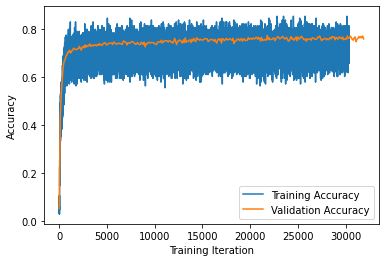

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()